In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score, mean_squared_error, r2_score
import statistics
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K
from keras.optimizers import SGD, Adam, RMSprop, Adamax
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from collections import defaultdict
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("../df.csv")
doc2vec50 = pd.read_csv("../dataset/doc2vec_50.csv")
df_train= df[["essay_set", "essay","total_score", "word_count","Mistakes","reading_ease"]]
df_train = doc2vec50
df_train = pd.concat([df_train, df[["essay_set", "word_count","Mistakes","reading_ease"]]], axis = 1, join = "inner").drop(['Unnamed: 0'], axis = 1)
y = df["total_score"]
X = df_train

This code is inspired from https://www.kaggle.com/rathimadhav/notebook79ae0de477

In [59]:
def get_model(neuron = 50, dropout = 0.1, rec_dropout = 0.1):
    """Define the model."""
    model = Sequential()
    model.add(LSTM(neuron, dropout= dropout, recurrent_dropout=dropout, input_shape=[1, 54], return_sequences=True))
    model.add(LSTM(neuron, recurrent_dropout=dropout))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model

In [70]:
dropouts = [0.2, 0.4, 0.8]
rec_dropouts = [0.2, 0.4, 0.8]
neurons = [50,100,200]
param_grid = dict(neuron=neurons, dropout = dropouts, rec_dropout = rec_dropouts)
param_grid

model = get_model()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             21000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________


GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.engine.sequential.Sequential object at 0x00000241A7FBD5B0>,
             n_jobs=-1,
             param_grid={'dropout': [0.2, 0.4, 0.8], 'neuron': [50, 100, 200],
                         'rec_dropout': [0.2, 0.4, 0.8]})

In [5]:
cv = KFold(n_splits = 5, shuffle = True)
results = []
r2s = []
mses = []
y_pred_list = []
count = 1
resultsdf = pd.DataFrame(columns=['essay_set', 'UserName', 'Action'])
d = {}

for num in range(1,9):
    d[str(num)] = {}
    essay_set = pd.read_csv("../dataset/cleandata_set_{}.csv".format(num))
    train_corpus = essay_set['essay']
    test_corpus = train_corpus.copy()
    vocab = CountVectorizer(stop_words='english', lowercase= True).fit(train_corpus)

    # generate counts for a new set of documents
    doc_emb = vocab.transform(train_corpus)
    
    vec_size = 50
    window=2
    min_count=1
    workers=8
    epochs=40
    essays = [TaggedDocument(gensim.utils.simple_preprocess(doc), [i]) for i, doc in enumerate(train_corpus)]
    
    model = Doc2Vec(essays, vector_size=vec_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
    #might not need this line
    model.train(essays, total_examples=model.corpus_count, epochs=model.epochs)
    doc = [gensim.utils.simple_preprocess(doc) for i, doc in enumerate(test_corpus)]

    doc_emb = np.zeros((len(doc), vec_size))
    for i in range(len(doc)):
        doc_emb[i,:] = model.infer_vector(doc[i])
        
    df_train = pd.DataFrame(doc_emb)
    df_train = pd.concat([df_train, df[["essay_set", "word_count","Mistakes","reading_ease"]]], axis = 1, join = "inner")
    
    y = df["total_score"]
    X = df_train
    print("\n###########Set-{}###########\n".format(num))
    
    for neuron in neurons:
        d[str(num)][str(neuron)] = {}
        #print(" NEURON NUMBER: {}".format(neuron))
        for dropout in dropouts:
            d[str(num)][str(neuron)][str(dropout)] = {}
            #print(" DROP OUT NUMBER: {}".format(neuron))
            for rec_dropout in dropouts:
                d[str(num)][str(neuron)][str(dropout)][str(rec_dropout)]= {}
                #print(" REC DROP OUT NUMBER: {}".format(rec_dropout))
                count = 1
                result_for_set = []
                for traincv, testcv in cv.split(X):
                    #print("\n--------Fold {}--------\n".format(count))

                    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
                    X_train = X_train.to_numpy()
                    X_test = X_test.to_numpy()

                    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
                    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

                    early_stop = EarlyStopping(monitor="val_loss", patience=100)

                    lstm_model = get_model(neuron, dropout, rec_dropout)
                    lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=1000, batch_size=32, verbose=0,callbacks=[early_stop])
                    y_pred_temp = lstm_model.predict(X_test)
                    y_pred = []
                    for i in y_pred_temp:
                        y_pred.append(int(round(i[0])))
                    y_pred_temp = np.around(y_pred_temp)

                    y_test_new = []
                    for  i in list(y_test.array):
                        y_test_new.append(int(i))
                    result = cohen_kappa_score(y_test_new,y_pred,weights='quadratic')
                    #print("Kappa Score: {}".format(result))
                    result_for_set.append(result)
                    count += 1
                d[str(num)][str(neuron)][str(dropout)][str(rec_dropout)] = result_for_set
                #print("===================================================================================")


###########Set-1###########

 REC DROP OUT NUMBER: 0.2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             21000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1,

 REC DROP OUT NUMBER: 0.8
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 1, 50)             21000     
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 1, 50)             21000     


 REC DROP OUT NUMBER: 0.4
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 1, 50)             21000     
_________________________________________________________________
lstm_43 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 1, 50)             21000     


 REC DROP OUT NUMBER: 0.2
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 1, 50)             21000     
_________________________________________________________________
lstm_63 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 1, 50)             21000     


 REC DROP OUT NUMBER: 0.8
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 1, 50)             21000     
_________________________________________________________________
lstm_83 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 1, 50)             21000     


 REC DROP OUT NUMBER: 0.4
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_102 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_103 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_51 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_104 (LSTM)              (None, 1, 100)            62000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_122 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_123 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_61 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_124 (LSTM)              (None, 1, 100)            62000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_142 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_143 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_71 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_144 (LSTM)              (None, 1, 100)            62000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_162 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_163 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_81 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_164 (LSTM)              (None, 1, 100)            62000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_182 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_183 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_91 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_184 (LSTM)              (None, 1, 200)            204000   

 REC DROP OUT NUMBER: 0.8
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_202 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_203 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_204 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_222 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_223 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_111 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_224 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_242 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_243 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_121 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_244 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_262 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_263 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_131 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_264 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_282 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_283 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_141 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_142"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_284 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_302 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_303 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_151 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_304 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_322 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_323 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_161 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_324 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_342 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_343 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_171 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_172"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_344 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_362 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_363 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_181 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_364 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_382 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_383 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_191 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_191 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_192"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_384 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_402 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_403 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_201 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_404 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_422 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_423 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_211 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_211 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_212"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_424 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_442 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_443 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_221 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_221 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_222"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_444 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_231"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_462 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_463 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_231 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_231 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_464 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_241"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_482 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_483 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_241 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_484 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_251"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_502 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_503 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_251 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_251 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_252"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_504 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_261"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_522 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_523 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_261 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_261 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_262"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_524 (LSTM)              (None, 1, 200)            204000 


###########Set-3###########

 REC DROP OUT NUMBER: 0.2
Model: "sequential_271"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_542 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_543 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_271 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_271 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_272"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_544 (LSTM)              (None

 REC DROP OUT NUMBER: 0.8
Model: "sequential_281"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_562 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_563 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_281 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_281 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_282"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_564 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_291"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_582 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_583 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_291 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_291 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_292"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_584 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_602 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_603 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_301 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_301 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_302"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_604 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_311"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_622 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_623 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_311 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_311 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_312"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_624 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_321"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_642 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_643 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_321 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_321 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_322"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_644 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_331"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_662 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_663 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_331 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_331 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_332"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_664 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_341"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_682 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_683 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_341 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_341 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_342"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_684 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_702 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_703 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_351 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_352"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_704 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_361"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_722 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_723 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_361 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_361 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_362"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_724 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_742 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_743 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_371 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_371 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_372"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_744 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_381"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_762 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_763 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_381 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_381 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_382"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_764 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_391"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_782 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_783 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_391 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_391 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_392"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_784 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_401"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_802 (LSTM)              (None, 1, 200)            204000    
_________________________________________________________________
lstm_803 (LSTM)              (None, 200)               320800    
_________________________________________________________________
dropout_401 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_401 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_402"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_804 (LSTM)              (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_411"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_822 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_823 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_411 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_411 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_412"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_824 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_421"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_842 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_843 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_421 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_421 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_422"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_844 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_431"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_862 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_863 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_431 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_431 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_432"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_864 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_441"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_882 (LSTM)              (None, 1, 50)             21000     
_________________________________________________________________
lstm_883 (LSTM)              (None, 50)                20200     
_________________________________________________________________
dropout_441 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_441 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_442"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_884 (LSTM)              (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_451"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_902 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_903 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_451 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_451 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_452"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_904 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_461"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_922 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_923 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_461 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_461 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_462"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_924 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_471"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_942 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_943 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_471 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_471 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_472"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_944 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_481"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_962 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_963 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_481 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_481 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_482"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_964 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_491"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_982 (LSTM)              (None, 1, 100)            62000     
_________________________________________________________________
lstm_983 (LSTM)              (None, 100)               80400     
_________________________________________________________________
dropout_491 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_491 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_492"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_984 (LSTM)              (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_501"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1002 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1003 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_501 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_501 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_502"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1004 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_511"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1022 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1023 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_511 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_511 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_512"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1024 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_521"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1042 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1043 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_521 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_521 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_522"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1044 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_531"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1062 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1063 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_531 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_531 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_532"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1064 (LSTM)             (None, 1, 200)            204000 


###########Set-5###########

 REC DROP OUT NUMBER: 0.2
Model: "sequential_541"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1082 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1083 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_541 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_541 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_542"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1084 (LSTM)             (None

 REC DROP OUT NUMBER: 0.8
Model: "sequential_551"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1102 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1103 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_551 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_551 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_552"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1104 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_561"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1122 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1123 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_561 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_561 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_562"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1124 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_571"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1142 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1143 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_571 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_571 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_572"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1144 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_581"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1162 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1163 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_581 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_581 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_582"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1164 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_591"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1182 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1183 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_591 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_591 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_592"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1184 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_601"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1202 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1203 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_601 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_601 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_602"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1204 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_611"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1222 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1223 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_611 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_611 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_612"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1224 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_621"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1242 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1243 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_621 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_621 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_622"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1244 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_631"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1262 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1263 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_631 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_631 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_632"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1264 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_641"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1282 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1283 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_641 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_641 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_642"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1284 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_651"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1302 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1303 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_651 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_651 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_652"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1304 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_661"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1322 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1323 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_661 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_661 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_662"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1324 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_671"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1342 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1343 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_671 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_671 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_672"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1344 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_681"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1362 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1363 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_681 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_681 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_682"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1364 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_691"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1382 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1383 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_691 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_691 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_692"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1384 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_701"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1402 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1403 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_701 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_701 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_702"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1404 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_711"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1422 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1423 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_711 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_711 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_712"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1424 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_721"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1442 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1443 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_721 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_721 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_722"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1444 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_731"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1462 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1463 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_731 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_731 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_732"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1464 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_741"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1482 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1483 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_741 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_741 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_742"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1484 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_751"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1502 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1503 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_751 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_751 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_752"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1504 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_761"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1522 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1523 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_761 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_761 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_762"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1524 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_771"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1542 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1543 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_771 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_771 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_772"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1544 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_781"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1562 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1563 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_781 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_781 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_782"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1564 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_791"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1582 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1583 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_791 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_791 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_792"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1584 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_801"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1602 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1603 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_801 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_801 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_802"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1604 (LSTM)             (None, 1, 200)            204000 


###########Set-7###########

 REC DROP OUT NUMBER: 0.2
Model: "sequential_811"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1622 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1623 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_811 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_811 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_812"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1624 (LSTM)             (None

 REC DROP OUT NUMBER: 0.8
Model: "sequential_821"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1642 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1643 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_821 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_821 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_822"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1644 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_831"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1662 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1663 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_831 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_831 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_832"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1664 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_841"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1682 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1683 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_841 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_841 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_842"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1684 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_851"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1702 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1703 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_851 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_851 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_852"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1704 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_861"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1722 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1723 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_861 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_861 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_862"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1724 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_871"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1742 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1743 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_871 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_871 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_872"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1744 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_881"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1762 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1763 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_881 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_881 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_882"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1764 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.4
Model: "sequential_891"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1782 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1783 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_891 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_891 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_892"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1784 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.2
Model: "sequential_901"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1802 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1803 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_901 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_901 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_902"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1804 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_911"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1822 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1823 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_911 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_911 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_912"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1824 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_921"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1842 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1843 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_921 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_921 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_922"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1844 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.2
Model: "sequential_931"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1862 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1863 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_931 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_931 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_932"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1864 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.8
Model: "sequential_941"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1882 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_1883 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_941 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_941 (Dense)            (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_942"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1884 (LSTM)             (None, 1, 200)            204000 

 REC DROP OUT NUMBER: 0.4
Model: "sequential_951"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1902 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1903 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_951 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_951 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_952"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1904 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_961"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1922 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1923 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_961 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_961 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_962"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1924 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.8
Model: "sequential_971"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1942 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1943 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_971 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_971 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_972"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1944 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.4
Model: "sequential_981"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1962 (LSTM)             (None, 1, 50)             21000     
_________________________________________________________________
lstm_1963 (LSTM)             (None, 50)                20200     
_________________________________________________________________
dropout_981 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_981 (Dense)            (None, 1)                 51        
Total params: 41,251
Trainable params: 41,251
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_982"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1964 (LSTM)             (None, 1, 50)             21000    

 REC DROP OUT NUMBER: 0.2
Model: "sequential_991"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1982 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_1983 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_991 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_991 (Dense)            (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_992"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1984 (LSTM)             (None, 1, 100)            62000  

 REC DROP OUT NUMBER: 0.8
Model: "sequential_1001"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2002 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_2003 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_1001 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1001 (Dense)           (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1002"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2004 (LSTM)             (None, 1, 100)            62000

 REC DROP OUT NUMBER: 0.4
Model: "sequential_1011"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2022 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_2023 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_1011 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1011 (Dense)           (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1012"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2024 (LSTM)             (None, 1, 100)            62000

 REC DROP OUT NUMBER: 0.2
Model: "sequential_1021"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2042 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_2043 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_1021 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1021 (Dense)           (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1022"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2044 (LSTM)             (None, 1, 100)            62000

 REC DROP OUT NUMBER: 0.8
Model: "sequential_1031"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2062 (LSTM)             (None, 1, 100)            62000     
_________________________________________________________________
lstm_2063 (LSTM)             (None, 100)               80400     
_________________________________________________________________
dropout_1031 (Dropout)       (None, 100)               0         
_________________________________________________________________
dense_1031 (Dense)           (None, 1)                 101       
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1032"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2064 (LSTM)             (None, 1, 100)            62000

 REC DROP OUT NUMBER: 0.4
Model: "sequential_1041"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2082 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_2083 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_1041 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_1041 (Dense)           (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1042"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2084 (LSTM)             (None, 1, 200)            20400

 REC DROP OUT NUMBER: 0.2
Model: "sequential_1051"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2102 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_2103 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_1051 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_1051 (Dense)           (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1052"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2104 (LSTM)             (None, 1, 200)            20400

 REC DROP OUT NUMBER: 0.8
Model: "sequential_1061"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2122 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_2123 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_1061 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_1061 (Dense)           (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1062"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2124 (LSTM)             (None, 1, 200)            20400

 REC DROP OUT NUMBER: 0.4
Model: "sequential_1071"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2142 (LSTM)             (None, 1, 200)            204000    
_________________________________________________________________
lstm_2143 (LSTM)             (None, 200)               320800    
_________________________________________________________________
dropout_1071 (Dropout)       (None, 200)               0         
_________________________________________________________________
dense_1071 (Dense)           (None, 1)                 201       
Total params: 525,001
Trainable params: 525,001
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1072"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2144 (LSTM)             (None, 1, 200)            20400

In [7]:
d 

{'1': {'50': {'0.2': {'0.2': [0.7822229273018805,
     0.831578071015277,
     0.7679183888840032,
     0.7736123893933575,
     0.7774992523496382],
    '0.4': [0.8072263015450674,
     0.8127656386224935,
     0.8018044847401917,
     0.7855830049342649,
     0.7963817660049989],
    '0.8': [0.7753845525299777,
     0.831038718631846,
     0.8038468723557789,
     0.7457837020860105,
     0.8293238167507517]},
   '0.4': {'0.2': [0.6412645947145328,
     0.7513163555901575,
     0.7353803647269683,
     0.8251764184287984,
     0.6709744393716301],
    '0.4': [0.7671747709109399,
     0.7413726977525121,
     0.7443229704545185,
     0.7649705103075166,
     0.7184655488234466],
    '0.8': [0.80612211166573,
     0.7314726255687911,
     0.524859609628182,
     0.7595900041936996,
     0.7430979627443937]},
   '0.8': {'0.2': [0.5408971578586919,
     0.02651742049691108,
     0.19118869492934332,
     0.3064607537546047,
     0.04702358667165851],
    '0.4': [0.22328883642612873,
    

## Result LSTM Dictionary

In [71]:
d = {'1': {'50': {'0.2': {'0.2': [0.7822229273018805,
     0.831578071015277,
     0.7679183888840032,
     0.7736123893933575,
     0.7774992523496382],
    '0.4': [0.8072263015450674,
     0.8127656386224935,
     0.8018044847401917,
     0.7855830049342649,
     0.7963817660049989],
    '0.8': [0.7753845525299777,
     0.831038718631846,
     0.8038468723557789,
     0.7457837020860105,
     0.8293238167507517]},
   '0.4': {'0.2': [0.6412645947145328,
     0.7513163555901575,
     0.7353803647269683,
     0.8251764184287984,
     0.6709744393716301],
    '0.4': [0.7671747709109399,
     0.7413726977525121,
     0.7443229704545185,
     0.7649705103075166,
     0.7184655488234466],
    '0.8': [0.80612211166573,
     0.7314726255687911,
     0.524859609628182,
     0.7595900041936996,
     0.7430979627443937]},
   '0.8': {'0.2': [0.5408971578586919,
     0.02651742049691108,
     0.19118869492934332,
     0.3064607537546047,
     0.04702358667165851],
    '0.4': [0.22328883642612873,
     0.19190706036091143,
     0.22589009522654213,
     0.26280448953585267,
     0.2599294757155991],
    '0.8': [0.22084864760300849,
     0.25483810020782915,
     0.14279047799514122,
     0.1885199191835466,
     0.16168561577047957]}},
  '100': {'0.2': {'0.2': [0.7738246821408828,
     0.822141191385918,
     0.7984072087534864,
     0.8357220412595006,
     0.7878838266267597],
    '0.4': [0.7475956157959249,
     0.7756644569729261,
     0.7871603849680112,
     0.7424277947921398,
     0.799564065057135],
    '0.8': [0.8255477633820674,
     0.780478332632124,
     0.8231413023081253,
     0.7776727741338576,
     0.8129972353228168]},
   '0.4': {'0.2': [0.8053395061728394,
     0.757915095317649,
     0.7714273253024659,
     0.6301645344016368,
     0.8193884386534092],
    '0.4': [0.8076464752434602,
     0.8134397623909412,
     0.6011953679491968,
     0.6686024077789783,
     0.7719888094189458],
    '0.8': [0.7812953269849278,
     0.7955212307310567,
     0.7067690969705755,
     0.6062983061996382,
     0.6574515910289576]},
   '0.8': {'0.2': [0.2711190890530153,
     0.2216542039094701,
     0.41482329420869335,
     0.31499318291771117,
     0.32018028128224163],
    '0.4': [0.23496614894464363,
     0.28010969022158516,
     0.22959216339074207,
     0.20193780168975373,
     0.3708926440231728],
    '0.8': [0.1006053514500973,
     0.3860645759666107,
     0.3050918266431284,
     0.02050568525255747,
     0.3214010399876659]}},
  '200': {'0.2': {'0.2': [0.7713318114542307,
     0.8292270275986042,
     0.7241026390818042,
     0.8259999695711047,
     0.7980655736337436],
    '0.4': [0.8246235606731621,
     0.7939966378027451,
     0.7871448632312974,
     0.850986489080798,
     0.8183243595053548],
    '0.8': [0.8290200639720849,
     0.8104074679775378,
     0.69253775749082,
     0.7836987794635358,
     0.8061997226074896]},
   '0.4': {'0.2': [0.7562549443030938,
     0.5691949434464405,
     0.8180208146127077,
     0.8020480070469059,
     0.7350998653013339],
    '0.4': [0.7261272612726127,
     0.7728285077951003,
     0.8006119326874044,
     0.8222333187691155,
     0.6448732856528457],
    '0.8': [0.7902206395842639,
     0.7582764811490126,
     0.6705461437713629,
     0.7217842688089937,
     0.7196284946651903]},
   '0.8': {'0.2': [0.5190056598074877,
     0.1999000161512371,
     0.5154181708784598,
     0.2665707358658259,
     0.3031592548119123],
    '0.4': [0.13731050002347867,
     0.5285082363157751,
     0.4088244296376522,
     0.14601842501485585,
     0.3674561222529721],
    '0.8': [0.34623813002191384,
     0.4391243846602726,
     0.19376315315949655,
     0.167132325714478,
     0.24231478289542707]}}},
 '2': {'50': {'0.2': {'0.2': [0.7844917454841828,
     0.7090318753707346,
     0.6034743202416919,
     0.7589087012665879,
     0.6372834848225004],
    '0.4': [0.7124243255980154,
     0.7388268367516587,
     0.7372402430598615,
     0.6504394861392833,
     0.6313728757080973],
    '0.8': [0.7125542543608222,
     0.667452292252718,
     0.7592795063284101,
     0.7311460634957554,
     0.693261531920924]},
   '0.4': {'0.2': [0.7290671910672315,
     0.7006915588706006,
     0.6458445469225063,
     0.7597793380140421,
     0.6966677047648708],
    '0.4': [0.6992741777283724,
     0.7135873074439627,
     0.6836443553362122,
     0.7497261312884469,
     0.6290076335877863],
    '0.8': [0.583419689119171,
     0.6398448164379624,
     0.7248288105503424,
     0.6413904859153365,
     0.7357286536727474]},
   '0.8': {'0.2': [0.0019238545712990662,
     0.0,
     0.12392241379310331,
     0.09090909090909094,
     0.1625357554700254],
    '0.4': [0.00981637185451778,
     0.02364737688648577,
     0.08192771084337358,
     0.11201186356895698,
     0.32402919085921267],
    '0.8': [0.022228039696327806,
     0.0,
     0.0764097108037528,
     0.27277494398627067,
     0.0]}},
  '100': {'0.2': {'0.2': [0.7443368737663314,
     0.6512185920169018,
     0.7419058251789584,
     0.7540761279045236,
     0.7163398692810458],
    '0.4': [0.7506292434273145,
     0.6815814786560085,
     0.7015548623222225,
     0.7555281472997974,
     0.6937106918238993],
    '0.8': [0.6811069442648391,
     0.7524807056229328,
     0.6921122079953084,
     0.697307444125066,
     0.6868921377925582]},
   '0.4': {'0.2': [0.661548280522601,
     0.6465734183882483,
     0.5800652325852295,
     0.7694744251525105,
     0.6701617353652842],
    '0.4': [0.6600420100177735,
     0.6083053767340647,
     0.7059086723456584,
     0.6758389261744966,
     0.7080706917019177],
    '0.8': [0.6670373665480427,
     0.7419430446501816,
     0.6776801087449025,
     0.691099077110823,
     0.7343008970915947]},
   '0.8': {'0.2': [0.20743293713716615,
     0.17214543150223782,
     0.202207931695512,
     0.14714682043192073,
     0.1480947914954509],
    '0.4': [0.2881130401723482,
     0.24933372816108967,
     0.08426808126009455,
     0.19601542416452433,
     0.16772583909993888],
    '0.8': [0.030761797390884138,
     0.2780476234116993,
     0.2764046618656779,
     0.15130434782608693,
     0.20485720710591415]}},
  '200': {'0.2': {'0.2': [0.6919569237934574,
     0.7380056413665791,
     0.6332872059378538,
     0.6793416127668237,
     0.7442349249578165],
    '0.4': [0.7471691847916321,
     0.5888926725071975,
     0.782893561260349,
     0.6213020305116199,
     0.6972919961600353],
    '0.8': [0.6921734070410241,
     0.7789681073759389,
     0.7215978635807277,
     0.6793461861464465,
     0.7673927949786381]},
   '0.4': {'0.2': [0.6426102217731213,
     0.7515329138867495,
     0.6280978487384181,
     0.7242850695441678,
     0.7458567465680348],
    '0.4': [0.7764900662251655,
     0.5196122951857007,
     0.6502357479639949,
     0.698028980289803,
     0.6908286582804044],
    '0.8': [0.5823282642894598,
     0.6296537063882623,
     0.7823303889611377,
     0.6845298281092013,
     0.6860587018596583]},
   '0.8': {'0.2': [0.2938832436740386,
     0.33913104097317837,
     0.3557105492589363,
     0.23268870867124136,
     0.2795531405555344],
    '0.4': [0.26470588235294124,
     0.24867520023229361,
     0.20856673263341496,
     0.27277742024455276,
     0.23375081217932914],
    '0.8': [0.23236026563364687,
     0.23843726606843363,
     0.3426395653592198,
     0.3967479361160404,
     0.3030192465565995]}}},
 '3': {'50': {'0.2': {'0.2': [0.7316312398887082,
     0.746903653008409,
     0.7941351973403802,
     0.8066612779611839,
     0.7750109217999126],
    '0.4': [0.7824431242534504,
     0.7684732134509302,
     0.7587826897600707,
     0.7550861133892431,
     0.761807606198777],
    '0.8': [0.7558426720879047,
     0.6888068880688807,
     0.7561837455830389,
     0.79445808181842,
     0.7359839771465424]},
   '0.4': {'0.2': [0.7483202959088462,
     0.7107762866891526,
     0.5589672891339766,
     0.741139846743295,
     0.6500837345967092],
    '0.4': [0.7035239116171846,
     0.7648668443431733,
     0.5312841788228571,
     0.6971515879078904,
     0.7692532877416889],
    '0.8': [0.7559222034979212,
     0.6598711312981937,
     0.7174773070668159,
     0.4738362872425015,
     0.7257876312718786]},
   '0.8': {'0.2': [0.0029436370960246316,
     0.13754707712461112,
     0.07003694145033146,
     0.016953689658249393,
     0.22101945222338037],
    '0.4': [0.2653734059528676,
     0.11501899269814397,
     0.09969539100976454,
     0.0,
     0.2600536193029491],
    '0.8': [0.14574418653036603,
     0.2288705879540539,
     0.15665275004538037,
     0.10651555168081228,
     0.031987222224202805]}},
  '100': {'0.2': {'0.2': [0.748702696485203,
     0.7576104506091296,
     0.7941062512739245,
     0.7689833405824221,
     0.7489047598923777],
    '0.4': [0.7280076790043774,
     0.7787389537268354,
     0.7562596704975623,
     0.7094671073482139,
     0.7393335895165378],
    '0.8': [0.7815515521979007,
     0.7629019227661981,
     0.7645298472200346,
     0.7585808754067388,
     0.7920522215917829]},
   '0.4': {'0.2': [0.734212603052538,
     0.7433305113799352,
     0.7933189137226628,
     0.6623474315110043,
     0.7090052883057427],
    '0.4': [0.7534685799109352,
     0.7587472840338653,
     0.7139877964007106,
     0.7819946267607402,
     0.6478048695241881],
    '0.8': [0.7526815978996773,
     0.6873743658466545,
     0.7079294059159831,
     0.6975797067721666,
     0.7624150741197047]},
   '0.8': {'0.2': [0.16106876569318362,
     0.22118505988731485,
     0.3391389556201795,
     0.3721572173534672,
     0.020428712682674655],
    '0.4': [0.2073453786933377,
     0.29856415288054494,
     0.1299891354546331,
     0.12360048924073597,
     0.1675685873439844],
    '0.8': [0.43787096184117413,
     0.3902985303592795,
     0.10060714163207896,
     0.47247153943633946,
     0.3452644533518895]}},
  '200': {'0.2': {'0.2': [0.7865008543763052,
     0.6703267801959366,
     0.7189071326587622,
     0.7359465536625442,
     0.7921949478349458],
    '0.4': [0.7480282902054608,
     0.778311077317873,
     0.7006877373613178,
     0.7452340302351822,
     0.763088501895292],
    '0.8': [0.7238522347217999,
     0.8119301337435499,
     0.7437330352866038,
     0.7146958729173365,
     0.7915021573099009]},
   '0.4': {'0.2': [0.7804737637991916,
     0.7587041461988904,
     0.7272499646441579,
     0.749487102648625,
     0.7281703608995089],
    '0.4': [0.7589591359358573,
     0.7800406322778851,
     0.6353748403230571,
     0.6896000881348463,
     0.7618660312324141],
    '0.8': [0.6583943718759208,
     0.6994005227816995,
     0.7207738814993954,
     0.7027898155518214,
     0.7454347765479941]},
   '0.8': {'0.2': [0.35631191421888,
     0.062364804153216435,
     0.4481645406228293,
     0.35154920962593417,
     0.28681695988927636],
    '0.4': [0.18786524440728913,
     0.37564863777242785,
     0.17709134111398417,
     0.26447182268332936,
     0.3962325544582318],
    '0.8': [0.23113427843982104,
     0.2677448155513169,
     0.27795350308397904,
     0.21331864999676098,
     0.35940658686049964]}}},
 '4': {'50': {'0.2': {'0.2': [0.7651359796409936,
     0.6433286960920703,
     0.7596400556532417,
     0.7758841948565269,
     0.7695149789377074],
    '0.4': [0.7775413602778476,
     0.7828987265009096,
     0.770162545092721,
     0.670537961409396,
     0.7718844873745259],
    '0.8': [0.7869941458104219,
     0.7866512254496467,
     0.7802547424885713,
     0.6908904363771311,
     0.7785307710667352]},
   '0.4': {'0.2': [0.7323591929238287,
     0.7169241880981247,
     0.7347981784877997,
     0.692776571783356,
     0.672456383464018],
    '0.4': [0.696250016169299,
     0.6246616931819315,
     0.652796508349067,
     0.7190712066876956,
     0.7114574597401129],
    '0.8': [0.7150066215490931,
     0.7635029553638155,
     0.7132163999308019,
     0.6884151903595948,
     0.7596105816789258]},
   '0.8': {'0.2': [0.4072351986579873,
     0.28090284884910965,
     0.090479017142446,
     0.0060933061542940425,
     0.0],
    '0.4': [0.0416198110300503,
     0.2676079023810449,
     0.281488567634416,
     0.001295359462250678,
     0.1727384718241416],
    '0.8': [0.12638451673079165,
     0.20928295600817748,
     0.038891828558470065,
     0.31894906523873934,
     0.01111563754874001]}},
  '100': {'0.2': {'0.2': [0.780314585158155,
     0.7569546864669684,
     0.7762418567421887,
     0.7466035585940924,
     0.781198607034113],
    '0.4': [0.7283788227556725,
     0.780691847066667,
     0.7544585095172671,
     0.7723515475160769,
     0.7611057775349773],
    '0.8': [0.7961206985210935,
     0.7614081117122196,
     0.7749755667326166,
     0.7917647058823529,
     0.7644671510245606]},
   '0.4': {'0.2': [0.7538190020921236,
     0.6505905959206997,
     0.5711004706195979,
     0.7974348284572186,
     0.7111080885968675],
    '0.4': [0.7039434311441751,
     0.708871856527402,
     0.7351824847713898,
     0.709301690252204,
     0.5566573168100416],
    '0.8': [0.7842877480886696,
     0.7389040416563353,
     0.785383971021921,
     0.7605508245947404,
     0.7735666070772351]},
   '0.8': {'0.2': [0.3832160785936629,
     0.4445839086230702,
     0.22695289942420793,
     0.35752376305162903,
     0.22397875300366754],
    '0.4': [0.13781425994773067,
     0.2495764947651976,
     0.12036430554255961,
     0.1809558325323417,
     0.44077299087197996],
    '0.8': [0.2810333091681838,
     0.31389492817296727,
     0.3316856817717604,
     0.019252555907252722,
     0.27763292143747875]}},
  '200': {'0.2': {'0.2': [0.7557026137750009,
     0.6904893382040609,
     0.7890591686863349,
     0.7223520450320182,
     0.7380398494481893],
    '0.4': [0.7631802796434457,
     0.6919001334095674,
     0.7721910262580887,
     0.7699674233414344,
     0.6037505451373746],
    '0.8': [0.7382210014789774,
     0.8252385596193983,
     0.6917656349664368,
     0.6666759587061765,
     0.7207865994679358]},
   '0.4': {'0.2': [0.7493057646625849,
     0.4862666958261447,
     0.7176115701094334,
     0.734366515837104,
     0.7119332430812934],
    '0.4': [0.6774979312595424,
     0.7698033173933052,
     0.7831974631517346,
     0.7565137644727576,
     0.5825458994093105],
    '0.8': [0.8180801809435744,
     0.693866961845792,
     0.5582984604752945,
     0.644019620931865,
     0.6676416422922761]},
   '0.8': {'0.2': [0.35736466285906443,
     0.5013192612137203,
     0.4332451621885006,
     0.30969309693096936,
     0.4301727983243798],
    '0.4': [0.34453290154275185,
     0.3128647564499537,
     0.2708114199849736,
     0.27918338059670167,
     0.48916240446969617],
    '0.8': [0.25371359380743363,
     0.29819322333628073,
     0.28043462192327595,
     0.42124819283619996,
     0.35685194058457115]}}},
 '5': {'50': {'0.2': {'0.2': [0.603519241947039,
     0.7172475197150852,
     0.6804530877857585,
     0.5491963963058926,
     0.7477150581090256],
    '0.4': [0.760762579007415,
     0.6671483833041445,
     0.7339881978234789,
     0.6874871006948425,
     0.6029078413135134],
    '0.8': [0.7237894847931191,
     0.6930447537358277,
     0.7552566833963263,
     0.6485993051402965,
     0.772498887887671]},
   '0.4': {'0.2': [0.7320348788145474,
     0.7289018122802272,
     0.720938670873595,
     0.6751958055537576,
     0.7313842811804245],
    '0.4': [0.7117257806921438,
     0.6412754327139594,
     0.7207318716529499,
     0.741803002154678,
     0.7130268999386954],
    '0.8': [0.5070126227208975,
     0.6342600097260496,
     0.6724305777078454,
     0.6415734588548683,
     0.7174597620713785]},
   '0.8': {'0.2': [0.022256114782805092,
     0.13925263655602949,
     0.30389951340952803,
     0.23193114522086067,
     0.11203240815810522],
    '0.4': [0.0,
     0.21332786165661932,
     0.29876558681621657,
     0.36648705586841146,
     0.4114684555951086],
    '0.8': [-0.0011745172795474268,
     0.09632167434007088,
     0.005633058065282026,
     0.25992882353085256,
     0.15704189847778582]}},
  '100': {'0.2': {'0.2': [0.6927931920928996,
     0.6926798376296419,
     0.6420034674609227,
     0.7335191794978679,
     0.7021058885661473],
    '0.4': [0.5762211515425772,
     0.6756283539736263,
     0.7270022044004825,
     0.6709327640312602,
     0.6206139028293013],
    '0.8': [0.7482830536652476,
     0.7525343273788332,
     0.7136613530975838,
     0.6627400570376927,
     0.6768956892601832]},
   '0.4': {'0.2': [0.6900152412127771,
     0.7062619989880998,
     0.6762474222270387,
     0.6879062818172508,
     0.7294612425914012],
    '0.4': [0.709519603179996,
     0.662092893476133,
     0.7381368387190372,
     0.71616815896827,
     0.5937068054313359],
    '0.8': [0.6057032941904416,
     0.706861550954121,
     0.5585165049047593,
     0.7074630439724238,
     0.6057830326428589]},
   '0.8': {'0.2': [0.16527084567013517,
     0.25900976895144456,
     0.35951453973831193,
     0.3343545664723486,
     0.16009847813484046],
    '0.4': [0.20594461149898824,
     0.08889220059995384,
     0.17720060742525012,
     0.406694823194486,
     0.22732706496659116],
    '0.8': [0.23913071416637754,
     0.37037134297525187,
     0.4360360451602612,
     0.18180079750535105,
     0.2356367267129842]}},
  '200': {'0.2': {'0.2': [0.6395425215408987,
     0.7046931118315585,
     0.6701174504433407,
     0.6327672010006626,
     0.6684192597375034],
    '0.4': [0.5260410466834251,
     0.718027210417436,
     0.6782864008529803,
     0.6945815752907225,
     0.7339702886206991],
    '0.8': [0.6352427149978489,
     0.6629381590196637,
     0.6526832844827142,
     0.6992522999563333,
     0.770342118850343]},
   '0.4': {'0.2': [0.5015069884162393,
     0.6174744093533208,
     0.7669951651556534,
     0.6867013353542217,
     0.6876159440632299],
    '0.4': [0.7126388954218332,
     0.506222265248063,
     0.5403218155095302,
     0.7342156404277663,
     0.7420302126535037],
    '0.8': [0.6580878784734889,
     0.6083878684812994,
     0.7606392038542021,
     0.6936781504218608,
     0.759314894539598]},
   '0.8': {'0.2': [0.21576646683379463,
     0.2596828596906138,
     0.32352063175903645,
     0.3049343754100865,
     0.30861128881160305],
    '0.4': [0.30520356269843507,
     0.30212743614588955,
     0.2687065402580888,
     0.28874520960195615,
     0.10748417634432283],
    '0.8': [0.3400252341020865,
     0.24642614023144993,
     0.12447213246859923,
     0.1864003246165955,
     0.32328164776672075]}}},
 '6': {'50': {'0.2': {'0.2': [0.7597292724196277,
     0.6981361968775942,
     0.7519527126873549,
     0.7067694749971651,
     0.7548331353277892],
    '0.4': [0.7206966250842197,
     0.6756109247724006,
     0.6631502890173411,
     0.7581539826935877,
     0.7413793103448276],
    '0.8': [0.7278992312472508,
     0.7638145726804276,
     0.6625596625596626,
     0.7368333610234259,
     0.721385203507983]},
   '0.4': {'0.2': [0.6860435556308787,
     0.7137561961851895,
     0.6122419405181254,
     0.6449449264660636,
     0.6664482575044024],
    '0.4': [0.6523125996810207,
     0.7073024740622507,
     0.6172922641490086,
     0.5914844649021864,
     0.6519702166820045],
    '0.8': [0.6907020069438563,
     0.701151631477927,
     0.6962382583386009,
     0.6341934860345994,
     0.6834264432029795]},
   '0.8': {'0.2': [0.12138872511224996,
     0.121344537815126,
     0.3347944893544347,
     0.11301482005725205,
     0.2565409244209369],
    '0.4': [0.025087357763641238,
     0.0,
     0.3090519550080343,
     0.09233686955491027,
     0.026721479958890182],
    '0.8': [0.1812130958949134,
     0.4055218026609244,
     0.06782431052093973,
     0.01758923952405589,
     0.018138671295635067]}},
  '100': {'0.2': {'0.2': [0.6828446922570854,
     0.7490414778668526,
     0.7439328348419257,
     0.7134925290598834,
     0.7694230947309937],
    '0.4': [0.6824824485121004,
     0.7211239449133717,
     0.7734759396653255,
     0.7082501608459673,
     0.7278880866425992],
    '0.8': [0.7067520238847104,
     0.7386088980395668,
     0.7348536209553158,
     0.4877784741610164,
     0.7398324078171618]},
   '0.4': {'0.2': [0.7024784144609908,
     0.6168556208168283,
     0.7161606268364349,
     0.6982515091141575,
     0.6850095887492009],
    '0.4': [0.7041205300417499,
     0.6982117217073489,
     0.5794522024295237,
     0.7303170318861796,
     0.681723472177088],
    '0.8': [0.7022673906662753,
     0.7093007205366756,
     0.7280843101073369,
     0.6989556438152723,
     0.6765396961975048]},
   '0.8': {'0.2': [0.25960655763540585,
     0.12989123640455058,
     0.32750455373406195,
     0.16665103101487888,
     0.17327898232420835],
    '0.4': [0.2987040133779264,
     0.13520582215146681,
     0.04370633038880378,
     0.24680450284791677,
     0.1608680675163624],
    '0.8': [0.04070638320237563,
     0.2778321465933249,
     0.18811762232301088,
     0.3571428571428572,
     0.07741360394953378]}},
  '200': {'0.2': {'0.2': [0.737781954887218,
     0.7153343120245563,
     0.75957976968146,
     0.7312506465294301,
     0.7223267363985251],
    '0.4': [0.7177262721740256,
     0.6383296047725577,
     0.8114111388447671,
     0.740605481415748,
     0.737307624270299],
    '0.8': [0.7055787476280835,
     0.648247541515075,
     0.6998213222156044,
     0.7336124060508039,
     0.772281288450011]},
   '0.4': {'0.2': [0.7080247291424374,
     0.5832305795314426,
     0.7002190466256388,
     0.734475877450405,
     0.6086509929239898],
    '0.4': [0.6340808834870593,
     0.7394074393427703,
     0.7273220924242214,
     0.683727948003714,
     0.6524793166433868],
    '0.8': [0.6506528204869688,
     0.6219549294456275,
     0.661859168585626,
     0.7403688150447325,
     0.7560396693532574]},
   '0.8': {'0.2': [0.22046271081718127,
     0.363048656005444,
     0.2659896668448245,
     0.29856764564275395,
     0.2072927072927072],
    '0.4': [0.3050705749274578,
     0.15108159010409006,
     0.367428727570817,
     0.30559154272684874,
     0.303921568627451],
    '0.8': [0.35598485170843785,
     0.27322280263456733,
     0.3534347142108023,
     0.2650052127289877,
     0.2158354604358924]}}},
 '7': {'50': {'0.2': {'0.2': [0.7441791277044686,
     0.8165466394833208,
     0.6848039186826256,
     0.6190403003078528,
     0.7060480841472576],
    '0.4': [0.7339903913135317,
     0.6593354479932354,
     0.6889736115581466,
     0.7201918992011108,
     0.7608563921641889],
    '0.8': [0.7456213511259383,
     0.7059507462765091,
     0.7276605333906307,
     0.724673052716916,
     0.7609639708440845]},
   '0.4': {'0.2': [0.7328757834172404,
     0.7201043370338622,
     0.711880095794204,
     0.6212520801900486,
     0.7543267249931522],
    '0.4': [0.7584782759337537,
     0.6909234675785725,
     0.6351279347912344,
     0.7349099144642388,
     0.7740258355864369],
    '0.8': [0.6797076579814441,
     0.6463947610612921,
     0.770699221323512,
     0.7250050826517367,
     0.6145196520022214]},
   '0.8': {'0.2': [0.1799234069215081,
     0.09880059309717104,
     0.07103599556429752,
     0.0,
     0.2506378721857754],
    '0.4': [0.0, 0.0, 0.0, 0.2515397117898709, 0.2054093201175704],
    '0.8': [0.07352378092270728,
     0.36263564681083615,
     0.011108426033473284,
     0.036742946898891904,
     0.20632857447261876]}},
  '100': {'0.2': {'0.2': [0.7386111875827532,
     0.7705819538535366,
     0.7515350505346343,
     0.7161788654325968,
     0.69430308468034],
    '0.4': [0.7407221692328655,
     0.7417740686270244,
     0.7801743879193401,
     0.755067807137233,
     0.686821949534761],
    '0.8': [0.6570159182120546,
     0.7707085966083321,
     0.7346981078511334,
     0.6936691808904736,
     0.7477798973819234]},
   '0.4': {'0.2': [0.7565629757060963,
     0.7720229429140253,
     0.689847074998475,
     0.7111903498240317,
     0.7333398674577983],
    '0.4': [0.7625088158758725,
     0.7384359949735315,
     0.68647980714597,
     0.6684686206605288,
     0.7460087216185338],
    '0.8': [0.7118877548562978,
     0.7823497255810903,
     0.6569304593220524,
     0.7504136935618304,
     0.7963299477914181]},
   '0.8': {'0.2': [0.362933435543631,
     0.17458648440975433,
     0.3133170625619215,
     0.2942945759282952,
     0.2420517662060595],
    '0.4': [0.2384376521777627,
     0.060448658490501184,
     0.3708975337888547,
     0.20659957244277294,
     0.24702425263487837],
    '0.8': [0.32921518684782525,
     0.22863401658582372,
     0.1658528134083661,
     0.24968010331918866,
     0.40612501224824293]}},
  '200': {'0.2': {'0.2': [0.7830965646265495,
     0.7705790322196368,
     0.6315941475892586,
     0.65614854681474,
     0.7537714423908178],
    '0.4': [0.7620946395527861,
     0.5574450949416101,
     0.739798472720158,
     0.7664904578442792,
     0.6534330671850203],
    '0.8': [0.6760367778505543,
     0.7714856762158561,
     0.720459011602195,
     0.7153528174631953,
     0.7401542226129654]},
   '0.4': {'0.2': [0.6001599032780172,
     0.6661304188263211,
     0.8047322918246625,
     0.5975673961916108,
     0.6420892458402363],
    '0.4': [0.5179715584092603,
     0.6518755114431276,
     0.7993642075017166,
     0.7546226165572627,
     0.7878118029251137],
    '0.8': [0.7174604780147762,
     0.6681593189180155,
     0.661529352743642,
     0.7611686373006659,
     0.7152391801285922]},
   '0.8': {'0.2': [0.34350701440780207,
     0.23225270407575915,
     0.17234567343782625,
     0.3601620190060757,
     0.1830759430257224],
    '0.4': [0.2806171606945891,
     0.27303413217138706,
     0.45835060673557293,
     0.15251707090028777,
     0.19405299516890906],
    '0.8': [0.19863634144621567,
     0.373577800913948,
     0.2788557551744246,
     0.3541343916633304,
     0.2346991817744265]}}},
 '8': {'50': {'0.2': {'0.2': [0.7531169330477289,
     0.6917106893628122,
     0.7025458498439527,
     0.7963355834136934,
     0.7676514772158237],
    '0.4': [0.7621562106776919,
     0.700716338176373,
     0.815028300906196,
     0.7347809228383094,
     0.7055990367248646],
    '0.8': [0.7809619015883594,
     0.7534708097339133,
     0.6682838816612999,
     0.7632450331125828,
     0.7022376486227013]},
   '0.4': {'0.2': [0.6600732600732601,
     0.6880934847486531,
     0.6632940786200033,
     0.7445339470655926,
     0.7806165678159421],
    '0.4': [0.7332502522105513,
     0.6905718913637805,
     0.798074120453834,
     0.7658716159214664,
     0.7118577075098814],
    '0.8': [0.721293261485473,
     0.7055055999865162,
     0.8017006391351673,
     0.6871867960093789,
     0.67891544773457]},
   '0.8': {'0.2': [0.19194802370467023,
     0.30210864623344047,
     -0.0014416468300533225,
     0.3995433789954338,
     0.2387403881362139],
    '0.4': [0.26792804274300286,
     -0.2470978198969085,
     0.0,
     0.28268809349890434,
     0.34412027009810164],
    '0.8': [0.20159470437791482,
     0.0,
     0.3710631008951265,
     0.0,
     0.002991944764096588]}},
  '100': {'0.2': {'0.2': [0.7663220785346487,
     0.6136656639449936,
     0.6962425488963797,
     0.8229416776392224,
     0.7521085441877521],
    '0.4': [0.7244734432234432,
     0.8016632926629097,
     0.6722107998076943,
     0.6786459540922791,
     0.7860768958325135],
    '0.8': [0.7435504409753337,
     0.7673227128605676,
     0.7495416830035924,
     0.6594684385382059,
     0.7198739771213498]},
   '0.4': {'0.2': [0.7861900645751767,
     0.7502191060473269,
     0.7505444250871081,
     0.6799262381454162,
     0.717379171782565],
    '0.4': [0.8190899754712657,
     0.7211139074744747,
     0.7417123557036112,
     0.8117256407595725,
     0.5847331490537955],
    '0.8': [0.8117737218286178,
     0.7819495118824573,
     0.786790253891146,
     0.778626787468617,
     0.574763757643135]},
   '0.8': {'0.2': [0.22569269521410584,
     0.07639969599363039,
     0.3796221421745204,
     -0.07690887268026958,
     0.15135279935708545],
    '0.4': [0.22308380554727114,
     0.08390456929107071,
     0.2603985907346058,
     0.1505402393526818,
     0.13952403173121797],
    '0.8': [0.10045265327567376,
     0.52023149206502,
     0.302229801008685,
     0.3053173241852487,
     0.23312806334045488]}},
  '200': {'0.2': {'0.2': [0.7802834477226135,
     0.7811614374591249,
     0.6715127787797475,
     0.8023458946843025,
     0.7564886261148411],
    '0.4': [0.7502331449887542,
     0.5474619132794671,
     0.7571131571131571,
     0.7438588123062246,
     0.7683690469351411],
    '0.8': [0.7239311065866946,
     0.6714727085478888,
     0.7748701090303498,
     0.637060489918347,
     0.7483462350457424]},
   '0.4': {'0.2': [0.7028395061728394,
     0.8552207290524283,
     0.7816900822665303,
     0.599576966558477,
     0.7174939390072732],
    '0.4': [0.7533216168717047,
     0.53323766677009,
     0.6879823345838826,
     0.7811807944211469,
     0.7275878778842212],
    '0.8': [0.7486543198613265,
     0.6295169728677454,
     0.6737210124039946,
     0.6014658726523134,
     0.6831424398493351]},
   '0.8': {'0.2': [0.3441551914765302,
     0.10288785872761053,
     0.20186474949449562,
     0.2849083215796897,
     0.24152264897645415],
    '0.4': [0.13395904436860073,
     0.21439471363171814,
     0.1917964842075175,
     0.2081902245706737,
     0.2831242221399981],
    '0.8': [0.20520439661887313,
     0.43796706874631774,
     0.1929127052722558,
     0.022570024335544225,
     0.3171780663303283]}}}}

## Graphing LSTM

In [72]:
for i in range(1,9):
    for neuron in neurons:
        for dropout in dropouts:
            temp = []
            for rec_dropout in rec_dropouts:
                array = d[str(i)][str(neuron)][str(dropout)][str(rec_dropout)]
                d[str(i)][str(neuron)][str(dropout)][str(rec_dropout)]= np.mean(array)
                temp.append(np.mean(array))
            d[str(i)][str(neuron)][str(dropout)] = np.mean(temp)

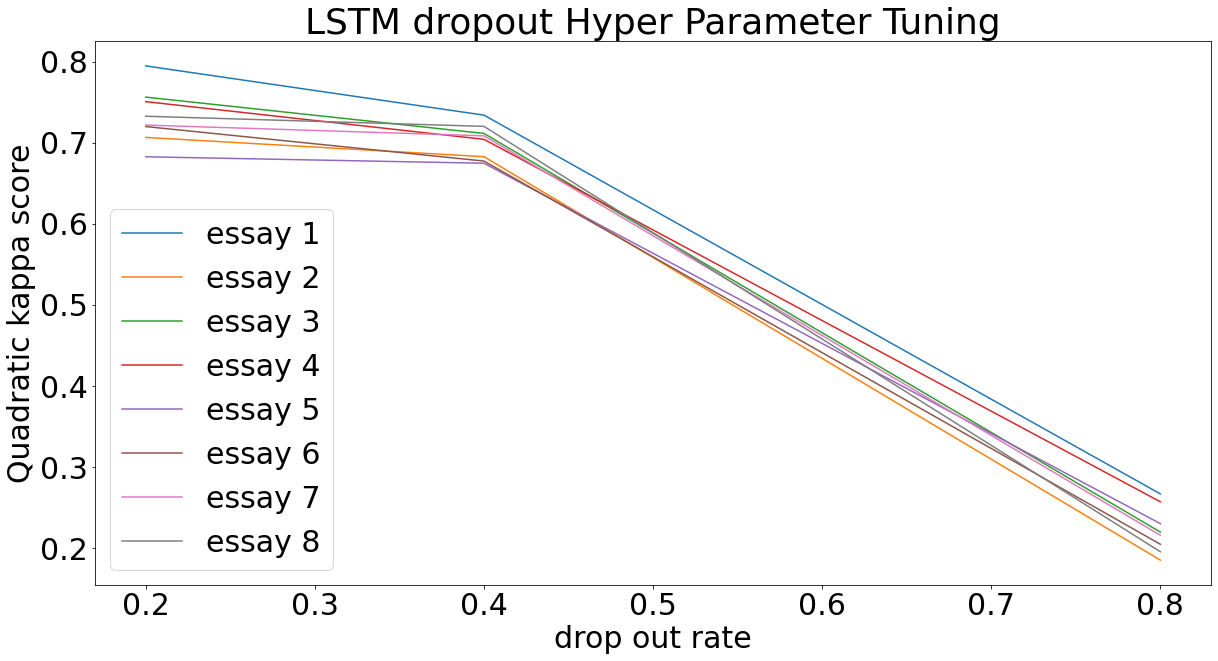

In [73]:
new_d = {}
result = []
plt.rcParams.update({'font.size': 30})
for i in range(1,9):
    new_d[str(i)] = {}
    result_array = []
    for dropout in dropouts:
        new_d[str(i)][str(dropout)] = []
        for neuron in neurons:
            new_d[str(i)][str(dropout)].append(d[str(i)][str(neuron)][str(dropout)])
        new_d[str(i)][str(dropout)] = np.mean(new_d[str(i)][str(dropout)])
        result_array.append(np.mean(new_d[str(i)][str(dropout)]))
    result.append(result_array)
fig, ax = plt.subplots(figsize = (20,10))
legends = []
for i in range(1,9):
    ax.plot(dropouts, result[i-1])
    string = "essay " + str(i)
    legends.append(string)
ax.legend(legends)
ax.set_xlabel("drop out rate")
ax.set_ylabel("Quadratic kappa score")
ax.set_title("LSTM dropout Hyper Parameter Tuning")
fig.savefig("lstm_dropout_hyper_parameter_tuning.png")

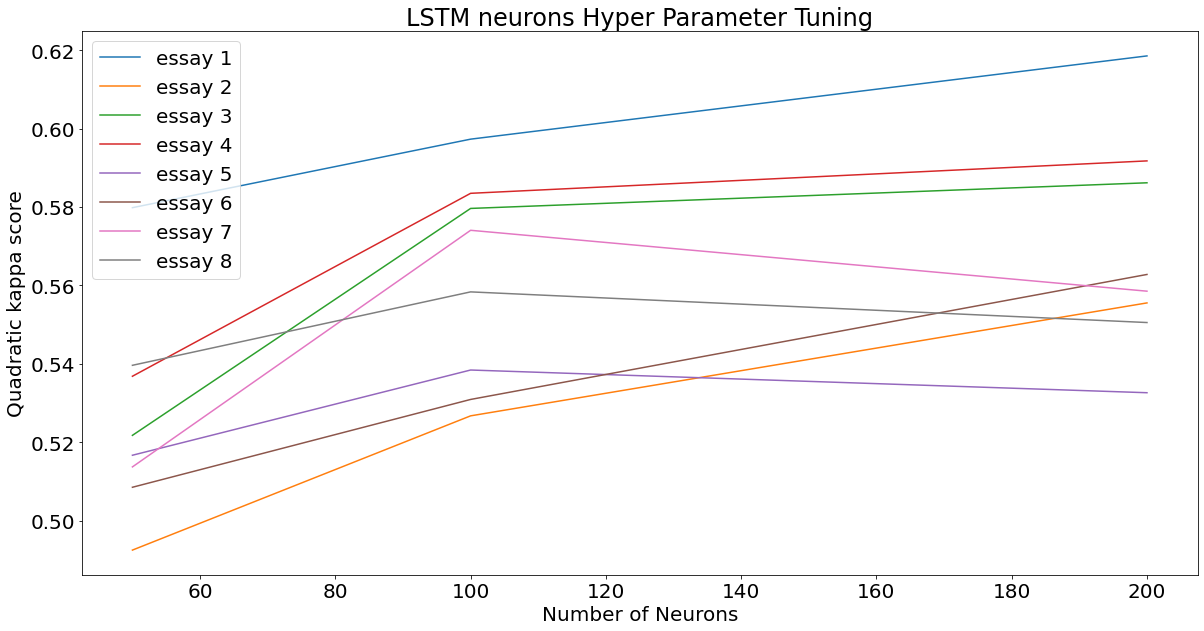

In [74]:
new_d = {}
result = []
plt.rcParams.update({'font.size': 20})
for i in range(1,9):
    new_d[str(i)] = {}
    result_array = []
    for neuron in neurons:
        new_d[str(i)][str(neuron)] = []
        for dropout in dropouts:
            new_d[str(i)][str(neuron)].append(d[str(i)][str(neuron)][str(dropout)])
        new_d[str(i)][str(neuron)] = np.mean(new_d[str(i)][str(neuron)])
        result_array.append(np.mean(new_d[str(i)][str(neuron)]))
    result.append(result_array)
fig, ax = plt.subplots(figsize = (20,10))

legends = []
for i in range(1,9):
    ax.plot(neurons, result[i-1])
    string = "essay " + str(i)
    legends.append(string)
ax.legend(legends)
ax.set_xlabel("Number of Neurons")
ax.set_ylabel("Quadratic kappa score")
ax.set_title("LSTM neurons Hyper Parameter Tuning")
fig.savefig("lstm_neurons_hyperparameter_tuning.png")

In [76]:
print("Essay set " + str(1))
print(d[str(1)]["200"]["0.2"])
print("Essay set " + str(2))
print(d[str(2)]["200"]["0.2"])
print("Essay set " + str(3))
print(d[str(3)]["200"]["0.2"])
print("Essay set " + str(4))
print(d[str(4)]["200"]["0.2"])
print("Essay set " + str(5))
print(d[str(5)]["100"]["0.2"])
print("Essay set " + str(6))
print(d[str(6)]["200"]["0.2"])
print("Essay set " + str(7))
print(d[str(7)]["100"]["0.2"])
print("Essay set " + str(8))
print(d[str(8)]["100"]["0.2"])

print("average of all")
print(np.mean([d[str(2)]["200"]["0.2"],d[str(2)]["200"]["0.2"], d[str(3)]["200"]["0.2"], d[str(4)]["200"]["0.2"], d[str(5)]["100"]["0.2"], d[str(6)]["200"]["0.2"],  d[str(7)]["100"]["0.2"], d[str(8)]["100"]["0.2"] ]))

Essay set 1
0.7963777815429541
Essay set 2
0.7042569408784093
Essay set 3
0.7483292893148542
Essay set 4
0.7292880118116293
Essay set 5
0.6858409614976178
Essay set 6
0.7247463231238779
Essay set 7
0.7319761483652668
Essay set 8
0.7302738767547257
average of all
0.7198710615780988


## FFNN SECTION

In [77]:
neurons = [65, 80, 95]
def build_model(length, neuron_number):
    model = Sequential([
        Dense(neuron_number, activation=tf.nn.relu, input_shape=[length]),
        Dense(neuron_number, activation=tf.nn.relu),
        Dense(1)
    ])
    optimizer =  tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mse",
                 optimizer=optimizer,
                 metrics=["mae","mse"])
    
    return model
  

In [7]:
cv = KFold(n_splits = 5, shuffle = True)
results = []
r2s = []
mses = []
y_pred_list = []
count = 1
d_new = {}

for num in range(1,9):
    essay_set = pd.read_csv("../dataset/cleandata_set_{}.csv".format(num))
    train_corpus = essay_set['essay']
    test_corpus = train_corpus.copy()
    vocab = CountVectorizer(stop_words='english', lowercase= True).fit(train_corpus)

    # generate counts for a new set of documents
    doc_emb = vocab.transform(train_corpus)
    
    vec_size = 50
    window=2
    min_count=1
    workers=8
    epochs=40
    essays = [TaggedDocument(gensim.utils.simple_preprocess(doc), [i]) for i, doc in enumerate(train_corpus)]
    
    model = Doc2Vec(essays, vector_size=vec_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
    #might not need this line
    model.train(essays, total_examples=model.corpus_count, epochs=model.epochs)
    doc = [gensim.utils.simple_preprocess(doc) for i, doc in enumerate(test_corpus)]

    doc_emb = np.zeros((len(doc), vec_size))
    for i in range(len(doc)):
        doc_emb[i,:] = model.infer_vector(doc[i])
        
    df_train = pd.DataFrame(doc_emb)
    df_train = pd.concat([df_train, df[["essay_set", "word_count","Mistakes","reading_ease"]]], axis = 1, join = "inner")
    
    y = df["total_score"]
    X = df_train
    print("\n###########Set-{}###########\n".format(num))
    d_new[str(num)] = {}
    for neuron in neurons:
        count = 1
        result_for_set = []
        for traincv, testcv in cv.split(X):
            print("\n--------Fold {}--------\n".format(count))

            X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
            X_train = X_train.to_numpy()
            X_test = X_test.to_numpy()

            #X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
            #X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

            early_stop = EarlyStopping(monitor="val_loss", patience=100)

            lstm_model = build_model(len(X_train[0]), neuron)
            lstm_model.fit(X_train, y_train, validation_split=0.2, epochs=1000, batch_size=32,callbacks=[early_stop])

            y_pred_temp = lstm_model.predict(X_test)

            y_pred = []
            for i in y_pred_temp:
                y_pred.append(int(round(i[0])))
            y_pred_temp = np.around(y_pred_temp)
            if count == 5:
                 lstm_model.save_weights('final_lstm.h5')
            y_test_new = []
            for  i in list(y_test.array):
                y_test_new.append(int(i))
            result = cohen_kappa_score(y_test_new,y_pred,weights='quadratic')
            print("Kappa Score: {}".format(result))
            result_for_set.append(result)
            count += 1
        d_new[str(num)][str(neuron)] = result_for_set


###########Set-1###########


--------Fold 1--------

Epoch 1/1000
36/36 [==============================] - 0s 3ms/step - loss: 197.3159 - mae: 6.4822 - mse: 197.3159 - val_loss: 23.4521 - val_mae: 4.2399 - val_mse: 23.4521
Epoch 2/1000
36/36 [==============================] - 0s 803us/step - loss: 21.7044 - mae: 4.0701 - mse: 21.7044 - val_loss: 10.3648 - val_mae: 2.8119 - val_mse: 10.3648
Epoch 3/1000
36/36 [==============================] - 0s 803us/step - loss: 19.2464 - mae: 3.4279 - mse: 19.2464 - val_loss: 16.3808 - val_mae: 3.7948 - val_mse: 16.3808
Epoch 4/1000
36/36 [==============================] - 0s 831us/step - loss: 17.2487 - mae: 3.3919 - mse: 17.2487 - val_loss: 41.3808 - val_mae: 6.1604 - val_mse: 41.3808
Epoch 5/1000
36/36 [==============================] - 0s 803us/step - loss: 18.1264 - mae: 3.6713 - mse: 18.1264 - val_loss: 3.4968 - val_mae: 1.6076 - val_mse: 3.4968
Epoch 6/1000
36/36 [==============================] - 0s 831us/step - loss: 13.3556 - mae: 2.7234

36/36 [==============================] - 0s 831us/step - loss: 0.9738 - mae: 0.7678 - mse: 0.9738 - val_loss: 1.6796 - val_mae: 1.0880 - val_mse: 1.6796
Epoch 99/1000
36/36 [==============================] - 0s 859us/step - loss: 0.7865 - mae: 0.6882 - mse: 0.7865 - val_loss: 0.7002 - val_mae: 0.6531 - val_mse: 0.7002
Epoch 100/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8726 - mae: 0.7329 - mse: 0.8726 - val_loss: 1.8864 - val_mae: 1.1420 - val_mse: 1.8864
Epoch 101/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8452 - mae: 0.7296 - mse: 0.8452 - val_loss: 0.7203 - val_mae: 0.6679 - val_mse: 0.7203
Epoch 102/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8668 - mae: 0.7235 - mse: 0.8668 - val_loss: 0.8087 - val_mae: 0.7079 - val_mse: 0.8087
Epoch 103/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8234 - mae: 0.7059 - mse: 0.8234 - val_loss: 0.8076 - val_mae: 0.6913 - val_mse: 0.8076
Epoch 10

Epoch 47/1000
36/36 [==============================] - 0s 748us/step - loss: 1.1850 - mae: 0.8489 - mse: 1.1850 - val_loss: 1.0042 - val_mae: 0.7920 - val_mse: 1.0042
Epoch 48/1000
36/36 [==============================] - 0s 748us/step - loss: 1.1541 - mae: 0.8506 - mse: 1.1541 - val_loss: 2.0230 - val_mae: 1.2129 - val_mse: 2.0230
Epoch 49/1000
36/36 [==============================] - 0s 748us/step - loss: 1.0651 - mae: 0.8174 - mse: 1.0651 - val_loss: 1.6882 - val_mae: 1.0853 - val_mse: 1.6882
Epoch 50/1000
36/36 [==============================] - 0s 831us/step - loss: 1.0714 - mae: 0.8035 - mse: 1.0714 - val_loss: 3.2262 - val_mae: 1.5866 - val_mse: 3.2262
Epoch 51/1000
36/36 [==============================] - 0s 748us/step - loss: 1.1539 - mae: 0.8402 - mse: 1.1539 - val_loss: 0.9913 - val_mae: 0.7823 - val_mse: 0.9913
Epoch 52/1000
36/36 [==============================] - 0s 776us/step - loss: 1.2049 - mae: 0.8700 - mse: 1.2049 - val_loss: 0.8778 - val_mae: 0.7369 - val_mse: 0.877

Epoch 96/1000
36/36 [==============================] - 0s 736us/step - loss: 0.7671 - mae: 0.6780 - mse: 0.7671 - val_loss: 0.6665 - val_mae: 0.6622 - val_mse: 0.6665
Epoch 97/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7869 - mae: 0.6978 - mse: 0.7869 - val_loss: 1.9403 - val_mae: 1.1617 - val_mse: 1.9403
Epoch 98/1000
36/36 [==============================] - 0s 775us/step - loss: 0.7446 - mae: 0.6810 - mse: 0.7446 - val_loss: 1.0003 - val_mae: 0.7897 - val_mse: 1.0003
Epoch 99/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7826 - mae: 0.6822 - mse: 0.7826 - val_loss: 1.4359 - val_mae: 0.9845 - val_mse: 1.4359
Epoch 100/1000
36/36 [==============================] - 0s 749us/step - loss: 0.7343 - mae: 0.6618 - mse: 0.7343 - val_loss: 0.8751 - val_mae: 0.7327 - val_mse: 0.8751
Epoch 101/1000
36/36 [==============================] - 0s 749us/step - loss: 0.7106 - mae: 0.6583 - mse: 0.7106 - val_loss: 0.6477 - val_mae: 0.6427 - val_mse: 0.6

Epoch 145/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5686 - mae: 0.5854 - mse: 0.5686 - val_loss: 1.3023 - val_mae: 0.9058 - val_mse: 1.3023
Epoch 146/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5485 - mae: 0.5801 - mse: 0.5485 - val_loss: 0.6797 - val_mae: 0.6522 - val_mse: 0.6797
Epoch 147/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5651 - mae: 0.5814 - mse: 0.5651 - val_loss: 0.8163 - val_mae: 0.7149 - val_mse: 0.8163
Epoch 148/1000
36/36 [==============================] - 0s 762us/step - loss: 0.5305 - mae: 0.5668 - mse: 0.5305 - val_loss: 1.1370 - val_mae: 0.8544 - val_mse: 1.1370
Epoch 149/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5661 - mae: 0.5849 - mse: 0.5661 - val_loss: 0.7491 - val_mae: 0.6926 - val_mse: 0.7491
Epoch 150/1000
36/36 [==============================] - 0s 914us/step - loss: 0.5339 - mae: 0.5712 - mse: 0.5339 - val_loss: 0.8690 - val_mae: 0.7505 - val_mse:

36/36 [==============================] - 0s 767us/step - loss: 1.3402 - mae: 0.8991 - mse: 1.3402 - val_loss: 1.0053 - val_mae: 0.7794 - val_mse: 1.0053
Epoch 52/1000
36/36 [==============================] - 0s 776us/step - loss: 1.4356 - mae: 0.9550 - mse: 1.4356 - val_loss: 1.6211 - val_mae: 1.0499 - val_mse: 1.6211
Epoch 53/1000
36/36 [==============================] - 0s 775us/step - loss: 1.2775 - mae: 0.8971 - mse: 1.2775 - val_loss: 2.1711 - val_mae: 1.1598 - val_mse: 2.1711
Epoch 54/1000
36/36 [==============================] - 0s 776us/step - loss: 1.4138 - mae: 0.9333 - mse: 1.4138 - val_loss: 1.4854 - val_mae: 0.9620 - val_mse: 1.4854
Epoch 55/1000
36/36 [==============================] - 0s 776us/step - loss: 1.3014 - mae: 0.9073 - mse: 1.3014 - val_loss: 1.3844 - val_mae: 0.9075 - val_mse: 1.3844
Epoch 56/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1695 - mae: 0.8300 - mse: 1.1695 - val_loss: 3.2291 - val_mae: 1.5908 - val_mse: 3.2291
Epoch 57/100

Epoch 149/1000
36/36 [==============================] - 0s 831us/step - loss: 0.4469 - mae: 0.5075 - mse: 0.4469 - val_loss: 0.8398 - val_mae: 0.7171 - val_mse: 0.8398
Epoch 150/1000
36/36 [==============================] - 0s 804us/step - loss: 0.4823 - mae: 0.5306 - mse: 0.4823 - val_loss: 1.1413 - val_mae: 0.8357 - val_mse: 1.1413
Epoch 151/1000
36/36 [==============================] - 0s 830us/step - loss: 0.4769 - mae: 0.5357 - mse: 0.4769 - val_loss: 1.5707 - val_mae: 1.0021 - val_mse: 1.5707
Epoch 152/1000
36/36 [==============================] - 0s 776us/step - loss: 0.4581 - mae: 0.5238 - mse: 0.4581 - val_loss: 0.9214 - val_mae: 0.7613 - val_mse: 0.9214
Epoch 153/1000
36/36 [==============================] - 0s 803us/step - loss: 0.4733 - mae: 0.5300 - mse: 0.4733 - val_loss: 1.6532 - val_mae: 1.0415 - val_mse: 1.6532
Epoch 154/1000
36/36 [==============================] - 0s 776us/step - loss: 0.4629 - mae: 0.5213 - mse: 0.4629 - val_loss: 0.9279 - val_mae: 0.7579 - val_mse:

36/36 [==============================] - 0s 762us/step - loss: 0.8213 - mae: 0.7085 - mse: 0.8213 - val_loss: 0.8157 - val_mae: 0.7313 - val_mse: 0.8157
Epoch 63/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9110 - mae: 0.7475 - mse: 0.9110 - val_loss: 0.8421 - val_mae: 0.7072 - val_mse: 0.8421
Epoch 64/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7741 - mae: 0.6860 - mse: 0.7741 - val_loss: 0.7164 - val_mae: 0.6544 - val_mse: 0.7164
Epoch 65/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8928 - mae: 0.7304 - mse: 0.8928 - val_loss: 0.7117 - val_mae: 0.6522 - val_mse: 0.7117
Epoch 66/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7526 - mae: 0.6835 - mse: 0.7526 - val_loss: 0.8428 - val_mae: 0.7105 - val_mse: 0.8428
Epoch 67/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8833 - mae: 0.7280 - mse: 0.8833 - val_loss: 0.8241 - val_mae: 0.6976 - val_mse: 0.8241
Epoch 68/100

36/36 [==============================] - 0s 776us/step - loss: 0.5565 - mae: 0.5822 - mse: 0.5565 - val_loss: 1.3803 - val_mae: 0.9494 - val_mse: 1.3803
Epoch 112/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6245 - mae: 0.6156 - mse: 0.6245 - val_loss: 0.8096 - val_mae: 0.7310 - val_mse: 0.8096
Epoch 113/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5641 - mae: 0.5768 - mse: 0.5641 - val_loss: 0.7188 - val_mae: 0.6796 - val_mse: 0.7188
Epoch 114/1000
36/36 [==============================] - 0s 775us/step - loss: 0.5628 - mae: 0.5760 - mse: 0.5628 - val_loss: 0.7448 - val_mae: 0.6912 - val_mse: 0.7448
Epoch 115/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5855 - mae: 0.5959 - mse: 0.5855 - val_loss: 0.7418 - val_mae: 0.7026 - val_mse: 0.7418
Epoch 116/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5735 - mae: 0.5828 - mse: 0.5735 - val_loss: 0.8727 - val_mae: 0.7349 - val_mse: 0.8727
Epoch 1

36/36 [==============================] - 0s 748us/step - loss: 2.7867 - mae: 1.3704 - mse: 2.7867 - val_loss: 1.3487 - val_mae: 0.9398 - val_mse: 1.3487
Epoch 28/1000
36/36 [==============================] - 0s 748us/step - loss: 2.4939 - mae: 1.2527 - mse: 2.4939 - val_loss: 5.4918 - val_mae: 2.0644 - val_mse: 5.4918
Epoch 29/1000
36/36 [==============================] - 0s 748us/step - loss: 2.5428 - mae: 1.2527 - mse: 2.5428 - val_loss: 1.2560 - val_mae: 0.9075 - val_mse: 1.2560
Epoch 30/1000
36/36 [==============================] - 0s 748us/step - loss: 2.5405 - mae: 1.2709 - mse: 2.5405 - val_loss: 0.9749 - val_mae: 0.7712 - val_mse: 0.9749
Epoch 31/1000
36/36 [==============================] - 0s 776us/step - loss: 2.2295 - mae: 1.1411 - mse: 2.2295 - val_loss: 1.8070 - val_mae: 1.0849 - val_mse: 1.8070
Epoch 32/1000
36/36 [==============================] - 0s 748us/step - loss: 2.2465 - mae: 1.1728 - mse: 2.2465 - val_loss: 1.1314 - val_mae: 0.8413 - val_mse: 1.1314
Epoch 33/100

36/36 [==============================] - 0s 831us/step - loss: 0.5620 - mae: 0.5802 - mse: 0.5620 - val_loss: 0.7154 - val_mae: 0.6659 - val_mse: 0.7154
Epoch 126/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5749 - mae: 0.5918 - mse: 0.5749 - val_loss: 1.8645 - val_mae: 1.1258 - val_mse: 1.8645
Epoch 127/1000
36/36 [==============================] - 0s 795us/step - loss: 0.5798 - mae: 0.5991 - mse: 0.5798 - val_loss: 0.7004 - val_mae: 0.6495 - val_mse: 0.7004
Epoch 128/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5337 - mae: 0.5695 - mse: 0.5337 - val_loss: 0.7887 - val_mae: 0.6785 - val_mse: 0.7887
Epoch 129/1000
36/36 [==============================] - 0s 748us/step - loss: 0.6194 - mae: 0.6026 - mse: 0.6194 - val_loss: 0.7055 - val_mae: 0.6449 - val_mse: 0.7055
Epoch 130/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5167 - mae: 0.5547 - mse: 0.5167 - val_loss: 0.8361 - val_mae: 0.7083 - val_mse: 0.8361
Epoch 1

Epoch 174/1000
36/36 [==============================] - 0s 886us/step - loss: 0.4523 - mae: 0.5240 - mse: 0.4523 - val_loss: 0.8689 - val_mae: 0.7319 - val_mse: 0.8689
Epoch 175/1000
36/36 [==============================] - 0s 831us/step - loss: 0.4324 - mae: 0.5073 - mse: 0.4324 - val_loss: 1.0725 - val_mae: 0.8329 - val_mse: 1.0725
Epoch 176/1000
36/36 [==============================] - 0s 789us/step - loss: 0.4500 - mae: 0.5272 - mse: 0.4500 - val_loss: 0.8214 - val_mae: 0.7030 - val_mse: 0.8214
Epoch 177/1000
36/36 [==============================] - 0s 803us/step - loss: 0.4179 - mae: 0.5023 - mse: 0.4179 - val_loss: 0.8727 - val_mae: 0.7017 - val_mse: 0.8727
Epoch 178/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4283 - mae: 0.5058 - mse: 0.4283 - val_loss: 0.9219 - val_mae: 0.7664 - val_mse: 0.9219
Epoch 179/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4264 - mae: 0.4944 - mse: 0.4264 - val_loss: 0.9017 - val_mae: 0.7541 - val_mse:

36/36 [==============================] - 0s 889us/step - loss: 0.7135 - mae: 0.6538 - mse: 0.7135 - val_loss: 1.0711 - val_mae: 0.8112 - val_mse: 1.0711
Epoch 93/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7007 - mae: 0.6579 - mse: 0.7007 - val_loss: 1.0235 - val_mae: 0.7858 - val_mse: 1.0235
Epoch 94/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7198 - mae: 0.6545 - mse: 0.7198 - val_loss: 0.8757 - val_mae: 0.7442 - val_mse: 0.8757
Epoch 95/1000
36/36 [==============================] - 0s 804us/step - loss: 0.7511 - mae: 0.6820 - mse: 0.7511 - val_loss: 0.7285 - val_mae: 0.6560 - val_mse: 0.7285
Epoch 96/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6871 - mae: 0.6390 - mse: 0.6871 - val_loss: 0.6935 - val_mae: 0.6420 - val_mse: 0.6935
Epoch 97/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6945 - mae: 0.6564 - mse: 0.6945 - val_loss: 0.8906 - val_mae: 0.7471 - val_mse: 0.8906
Epoch 98/100

Epoch 141/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5131 - mae: 0.5501 - mse: 0.5131 - val_loss: 0.8562 - val_mae: 0.7127 - val_mse: 0.8562
Epoch 142/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5190 - mae: 0.5509 - mse: 0.5190 - val_loss: 0.9150 - val_mae: 0.7424 - val_mse: 0.9150
Epoch 143/1000
36/36 [==============================] - 0s 776us/step - loss: 0.4997 - mae: 0.5459 - mse: 0.4997 - val_loss: 0.9364 - val_mae: 0.7402 - val_mse: 0.9364
Epoch 144/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5425 - mae: 0.5602 - mse: 0.5425 - val_loss: 1.0088 - val_mae: 0.7766 - val_mse: 1.0088
Epoch 145/1000
36/36 [==============================] - 0s 831us/step - loss: 0.4693 - mae: 0.5283 - mse: 0.4693 - val_loss: 0.9102 - val_mae: 0.7381 - val_mse: 0.9102
Epoch 146/1000
36/36 [==============================] - 0s 886us/step - loss: 0.5051 - mae: 0.5519 - mse: 0.5051 - val_loss: 0.8489 - val_mae: 0.7136 - val_mse:

36/36 [==============================] - 0s 775us/step - loss: 1.2128 - mae: 0.8691 - mse: 1.2128 - val_loss: 0.6442 - val_mae: 0.6404 - val_mse: 0.6442
Epoch 60/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.0351 - mae: 0.7793 - mse: 1.0351 - val_loss: 0.7137 - val_mae: 0.6695 - val_mse: 0.7137
Epoch 61/1000
36/36 [==============================] - 0s 887us/step - loss: 1.0423 - mae: 0.8077 - mse: 1.0423 - val_loss: 0.6672 - val_mae: 0.6483 - val_mse: 0.6672
Epoch 62/1000
36/36 [==============================] - 0s 997us/step - loss: 0.9811 - mae: 0.7806 - mse: 0.9811 - val_loss: 0.9244 - val_mae: 0.7687 - val_mse: 0.9244
Epoch 63/1000
36/36 [==============================] - 0s 859us/step - loss: 1.0452 - mae: 0.8031 - mse: 1.0452 - val_loss: 1.3772 - val_mae: 0.9682 - val_mse: 1.3772
Epoch 64/1000
36/36 [==============================] - 0s 831us/step - loss: 0.9684 - mae: 0.7690 - mse: 0.9684 - val_loss: 2.5549 - val_mae: 1.3796 - val_mse: 2.5549
Epoch 65/1000


Epoch 157/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5302 - mae: 0.5547 - mse: 0.5302 - val_loss: 0.8020 - val_mae: 0.7137 - val_mse: 0.8020
Epoch 158/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4972 - mae: 0.5387 - mse: 0.4972 - val_loss: 0.6464 - val_mae: 0.6534 - val_mse: 0.6464
Epoch 159/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4773 - mae: 0.5275 - mse: 0.4773 - val_loss: 1.4065 - val_mae: 0.9872 - val_mse: 1.4065
Epoch 160/1000
36/36 [==============================] - 0s 808us/step - loss: 0.5434 - mae: 0.5616 - mse: 0.5434 - val_loss: 0.6408 - val_mae: 0.6526 - val_mse: 0.6408
Epoch 161/1000
36/36 [==============================] - 0s 776us/step - loss: 0.4829 - mae: 0.5324 - mse: 0.4829 - val_loss: 0.8665 - val_mae: 0.7581 - val_mse: 0.8665
Epoch 162/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5088 - mae: 0.5487 - mse: 0.5088 - val_loss: 0.6840 - val_mae: 0.6651 - val_mse:

Epoch 51/1000
36/36 [==============================] - 0s 829us/step - loss: 1.8208 - mae: 1.0777 - mse: 1.8208 - val_loss: 0.8690 - val_mae: 0.7252 - val_mse: 0.8690
Epoch 52/1000
36/36 [==============================] - 0s 775us/step - loss: 1.5697 - mae: 0.9721 - mse: 1.5697 - val_loss: 1.3363 - val_mae: 0.9351 - val_mse: 1.3363
Epoch 53/1000
36/36 [==============================] - 0s 748us/step - loss: 1.6152 - mae: 1.0060 - mse: 1.6152 - val_loss: 1.9337 - val_mae: 1.1763 - val_mse: 1.9337
Epoch 54/1000
36/36 [==============================] - 0s 748us/step - loss: 1.4288 - mae: 0.9508 - mse: 1.4288 - val_loss: 0.9642 - val_mae: 0.7783 - val_mse: 0.9642
Epoch 55/1000
36/36 [==============================] - 0s 764us/step - loss: 1.4748 - mae: 0.9633 - mse: 1.4748 - val_loss: 3.5104 - val_mae: 1.6696 - val_mse: 3.5104
Epoch 56/1000
36/36 [==============================] - 0s 776us/step - loss: 1.4749 - mae: 0.9500 - mse: 1.4749 - val_loss: 1.1256 - val_mae: 0.8388 - val_mse: 1.125

36/36 [==============================] - 0s 770us/step - loss: 0.7637 - mae: 0.6793 - mse: 0.7637 - val_loss: 0.7692 - val_mae: 0.6940 - val_mse: 0.7692
Epoch 101/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7338 - mae: 0.6598 - mse: 0.7338 - val_loss: 0.7993 - val_mae: 0.7116 - val_mse: 0.7993
Epoch 102/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7425 - mae: 0.6775 - mse: 0.7425 - val_loss: 0.7692 - val_mae: 0.6944 - val_mse: 0.7692
Epoch 103/1000
36/36 [==============================] - 0s 775us/step - loss: 0.7371 - mae: 0.6671 - mse: 0.7371 - val_loss: 0.9828 - val_mae: 0.7851 - val_mse: 0.9828
Epoch 104/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7257 - mae: 0.6652 - mse: 0.7257 - val_loss: 0.7202 - val_mae: 0.6680 - val_mse: 0.7202
Epoch 105/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7102 - mae: 0.6510 - mse: 0.7102 - val_loss: 0.8618 - val_mae: 0.7124 - val_mse: 0.8618
Epoch 1

Epoch 149/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5552 - mae: 0.5645 - mse: 0.5552 - val_loss: 0.8725 - val_mae: 0.7476 - val_mse: 0.8725
Epoch 150/1000
36/36 [==============================] - 0s 775us/step - loss: 0.5745 - mae: 0.5800 - mse: 0.5745 - val_loss: 1.1042 - val_mae: 0.8464 - val_mse: 1.1042
Epoch 151/1000
36/36 [==============================] - 0s 830us/step - loss: 0.5720 - mae: 0.5775 - mse: 0.5720 - val_loss: 0.9196 - val_mae: 0.7637 - val_mse: 0.9196
Epoch 152/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5432 - mae: 0.5639 - mse: 0.5432 - val_loss: 0.7478 - val_mae: 0.6794 - val_mse: 0.7478
Epoch 153/1000
36/36 [==============================] - 0s 804us/step - loss: 0.5323 - mae: 0.5534 - mse: 0.5323 - val_loss: 0.9201 - val_mae: 0.7525 - val_mse: 0.9201
Epoch 154/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5549 - mae: 0.5693 - mse: 0.5549 - val_loss: 0.9759 - val_mae: 0.7751 - val_mse:

Epoch 29/1000
36/36 [==============================] - 0s 831us/step - loss: 2.4580 - mae: 1.2350 - mse: 2.4580 - val_loss: 1.0003 - val_mae: 0.7842 - val_mse: 1.0003
Epoch 30/1000
36/36 [==============================] - 0s 803us/step - loss: 2.1516 - mae: 1.1829 - mse: 2.1516 - val_loss: 0.7658 - val_mae: 0.6895 - val_mse: 0.7658
Epoch 31/1000
36/36 [==============================] - 0s 803us/step - loss: 2.5674 - mae: 1.2620 - mse: 2.5674 - val_loss: 1.2290 - val_mae: 0.8763 - val_mse: 1.2290
Epoch 32/1000
36/36 [==============================] - 0s 776us/step - loss: 2.1280 - mae: 1.1558 - mse: 2.1280 - val_loss: 0.7064 - val_mae: 0.6555 - val_mse: 0.7064
Epoch 33/1000
36/36 [==============================] - 0s 804us/step - loss: 2.0654 - mae: 1.1128 - mse: 2.0654 - val_loss: 0.7397 - val_mae: 0.6639 - val_mse: 0.7397
Epoch 34/1000
36/36 [==============================] - 0s 747us/step - loss: 1.9579 - mae: 1.1118 - mse: 1.9579 - val_loss: 5.8058 - val_mae: 2.1908 - val_mse: 5.805

36/36 [==============================] - 0s 831us/step - loss: 0.7305 - mae: 0.6579 - mse: 0.7305 - val_loss: 1.4236 - val_mae: 0.9642 - val_mse: 1.4236
Epoch 79/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7255 - mae: 0.6545 - mse: 0.7255 - val_loss: 0.7448 - val_mae: 0.6621 - val_mse: 0.7448
Epoch 80/1000
36/36 [==============================] - 0s 797us/step - loss: 0.7436 - mae: 0.6771 - mse: 0.7436 - val_loss: 0.7642 - val_mae: 0.6836 - val_mse: 0.7642
Epoch 81/1000
36/36 [==============================] - 0s 775us/step - loss: 0.7320 - mae: 0.6566 - mse: 0.7320 - val_loss: 0.7288 - val_mae: 0.6633 - val_mse: 0.7288
Epoch 82/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6935 - mae: 0.6503 - mse: 0.6935 - val_loss: 0.7539 - val_mae: 0.6605 - val_mse: 0.7539
Epoch 83/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7084 - mae: 0.6511 - mse: 0.7084 - val_loss: 1.0050 - val_mae: 0.8097 - val_mse: 1.0050
Epoch 84/1000


Epoch 127/1000
36/36 [==============================] - 0s 832us/step - loss: 0.5627 - mae: 0.5792 - mse: 0.5627 - val_loss: 0.9308 - val_mae: 0.7489 - val_mse: 0.9308
Epoch 128/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5451 - mae: 0.5721 - mse: 0.5451 - val_loss: 0.8308 - val_mae: 0.7212 - val_mse: 0.8308
Epoch 129/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5223 - mae: 0.5582 - mse: 0.5223 - val_loss: 0.7831 - val_mae: 0.6920 - val_mse: 0.7831
Epoch 130/1000
36/36 [==============================] - 0s 887us/step - loss: 0.5365 - mae: 0.5629 - mse: 0.5365 - val_loss: 0.8783 - val_mae: 0.7232 - val_mse: 0.8783
Epoch 131/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5261 - mae: 0.5608 - mse: 0.5261 - val_loss: 0.9073 - val_mae: 0.7557 - val_mse: 0.9073
Epoch 132/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5369 - mae: 0.5642 - mse: 0.5369 - val_loss: 0.8035 - val_mae: 0.6957 - val_mse:

36/36 [==============================] - 0s 748us/step - loss: 0.9015 - mae: 0.7370 - mse: 0.9015 - val_loss: 2.1131 - val_mae: 1.2085 - val_mse: 2.1131
Epoch 70/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9214 - mae: 0.7571 - mse: 0.9214 - val_loss: 1.1739 - val_mae: 0.8844 - val_mse: 1.1739
Epoch 71/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9002 - mae: 0.7413 - mse: 0.9002 - val_loss: 0.9820 - val_mae: 0.7861 - val_mse: 0.9820
Epoch 72/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8906 - mae: 0.7491 - mse: 0.8906 - val_loss: 1.0679 - val_mae: 0.8214 - val_mse: 1.0679
Epoch 73/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9034 - mae: 0.7437 - mse: 0.9034 - val_loss: 0.6887 - val_mae: 0.6551 - val_mse: 0.6887
Epoch 74/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8674 - mae: 0.7288 - mse: 0.8674 - val_loss: 0.7093 - val_mae: 0.6662 - val_mse: 0.7093
Epoch 75/100

36/36 [==============================] - 0s 776us/step - loss: 0.5477 - mae: 0.5793 - mse: 0.5477 - val_loss: 0.7027 - val_mae: 0.6566 - val_mse: 0.7027
Epoch 119/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5803 - mae: 0.5848 - mse: 0.5803 - val_loss: 0.7856 - val_mae: 0.6949 - val_mse: 0.7856
Epoch 120/1000
36/36 [==============================] - 0s 804us/step - loss: 0.5325 - mae: 0.5776 - mse: 0.5325 - val_loss: 0.7365 - val_mae: 0.6749 - val_mse: 0.7365
Epoch 121/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5902 - mae: 0.5966 - mse: 0.5902 - val_loss: 0.9272 - val_mae: 0.7764 - val_mse: 0.9272
Epoch 122/1000
36/36 [==============================] - 0s 775us/step - loss: 0.5608 - mae: 0.5800 - mse: 0.5608 - val_loss: 0.7677 - val_mae: 0.7012 - val_mse: 0.7677
Epoch 123/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5382 - mae: 0.5661 - mse: 0.5382 - val_loss: 0.8979 - val_mae: 0.7667 - val_mse: 0.8979
Epoch 1

Epoch 167/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4216 - mae: 0.4986 - mse: 0.4216 - val_loss: 0.7991 - val_mae: 0.6983 - val_mse: 0.7991
Epoch 168/1000
36/36 [==============================] - 0s 772us/step - loss: 0.4723 - mae: 0.5348 - mse: 0.4723 - val_loss: 0.7661 - val_mae: 0.6878 - val_mse: 0.7661
Epoch 169/1000
36/36 [==============================] - 0s 775us/step - loss: 0.4205 - mae: 0.5018 - mse: 0.4205 - val_loss: 1.1389 - val_mae: 0.8545 - val_mse: 1.1389
Epoch 170/1000
36/36 [==============================] - 0s 720us/step - loss: 0.4391 - mae: 0.5133 - mse: 0.4391 - val_loss: 1.0259 - val_mae: 0.8053 - val_mse: 1.0259
Epoch 171/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4378 - mae: 0.5128 - mse: 0.4378 - val_loss: 0.8071 - val_mae: 0.7132 - val_mse: 0.8071
Epoch 172/1000
36/36 [==============================] - 0s 772us/step - loss: 0.4196 - mae: 0.5044 - mse: 0.4196 - val_loss: 0.8308 - val_mae: 0.7213 - val_mse:

36/36 [==============================] - 0s 776us/step - loss: 0.9923 - mae: 0.7740 - mse: 0.9923 - val_loss: 1.8384 - val_mae: 1.1514 - val_mse: 1.8384
Epoch 76/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9240 - mae: 0.7485 - mse: 0.9240 - val_loss: 0.8360 - val_mae: 0.7310 - val_mse: 0.8360
Epoch 77/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8505 - mae: 0.7189 - mse: 0.8505 - val_loss: 0.6546 - val_mae: 0.6429 - val_mse: 0.6546
Epoch 78/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9863 - mae: 0.7664 - mse: 0.9863 - val_loss: 0.7900 - val_mae: 0.7086 - val_mse: 0.7900
Epoch 79/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9177 - mae: 0.7408 - mse: 0.9177 - val_loss: 0.6822 - val_mae: 0.6544 - val_mse: 0.6822
Epoch 80/1000
36/36 [==============================] - 0s 886us/step - loss: 0.8578 - mae: 0.7125 - mse: 0.8578 - val_loss: 0.6868 - val_mae: 0.6532 - val_mse: 0.6868
Epoch 81/100

Epoch 124/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6469 - mae: 0.6128 - mse: 0.6469 - val_loss: 0.7099 - val_mae: 0.6701 - val_mse: 0.7099
Epoch 125/1000
36/36 [==============================] - 0s 831us/step - loss: 0.6335 - mae: 0.6162 - mse: 0.6335 - val_loss: 0.7493 - val_mae: 0.6911 - val_mse: 0.7493
Epoch 126/1000
36/36 [==============================] - 0s 886us/step - loss: 0.6407 - mae: 0.6188 - mse: 0.6407 - val_loss: 1.1392 - val_mae: 0.8579 - val_mse: 1.1392
Epoch 127/1000
36/36 [==============================] - 0s 859us/step - loss: 0.6872 - mae: 0.6338 - mse: 0.6872 - val_loss: 0.6987 - val_mae: 0.6702 - val_mse: 0.6987
Epoch 128/1000
36/36 [==============================] - 0s 831us/step - loss: 0.6308 - mae: 0.6119 - mse: 0.6308 - val_loss: 0.6671 - val_mae: 0.6552 - val_mse: 0.6671
Epoch 129/1000
36/36 [==============================] - 0s 804us/step - loss: 0.6102 - mae: 0.5954 - mse: 0.6102 - val_loss: 0.6874 - val_mae: 0.6650 - val_mse:

36/36 [==============================] - 0s 803us/step - loss: 1.0219 - mae: 0.7935 - mse: 1.0219 - val_loss: 0.8144 - val_mae: 0.6990 - val_mse: 0.8144
Epoch 53/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9040 - mae: 0.7601 - mse: 0.9040 - val_loss: 0.6786 - val_mae: 0.6519 - val_mse: 0.6786
Epoch 54/1000
36/36 [==============================] - 0s 776us/step - loss: 1.0011 - mae: 0.7841 - mse: 1.0011 - val_loss: 1.6311 - val_mae: 1.0712 - val_mse: 1.6311
Epoch 55/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8358 - mae: 0.7230 - mse: 0.8358 - val_loss: 1.0772 - val_mae: 0.8315 - val_mse: 1.0772
Epoch 56/1000
36/36 [==============================] - 0s 794us/step - loss: 0.9483 - mae: 0.7678 - mse: 0.9483 - val_loss: 0.7037 - val_mae: 0.6498 - val_mse: 0.7037
Epoch 57/1000
36/36 [==============================] - 0s 831us/step - loss: 0.9357 - mae: 0.7558 - mse: 0.9357 - val_loss: 0.6759 - val_mae: 0.6467 - val_mse: 0.6759
Epoch 58/100

Epoch 101/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6456 - mae: 0.6257 - mse: 0.6456 - val_loss: 0.6839 - val_mae: 0.6436 - val_mse: 0.6839
Epoch 102/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5481 - mae: 0.5726 - mse: 0.5481 - val_loss: 0.8345 - val_mae: 0.7025 - val_mse: 0.8345
Epoch 103/1000
36/36 [==============================] - 0s 859us/step - loss: 0.6343 - mae: 0.6230 - mse: 0.6343 - val_loss: 0.9886 - val_mae: 0.7700 - val_mse: 0.9886
Epoch 104/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5977 - mae: 0.6006 - mse: 0.5977 - val_loss: 1.4656 - val_mae: 0.9961 - val_mse: 1.4656
Epoch 105/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5797 - mae: 0.6017 - mse: 0.5797 - val_loss: 1.0010 - val_mae: 0.8031 - val_mse: 1.0010
Epoch 106/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5773 - mae: 0.5915 - mse: 0.5773 - val_loss: 0.6616 - val_mae: 0.6301 - val_mse:

Epoch 150/1000
36/36 [==============================] - 0s 859us/step - loss: 0.4615 - mae: 0.5268 - mse: 0.4615 - val_loss: 1.2875 - val_mae: 0.8861 - val_mse: 1.2875
Epoch 151/1000
36/36 [==============================] - 0s 803us/step - loss: 0.4314 - mae: 0.5166 - mse: 0.4314 - val_loss: 0.7338 - val_mae: 0.6558 - val_mse: 0.7338
Epoch 152/1000
36/36 [==============================] - 0s 858us/step - loss: 0.4398 - mae: 0.5045 - mse: 0.4398 - val_loss: 0.7832 - val_mae: 0.6831 - val_mse: 0.7832
Epoch 153/1000
36/36 [==============================] - 0s 942us/step - loss: 0.4291 - mae: 0.4974 - mse: 0.4291 - val_loss: 0.9121 - val_mae: 0.7449 - val_mse: 0.9121
Epoch 154/1000
36/36 [==============================] - 0s 831us/step - loss: 0.4244 - mae: 0.4987 - mse: 0.4244 - val_loss: 0.9762 - val_mae: 0.7973 - val_mse: 0.9762
Epoch 155/1000
36/36 [==============================] - 0s 803us/step - loss: 0.4319 - mae: 0.5082 - mse: 0.4319 - val_loss: 0.8461 - val_mae: 0.7292 - val_mse:

36/36 [==============================] - 0s 803us/step - loss: 0.8865 - mae: 0.7298 - mse: 0.8865 - val_loss: 0.8063 - val_mae: 0.7227 - val_mse: 0.8063
Epoch 71/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8592 - mae: 0.7150 - mse: 0.8592 - val_loss: 0.7433 - val_mae: 0.6855 - val_mse: 0.7433
Epoch 72/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8148 - mae: 0.7032 - mse: 0.8148 - val_loss: 0.9440 - val_mae: 0.7548 - val_mse: 0.9440
Epoch 73/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7618 - mae: 0.6800 - mse: 0.7618 - val_loss: 0.7203 - val_mae: 0.6752 - val_mse: 0.7203
Epoch 74/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8704 - mae: 0.7149 - mse: 0.8704 - val_loss: 0.8479 - val_mae: 0.7186 - val_mse: 0.8479
Epoch 75/1000
36/36 [==============================] - 0s 804us/step - loss: 0.7630 - mae: 0.6752 - mse: 0.7630 - val_loss: 0.7251 - val_mae: 0.6776 - val_mse: 0.7251
Epoch 76/100

Epoch 119/1000
36/36 [==============================] - 0s 970us/step - loss: 0.5906 - mae: 0.5748 - mse: 0.5906 - val_loss: 0.8250 - val_mae: 0.7232 - val_mse: 0.8250
Epoch 120/1000
36/36 [==============================] - 0s 887us/step - loss: 0.5393 - mae: 0.5632 - mse: 0.5393 - val_loss: 0.9525 - val_mae: 0.7647 - val_mse: 0.9525
Epoch 121/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5538 - mae: 0.5795 - mse: 0.5538 - val_loss: 0.7894 - val_mae: 0.6828 - val_mse: 0.7894
Epoch 122/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5498 - mae: 0.5633 - mse: 0.5498 - val_loss: 0.7757 - val_mae: 0.6855 - val_mse: 0.7757
Epoch 123/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5376 - mae: 0.5614 - mse: 0.5376 - val_loss: 0.8620 - val_mae: 0.7539 - val_mse: 0.8620
Epoch 124/1000
36/36 [==============================] - 0s 773us/step - loss: 0.5399 - mae: 0.5663 - mse: 0.5399 - val_loss: 0.7936 - val_mae: 0.7007 - val_mse:

36/36 [==============================] - 0s 791us/step - loss: 1.1936 - mae: 0.8511 - mse: 1.1936 - val_loss: 0.6870 - val_mae: 0.6553 - val_mse: 0.6870
Epoch 60/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1380 - mae: 0.8372 - mse: 1.1380 - val_loss: 1.3008 - val_mae: 0.9406 - val_mse: 1.3008
Epoch 61/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1756 - mae: 0.8402 - mse: 1.1756 - val_loss: 1.3774 - val_mae: 0.9533 - val_mse: 1.3774
Epoch 62/1000
36/36 [==============================] - 0s 803us/step - loss: 1.1928 - mae: 0.8479 - mse: 1.1928 - val_loss: 1.4732 - val_mae: 0.9954 - val_mse: 1.4732
Epoch 63/1000
36/36 [==============================] - 0s 830us/step - loss: 1.1225 - mae: 0.8197 - mse: 1.1225 - val_loss: 0.7017 - val_mae: 0.6702 - val_mse: 0.7017
Epoch 64/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.9651 - mae: 0.7626 - mse: 0.9651 - val_loss: 2.0934 - val_mae: 1.2217 - val_mse: 2.0934
Epoch 65/1000


Epoch 108/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6953 - mae: 0.6417 - mse: 0.6953 - val_loss: 1.0735 - val_mae: 0.7859 - val_mse: 1.0735
Epoch 109/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6364 - mae: 0.6225 - mse: 0.6364 - val_loss: 0.7894 - val_mae: 0.7029 - val_mse: 0.7894
Epoch 110/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6599 - mae: 0.6237 - mse: 0.6599 - val_loss: 1.1978 - val_mae: 0.8349 - val_mse: 1.1978
Epoch 111/1000
36/36 [==============================] - 0s 791us/step - loss: 0.6313 - mae: 0.6191 - mse: 0.6313 - val_loss: 0.7763 - val_mae: 0.6591 - val_mse: 0.7763
Epoch 112/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6287 - mae: 0.6054 - mse: 0.6287 - val_loss: 0.7653 - val_mae: 0.6735 - val_mse: 0.7653
Epoch 113/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6459 - mae: 0.6227 - mse: 0.6459 - val_loss: 0.9312 - val_mae: 0.7802 - val_mse:

Epoch 9/1000
36/36 [==============================] - 0s 748us/step - loss: 14.5801 - mae: 2.9861 - mse: 14.5801 - val_loss: 2.8550 - val_mae: 1.4558 - val_mse: 2.8550
Epoch 10/1000
36/36 [==============================] - 0s 775us/step - loss: 12.5629 - mae: 2.6306 - mse: 12.5629 - val_loss: 1.2892 - val_mae: 0.8861 - val_mse: 1.2892
Epoch 11/1000
36/36 [==============================] - 0s 776us/step - loss: 9.9006 - mae: 2.5414 - mse: 9.9006 - val_loss: 1.0955 - val_mae: 0.7684 - val_mse: 1.0955
Epoch 12/1000
36/36 [==============================] - 0s 748us/step - loss: 10.5042 - mae: 2.4616 - mse: 10.5042 - val_loss: 6.8294 - val_mae: 2.3814 - val_mse: 6.8294
Epoch 13/1000
36/36 [==============================] - 0s 830us/step - loss: 10.2240 - mae: 2.6718 - mse: 10.2240 - val_loss: 3.3116 - val_mae: 1.5993 - val_mse: 3.3116
Epoch 14/1000
36/36 [==============================] - 0s 776us/step - loss: 7.7335 - mae: 2.1840 - mse: 7.7335 - val_loss: 1.4027 - val_mae: 0.9082 - val_mse

Epoch 58/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9695 - mae: 0.7745 - mse: 0.9695 - val_loss: 0.6667 - val_mae: 0.6353 - val_mse: 0.6667
Epoch 59/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8832 - mae: 0.7373 - mse: 0.8832 - val_loss: 1.0282 - val_mae: 0.8081 - val_mse: 1.0282
Epoch 60/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8648 - mae: 0.7230 - mse: 0.8648 - val_loss: 1.5038 - val_mae: 1.0055 - val_mse: 1.5038
Epoch 61/1000
36/36 [==============================] - 0s 792us/step - loss: 0.8676 - mae: 0.7292 - mse: 0.8676 - val_loss: 0.7634 - val_mae: 0.6731 - val_mse: 0.7634
Epoch 62/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8553 - mae: 0.7155 - mse: 0.8553 - val_loss: 0.6654 - val_mae: 0.6328 - val_mse: 0.6654
Epoch 63/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8055 - mae: 0.7001 - mse: 0.8055 - val_loss: 1.4362 - val_mae: 0.9987 - val_mse: 1.436

36/36 [==============================] - 0s 775us/step - loss: 0.5883 - mae: 0.5939 - mse: 0.5883 - val_loss: 0.6777 - val_mae: 0.6419 - val_mse: 0.6777
Epoch 108/1000
36/36 [==============================] - 0s 775us/step - loss: 0.6160 - mae: 0.6027 - mse: 0.6160 - val_loss: 0.7347 - val_mae: 0.6832 - val_mse: 0.7347
Epoch 109/1000
36/36 [==============================] - 0s 859us/step - loss: 0.5756 - mae: 0.5820 - mse: 0.5756 - val_loss: 0.6768 - val_mae: 0.6396 - val_mse: 0.6768
Epoch 110/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6343 - mae: 0.6219 - mse: 0.6343 - val_loss: 0.6879 - val_mae: 0.6323 - val_mse: 0.6879
Epoch 111/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5851 - mae: 0.5949 - mse: 0.5851 - val_loss: 1.0405 - val_mae: 0.8157 - val_mse: 1.0405
Epoch 112/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5976 - mae: 0.5942 - mse: 0.5976 - val_loss: 0.6884 - val_mae: 0.6535 - val_mse: 0.6884
Epoch 1

36/36 [==============================] - 0s 831us/step - loss: 4.4908 - mae: 1.7385 - mse: 4.4908 - val_loss: 3.2393 - val_mae: 1.3239 - val_mse: 3.2393
Epoch 39/1000
36/36 [==============================] - 0s 748us/step - loss: 3.5229 - mae: 1.4719 - mse: 3.5229 - val_loss: 3.4676 - val_mae: 1.3804 - val_mse: 3.4676
Epoch 40/1000
36/36 [==============================] - 0s 748us/step - loss: 4.2108 - mae: 1.7106 - mse: 4.2108 - val_loss: 2.8484 - val_mae: 1.1497 - val_mse: 2.8484
Epoch 41/1000
36/36 [==============================] - 0s 719us/step - loss: 3.7277 - mae: 1.4670 - mse: 3.7277 - val_loss: 8.5100 - val_mae: 2.6726 - val_mse: 8.5100
Epoch 42/1000
36/36 [==============================] - 0s 665us/step - loss: 4.0978 - mae: 1.5859 - mse: 4.0978 - val_loss: 4.6223 - val_mae: 1.4371 - val_mse: 4.6223
Epoch 43/1000
36/36 [==============================] - 0s 748us/step - loss: 3.5649 - mae: 1.4948 - mse: 3.5649 - val_loss: 8.8170 - val_mae: 2.6906 - val_mse: 8.8170
Epoch 44/100

Epoch 136/1000
36/36 [==============================] - 0s 693us/step - loss: 0.9858 - mae: 0.7509 - mse: 0.9858 - val_loss: 2.6181 - val_mae: 1.0065 - val_mse: 2.6181
Epoch 137/1000
36/36 [==============================] - 0s 693us/step - loss: 0.9974 - mae: 0.7653 - mse: 0.9974 - val_loss: 2.9233 - val_mae: 1.0886 - val_mse: 2.9233
Epoch 138/1000
36/36 [==============================] - 0s 693us/step - loss: 0.9307 - mae: 0.7468 - mse: 0.9307 - val_loss: 3.7528 - val_mae: 1.2658 - val_mse: 3.7528
Epoch 139/1000
36/36 [==============================] - 0s 721us/step - loss: 0.9946 - mae: 0.7745 - mse: 0.9946 - val_loss: 2.8086 - val_mae: 1.0500 - val_mse: 2.8086
Epoch 140/1000
36/36 [==============================] - 0s 665us/step - loss: 0.9206 - mae: 0.7384 - mse: 0.9206 - val_loss: 2.7040 - val_mae: 0.9925 - val_mse: 2.7040
Epoch 141/1000
36/36 [==============================] - 0s 693us/step - loss: 0.9555 - mae: 0.7455 - mse: 0.9555 - val_loss: 2.8515 - val_mae: 1.0996 - val_mse:

Epoch 185/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7454 - mae: 0.6606 - mse: 0.7454 - val_loss: 2.5620 - val_mae: 1.0607 - val_mse: 2.5620
Epoch 186/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7609 - mae: 0.6560 - mse: 0.7609 - val_loss: 3.1874 - val_mae: 1.1132 - val_mse: 3.1874
Epoch 187/1000
36/36 [==============================] - 0s 997us/step - loss: 0.7960 - mae: 0.6785 - mse: 0.7960 - val_loss: 2.6371 - val_mae: 1.1220 - val_mse: 2.6371
Epoch 188/1000
36/36 [==============================] - 0s 859us/step - loss: 0.7638 - mae: 0.6523 - mse: 0.7638 - val_loss: 3.0343 - val_mae: 1.0822 - val_mse: 3.0343
Epoch 189/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7639 - mae: 0.6727 - mse: 0.7639 - val_loss: 2.7215 - val_mae: 1.0669 - val_mse: 2.7215
Epoch 190/1000
36/36 [==============================] - 0s 721us/step - loss: 0.7584 - mae: 0.6635 - mse: 0.7584 - val_loss: 2.6853 - val_mae: 1.0682 - val_mse:

Epoch 234/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6187 - mae: 0.5988 - mse: 0.6187 - val_loss: 3.0330 - val_mae: 1.0946 - val_mse: 3.0330
Epoch 235/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6595 - mae: 0.6163 - mse: 0.6595 - val_loss: 2.7006 - val_mae: 1.0869 - val_mse: 2.7006
Epoch 236/1000
36/36 [==============================] - 0s 692us/step - loss: 0.5967 - mae: 0.5788 - mse: 0.5967 - val_loss: 2.9506 - val_mae: 1.1014 - val_mse: 2.9506
Epoch 237/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5925 - mae: 0.5798 - mse: 0.5925 - val_loss: 2.8551 - val_mae: 1.1099 - val_mse: 2.8551
Epoch 238/1000
36/36 [==============================] - 0s 705us/step - loss: 0.6210 - mae: 0.5880 - mse: 0.6210 - val_loss: 3.3991 - val_mae: 1.1373 - val_mse: 3.3991
Epoch 239/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6029 - mae: 0.5896 - mse: 0.6029 - val_loss: 2.6779 - val_mae: 1.0707 - val_mse:

36/36 [==============================] - 0s 720us/step - loss: 1.4916 - mae: 0.9428 - mse: 1.4916 - val_loss: 3.7770 - val_mae: 1.1582 - val_mse: 3.7770
Epoch 77/1000
36/36 [==============================] - 0s 748us/step - loss: 1.2470 - mae: 0.8622 - mse: 1.2470 - val_loss: 2.0571 - val_mae: 0.9753 - val_mse: 2.0571
Epoch 78/1000
36/36 [==============================] - 0s 748us/step - loss: 1.3345 - mae: 0.8760 - mse: 1.3345 - val_loss: 3.2706 - val_mae: 1.2964 - val_mse: 3.2706
Epoch 79/1000
36/36 [==============================] - 0s 720us/step - loss: 1.3496 - mae: 0.8922 - mse: 1.3496 - val_loss: 2.6938 - val_mae: 1.0829 - val_mse: 2.6938
Epoch 80/1000
36/36 [==============================] - 0s 720us/step - loss: 1.2533 - mae: 0.8686 - mse: 1.2533 - val_loss: 3.5281 - val_mae: 1.0787 - val_mse: 3.5281
Epoch 81/1000
36/36 [==============================] - 0s 693us/step - loss: 1.1837 - mae: 0.8363 - mse: 1.1837 - val_loss: 2.1844 - val_mae: 0.9586 - val_mse: 2.1844
Epoch 82/100

Epoch 125/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8329 - mae: 0.7114 - mse: 0.8329 - val_loss: 2.8325 - val_mae: 1.1027 - val_mse: 2.8325
Epoch 126/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8075 - mae: 0.6945 - mse: 0.8075 - val_loss: 2.4710 - val_mae: 1.0252 - val_mse: 2.4710
Epoch 127/1000
36/36 [==============================] - 0s 724us/step - loss: 0.8723 - mae: 0.7309 - mse: 0.8723 - val_loss: 3.8786 - val_mae: 1.2357 - val_mse: 3.8786
Epoch 128/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8395 - mae: 0.7104 - mse: 0.8395 - val_loss: 2.4910 - val_mae: 1.0487 - val_mse: 2.4910
Epoch 129/1000
36/36 [==============================] - 0s 750us/step - loss: 0.8516 - mae: 0.7181 - mse: 0.8516 - val_loss: 2.5125 - val_mae: 1.0580 - val_mse: 2.5125
Epoch 130/1000
36/36 [==============================] - 0s 747us/step - loss: 0.7770 - mae: 0.6870 - mse: 0.7770 - val_loss: 2.6777 - val_mae: 1.0493 - val_mse:

Epoch 174/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5911 - mae: 0.5862 - mse: 0.5911 - val_loss: 2.5600 - val_mae: 1.1345 - val_mse: 2.5600
Epoch 175/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5940 - mae: 0.5973 - mse: 0.5940 - val_loss: 3.0297 - val_mae: 1.0803 - val_mse: 3.0297
Epoch 176/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5719 - mae: 0.5761 - mse: 0.5719 - val_loss: 2.7001 - val_mae: 1.0978 - val_mse: 2.7001
Epoch 177/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5797 - mae: 0.5785 - mse: 0.5797 - val_loss: 3.4651 - val_mae: 1.1765 - val_mse: 3.4651
Kappa Score: 0.6095309655777338

--------Fold 3--------

Epoch 1/1000
36/36 [==============================] - 0s 2ms/step - loss: 25.4343 - mae: 3.9674 - mse: 25.4343 - val_loss: 11.2545 - val_mae: 3.1168 - val_mse: 11.2545
Epoch 2/1000
36/36 [==============================] - 0s 748us/step - loss: 15.6166 - mae: 3.1615 - mse

36/36 [==============================] - 0s 747us/step - loss: 1.0091 - mae: 0.7792 - mse: 1.0091 - val_loss: 3.4002 - val_mae: 1.1769 - val_mse: 3.4002
Epoch 95/1000
36/36 [==============================] - 0s 708us/step - loss: 1.0329 - mae: 0.7963 - mse: 1.0329 - val_loss: 3.6508 - val_mae: 1.2170 - val_mse: 3.6508
Epoch 96/1000
36/36 [==============================] - 0s 720us/step - loss: 1.1261 - mae: 0.8221 - mse: 1.1261 - val_loss: 2.4663 - val_mae: 0.9684 - val_mse: 2.4663
Epoch 97/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9789 - mae: 0.7590 - mse: 0.9789 - val_loss: 2.7893 - val_mae: 1.1108 - val_mse: 2.7893
Epoch 98/1000
36/36 [==============================] - 0s 693us/step - loss: 1.0517 - mae: 0.7820 - mse: 1.0517 - val_loss: 2.6762 - val_mae: 1.0063 - val_mse: 2.6762
Epoch 99/1000
36/36 [==============================] - 0s 705us/step - loss: 1.0279 - mae: 0.7833 - mse: 1.0279 - val_loss: 2.8760 - val_mae: 1.0237 - val_mse: 2.8760
Epoch 100/10

Epoch 143/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7487 - mae: 0.6599 - mse: 0.7487 - val_loss: 2.8764 - val_mae: 1.0276 - val_mse: 2.8764
Epoch 144/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7714 - mae: 0.6651 - mse: 0.7714 - val_loss: 2.5961 - val_mae: 1.0072 - val_mse: 2.5961
Epoch 145/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7404 - mae: 0.6564 - mse: 0.7404 - val_loss: 2.8157 - val_mae: 0.9984 - val_mse: 2.8157
Epoch 146/1000
36/36 [==============================] - 0s 683us/step - loss: 0.7585 - mae: 0.6685 - mse: 0.7585 - val_loss: 2.4971 - val_mae: 0.9887 - val_mse: 2.4971
Epoch 147/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7445 - mae: 0.6677 - mse: 0.7445 - val_loss: 2.6846 - val_mae: 0.9999 - val_mse: 2.6846
Epoch 148/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7620 - mae: 0.6662 - mse: 0.7620 - val_loss: 2.4741 - val_mae: 1.0064 - val_mse:

Epoch 192/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5953 - mae: 0.5850 - mse: 0.5953 - val_loss: 2.4310 - val_mae: 1.0639 - val_mse: 2.4310
Epoch 193/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6248 - mae: 0.6065 - mse: 0.6248 - val_loss: 3.0919 - val_mae: 1.0844 - val_mse: 3.0919
Epoch 194/1000
36/36 [==============================] - 0s 767us/step - loss: 0.6194 - mae: 0.5990 - mse: 0.6194 - val_loss: 2.7430 - val_mae: 1.0341 - val_mse: 2.7430
Epoch 195/1000
36/36 [==============================] - 0s 748us/step - loss: 0.6017 - mae: 0.5886 - mse: 0.6017 - val_loss: 2.5070 - val_mae: 1.1155 - val_mse: 2.5070
Epoch 196/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5902 - mae: 0.5828 - mse: 0.5902 - val_loss: 3.1611 - val_mae: 1.1099 - val_mse: 3.1611
Epoch 197/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6040 - mae: 0.5972 - mse: 0.6040 - val_loss: 2.5255 - val_mae: 1.0856 - val_mse:

Epoch 241/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5061 - mae: 0.5430 - mse: 0.5061 - val_loss: 3.5600 - val_mae: 1.1737 - val_mse: 3.5600
Epoch 242/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5140 - mae: 0.5363 - mse: 0.5140 - val_loss: 2.8780 - val_mae: 1.0726 - val_mse: 2.8780
Epoch 243/1000
36/36 [==============================] - 0s 693us/step - loss: 0.4847 - mae: 0.5269 - mse: 0.4847 - val_loss: 2.8342 - val_mae: 1.0656 - val_mse: 2.8342
Epoch 244/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5209 - mae: 0.5434 - mse: 0.5209 - val_loss: 2.8886 - val_mae: 1.0566 - val_mse: 2.8886
Epoch 245/1000
36/36 [==============================] - 0s 693us/step - loss: 0.4877 - mae: 0.5228 - mse: 0.4877 - val_loss: 2.7696 - val_mae: 1.0674 - val_mse: 2.7696
Epoch 246/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5126 - mae: 0.5548 - mse: 0.5126 - val_loss: 2.5934 - val_mae: 1.0559 - val_mse:

36/36 [==============================] - 0s 720us/step - loss: 1.2343 - mae: 0.8584 - mse: 1.2343 - val_loss: 4.6420 - val_mae: 1.1417 - val_mse: 4.6420
Epoch 79/1000
36/36 [==============================] - 0s 748us/step - loss: 1.2966 - mae: 0.8710 - mse: 1.2966 - val_loss: 6.8986 - val_mae: 1.4572 - val_mse: 6.8986
Epoch 80/1000
36/36 [==============================] - 0s 748us/step - loss: 1.4357 - mae: 0.9013 - mse: 1.4357 - val_loss: 4.0780 - val_mae: 1.0479 - val_mse: 4.0780
Epoch 81/1000
36/36 [==============================] - 0s 720us/step - loss: 1.2644 - mae: 0.8709 - mse: 1.2644 - val_loss: 3.8520 - val_mae: 1.1413 - val_mse: 3.8520
Epoch 82/1000
36/36 [==============================] - 0s 748us/step - loss: 1.3392 - mae: 0.8902 - mse: 1.3392 - val_loss: 4.0352 - val_mae: 1.0812 - val_mse: 4.0352
Epoch 83/1000
36/36 [==============================] - 0s 748us/step - loss: 1.2561 - mae: 0.8724 - mse: 1.2561 - val_loss: 3.1438 - val_mae: 1.3702 - val_mse: 3.1438
Epoch 84/100

Epoch 127/1000
36/36 [==============================] - 0s 693us/step - loss: 0.8606 - mae: 0.7186 - mse: 0.8606 - val_loss: 4.5226 - val_mae: 1.1726 - val_mse: 4.5226
Epoch 128/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8988 - mae: 0.7225 - mse: 0.8988 - val_loss: 5.0726 - val_mae: 1.2277 - val_mse: 5.0726
Epoch 129/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9126 - mae: 0.7338 - mse: 0.9126 - val_loss: 3.2028 - val_mae: 1.0363 - val_mse: 3.2028
Epoch 130/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8970 - mae: 0.7319 - mse: 0.8970 - val_loss: 3.1366 - val_mae: 1.0219 - val_mse: 3.1366
Epoch 131/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8564 - mae: 0.7105 - mse: 0.8564 - val_loss: 4.0120 - val_mae: 1.1028 - val_mse: 4.0120
Epoch 132/1000
36/36 [==============================] - 0s 719us/step - loss: 0.8521 - mae: 0.7085 - mse: 0.8521 - val_loss: 3.4859 - val_mae: 1.1588 - val_mse:

Epoch 176/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6992 - mae: 0.6320 - mse: 0.6992 - val_loss: 3.6741 - val_mae: 1.0789 - val_mse: 3.6741
Epoch 177/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7011 - mae: 0.6390 - mse: 0.7011 - val_loss: 3.3879 - val_mae: 1.0560 - val_mse: 3.3879
Epoch 178/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7035 - mae: 0.6320 - mse: 0.7035 - val_loss: 3.9660 - val_mae: 1.1130 - val_mse: 3.9660
Epoch 179/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6832 - mae: 0.6262 - mse: 0.6832 - val_loss: 3.6897 - val_mae: 1.1788 - val_mse: 3.6897
Epoch 180/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7319 - mae: 0.6559 - mse: 0.7319 - val_loss: 3.2572 - val_mae: 1.1301 - val_mse: 3.2572
Epoch 181/1000
36/36 [==============================] - 0s 805us/step - loss: 0.7004 - mae: 0.6306 - mse: 0.7004 - val_loss: 3.7748 - val_mae: 1.0661 - val_mse:

Epoch 225/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5736 - mae: 0.5659 - mse: 0.5736 - val_loss: 4.8939 - val_mae: 1.1216 - val_mse: 4.8939
Epoch 226/1000
36/36 [==============================] - 0s 707us/step - loss: 0.5887 - mae: 0.5788 - mse: 0.5887 - val_loss: 6.4772 - val_mae: 1.1606 - val_mse: 6.4772
Epoch 227/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5711 - mae: 0.5608 - mse: 0.5711 - val_loss: 4.8116 - val_mae: 1.1439 - val_mse: 4.8116
Epoch 228/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5889 - mae: 0.5841 - mse: 0.5889 - val_loss: 6.2843 - val_mae: 1.1293 - val_mse: 6.2843
Epoch 229/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5795 - mae: 0.5682 - mse: 0.5795 - val_loss: 5.6490 - val_mae: 1.2013 - val_mse: 5.6490
Epoch 230/1000
36/36 [==============================] - 0s 749us/step - loss: 0.5389 - mae: 0.5536 - mse: 0.5389 - val_loss: 7.0987 - val_mae: 1.2941 - val_mse:

36/36 [==============================] - 0s 720us/step - loss: 1.9270 - mae: 1.0717 - mse: 1.9270 - val_loss: 2.8988 - val_mae: 1.2008 - val_mse: 2.8988
Epoch 55/1000
36/36 [==============================] - 0s 692us/step - loss: 1.7100 - mae: 1.0060 - mse: 1.7100 - val_loss: 3.4499 - val_mae: 1.4632 - val_mse: 3.4499
Epoch 56/1000
36/36 [==============================] - 0s 720us/step - loss: 1.7757 - mae: 1.0413 - mse: 1.7757 - val_loss: 2.9843 - val_mae: 1.0397 - val_mse: 2.9843
Epoch 57/1000
36/36 [==============================] - 0s 693us/step - loss: 1.6952 - mae: 1.0221 - mse: 1.6952 - val_loss: 2.7020 - val_mae: 1.1786 - val_mse: 2.7020
Epoch 58/1000
36/36 [==============================] - 0s 747us/step - loss: 1.8258 - mae: 1.0399 - mse: 1.8258 - val_loss: 2.4857 - val_mae: 0.9842 - val_mse: 2.4857
Epoch 59/1000
36/36 [==============================] - 0s 720us/step - loss: 1.5296 - mae: 0.9387 - mse: 1.5296 - val_loss: 5.1880 - val_mae: 1.5560 - val_mse: 5.1880
Epoch 60/100

Epoch 152/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6889 - mae: 0.6341 - mse: 0.6889 - val_loss: 2.4281 - val_mae: 0.9968 - val_mse: 2.4281
Epoch 153/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7155 - mae: 0.6412 - mse: 0.7155 - val_loss: 2.8653 - val_mae: 1.2102 - val_mse: 2.8653
Epoch 154/1000
36/36 [==============================] - 0s 692us/step - loss: 0.7003 - mae: 0.6380 - mse: 0.7003 - val_loss: 2.5227 - val_mae: 1.0177 - val_mse: 2.5227
Epoch 155/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6999 - mae: 0.6413 - mse: 0.6999 - val_loss: 3.1614 - val_mae: 1.0789 - val_mse: 3.1614
Epoch 156/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6975 - mae: 0.6363 - mse: 0.6975 - val_loss: 2.4731 - val_mae: 0.9959 - val_mse: 2.4731
Epoch 157/1000
36/36 [==============================] - 0s 709us/step - loss: 0.6833 - mae: 0.6085 - mse: 0.6833 - val_loss: 3.2320 - val_mae: 1.1232 - val_mse:

36/36 [==============================] - 0s 720us/step - loss: 1.0947 - mae: 0.8003 - mse: 1.0947 - val_loss: 3.5741 - val_mae: 1.1363 - val_mse: 3.5741
Epoch 83/1000
36/36 [==============================] - 0s 764us/step - loss: 1.0441 - mae: 0.7840 - mse: 1.0441 - val_loss: 2.1443 - val_mae: 0.9465 - val_mse: 2.1443
Epoch 84/1000
36/36 [==============================] - 0s 720us/step - loss: 1.0065 - mae: 0.7610 - mse: 1.0065 - val_loss: 3.6316 - val_mae: 1.1603 - val_mse: 3.6316
Epoch 85/1000
36/36 [==============================] - 0s 693us/step - loss: 1.0957 - mae: 0.7968 - mse: 1.0957 - val_loss: 2.3499 - val_mae: 1.0666 - val_mse: 2.3499
Epoch 86/1000
36/36 [==============================] - 0s 748us/step - loss: 1.0889 - mae: 0.7920 - mse: 1.0889 - val_loss: 4.1036 - val_mae: 1.2904 - val_mse: 4.1036
Epoch 87/1000
36/36 [==============================] - 0s 720us/step - loss: 1.0942 - mae: 0.7897 - mse: 1.0942 - val_loss: 2.6166 - val_mae: 1.0350 - val_mse: 2.6166
Epoch 88/100

Epoch 131/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7705 - mae: 0.6621 - mse: 0.7705 - val_loss: 2.9151 - val_mae: 1.0436 - val_mse: 2.9151
Epoch 132/1000
36/36 [==============================] - 0s 692us/step - loss: 0.7424 - mae: 0.6451 - mse: 0.7424 - val_loss: 3.5836 - val_mae: 1.2375 - val_mse: 3.5836
Epoch 133/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7664 - mae: 0.6643 - mse: 0.7664 - val_loss: 2.7796 - val_mae: 1.0554 - val_mse: 2.7796
Epoch 134/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7142 - mae: 0.6417 - mse: 0.7142 - val_loss: 2.4194 - val_mae: 0.9953 - val_mse: 2.4194
Epoch 135/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6853 - mae: 0.6284 - mse: 0.6853 - val_loss: 2.8867 - val_mae: 1.0683 - val_mse: 2.8867
Epoch 136/1000
36/36 [==============================] - 0s 707us/step - loss: 0.7700 - mae: 0.6553 - mse: 0.7700 - val_loss: 2.6453 - val_mae: 1.0577 - val_mse:

Epoch 180/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5564 - mae: 0.5517 - mse: 0.5564 - val_loss: 3.7455 - val_mae: 1.1522 - val_mse: 3.7455
Epoch 181/1000
36/36 [==============================] - 0s 693us/step - loss: 0.4941 - mae: 0.5137 - mse: 0.4941 - val_loss: 3.4523 - val_mae: 1.1768 - val_mse: 3.4523
Epoch 182/1000
36/36 [==============================] - 0s 721us/step - loss: 0.5341 - mae: 0.5408 - mse: 0.5341 - val_loss: 3.3541 - val_mae: 1.1166 - val_mse: 3.3541
Epoch 183/1000
36/36 [==============================] - 0s 719us/step - loss: 0.5087 - mae: 0.5352 - mse: 0.5087 - val_loss: 4.2166 - val_mae: 1.1562 - val_mse: 4.2166
Epoch 184/1000
36/36 [==============================] - 0s 749us/step - loss: 0.5047 - mae: 0.5253 - mse: 0.5047 - val_loss: 3.1509 - val_mae: 1.0947 - val_mse: 3.1509
Epoch 185/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5659 - mae: 0.5587 - mse: 0.5659 - val_loss: 3.9603 - val_mae: 1.1384 - val_mse:

36/36 [==============================] - 0s 720us/step - loss: 0.9806 - mae: 0.7695 - mse: 0.9806 - val_loss: 4.3729 - val_mae: 1.1441 - val_mse: 4.3729
Epoch 85/1000
36/36 [==============================] - 0s 776us/step - loss: 1.0275 - mae: 0.7741 - mse: 1.0275 - val_loss: 2.8415 - val_mae: 1.0389 - val_mse: 2.8415
Epoch 86/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9811 - mae: 0.7525 - mse: 0.9811 - val_loss: 3.8626 - val_mae: 1.3932 - val_mse: 3.8626
Epoch 87/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9786 - mae: 0.7685 - mse: 0.9786 - val_loss: 3.0581 - val_mae: 1.1211 - val_mse: 3.0581
Epoch 88/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9736 - mae: 0.7666 - mse: 0.9736 - val_loss: 3.5042 - val_mae: 1.0486 - val_mse: 3.5042
Epoch 89/1000
36/36 [==============================] - 0s 714us/step - loss: 0.9920 - mae: 0.7773 - mse: 0.9920 - val_loss: 2.5214 - val_mae: 1.0953 - val_mse: 2.5214
Epoch 90/100

Epoch 133/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7176 - mae: 0.6418 - mse: 0.7176 - val_loss: 2.7827 - val_mae: 1.0411 - val_mse: 2.7827
Epoch 134/1000
36/36 [==============================] - 0s 748us/step - loss: 0.6738 - mae: 0.6274 - mse: 0.6738 - val_loss: 4.4472 - val_mae: 1.3049 - val_mse: 4.4472
Epoch 135/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6969 - mae: 0.6377 - mse: 0.6969 - val_loss: 2.9929 - val_mae: 1.1168 - val_mse: 2.9929
Epoch 136/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7097 - mae: 0.6452 - mse: 0.7097 - val_loss: 4.2602 - val_mae: 1.1821 - val_mse: 4.2602
Epoch 137/1000
36/36 [==============================] - 0s 859us/step - loss: 0.7198 - mae: 0.6460 - mse: 0.7198 - val_loss: 2.8332 - val_mae: 1.1185 - val_mse: 2.8332
Epoch 138/1000
36/36 [==============================] - 0s 746us/step - loss: 0.7181 - mae: 0.6499 - mse: 0.7181 - val_loss: 3.1249 - val_mae: 1.0804 - val_mse:

Epoch 182/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5414 - mae: 0.5610 - mse: 0.5414 - val_loss: 3.1455 - val_mae: 1.1103 - val_mse: 3.1455
Epoch 183/1000
36/36 [==============================] - 0s 719us/step - loss: 0.5521 - mae: 0.5643 - mse: 0.5521 - val_loss: 4.0661 - val_mae: 1.1844 - val_mse: 4.0661
Epoch 184/1000
36/36 [==============================] - 0s 722us/step - loss: 0.5633 - mae: 0.5676 - mse: 0.5633 - val_loss: 3.8439 - val_mae: 1.2649 - val_mse: 3.8439
Epoch 185/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5448 - mae: 0.5582 - mse: 0.5448 - val_loss: 3.2563 - val_mae: 1.1429 - val_mse: 3.2563
Epoch 186/1000
36/36 [==============================] - 0s 693us/step - loss: 0.5399 - mae: 0.5603 - mse: 0.5399 - val_loss: 2.9721 - val_mae: 1.0944 - val_mse: 2.9721
Epoch 187/1000
36/36 [==============================] - 0s 692us/step - loss: 0.5716 - mae: 0.5711 - mse: 0.5716 - val_loss: 2.9809 - val_mae: 1.1404 - val_mse:

Epoch 82/1000
36/36 [==============================] - 0s 720us/step - loss: 1.0117 - mae: 0.7829 - mse: 1.0117 - val_loss: 9.8470 - val_mae: 1.2986 - val_mse: 9.8470
Epoch 83/1000
36/36 [==============================] - 0s 748us/step - loss: 1.0785 - mae: 0.7983 - mse: 1.0785 - val_loss: 6.7257 - val_mae: 1.0533 - val_mse: 6.7257
Epoch 84/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9998 - mae: 0.7708 - mse: 0.9998 - val_loss: 6.3424 - val_mae: 1.0650 - val_mse: 6.3424
Epoch 85/1000
36/36 [==============================] - 0s 721us/step - loss: 0.9835 - mae: 0.7519 - mse: 0.9835 - val_loss: 8.1628 - val_mae: 1.4237 - val_mse: 8.1628
Epoch 86/1000
36/36 [==============================] - 0s 776us/step - loss: 1.0360 - mae: 0.7936 - mse: 1.0360 - val_loss: 4.4732 - val_mae: 1.0129 - val_mse: 4.4732
Epoch 87/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9876 - mae: 0.7665 - mse: 0.9876 - val_loss: 8.7740 - val_mae: 1.1826 - val_mse: 8.774

Epoch 131/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7266 - mae: 0.6512 - mse: 0.7266 - val_loss: 3.9805 - val_mae: 1.0779 - val_mse: 3.9805
Epoch 132/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7533 - mae: 0.6683 - mse: 0.7533 - val_loss: 5.1994 - val_mae: 1.1943 - val_mse: 5.1994
Epoch 133/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7270 - mae: 0.6450 - mse: 0.7270 - val_loss: 5.4721 - val_mae: 1.1345 - val_mse: 5.4721
Epoch 134/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7556 - mae: 0.6642 - mse: 0.7556 - val_loss: 5.5517 - val_mae: 1.1008 - val_mse: 5.5517
Epoch 135/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7269 - mae: 0.6500 - mse: 0.7269 - val_loss: 6.6240 - val_mae: 1.1920 - val_mse: 6.6240
Epoch 136/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7447 - mae: 0.6595 - mse: 0.7447 - val_loss: 7.2116 - val_mae: 1.1416 - val_mse:

Epoch 180/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5487 - mae: 0.5634 - mse: 0.5487 - val_loss: 6.1601 - val_mae: 1.2116 - val_mse: 6.1601
Epoch 181/1000
36/36 [==============================] - 0s 721us/step - loss: 0.5576 - mae: 0.5588 - mse: 0.5576 - val_loss: 4.5916 - val_mae: 1.1815 - val_mse: 4.5916
Epoch 182/1000
36/36 [==============================] - 0s 830us/step - loss: 0.5788 - mae: 0.5798 - mse: 0.5788 - val_loss: 6.1734 - val_mae: 1.2755 - val_mse: 6.1734
Epoch 183/1000
36/36 [==============================] - 0s 804us/step - loss: 0.5746 - mae: 0.5796 - mse: 0.5746 - val_loss: 8.4512 - val_mae: 1.2626 - val_mse: 8.4512
Epoch 184/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5689 - mae: 0.5790 - mse: 0.5689 - val_loss: 6.4475 - val_mae: 1.2150 - val_mse: 6.4475
Epoch 185/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5320 - mae: 0.5525 - mse: 0.5320 - val_loss: 3.8920 - val_mae: 1.1323 - val_mse:

Epoch 80/1000
36/36 [==============================] - 0s 693us/step - loss: 0.9931 - mae: 0.7722 - mse: 0.9931 - val_loss: 3.4208 - val_mae: 1.4426 - val_mse: 3.4208
Epoch 81/1000
36/36 [==============================] - 0s 693us/step - loss: 1.0110 - mae: 0.7712 - mse: 1.0110 - val_loss: 3.2923 - val_mae: 1.2125 - val_mse: 3.2923
Epoch 82/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9577 - mae: 0.7670 - mse: 0.9577 - val_loss: 2.9660 - val_mae: 1.0847 - val_mse: 2.9660
Epoch 83/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9074 - mae: 0.7452 - mse: 0.9074 - val_loss: 3.0228 - val_mae: 1.1128 - val_mse: 3.0228
Epoch 84/1000
36/36 [==============================] - 0s 720us/step - loss: 1.0259 - mae: 0.7842 - mse: 1.0259 - val_loss: 2.5661 - val_mae: 1.0468 - val_mse: 2.5661
Epoch 85/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9146 - mae: 0.7449 - mse: 0.9146 - val_loss: 2.2661 - val_mae: 0.9900 - val_mse: 2.266

Epoch 129/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6975 - mae: 0.6402 - mse: 0.6975 - val_loss: 2.3014 - val_mae: 0.9956 - val_mse: 2.3014
Epoch 130/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6753 - mae: 0.6303 - mse: 0.6753 - val_loss: 2.5626 - val_mae: 1.0412 - val_mse: 2.5626
Epoch 131/1000
36/36 [==============================] - 0s 721us/step - loss: 0.6808 - mae: 0.6327 - mse: 0.6808 - val_loss: 2.3504 - val_mae: 0.9872 - val_mse: 2.3504
Epoch 132/1000
36/36 [==============================] - 0s 775us/step - loss: 0.6694 - mae: 0.6361 - mse: 0.6694 - val_loss: 2.7258 - val_mae: 1.2127 - val_mse: 2.7258
Epoch 133/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6645 - mae: 0.6251 - mse: 0.6645 - val_loss: 2.6067 - val_mae: 1.0563 - val_mse: 2.6067
Epoch 134/1000
36/36 [==============================] - 0s 722us/step - loss: 0.6580 - mae: 0.6242 - mse: 0.6580 - val_loss: 2.4006 - val_mae: 1.0478 - val_mse:

Epoch 178/1000
36/36 [==============================] - 0s 747us/step - loss: 0.5345 - mae: 0.5675 - mse: 0.5345 - val_loss: 2.5626 - val_mae: 1.0459 - val_mse: 2.5626
Epoch 179/1000
36/36 [==============================] - 0s 803us/step - loss: 0.4995 - mae: 0.5452 - mse: 0.4995 - val_loss: 2.6675 - val_mae: 1.0602 - val_mse: 2.6675
Epoch 180/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5197 - mae: 0.5495 - mse: 0.5197 - val_loss: 2.4784 - val_mae: 1.0542 - val_mse: 2.4784
Epoch 181/1000
36/36 [==============================] - 0s 738us/step - loss: 0.4874 - mae: 0.5427 - mse: 0.4874 - val_loss: 2.4484 - val_mae: 1.0299 - val_mse: 2.4484
Epoch 182/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5357 - mae: 0.5624 - mse: 0.5357 - val_loss: 2.4862 - val_mae: 1.0504 - val_mse: 2.4862
Epoch 183/1000
36/36 [==============================] - 0s 776us/step - loss: 0.4678 - mae: 0.5169 - mse: 0.4678 - val_loss: 2.4151 - val_mae: 1.0205 - val_mse:

36/36 [==============================] - 0s 748us/step - loss: 0.9852 - mae: 0.7577 - mse: 0.9852 - val_loss: 2.4540 - val_mae: 1.0151 - val_mse: 2.4540
Epoch 89/1000
36/36 [==============================] - 0s 803us/step - loss: 1.0677 - mae: 0.7854 - mse: 1.0677 - val_loss: 4.4918 - val_mae: 1.0686 - val_mse: 4.4918
Epoch 90/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9727 - mae: 0.7485 - mse: 0.9727 - val_loss: 2.3433 - val_mae: 0.9531 - val_mse: 2.3433
Epoch 91/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9323 - mae: 0.7458 - mse: 0.9323 - val_loss: 5.0672 - val_mae: 1.0750 - val_mse: 5.0672
Epoch 92/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9924 - mae: 0.7561 - mse: 0.9924 - val_loss: 2.3850 - val_mae: 0.9677 - val_mse: 2.3850
Epoch 93/1000
36/36 [==============================] - 0s 747us/step - loss: 0.9636 - mae: 0.7561 - mse: 0.9636 - val_loss: 3.8756 - val_mae: 1.0268 - val_mse: 3.8756
Epoch 94/100

Epoch 137/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7125 - mae: 0.6453 - mse: 0.7125 - val_loss: 3.5392 - val_mae: 1.0438 - val_mse: 3.5392
Epoch 138/1000
36/36 [==============================] - 0s 707us/step - loss: 0.6936 - mae: 0.6380 - mse: 0.6936 - val_loss: 3.1477 - val_mae: 1.0992 - val_mse: 3.1477
Epoch 139/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7222 - mae: 0.6527 - mse: 0.7222 - val_loss: 3.8876 - val_mae: 1.0954 - val_mse: 3.8876
Epoch 140/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7203 - mae: 0.6434 - mse: 0.7203 - val_loss: 2.7581 - val_mae: 0.9906 - val_mse: 2.7581
Epoch 141/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6946 - mae: 0.6322 - mse: 0.6946 - val_loss: 3.2058 - val_mae: 1.0415 - val_mse: 3.2058
Epoch 142/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7245 - mae: 0.6497 - mse: 0.7245 - val_loss: 2.5930 - val_mae: 1.0801 - val_mse:

Epoch 186/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5282 - mae: 0.5536 - mse: 0.5282 - val_loss: 3.2352 - val_mae: 1.1242 - val_mse: 3.2352
Kappa Score: 0.7093033156792288

--------Fold 1--------

Epoch 1/1000
36/36 [==============================] - 0s 2ms/step - loss: 47.4491 - mae: 4.4614 - mse: 47.4491 - val_loss: 20.2623 - val_mae: 3.1244 - val_mse: 20.2623
Epoch 2/1000
36/36 [==============================] - 0s 748us/step - loss: 20.9803 - mae: 3.7256 - mse: 20.9803 - val_loss: 15.2614 - val_mae: 3.5391 - val_mse: 15.2614
Epoch 3/1000
36/36 [==============================] - 0s 764us/step - loss: 20.7395 - mae: 3.9503 - mse: 20.7395 - val_loss: 18.0099 - val_mae: 3.9104 - val_mse: 18.0099
Epoch 4/1000
36/36 [==============================] - 0s 749us/step - loss: 22.0656 - mae: 3.7428 - mse: 22.0656 - val_loss: 38.2281 - val_mae: 5.7805 - val_mse: 38.2281
Epoch 5/1000
36/36 [==============================] - 0s 749us/step - loss: 17.9218 - mae: 3.7238

36/36 [==============================] - 0s 749us/step - loss: 0.9628 - mae: 0.7634 - mse: 0.9628 - val_loss: 3.7285 - val_mae: 1.0350 - val_mse: 3.7285
Epoch 98/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8948 - mae: 0.7253 - mse: 0.8948 - val_loss: 3.8842 - val_mae: 1.1082 - val_mse: 3.8842
Epoch 99/1000
36/36 [==============================] - 0s 831us/step - loss: 0.8897 - mae: 0.7278 - mse: 0.8897 - val_loss: 3.7529 - val_mae: 1.1522 - val_mse: 3.7529
Epoch 100/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9296 - mae: 0.7445 - mse: 0.9296 - val_loss: 3.3584 - val_mae: 1.1283 - val_mse: 3.3584
Epoch 101/1000
36/36 [==============================] - 0s 818us/step - loss: 0.9615 - mae: 0.7482 - mse: 0.9615 - val_loss: 4.3401 - val_mae: 1.0887 - val_mse: 4.3401
Epoch 102/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8329 - mae: 0.6978 - mse: 0.8329 - val_loss: 4.0423 - val_mae: 1.0506 - val_mse: 4.0423
Epoch 103

Epoch 146/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6559 - mae: 0.6167 - mse: 0.6559 - val_loss: 6.4480 - val_mae: 1.3276 - val_mse: 6.4480
Epoch 147/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6675 - mae: 0.6183 - mse: 0.6675 - val_loss: 4.3364 - val_mae: 1.1205 - val_mse: 4.3364
Epoch 148/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6706 - mae: 0.6357 - mse: 0.6706 - val_loss: 5.6139 - val_mae: 1.1726 - val_mse: 5.6139
Epoch 149/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6244 - mae: 0.6004 - mse: 0.6244 - val_loss: 4.6362 - val_mae: 1.1338 - val_mse: 4.6362
Epoch 150/1000
36/36 [==============================] - 0s 748us/step - loss: 0.6056 - mae: 0.5899 - mse: 0.6056 - val_loss: 4.5523 - val_mae: 1.1629 - val_mse: 4.5523
Epoch 151/1000
36/36 [==============================] - 0s 748us/step - loss: 0.6606 - mae: 0.6224 - mse: 0.6606 - val_loss: 4.2876 - val_mae: 1.1299 - val_mse:

Epoch 195/1000
36/36 [==============================] - 0s 720us/step - loss: 0.4584 - mae: 0.5160 - mse: 0.4584 - val_loss: 5.9405 - val_mae: 1.1971 - val_mse: 5.9405
Epoch 196/1000
36/36 [==============================] - 0s 720us/step - loss: 0.4603 - mae: 0.5156 - mse: 0.4603 - val_loss: 4.7658 - val_mae: 1.1778 - val_mse: 4.7658
Epoch 197/1000
36/36 [==============================] - 0s 720us/step - loss: 0.4549 - mae: 0.5155 - mse: 0.4549 - val_loss: 5.1765 - val_mae: 1.2681 - val_mse: 5.1765
Epoch 198/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4672 - mae: 0.5183 - mse: 0.4672 - val_loss: 4.4208 - val_mae: 1.1576 - val_mse: 4.4208
Epoch 199/1000
36/36 [==============================] - 0s 720us/step - loss: 0.4563 - mae: 0.5160 - mse: 0.4563 - val_loss: 5.1374 - val_mae: 1.1768 - val_mse: 5.1374
Epoch 200/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4336 - mae: 0.5009 - mse: 0.4336 - val_loss: 4.5583 - val_mae: 1.1663 - val_mse:

36/36 [==============================] - 0s 776us/step - loss: 1.1076 - mae: 0.8028 - mse: 1.1076 - val_loss: 4.7750 - val_mae: 1.1407 - val_mse: 4.7750
Epoch 67/1000
36/36 [==============================] - 0s 748us/step - loss: 1.2049 - mae: 0.8495 - mse: 1.2049 - val_loss: 2.7068 - val_mae: 1.0808 - val_mse: 2.7068
Epoch 68/1000
36/36 [==============================] - 0s 721us/step - loss: 1.1196 - mae: 0.8140 - mse: 1.1196 - val_loss: 3.4013 - val_mae: 1.0648 - val_mse: 3.4013
Epoch 69/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1287 - mae: 0.8137 - mse: 1.1287 - val_loss: 3.1002 - val_mae: 1.2826 - val_mse: 3.1002
Epoch 70/1000
36/36 [==============================] - 0s 803us/step - loss: 1.1564 - mae: 0.8165 - mse: 1.1564 - val_loss: 3.4202 - val_mae: 1.1638 - val_mse: 3.4202
Epoch 71/1000
36/36 [==============================] - 0s 721us/step - loss: 1.1369 - mae: 0.8123 - mse: 1.1369 - val_loss: 2.5874 - val_mae: 1.0320 - val_mse: 2.5874
Epoch 72/100

36/36 [==============================] - 0s 748us/step - loss: 0.7270 - mae: 0.6331 - mse: 0.7270 - val_loss: 2.8668 - val_mae: 1.0655 - val_mse: 2.8668
Epoch 116/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7552 - mae: 0.6592 - mse: 0.7552 - val_loss: 3.8940 - val_mae: 1.1701 - val_mse: 3.8940
Epoch 117/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7741 - mae: 0.6655 - mse: 0.7741 - val_loss: 2.9480 - val_mae: 1.0772 - val_mse: 2.9480
Epoch 118/1000
36/36 [==============================] - 0s 771us/step - loss: 0.7345 - mae: 0.6537 - mse: 0.7345 - val_loss: 3.6436 - val_mae: 1.1361 - val_mse: 3.6436
Epoch 119/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7499 - mae: 0.6531 - mse: 0.7499 - val_loss: 2.8133 - val_mae: 1.0851 - val_mse: 2.8133
Epoch 120/1000
36/36 [==============================] - 0s 737us/step - loss: 0.7259 - mae: 0.6415 - mse: 0.7259 - val_loss: 3.7193 - val_mae: 1.1613 - val_mse: 3.7193
Epoch 1

36/36 [==============================] - 0s 720us/step - loss: 2.6042 - mae: 1.2474 - mse: 2.6042 - val_loss: 12.6436 - val_mae: 2.6565 - val_mse: 12.6436
Epoch 22/1000
36/36 [==============================] - 0s 720us/step - loss: 2.6163 - mae: 1.2262 - mse: 2.6163 - val_loss: 4.4058 - val_mae: 1.3360 - val_mse: 4.4058
Epoch 23/1000
36/36 [==============================] - 0s 747us/step - loss: 2.3519 - mae: 1.1890 - mse: 2.3519 - val_loss: 4.4527 - val_mae: 1.2120 - val_mse: 4.4527
Epoch 24/1000
36/36 [==============================] - 0s 731us/step - loss: 2.2656 - mae: 1.1817 - mse: 2.2656 - val_loss: 11.7877 - val_mae: 1.3826 - val_mse: 11.7877
Epoch 25/1000
36/36 [==============================] - 0s 721us/step - loss: 2.0285 - mae: 1.1083 - mse: 2.0285 - val_loss: 4.3462 - val_mae: 1.7140 - val_mse: 4.3462
Epoch 26/1000
36/36 [==============================] - 0s 747us/step - loss: 2.0206 - mae: 1.1118 - mse: 2.0206 - val_loss: 2.4371 - val_mae: 0.9725 - val_mse: 2.4371
Epoch 27

36/36 [==============================] - 0s 720us/step - loss: 0.6090 - mae: 0.6013 - mse: 0.6090 - val_loss: 2.5960 - val_mae: 1.1202 - val_mse: 2.5960
Epoch 120/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5779 - mae: 0.5849 - mse: 0.5779 - val_loss: 4.1896 - val_mae: 1.1485 - val_mse: 4.1896
Epoch 121/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6364 - mae: 0.6060 - mse: 0.6364 - val_loss: 2.7805 - val_mae: 1.0653 - val_mse: 2.7805
Epoch 122/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5890 - mae: 0.5783 - mse: 0.5890 - val_loss: 4.6487 - val_mae: 1.2108 - val_mse: 4.6487
Epoch 123/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5963 - mae: 0.5842 - mse: 0.5963 - val_loss: 2.7626 - val_mae: 1.0926 - val_mse: 2.7626
Epoch 124/1000
36/36 [==============================] - 0s 740us/step - loss: 0.5786 - mae: 0.5762 - mse: 0.5786 - val_loss: 4.1647 - val_mae: 1.1069 - val_mse: 4.1647
Epoch 1

36/36 [==============================] - 0s 748us/step - loss: 1.0898 - mae: 0.7996 - mse: 1.0898 - val_loss: 2.1607 - val_mae: 0.9529 - val_mse: 2.1607
Epoch 72/1000
36/36 [==============================] - 0s 748us/step - loss: 1.0748 - mae: 0.7971 - mse: 1.0748 - val_loss: 3.4358 - val_mae: 1.3104 - val_mse: 3.4358
Epoch 73/1000
36/36 [==============================] - 0s 748us/step - loss: 1.1965 - mae: 0.8295 - mse: 1.1965 - val_loss: 2.5185 - val_mae: 1.0355 - val_mse: 2.5185
Epoch 74/1000
36/36 [==============================] - 0s 748us/step - loss: 1.0864 - mae: 0.8047 - mse: 1.0864 - val_loss: 2.5584 - val_mae: 0.9832 - val_mse: 2.5584
Epoch 75/1000
36/36 [==============================] - 0s 721us/step - loss: 1.1054 - mae: 0.8096 - mse: 1.1054 - val_loss: 2.6998 - val_mae: 1.0697 - val_mse: 2.6998
Epoch 76/1000
36/36 [==============================] - 0s 747us/step - loss: 1.0407 - mae: 0.7948 - mse: 1.0407 - val_loss: 3.4755 - val_mae: 1.0288 - val_mse: 3.4755
Epoch 77/100

36/36 [==============================] - 0s 776us/step - loss: 0.7706 - mae: 0.6651 - mse: 0.7706 - val_loss: 2.9034 - val_mae: 1.0780 - val_mse: 2.9034
Epoch 121/1000
36/36 [==============================] - 0s 748us/step - loss: 0.6872 - mae: 0.6217 - mse: 0.6872 - val_loss: 2.0174 - val_mae: 0.9864 - val_mse: 2.0174
Epoch 122/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7583 - mae: 0.6590 - mse: 0.7583 - val_loss: 2.4567 - val_mae: 1.0219 - val_mse: 2.4567
Epoch 123/1000
36/36 [==============================] - 0s 745us/step - loss: 0.7041 - mae: 0.6323 - mse: 0.7041 - val_loss: 3.2123 - val_mae: 1.2277 - val_mse: 3.2123
Epoch 124/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7006 - mae: 0.6315 - mse: 0.7006 - val_loss: 2.8540 - val_mae: 1.0320 - val_mse: 2.8540
Epoch 125/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7477 - mae: 0.6616 - mse: 0.7477 - val_loss: 2.2995 - val_mae: 1.0232 - val_mse: 2.2995
Epoch 1

Epoch 169/1000
36/36 [==============================] - 0s 723us/step - loss: 0.5227 - mae: 0.5461 - mse: 0.5227 - val_loss: 3.4254 - val_mae: 1.1997 - val_mse: 3.4254
Epoch 170/1000
36/36 [==============================] - 0s 747us/step - loss: 0.4682 - mae: 0.5208 - mse: 0.4682 - val_loss: 2.2415 - val_mae: 1.0284 - val_mse: 2.2415
Epoch 171/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5538 - mae: 0.5664 - mse: 0.5538 - val_loss: 2.7072 - val_mae: 1.1090 - val_mse: 2.7072
Epoch 172/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4728 - mae: 0.5168 - mse: 0.4728 - val_loss: 2.6162 - val_mae: 1.1105 - val_mse: 2.6162
Epoch 173/1000
36/36 [==============================] - 0s 775us/step - loss: 0.5155 - mae: 0.5490 - mse: 0.5155 - val_loss: 3.0083 - val_mae: 1.1383 - val_mse: 3.0083
Epoch 174/1000
36/36 [==============================] - 0s 748us/step - loss: 0.4953 - mae: 0.5301 - mse: 0.4953 - val_loss: 2.5064 - val_mae: 1.0981 - val_mse:

36/36 [==============================] - 0s 748us/step - loss: 1.4453 - mae: 0.9513 - mse: 1.4453 - val_loss: 3.1065 - val_mae: 1.1566 - val_mse: 3.1065
Epoch 47/1000
36/36 [==============================] - 0s 720us/step - loss: 1.5381 - mae: 0.9743 - mse: 1.5381 - val_loss: 2.3234 - val_mae: 1.0049 - val_mse: 2.3234
Epoch 48/1000
36/36 [==============================] - 0s 753us/step - loss: 1.3620 - mae: 0.9041 - mse: 1.3620 - val_loss: 2.3841 - val_mae: 1.0224 - val_mse: 2.3841
Epoch 49/1000
36/36 [==============================] - 0s 721us/step - loss: 1.5484 - mae: 0.9679 - mse: 1.5484 - val_loss: 2.6090 - val_mae: 1.1733 - val_mse: 2.6090
Epoch 50/1000
36/36 [==============================] - 0s 748us/step - loss: 1.3866 - mae: 0.9097 - mse: 1.3866 - val_loss: 2.2797 - val_mae: 1.0044 - val_mse: 2.2797
Epoch 51/1000
36/36 [==============================] - 0s 720us/step - loss: 1.2970 - mae: 0.8836 - mse: 1.2970 - val_loss: 2.3860 - val_mae: 0.9622 - val_mse: 2.3860
Epoch 52/100

35/35 [==============================] - 0s 798us/step - loss: 16.8844 - mae: 3.1516 - mse: 16.8844 - val_loss: 2.2942 - val_mae: 1.2023 - val_mse: 2.2942
Epoch 5/1000
35/35 [==============================] - 0s 769us/step - loss: 13.5414 - mae: 2.8353 - mse: 13.5414 - val_loss: 26.7317 - val_mae: 4.6903 - val_mse: 26.7317
Epoch 6/1000
35/35 [==============================] - 0s 791us/step - loss: 15.7551 - mae: 3.3118 - mse: 15.7551 - val_loss: 22.2959 - val_mae: 4.3740 - val_mse: 22.2959
Epoch 7/1000
35/35 [==============================] - 0s 769us/step - loss: 14.8870 - mae: 3.1745 - mse: 14.8870 - val_loss: 3.5216 - val_mae: 1.5000 - val_mse: 3.5216
Epoch 8/1000
35/35 [==============================] - 0s 800us/step - loss: 11.6923 - mae: 2.8097 - mse: 11.6923 - val_loss: 15.7753 - val_mae: 3.4952 - val_mse: 15.7753
Epoch 9/1000
35/35 [==============================] - 0s 826us/step - loss: 9.8592 - mae: 2.5163 - mse: 9.8592 - val_loss: 2.0460 - val_mae: 1.1144 - val_mse: 2.0460
E

Epoch 53/1000
35/35 [==============================] - 0s 798us/step - loss: 2.1064 - mae: 1.1121 - mse: 2.1064 - val_loss: 2.9662 - val_mae: 1.3623 - val_mse: 2.9662
Epoch 54/1000
35/35 [==============================] - 0s 821us/step - loss: 2.1603 - mae: 1.1210 - mse: 2.1603 - val_loss: 4.1690 - val_mae: 1.7866 - val_mse: 4.1690
Epoch 55/1000
35/35 [==============================] - 0s 769us/step - loss: 2.0668 - mae: 1.0935 - mse: 2.0668 - val_loss: 1.6974 - val_mae: 1.0452 - val_mse: 1.6974
Epoch 56/1000
35/35 [==============================] - 0s 769us/step - loss: 2.3093 - mae: 1.1941 - mse: 2.3093 - val_loss: 3.0546 - val_mae: 1.4748 - val_mse: 3.0546
Epoch 57/1000
35/35 [==============================] - 0s 786us/step - loss: 1.9425 - mae: 1.0886 - mse: 1.9425 - val_loss: 1.5845 - val_mae: 0.9571 - val_mse: 1.5845
Epoch 58/1000
35/35 [==============================] - 0s 776us/step - loss: 2.2928 - mae: 1.1814 - mse: 2.2928 - val_loss: 1.2187 - val_mae: 0.8859 - val_mse: 1.218

35/35 [==============================] - 0s 797us/step - loss: 1.1750 - mae: 0.8444 - mse: 1.1750 - val_loss: 2.6071 - val_mae: 1.3420 - val_mse: 2.6071
Epoch 103/1000
35/35 [==============================] - 0s 799us/step - loss: 1.1742 - mae: 0.8440 - mse: 1.1742 - val_loss: 1.1878 - val_mae: 0.8353 - val_mse: 1.1878
Epoch 104/1000
35/35 [==============================] - 0s 797us/step - loss: 1.0936 - mae: 0.8160 - mse: 1.0936 - val_loss: 1.1344 - val_mae: 0.8493 - val_mse: 1.1344
Epoch 105/1000
35/35 [==============================] - 0s 969us/step - loss: 1.0496 - mae: 0.7920 - mse: 1.0496 - val_loss: 1.2821 - val_mae: 0.8633 - val_mse: 1.2821
Epoch 106/1000
35/35 [==============================] - 0s 797us/step - loss: 1.1705 - mae: 0.8249 - mse: 1.1705 - val_loss: 1.2875 - val_mae: 0.9100 - val_mse: 1.2875
Epoch 107/1000
35/35 [==============================] - 0s 769us/step - loss: 1.1047 - mae: 0.8056 - mse: 1.1047 - val_loss: 2.0055 - val_mae: 1.1518 - val_mse: 2.0055
Epoch 1

Epoch 151/1000
35/35 [==============================] - 0s 799us/step - loss: 0.8393 - mae: 0.6988 - mse: 0.8393 - val_loss: 1.0734 - val_mae: 0.8081 - val_mse: 1.0734
Epoch 152/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8874 - mae: 0.7207 - mse: 0.8874 - val_loss: 1.2496 - val_mae: 0.8829 - val_mse: 1.2496
Epoch 153/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.8375 - mae: 0.7004 - mse: 0.8375 - val_loss: 1.1796 - val_mae: 0.8580 - val_mse: 1.1796
Epoch 154/1000
35/35 [==============================] - 0s 741us/step - loss: 0.9190 - mae: 0.7334 - mse: 0.9190 - val_loss: 1.5348 - val_mae: 0.9894 - val_mse: 1.5348
Epoch 155/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8478 - mae: 0.7066 - mse: 0.8478 - val_loss: 1.5445 - val_mae: 0.9958 - val_mse: 1.5445
Epoch 156/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8383 - mae: 0.7000 - mse: 0.8383 - val_loss: 1.7658 - val_mae: 1.0678 - val_mse: 1

Epoch 200/1000
35/35 [==============================] - 0s 741us/step - loss: 0.7137 - mae: 0.6426 - mse: 0.7137 - val_loss: 1.4185 - val_mae: 0.9436 - val_mse: 1.4185
Epoch 201/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7005 - mae: 0.6354 - mse: 0.7005 - val_loss: 1.1198 - val_mae: 0.8373 - val_mse: 1.1198
Epoch 202/1000
35/35 [==============================] - 0s 784us/step - loss: 0.6893 - mae: 0.6263 - mse: 0.6893 - val_loss: 1.2854 - val_mae: 0.8909 - val_mse: 1.2854
Epoch 203/1000
35/35 [==============================] - 0s 797us/step - loss: 0.7621 - mae: 0.6574 - mse: 0.7621 - val_loss: 1.2358 - val_mae: 0.8757 - val_mse: 1.2358
Epoch 204/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7074 - mae: 0.6375 - mse: 0.7074 - val_loss: 1.2444 - val_mae: 0.8686 - val_mse: 1.2444
Epoch 205/1000
35/35 [==============================] - 0s 798us/step - loss: 0.6977 - mae: 0.6323 - mse: 0.6977 - val_loss: 1.2028 - val_mae: 0.8669 - val_mse:

Epoch 249/1000
35/35 [==============================] - 0s 798us/step - loss: 0.6225 - mae: 0.5921 - mse: 0.6225 - val_loss: 1.2413 - val_mae: 0.8847 - val_mse: 1.2413
Epoch 250/1000
35/35 [==============================] - 0s 798us/step - loss: 0.5657 - mae: 0.5734 - mse: 0.5657 - val_loss: 1.1547 - val_mae: 0.8358 - val_mse: 1.1547
Epoch 251/1000
35/35 [==============================] - 0s 883us/step - loss: 0.5829 - mae: 0.5753 - mse: 0.5829 - val_loss: 1.0631 - val_mae: 0.8081 - val_mse: 1.0631
Epoch 252/1000
35/35 [==============================] - 0s 883us/step - loss: 0.5942 - mae: 0.5745 - mse: 0.5942 - val_loss: 1.2009 - val_mae: 0.8757 - val_mse: 1.2009
Epoch 253/1000
35/35 [==============================] - 0s 912us/step - loss: 0.6061 - mae: 0.5774 - mse: 0.6061 - val_loss: 1.0741 - val_mae: 0.8105 - val_mse: 1.0741
Epoch 254/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.5679 - mae: 0.5666 - mse: 0.5679 - val_loss: 1.8919 - val_mae: 1.0710 - val_mse: 1

Epoch 298/1000
35/35 [==============================] - 0s 769us/step - loss: 0.4966 - mae: 0.5265 - mse: 0.4966 - val_loss: 1.2106 - val_mae: 0.8523 - val_mse: 1.2106
Epoch 299/1000
35/35 [==============================] - 0s 769us/step - loss: 0.5176 - mae: 0.5411 - mse: 0.5176 - val_loss: 1.1782 - val_mae: 0.8322 - val_mse: 1.1782
Epoch 300/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5353 - mae: 0.5400 - mse: 0.5353 - val_loss: 1.3942 - val_mae: 0.9211 - val_mse: 1.3942
Epoch 301/1000
35/35 [==============================] - 0s 798us/step - loss: 0.4729 - mae: 0.5168 - mse: 0.4729 - val_loss: 1.0952 - val_mae: 0.8073 - val_mse: 1.0952
Epoch 302/1000
35/35 [==============================] - 0s 769us/step - loss: 0.5106 - mae: 0.5394 - mse: 0.5106 - val_loss: 1.2071 - val_mae: 0.8631 - val_mse: 1.2071
Epoch 303/1000
35/35 [==============================] - 0s 769us/step - loss: 0.5030 - mae: 0.5278 - mse: 0.5030 - val_loss: 1.3740 - val_mae: 0.9164 - val_mse:

35/35 [==============================] - 0s 826us/step - loss: 1.6374 - mae: 0.9926 - mse: 1.6374 - val_loss: 3.9874 - val_mae: 1.7363 - val_mse: 3.9874
Epoch 68/1000
35/35 [==============================] - 0s 798us/step - loss: 1.6014 - mae: 0.9820 - mse: 1.6014 - val_loss: 1.8457 - val_mae: 1.1059 - val_mse: 1.8457
Epoch 69/1000
35/35 [==============================] - 0s 798us/step - loss: 1.4593 - mae: 0.9359 - mse: 1.4593 - val_loss: 2.0476 - val_mae: 1.1904 - val_mse: 2.0476
Epoch 70/1000
35/35 [==============================] - 0s 769us/step - loss: 1.6569 - mae: 0.9872 - mse: 1.6569 - val_loss: 1.2107 - val_mae: 0.9016 - val_mse: 1.2107
Epoch 71/1000
35/35 [==============================] - 0s 769us/step - loss: 1.5414 - mae: 0.9749 - mse: 1.5414 - val_loss: 1.9206 - val_mae: 1.1219 - val_mse: 1.9206
Epoch 72/1000
35/35 [==============================] - 0s 741us/step - loss: 1.6097 - mae: 1.0089 - mse: 1.6097 - val_loss: 1.5854 - val_mae: 1.0400 - val_mse: 1.5854
Epoch 73/100

35/35 [==============================] - 0s 769us/step - loss: 1.0604 - mae: 0.7996 - mse: 1.0604 - val_loss: 1.5937 - val_mae: 1.0083 - val_mse: 1.5937
Epoch 117/1000
35/35 [==============================] - 0s 769us/step - loss: 1.0177 - mae: 0.7740 - mse: 1.0177 - val_loss: 0.8854 - val_mae: 0.7576 - val_mse: 0.8854
Epoch 118/1000
35/35 [==============================] - 0s 826us/step - loss: 0.9439 - mae: 0.7543 - mse: 0.9439 - val_loss: 0.9681 - val_mae: 0.7642 - val_mse: 0.9681
Epoch 119/1000
35/35 [==============================] - 0s 826us/step - loss: 1.0048 - mae: 0.7710 - mse: 1.0048 - val_loss: 0.8580 - val_mae: 0.7345 - val_mse: 0.8580
Epoch 120/1000
35/35 [==============================] - 0s 769us/step - loss: 1.0048 - mae: 0.7697 - mse: 1.0048 - val_loss: 2.0723 - val_mae: 1.1971 - val_mse: 2.0723
Epoch 121/1000
35/35 [==============================] - 0s 741us/step - loss: 1.0313 - mae: 0.7781 - mse: 1.0313 - val_loss: 1.4578 - val_mae: 0.9870 - val_mse: 1.4578
Epoch 1

Epoch 5/1000
35/35 [==============================] - 0s 826us/step - loss: 22.0720 - mae: 3.8240 - mse: 22.0720 - val_loss: 177.3337 - val_mae: 12.7791 - val_mse: 177.3337
Epoch 6/1000
35/35 [==============================] - 0s 769us/step - loss: 28.9437 - mae: 4.2707 - mse: 28.9437 - val_loss: 30.6840 - val_mae: 5.0970 - val_mse: 30.6840
Epoch 7/1000
35/35 [==============================] - 0s 826us/step - loss: 23.3338 - mae: 4.2159 - mse: 23.3338 - val_loss: 5.2192 - val_mae: 2.0348 - val_mse: 5.2192
Epoch 8/1000
35/35 [==============================] - 0s 798us/step - loss: 20.9864 - mae: 3.8031 - mse: 20.9864 - val_loss: 19.5890 - val_mae: 4.0037 - val_mse: 19.5890
Epoch 9/1000
35/35 [==============================] - 0s 799us/step - loss: 19.2749 - mae: 3.1903 - mse: 19.2749 - val_loss: 2.0117 - val_mae: 1.1173 - val_mse: 2.0117
Epoch 10/1000
35/35 [==============================] - 0s 741us/step - loss: 17.3559 - mae: 3.5305 - mse: 17.3559 - val_loss: 43.6860 - val_mae: 6.0599

Epoch 54/1000
35/35 [==============================] - 0s 799us/step - loss: 2.0416 - mae: 1.0967 - mse: 2.0416 - val_loss: 1.1403 - val_mae: 0.8374 - val_mse: 1.1403
Epoch 55/1000
35/35 [==============================] - 0s 769us/step - loss: 1.9584 - mae: 1.0854 - mse: 1.9584 - val_loss: 1.6957 - val_mae: 1.0231 - val_mse: 1.6957
Epoch 56/1000
35/35 [==============================] - 0s 770us/step - loss: 1.8138 - mae: 1.0425 - mse: 1.8138 - val_loss: 1.2019 - val_mae: 0.8538 - val_mse: 1.2019
Epoch 57/1000
35/35 [==============================] - 0s 797us/step - loss: 1.6179 - mae: 1.0029 - mse: 1.6179 - val_loss: 1.1965 - val_mae: 0.8505 - val_mse: 1.1965
Epoch 58/1000
35/35 [==============================] - 0s 741us/step - loss: 1.8857 - mae: 1.0814 - mse: 1.8857 - val_loss: 2.4817 - val_mae: 1.2797 - val_mse: 2.4817
Epoch 59/1000
35/35 [==============================] - 0s 769us/step - loss: 1.7464 - mae: 1.0298 - mse: 1.7464 - val_loss: 4.8364 - val_mae: 1.9452 - val_mse: 4.836

35/35 [==============================] - 0s 769us/step - loss: 1.0696 - mae: 0.7805 - mse: 1.0696 - val_loss: 1.0579 - val_mae: 0.8061 - val_mse: 1.0579
Epoch 104/1000
35/35 [==============================] - 0s 769us/step - loss: 1.1392 - mae: 0.8314 - mse: 1.1392 - val_loss: 1.3445 - val_mae: 0.9051 - val_mse: 1.3445
Epoch 105/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9850 - mae: 0.7655 - mse: 0.9850 - val_loss: 1.3394 - val_mae: 0.8925 - val_mse: 1.3394
Epoch 106/1000
35/35 [==============================] - 0s 769us/step - loss: 1.1055 - mae: 0.8064 - mse: 1.1055 - val_loss: 1.0251 - val_mae: 0.7932 - val_mse: 1.0251
Epoch 107/1000
35/35 [==============================] - 0s 798us/step - loss: 1.0858 - mae: 0.7950 - mse: 1.0858 - val_loss: 1.0347 - val_mae: 0.7949 - val_mse: 1.0347
Epoch 108/1000
35/35 [==============================] - 0s 742us/step - loss: 0.9964 - mae: 0.7736 - mse: 0.9964 - val_loss: 1.5211 - val_mae: 0.9867 - val_mse: 1.5211
Epoch 1

Epoch 152/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8219 - mae: 0.6881 - mse: 0.8219 - val_loss: 1.2408 - val_mae: 0.8795 - val_mse: 1.2408
Epoch 153/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8277 - mae: 0.6998 - mse: 0.8277 - val_loss: 1.6711 - val_mae: 1.0338 - val_mse: 1.6711
Epoch 154/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8259 - mae: 0.6826 - mse: 0.8259 - val_loss: 1.0691 - val_mae: 0.8167 - val_mse: 1.0691
Epoch 155/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8133 - mae: 0.6793 - mse: 0.8133 - val_loss: 1.2846 - val_mae: 0.8857 - val_mse: 1.2846
Epoch 156/1000
35/35 [==============================] - 0s 798us/step - loss: 0.7606 - mae: 0.6686 - mse: 0.7606 - val_loss: 1.0880 - val_mae: 0.8243 - val_mse: 1.0880
Epoch 157/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8278 - mae: 0.6885 - mse: 0.8278 - val_loss: 1.2136 - val_mae: 0.8591 - val_mse:

Epoch 201/1000
35/35 [==============================] - 0s 741us/step - loss: 0.7031 - mae: 0.6348 - mse: 0.7031 - val_loss: 1.0714 - val_mae: 0.8029 - val_mse: 1.0714
Epoch 202/1000
35/35 [==============================] - 0s 798us/step - loss: 0.6391 - mae: 0.6081 - mse: 0.6391 - val_loss: 1.2301 - val_mae: 0.8873 - val_mse: 1.2301
Epoch 203/1000
35/35 [==============================] - 0s 798us/step - loss: 0.6499 - mae: 0.6082 - mse: 0.6499 - val_loss: 1.4846 - val_mae: 0.9579 - val_mse: 1.4846
Epoch 204/1000
35/35 [==============================] - 0s 814us/step - loss: 0.7033 - mae: 0.6297 - mse: 0.7033 - val_loss: 1.2364 - val_mae: 0.8683 - val_mse: 1.2364
Epoch 205/1000
35/35 [==============================] - 0s 769us/step - loss: 0.6261 - mae: 0.6001 - mse: 0.6261 - val_loss: 1.7538 - val_mae: 1.0577 - val_mse: 1.7538
Epoch 206/1000
35/35 [==============================] - 0s 798us/step - loss: 0.6594 - mae: 0.6127 - mse: 0.6594 - val_loss: 1.2177 - val_mae: 0.8774 - val_mse:

Epoch 250/1000
35/35 [==============================] - 0s 769us/step - loss: 0.5206 - mae: 0.5390 - mse: 0.5206 - val_loss: 1.6258 - val_mae: 1.0005 - val_mse: 1.6258
Epoch 251/1000
35/35 [==============================] - 0s 785us/step - loss: 0.5414 - mae: 0.5490 - mse: 0.5414 - val_loss: 1.3187 - val_mae: 0.8966 - val_mse: 1.3187
Kappa Score: 0.683816962331226

--------Fold 4--------

Epoch 1/1000
35/35 [==============================] - 0s 3ms/step - loss: 18.5745 - mae: 2.9357 - mse: 18.5745 - val_loss: 5.8256 - val_mae: 2.0878 - val_mse: 5.8256
Epoch 2/1000
35/35 [==============================] - 0s 783us/step - loss: 10.5110 - mae: 2.5839 - mse: 10.5110 - val_loss: 5.1303 - val_mae: 1.9137 - val_mse: 5.1303
Epoch 3/1000
35/35 [==============================] - 0s 769us/step - loss: 12.0121 - mae: 2.6570 - mse: 12.0121 - val_loss: 6.7245 - val_mae: 2.2624 - val_mse: 6.7245
Epoch 4/1000
35/35 [==============================] - 0s 798us/step - loss: 8.1423 - mae: 2.1215 - mse: 8.

Epoch 48/1000
35/35 [==============================] - 0s 826us/step - loss: 1.7437 - mae: 0.9948 - mse: 1.7437 - val_loss: 3.2072 - val_mae: 1.5061 - val_mse: 3.2072
Epoch 49/1000
35/35 [==============================] - 0s 826us/step - loss: 1.8051 - mae: 1.0388 - mse: 1.8051 - val_loss: 1.7601 - val_mae: 1.0167 - val_mse: 1.7601
Epoch 50/1000
35/35 [==============================] - 0s 769us/step - loss: 1.7142 - mae: 1.0166 - mse: 1.7142 - val_loss: 1.5838 - val_mae: 0.9709 - val_mse: 1.5838
Epoch 51/1000
35/35 [==============================] - 0s 769us/step - loss: 1.7359 - mae: 1.0159 - mse: 1.7359 - val_loss: 1.4658 - val_mae: 0.9523 - val_mse: 1.4658
Epoch 52/1000
35/35 [==============================] - 0s 769us/step - loss: 1.6725 - mae: 0.9998 - mse: 1.6725 - val_loss: 1.3127 - val_mae: 0.8922 - val_mse: 1.3127
Epoch 53/1000
35/35 [==============================] - 0s 797us/step - loss: 1.6129 - mae: 0.9820 - mse: 1.6129 - val_loss: 1.2484 - val_mae: 0.8699 - val_mse: 1.248

35/35 [==============================] - 0s 769us/step - loss: 1.0050 - mae: 0.7718 - mse: 1.0050 - val_loss: 1.0913 - val_mae: 0.8019 - val_mse: 1.0913
Epoch 98/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9999 - mae: 0.7661 - mse: 0.9999 - val_loss: 2.6202 - val_mae: 1.3705 - val_mse: 2.6202
Epoch 99/1000
35/35 [==============================] - 0s 741us/step - loss: 1.0407 - mae: 0.7714 - mse: 1.0407 - val_loss: 1.3490 - val_mae: 0.9104 - val_mse: 1.3490
Epoch 100/1000
35/35 [==============================] - 0s 712us/step - loss: 1.0452 - mae: 0.7929 - mse: 1.0452 - val_loss: 1.0016 - val_mae: 0.7680 - val_mse: 1.0016
Epoch 101/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9906 - mae: 0.7552 - mse: 0.9906 - val_loss: 1.2836 - val_mae: 0.8778 - val_mse: 1.2836
Epoch 102/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9350 - mae: 0.7341 - mse: 0.9350 - val_loss: 1.8474 - val_mae: 1.0836 - val_mse: 1.8474
Epoch 103

Epoch 146/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7925 - mae: 0.6888 - mse: 0.7925 - val_loss: 1.2046 - val_mae: 0.8479 - val_mse: 1.2046
Epoch 147/1000
35/35 [==============================] - 0s 755us/step - loss: 0.7641 - mae: 0.6649 - mse: 0.7641 - val_loss: 1.1298 - val_mae: 0.8347 - val_mse: 1.1298
Epoch 148/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7757 - mae: 0.6814 - mse: 0.7757 - val_loss: 1.3569 - val_mae: 0.9305 - val_mse: 1.3569
Epoch 149/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7540 - mae: 0.6606 - mse: 0.7540 - val_loss: 1.0631 - val_mae: 0.8000 - val_mse: 1.0631
Epoch 150/1000
35/35 [==============================] - 0s 741us/step - loss: 0.7738 - mae: 0.6686 - mse: 0.7738 - val_loss: 1.0962 - val_mae: 0.8083 - val_mse: 1.0962
Epoch 151/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7182 - mae: 0.6446 - mse: 0.7182 - val_loss: 1.3465 - val_mae: 0.9320 - val_mse:

Epoch 61/1000
35/35 [==============================] - 0s 769us/step - loss: 1.4120 - mae: 0.9123 - mse: 1.4120 - val_loss: 1.0186 - val_mae: 0.7778 - val_mse: 1.0186
Epoch 62/1000
35/35 [==============================] - 0s 769us/step - loss: 1.4031 - mae: 0.9329 - mse: 1.4031 - val_loss: 1.0686 - val_mae: 0.8167 - val_mse: 1.0686
Epoch 63/1000
35/35 [==============================] - 0s 769us/step - loss: 1.3445 - mae: 0.8959 - mse: 1.3445 - val_loss: 0.9678 - val_mae: 0.7644 - val_mse: 0.9678
Epoch 64/1000
35/35 [==============================] - 0s 741us/step - loss: 1.3374 - mae: 0.8717 - mse: 1.3374 - val_loss: 1.3777 - val_mae: 0.9361 - val_mse: 1.3777
Epoch 65/1000
35/35 [==============================] - 0s 769us/step - loss: 1.2591 - mae: 0.8736 - mse: 1.2591 - val_loss: 2.0239 - val_mae: 1.1302 - val_mse: 2.0239
Epoch 66/1000
35/35 [==============================] - 0s 741us/step - loss: 1.3143 - mae: 0.8889 - mse: 1.3143 - val_loss: 1.0818 - val_mae: 0.8148 - val_mse: 1.081

Epoch 110/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9526 - mae: 0.7468 - mse: 0.9526 - val_loss: 1.6085 - val_mae: 1.0117 - val_mse: 1.6085
Epoch 111/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9551 - mae: 0.7602 - mse: 0.9551 - val_loss: 1.0279 - val_mae: 0.7978 - val_mse: 1.0279
Epoch 112/1000
35/35 [==============================] - 0s 782us/step - loss: 0.9510 - mae: 0.7515 - mse: 0.9510 - val_loss: 1.3739 - val_mae: 0.9480 - val_mse: 1.3739
Epoch 113/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9743 - mae: 0.7579 - mse: 0.9743 - val_loss: 0.9103 - val_mae: 0.7403 - val_mse: 0.9103
Epoch 114/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9436 - mae: 0.7344 - mse: 0.9436 - val_loss: 1.6977 - val_mae: 1.0646 - val_mse: 1.6977
Epoch 115/1000
35/35 [==============================] - 0s 769us/step - loss: 0.9228 - mae: 0.7365 - mse: 0.9228 - val_loss: 0.9438 - val_mae: 0.7550 - val_mse:

Epoch 159/1000
35/35 [==============================] - 0s 797us/step - loss: 0.8289 - mae: 0.6965 - mse: 0.8289 - val_loss: 1.2557 - val_mae: 0.9092 - val_mse: 1.2557
Epoch 160/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7939 - mae: 0.6750 - mse: 0.7939 - val_loss: 1.1355 - val_mae: 0.8386 - val_mse: 1.1355
Epoch 161/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8081 - mae: 0.6792 - mse: 0.8081 - val_loss: 1.8996 - val_mae: 1.1398 - val_mse: 1.8996
Epoch 162/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7640 - mae: 0.6568 - mse: 0.7640 - val_loss: 1.5377 - val_mae: 0.9988 - val_mse: 1.5377
Epoch 163/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8104 - mae: 0.6905 - mse: 0.8104 - val_loss: 0.9379 - val_mae: 0.7538 - val_mse: 0.9379
Epoch 164/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7810 - mae: 0.6690 - mse: 0.7810 - val_loss: 1.5402 - val_mae: 1.0003 - val_mse:

35/35 [==============================] - 0s 798us/step - loss: 11.1989 - mae: 2.7659 - mse: 11.1989 - val_loss: 19.3774 - val_mae: 4.1571 - val_mse: 19.3774
Epoch 11/1000
35/35 [==============================] - 0s 798us/step - loss: 10.9983 - mae: 2.8126 - mse: 10.9983 - val_loss: 3.8598 - val_mae: 1.5184 - val_mse: 3.8598
Epoch 12/1000
35/35 [==============================] - 0s 798us/step - loss: 9.5546 - mae: 2.4476 - mse: 9.5546 - val_loss: 5.3579 - val_mae: 1.8775 - val_mse: 5.3579
Epoch 13/1000
35/35 [==============================] - 0s 798us/step - loss: 7.7834 - mae: 2.1168 - mse: 7.7834 - val_loss: 5.0878 - val_mae: 1.9982 - val_mse: 5.0878
Epoch 14/1000
35/35 [==============================] - 0s 798us/step - loss: 7.8028 - mae: 2.3499 - mse: 7.8028 - val_loss: 4.0093 - val_mae: 1.6094 - val_mse: 4.0093
Epoch 15/1000
35/35 [==============================] - 0s 769us/step - loss: 6.7607 - mae: 1.9778 - mse: 6.7607 - val_loss: 1.6428 - val_mae: 0.9762 - val_mse: 1.6428
Epoch 

35/35 [==============================] - 0s 912us/step - loss: 1.4743 - mae: 0.9611 - mse: 1.4743 - val_loss: 2.0652 - val_mae: 1.1532 - val_mse: 2.0652
Epoch 60/1000
35/35 [==============================] - 0s 799us/step - loss: 1.4048 - mae: 0.9384 - mse: 1.4048 - val_loss: 2.5645 - val_mae: 1.2567 - val_mse: 2.5645
Epoch 61/1000
35/35 [==============================] - 0s 798us/step - loss: 1.5120 - mae: 0.9615 - mse: 1.5120 - val_loss: 1.8240 - val_mae: 1.0908 - val_mse: 1.8240
Epoch 62/1000
35/35 [==============================] - 0s 826us/step - loss: 1.4881 - mae: 0.9358 - mse: 1.4881 - val_loss: 1.2002 - val_mae: 0.8549 - val_mse: 1.2002
Epoch 63/1000
35/35 [==============================] - 0s 769us/step - loss: 1.3940 - mae: 0.9141 - mse: 1.3940 - val_loss: 1.1518 - val_mae: 0.8254 - val_mse: 1.1518
Epoch 64/1000
35/35 [==============================] - 0s 769us/step - loss: 1.4328 - mae: 0.9357 - mse: 1.4328 - val_loss: 1.0736 - val_mae: 0.7941 - val_mse: 1.0736
Epoch 65/100

Epoch 157/1000
35/35 [==============================] - 0s 798us/step - loss: 0.7187 - mae: 0.6533 - mse: 0.7187 - val_loss: 1.0232 - val_mae: 0.7841 - val_mse: 1.0232
Epoch 158/1000
35/35 [==============================] - 0s 797us/step - loss: 0.7343 - mae: 0.6673 - mse: 0.7343 - val_loss: 1.1329 - val_mae: 0.8489 - val_mse: 1.1329
Epoch 159/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7740 - mae: 0.6808 - mse: 0.7740 - val_loss: 1.0197 - val_mae: 0.7743 - val_mse: 1.0197
Epoch 160/1000
35/35 [==============================] - 0s 799us/step - loss: 0.7631 - mae: 0.6692 - mse: 0.7631 - val_loss: 1.2203 - val_mae: 0.8621 - val_mse: 1.2203
Epoch 161/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7294 - mae: 0.6609 - mse: 0.7294 - val_loss: 0.9729 - val_mae: 0.7664 - val_mse: 0.9729
Epoch 162/1000
35/35 [==============================] - 0s 769us/step - loss: 0.7609 - mae: 0.6814 - mse: 0.7609 - val_loss: 0.9682 - val_mae: 0.7603 - val_mse:

Epoch 59/1000
35/35 [==============================] - 0s 770us/step - loss: 1.8519 - mae: 1.0663 - mse: 1.8519 - val_loss: 3.3306 - val_mae: 1.5556 - val_mse: 3.3306
Epoch 60/1000
35/35 [==============================] - 0s 769us/step - loss: 2.3036 - mae: 1.1973 - mse: 2.3036 - val_loss: 1.2133 - val_mae: 0.8445 - val_mse: 1.2133
Epoch 61/1000
35/35 [==============================] - 0s 798us/step - loss: 1.9282 - mae: 1.0738 - mse: 1.9282 - val_loss: 3.0679 - val_mae: 1.4822 - val_mse: 3.0679
Epoch 62/1000
35/35 [==============================] - 0s 798us/step - loss: 2.2171 - mae: 1.1378 - mse: 2.2171 - val_loss: 2.0629 - val_mae: 1.1175 - val_mse: 2.0629
Epoch 63/1000
35/35 [==============================] - 0s 770us/step - loss: 1.8911 - mae: 1.0737 - mse: 1.8911 - val_loss: 1.0911 - val_mae: 0.8145 - val_mse: 1.0911
Epoch 64/1000
35/35 [==============================] - 0s 798us/step - loss: 2.0248 - mae: 1.1252 - mse: 2.0248 - val_loss: 2.1794 - val_mae: 1.1662 - val_mse: 2.179

35/35 [==============================] - 0s 769us/step - loss: 1.0877 - mae: 0.7960 - mse: 1.0877 - val_loss: 1.5206 - val_mae: 0.9792 - val_mse: 1.5206
Epoch 109/1000
35/35 [==============================] - 0s 769us/step - loss: 1.1299 - mae: 0.8046 - mse: 1.1299 - val_loss: 1.0537 - val_mae: 0.8037 - val_mse: 1.0537
Epoch 110/1000
35/35 [==============================] - 0s 798us/step - loss: 1.0833 - mae: 0.7899 - mse: 1.0833 - val_loss: 1.0089 - val_mae: 0.7868 - val_mse: 1.0089
Epoch 111/1000
35/35 [==============================] - 0s 798us/step - loss: 1.1540 - mae: 0.8189 - mse: 1.1540 - val_loss: 1.2990 - val_mae: 0.8957 - val_mse: 1.2990
Epoch 112/1000
35/35 [==============================] - 0s 798us/step - loss: 1.0929 - mae: 0.8064 - mse: 1.0929 - val_loss: 1.0178 - val_mae: 0.7865 - val_mse: 1.0178
Epoch 113/1000
35/35 [==============================] - 0s 858us/step - loss: 1.0666 - mae: 0.7842 - mse: 1.0666 - val_loss: 1.4395 - val_mae: 0.9518 - val_mse: 1.4395
Epoch 1

Epoch 205/1000
35/35 [==============================] - 0s 969us/step - loss: 0.6585 - mae: 0.6074 - mse: 0.6585 - val_loss: 1.2725 - val_mae: 0.8857 - val_mse: 1.2725
Epoch 206/1000
35/35 [==============================] - 0s 969us/step - loss: 0.6470 - mae: 0.6057 - mse: 0.6470 - val_loss: 1.1650 - val_mae: 0.8482 - val_mse: 1.1650
Epoch 207/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.6452 - mae: 0.5938 - mse: 0.6452 - val_loss: 1.2218 - val_mae: 0.8725 - val_mse: 1.2218
Epoch 208/1000
35/35 [==============================] - 0s 907us/step - loss: 0.6810 - mae: 0.6213 - mse: 0.6810 - val_loss: 1.2368 - val_mae: 0.8645 - val_mse: 1.2368
Epoch 209/1000
35/35 [==============================] - 0s 855us/step - loss: 0.6533 - mae: 0.6112 - mse: 0.6533 - val_loss: 1.6185 - val_mae: 0.9993 - val_mse: 1.6185
Epoch 210/1000
35/35 [==============================] - 0s 912us/step - loss: 0.6013 - mae: 0.5838 - mse: 0.6013 - val_loss: 1.7189 - val_mae: 1.0191 - val_mse: 1

35/35 [==============================] - 0s 769us/step - loss: 1.2242 - mae: 0.8593 - mse: 1.2242 - val_loss: 1.6201 - val_mae: 0.9842 - val_mse: 1.6201
Epoch 85/1000
35/35 [==============================] - 0s 798us/step - loss: 1.1843 - mae: 0.8518 - mse: 1.1843 - val_loss: 1.3001 - val_mae: 0.8757 - val_mse: 1.3001
Epoch 86/1000
35/35 [==============================] - 0s 834us/step - loss: 1.0878 - mae: 0.8034 - mse: 1.0878 - val_loss: 1.3931 - val_mae: 0.9328 - val_mse: 1.3931
Epoch 87/1000
35/35 [==============================] - 0s 798us/step - loss: 1.2433 - mae: 0.8489 - mse: 1.2433 - val_loss: 1.1520 - val_mae: 0.8429 - val_mse: 1.1520
Epoch 88/1000
35/35 [==============================] - 0s 798us/step - loss: 1.1079 - mae: 0.8044 - mse: 1.1079 - val_loss: 1.5791 - val_mae: 0.9963 - val_mse: 1.5791
Epoch 89/1000
35/35 [==============================] - 0s 769us/step - loss: 1.0677 - mae: 0.7961 - mse: 1.0677 - val_loss: 1.1158 - val_mae: 0.8215 - val_mse: 1.1158
Epoch 90/100

Epoch 133/1000
35/35 [==============================] - 0s 798us/step - loss: 0.9188 - mae: 0.7354 - mse: 0.9188 - val_loss: 1.5529 - val_mae: 0.9908 - val_mse: 1.5529
Epoch 134/1000
35/35 [==============================] - 0s 827us/step - loss: 0.8199 - mae: 0.6920 - mse: 0.8199 - val_loss: 1.0795 - val_mae: 0.8043 - val_mse: 1.0795
Epoch 135/1000
35/35 [==============================] - 0s 854us/step - loss: 0.8764 - mae: 0.7132 - mse: 0.8764 - val_loss: 1.0562 - val_mae: 0.8005 - val_mse: 1.0562
Epoch 136/1000
35/35 [==============================] - 0s 826us/step - loss: 0.8997 - mae: 0.7128 - mse: 0.8997 - val_loss: 1.1659 - val_mae: 0.8282 - val_mse: 1.1659
Epoch 137/1000
35/35 [==============================] - 0s 826us/step - loss: 0.8298 - mae: 0.6806 - mse: 0.8298 - val_loss: 1.1042 - val_mae: 0.8103 - val_mse: 1.1042
Epoch 138/1000
35/35 [==============================] - 0s 798us/step - loss: 0.8256 - mae: 0.6904 - mse: 0.8256 - val_loss: 1.1581 - val_mae: 0.8324 - val_mse:

Epoch 182/1000
35/35 [==============================] - 0s 798us/step - loss: 0.6951 - mae: 0.6203 - mse: 0.6951 - val_loss: 1.3545 - val_mae: 0.9052 - val_mse: 1.3545
Epoch 183/1000
35/35 [==============================] - 0s 798us/step - loss: 0.7196 - mae: 0.6309 - mse: 0.7196 - val_loss: 1.6771 - val_mae: 1.0303 - val_mse: 1.6771
Epoch 184/1000
35/35 [==============================] - 0s 798us/step - loss: 0.7018 - mae: 0.6376 - mse: 0.7018 - val_loss: 1.4917 - val_mae: 0.9683 - val_mse: 1.4917
Epoch 185/1000
35/35 [==============================] - 0s 798us/step - loss: 0.7039 - mae: 0.6286 - mse: 0.7039 - val_loss: 1.2502 - val_mae: 0.8699 - val_mse: 1.2502
Epoch 186/1000
35/35 [==============================] - 0s 855us/step - loss: 0.7005 - mae: 0.6296 - mse: 0.7005 - val_loss: 1.1289 - val_mae: 0.8328 - val_mse: 1.1289
Epoch 187/1000
35/35 [==============================] - 0s 824us/step - loss: 0.7118 - mae: 0.6368 - mse: 0.7118 - val_loss: 1.2206 - val_mae: 0.8549 - val_mse:

Epoch 231/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5631 - mae: 0.5614 - mse: 0.5631 - val_loss: 1.6025 - val_mae: 1.0083 - val_mse: 1.6025
Epoch 232/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5940 - mae: 0.5726 - mse: 0.5940 - val_loss: 1.2335 - val_mae: 0.8734 - val_mse: 1.2335
Epoch 233/1000
35/35 [==============================] - 0s 769us/step - loss: 0.6292 - mae: 0.5929 - mse: 0.6292 - val_loss: 1.2667 - val_mae: 0.8796 - val_mse: 1.2667
Epoch 234/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5934 - mae: 0.5776 - mse: 0.5934 - val_loss: 1.1841 - val_mae: 0.8454 - val_mse: 1.1841
Epoch 235/1000
35/35 [==============================] - 0s 798us/step - loss: 0.6162 - mae: 0.5894 - mse: 0.6162 - val_loss: 1.5239 - val_mae: 0.9785 - val_mse: 1.5239
Kappa Score: 0.7087568617983947

--------Fold 4--------

Epoch 1/1000
35/35 [==============================] - 0s 3ms/step - loss: 57.8928 - mae: 3.8257 - mse: 

35/35 [==============================] - 0s 798us/step - loss: 1.0681 - mae: 0.7936 - mse: 1.0681 - val_loss: 1.0107 - val_mae: 0.8017 - val_mse: 1.0107
Epoch 94/1000
35/35 [==============================] - 0s 855us/step - loss: 1.0214 - mae: 0.7578 - mse: 1.0214 - val_loss: 0.9547 - val_mae: 0.7746 - val_mse: 0.9547
Epoch 95/1000
35/35 [==============================] - 0s 826us/step - loss: 1.0341 - mae: 0.7741 - mse: 1.0341 - val_loss: 0.9609 - val_mae: 0.7787 - val_mse: 0.9609
Epoch 96/1000
35/35 [==============================] - 0s 940us/step - loss: 1.0504 - mae: 0.7897 - mse: 1.0504 - val_loss: 0.9854 - val_mae: 0.7831 - val_mse: 0.9854
Epoch 97/1000
35/35 [==============================] - 0s 1ms/step - loss: 0.9432 - mae: 0.7405 - mse: 0.9432 - val_loss: 1.0073 - val_mae: 0.7966 - val_mse: 1.0073
Epoch 98/1000
35/35 [==============================] - 0s 969us/step - loss: 1.0411 - mae: 0.7793 - mse: 1.0411 - val_loss: 1.8481 - val_mae: 1.1045 - val_mse: 1.8481
Epoch 99/1000


Epoch 142/1000
35/35 [==============================] - 0s 741us/step - loss: 0.8294 - mae: 0.6927 - mse: 0.8294 - val_loss: 1.1800 - val_mae: 0.8620 - val_mse: 1.1800
Epoch 143/1000
35/35 [==============================] - 0s 798us/step - loss: 0.8330 - mae: 0.7069 - mse: 0.8330 - val_loss: 0.9787 - val_mae: 0.7813 - val_mse: 0.9787
Epoch 144/1000
35/35 [==============================] - 0s 826us/step - loss: 0.7967 - mae: 0.6826 - mse: 0.7967 - val_loss: 0.9081 - val_mae: 0.7492 - val_mse: 0.9081
Epoch 145/1000
35/35 [==============================] - 0s 798us/step - loss: 0.8005 - mae: 0.6850 - mse: 0.8005 - val_loss: 1.0045 - val_mae: 0.7806 - val_mse: 1.0045
Epoch 146/1000
35/35 [==============================] - 0s 799us/step - loss: 0.7346 - mae: 0.6520 - mse: 0.7346 - val_loss: 1.3996 - val_mae: 0.9332 - val_mse: 1.3996
Epoch 147/1000
35/35 [==============================] - 0s 799us/step - loss: 0.8336 - mae: 0.7026 - mse: 0.8336 - val_loss: 1.0642 - val_mae: 0.8178 - val_mse:

35/35 [==============================] - 0s 912us/step - loss: 1.7041 - mae: 1.0174 - mse: 1.7041 - val_loss: 1.6242 - val_mae: 1.0308 - val_mse: 1.6242
Epoch 54/1000
35/35 [==============================] - 0s 883us/step - loss: 1.5275 - mae: 0.9533 - mse: 1.5275 - val_loss: 1.3589 - val_mae: 0.9359 - val_mse: 1.3589
Epoch 55/1000
35/35 [==============================] - 0s 826us/step - loss: 1.5505 - mae: 0.9622 - mse: 1.5505 - val_loss: 0.9574 - val_mae: 0.7731 - val_mse: 0.9574
Epoch 56/1000
35/35 [==============================] - 0s 798us/step - loss: 1.3622 - mae: 0.9180 - mse: 1.3622 - val_loss: 1.8206 - val_mae: 1.0941 - val_mse: 1.8206
Epoch 57/1000
35/35 [==============================] - 0s 798us/step - loss: 1.6022 - mae: 0.9876 - mse: 1.6022 - val_loss: 4.6694 - val_mae: 1.8446 - val_mse: 4.6694
Epoch 58/1000
35/35 [==============================] - 0s 826us/step - loss: 1.6095 - mae: 0.9776 - mse: 1.6095 - val_loss: 2.1091 - val_mae: 1.1809 - val_mse: 2.1091
Epoch 59/100

Epoch 151/1000
35/35 [==============================] - 0s 912us/step - loss: 0.7821 - mae: 0.6764 - mse: 0.7821 - val_loss: 0.9114 - val_mae: 0.7384 - val_mse: 0.9114
Epoch 152/1000
35/35 [==============================] - 0s 826us/step - loss: 0.7786 - mae: 0.6837 - mse: 0.7786 - val_loss: 0.8700 - val_mae: 0.7143 - val_mse: 0.8700
Epoch 153/1000
35/35 [==============================] - 0s 912us/step - loss: 0.7809 - mae: 0.6766 - mse: 0.7809 - val_loss: 0.8963 - val_mae: 0.7265 - val_mse: 0.8963
Epoch 154/1000
35/35 [==============================] - 0s 798us/step - loss: 0.7582 - mae: 0.6701 - mse: 0.7582 - val_loss: 1.2597 - val_mae: 0.8984 - val_mse: 1.2597
Epoch 155/1000
35/35 [==============================] - 0s 969us/step - loss: 0.7382 - mae: 0.6643 - mse: 0.7382 - val_loss: 0.9116 - val_mae: 0.7401 - val_mse: 0.9116
Epoch 156/1000
35/35 [==============================] - 0s 798us/step - loss: 0.7973 - mae: 0.6767 - mse: 0.7973 - val_loss: 0.8841 - val_mae: 0.7177 - val_mse:

Epoch 248/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5210 - mae: 0.5512 - mse: 0.5210 - val_loss: 1.0929 - val_mae: 0.8214 - val_mse: 1.0929
Epoch 249/1000
35/35 [==============================] - 0s 770us/step - loss: 0.5937 - mae: 0.5956 - mse: 0.5937 - val_loss: 0.9809 - val_mae: 0.7692 - val_mse: 0.9809
Epoch 250/1000
35/35 [==============================] - 0s 798us/step - loss: 0.5212 - mae: 0.5559 - mse: 0.5212 - val_loss: 1.1778 - val_mae: 0.8540 - val_mse: 1.1778
Epoch 251/1000
35/35 [==============================] - 0s 855us/step - loss: 0.5239 - mae: 0.5386 - mse: 0.5239 - val_loss: 1.2861 - val_mae: 0.8953 - val_mse: 1.2861
Epoch 252/1000
35/35 [==============================] - 0s 913us/step - loss: 0.5230 - mae: 0.5543 - mse: 0.5230 - val_loss: 0.9817 - val_mae: 0.7696 - val_mse: 0.9817
Epoch 253/1000
35/35 [==============================] - 0s 855us/step - loss: 0.5386 - mae: 0.5607 - mse: 0.5386 - val_loss: 1.0028 - val_mae: 0.7797 - val_mse:

35/35 [==============================] - 0s 826us/step - loss: 1.3620 - mae: 0.8938 - mse: 1.3620 - val_loss: 1.7979 - val_mae: 1.0610 - val_mse: 1.7979
Epoch 63/1000
35/35 [==============================] - 0s 855us/step - loss: 1.3603 - mae: 0.8942 - mse: 1.3603 - val_loss: 1.6967 - val_mae: 1.0420 - val_mse: 1.6967
Epoch 64/1000
35/35 [==============================] - 0s 826us/step - loss: 1.3539 - mae: 0.8991 - mse: 1.3539 - val_loss: 1.3448 - val_mae: 0.8730 - val_mse: 1.3448
Epoch 65/1000
35/35 [==============================] - 0s 912us/step - loss: 1.2729 - mae: 0.8729 - mse: 1.2729 - val_loss: 1.7274 - val_mae: 1.0577 - val_mse: 1.7274
Epoch 66/1000
35/35 [==============================] - 0s 826us/step - loss: 1.2114 - mae: 0.8499 - mse: 1.2114 - val_loss: 1.2304 - val_mae: 0.8402 - val_mse: 1.2304
Epoch 67/1000
35/35 [==============================] - 0s 855us/step - loss: 1.3248 - mae: 0.8978 - mse: 1.3248 - val_loss: 1.1915 - val_mae: 0.8308 - val_mse: 1.1915
Epoch 68/100

35/35 [==============================] - 0s 855us/step - loss: 0.8802 - mae: 0.7122 - mse: 0.8802 - val_loss: 1.5616 - val_mae: 0.9468 - val_mse: 1.5616
Epoch 112/1000
35/35 [==============================] - 0s 826us/step - loss: 0.8492 - mae: 0.7125 - mse: 0.8492 - val_loss: 2.4156 - val_mae: 1.3068 - val_mse: 2.4156
Epoch 113/1000
35/35 [==============================] - 0s 855us/step - loss: 0.9243 - mae: 0.7356 - mse: 0.9243 - val_loss: 0.9535 - val_mae: 0.7699 - val_mse: 0.9535
Epoch 114/1000
35/35 [==============================] - 0s 855us/step - loss: 0.8819 - mae: 0.7181 - mse: 0.8819 - val_loss: 0.9722 - val_mae: 0.7740 - val_mse: 0.9722
Epoch 115/1000
35/35 [==============================] - 0s 883us/step - loss: 0.8676 - mae: 0.7102 - mse: 0.8676 - val_loss: 0.9930 - val_mae: 0.7618 - val_mse: 0.9930
Epoch 116/1000
35/35 [==============================] - 0s 855us/step - loss: 0.8501 - mae: 0.7035 - mse: 0.8501 - val_loss: 1.9138 - val_mae: 1.1420 - val_mse: 1.9138
Epoch 1

Epoch 208/1000
35/35 [==============================] - 0s 883us/step - loss: 0.5701 - mae: 0.5655 - mse: 0.5701 - val_loss: 1.8331 - val_mae: 1.0773 - val_mse: 1.8331
Epoch 209/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5802 - mae: 0.5716 - mse: 0.5802 - val_loss: 1.3614 - val_mae: 0.9257 - val_mse: 1.3614
Epoch 210/1000
35/35 [==============================] - 0s 855us/step - loss: 0.5616 - mae: 0.5665 - mse: 0.5616 - val_loss: 1.3263 - val_mae: 0.9205 - val_mse: 1.3263
Epoch 211/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5620 - mae: 0.5806 - mse: 0.5620 - val_loss: 1.1755 - val_mae: 0.8579 - val_mse: 1.1755
Epoch 212/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5651 - mae: 0.5709 - mse: 0.5651 - val_loss: 1.0769 - val_mae: 0.8075 - val_mse: 1.0769
Epoch 213/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5438 - mae: 0.5569 - mse: 0.5438 - val_loss: 1.8766 - val_mae: 1.0884 - val_mse:

Epoch 60/1000
35/35 [==============================] - 0s 872us/step - loss: 1.5263 - mae: 0.9561 - mse: 1.5263 - val_loss: 1.2532 - val_mae: 0.8938 - val_mse: 1.2532
Epoch 61/1000
35/35 [==============================] - 0s 912us/step - loss: 1.4540 - mae: 0.9444 - mse: 1.4540 - val_loss: 3.0292 - val_mae: 1.4479 - val_mse: 3.0292
Epoch 62/1000
35/35 [==============================] - 0s 799us/step - loss: 1.4208 - mae: 0.9389 - mse: 1.4208 - val_loss: 1.4247 - val_mae: 0.9333 - val_mse: 1.4247
Epoch 63/1000
35/35 [==============================] - 0s 871us/step - loss: 1.5442 - mae: 0.9631 - mse: 1.5442 - val_loss: 1.4239 - val_mae: 0.9470 - val_mse: 1.4239
Epoch 64/1000
35/35 [==============================] - 0s 826us/step - loss: 1.2851 - mae: 0.8617 - mse: 1.2851 - val_loss: 1.0009 - val_mae: 0.7941 - val_mse: 1.0009
Epoch 65/1000
35/35 [==============================] - 0s 855us/step - loss: 1.4575 - mae: 0.9543 - mse: 1.4575 - val_loss: 1.2171 - val_mae: 0.8745 - val_mse: 1.217

35/35 [==============================] - 0s 798us/step - loss: 0.9254 - mae: 0.7437 - mse: 0.9254 - val_loss: 0.9761 - val_mae: 0.7838 - val_mse: 0.9761
Epoch 110/1000
35/35 [==============================] - 0s 798us/step - loss: 0.9688 - mae: 0.7496 - mse: 0.9688 - val_loss: 1.0437 - val_mae: 0.8173 - val_mse: 1.0437
Epoch 111/1000
35/35 [==============================] - 0s 826us/step - loss: 0.8827 - mae: 0.7197 - mse: 0.8827 - val_loss: 1.1777 - val_mae: 0.8574 - val_mse: 1.1777
Epoch 112/1000
35/35 [==============================] - 0s 845us/step - loss: 0.9054 - mae: 0.7357 - mse: 0.9054 - val_loss: 1.2063 - val_mae: 0.8754 - val_mse: 1.2063
Epoch 113/1000
35/35 [==============================] - 0s 827us/step - loss: 0.9395 - mae: 0.7436 - mse: 0.9395 - val_loss: 0.9870 - val_mae: 0.7913 - val_mse: 0.9870
Epoch 114/1000
35/35 [==============================] - 0s 883us/step - loss: 0.9355 - mae: 0.7474 - mse: 0.9355 - val_loss: 0.9594 - val_mae: 0.7804 - val_mse: 0.9594
Epoch 1

Epoch 158/1000
35/35 [==============================] - 0s 883us/step - loss: 0.7333 - mae: 0.6573 - mse: 0.7333 - val_loss: 1.0284 - val_mae: 0.8069 - val_mse: 1.0284
Epoch 159/1000
35/35 [==============================] - 0s 911us/step - loss: 0.7936 - mae: 0.6848 - mse: 0.7936 - val_loss: 1.2475 - val_mae: 0.8821 - val_mse: 1.2475
Epoch 160/1000
35/35 [==============================] - 0s 855us/step - loss: 0.7685 - mae: 0.6710 - mse: 0.7685 - val_loss: 1.0989 - val_mae: 0.8356 - val_mse: 1.0989
Epoch 161/1000
35/35 [==============================] - 0s 826us/step - loss: 0.7374 - mae: 0.6445 - mse: 0.7374 - val_loss: 0.9839 - val_mae: 0.7823 - val_mse: 0.9839
Epoch 162/1000
35/35 [==============================] - 0s 855us/step - loss: 0.7204 - mae: 0.6493 - mse: 0.7204 - val_loss: 1.0315 - val_mae: 0.8049 - val_mse: 1.0315
Epoch 163/1000
35/35 [==============================] - 0s 798us/step - loss: 0.7242 - mae: 0.6504 - mse: 0.7242 - val_loss: 1.4142 - val_mae: 0.9515 - val_mse:

35/35 [==============================] - 0s 855us/step - loss: 13.6006 - mae: 2.8912 - mse: 13.6006 - val_loss: 7.5286 - val_mae: 2.3468 - val_mse: 7.5286
Epoch 9/1000
35/35 [==============================] - 0s 912us/step - loss: 14.9109 - mae: 3.2333 - mse: 14.9109 - val_loss: 30.6906 - val_mae: 5.2630 - val_mse: 30.6906
Epoch 10/1000
35/35 [==============================] - 0s 855us/step - loss: 15.2496 - mae: 3.3014 - mse: 15.2496 - val_loss: 3.1382 - val_mae: 1.4149 - val_mse: 3.1382
Epoch 11/1000
35/35 [==============================] - 0s 827us/step - loss: 10.0188 - mae: 2.5946 - mse: 10.0188 - val_loss: 1.7756 - val_mae: 1.0268 - val_mse: 1.7756
Epoch 12/1000
35/35 [==============================] - 0s 855us/step - loss: 11.1520 - mae: 2.3619 - mse: 11.1520 - val_loss: 5.3652 - val_mae: 1.9357 - val_mse: 5.3652
Epoch 13/1000
35/35 [==============================] - 0s 970us/step - loss: 9.7509 - mae: 2.5621 - mse: 9.7509 - val_loss: 3.3795 - val_mae: 1.5518 - val_mse: 3.3795
E

35/35 [==============================] - 0s 883us/step - loss: 1.6912 - mae: 1.0092 - mse: 1.6912 - val_loss: 1.3101 - val_mae: 0.8988 - val_mse: 1.3101
Epoch 58/1000
35/35 [==============================] - 0s 798us/step - loss: 1.5038 - mae: 0.9608 - mse: 1.5038 - val_loss: 1.6701 - val_mae: 1.0199 - val_mse: 1.6701
Epoch 59/1000
35/35 [==============================] - 0s 826us/step - loss: 1.4827 - mae: 0.9490 - mse: 1.4827 - val_loss: 2.4786 - val_mae: 1.2628 - val_mse: 2.4786
Epoch 60/1000
35/35 [==============================] - 0s 798us/step - loss: 1.4869 - mae: 0.9426 - mse: 1.4869 - val_loss: 2.6400 - val_mae: 1.3272 - val_mse: 2.6400
Epoch 61/1000
35/35 [==============================] - 0s 855us/step - loss: 1.4938 - mae: 0.9533 - mse: 1.4938 - val_loss: 2.5321 - val_mae: 1.3285 - val_mse: 2.5321
Epoch 62/1000
35/35 [==============================] - 0s 826us/step - loss: 1.3634 - mae: 0.9101 - mse: 1.3634 - val_loss: 1.7812 - val_mae: 1.0617 - val_mse: 1.7812
Epoch 63/100

Epoch 155/1000
35/35 [==============================] - 0s 855us/step - loss: 0.7795 - mae: 0.6806 - mse: 0.7795 - val_loss: 1.0347 - val_mae: 0.7911 - val_mse: 1.0347
Epoch 156/1000
35/35 [==============================] - 0s 855us/step - loss: 0.7442 - mae: 0.6535 - mse: 0.7442 - val_loss: 1.6138 - val_mae: 1.0099 - val_mse: 1.6138
Epoch 157/1000
35/35 [==============================] - 0s 826us/step - loss: 0.7860 - mae: 0.6746 - mse: 0.7860 - val_loss: 0.9921 - val_mae: 0.7654 - val_mse: 0.9921
Epoch 158/1000
35/35 [==============================] - 0s 855us/step - loss: 0.7452 - mae: 0.6552 - mse: 0.7452 - val_loss: 1.3934 - val_mae: 0.9353 - val_mse: 1.3934
Epoch 159/1000
35/35 [==============================] - 0s 855us/step - loss: 0.7841 - mae: 0.6837 - mse: 0.7841 - val_loss: 1.4868 - val_mae: 0.9626 - val_mse: 1.4868
Epoch 160/1000
35/35 [==============================] - 0s 797us/step - loss: 0.7319 - mae: 0.6465 - mse: 0.7319 - val_loss: 2.4981 - val_mae: 1.3085 - val_mse:

35/35 [==============================] - 0s 855us/step - loss: 0.4967 - mae: 0.5283 - mse: 0.4967 - val_loss: 1.4113 - val_mae: 0.9142 - val_mse: 1.4113
Epoch 252/1000
35/35 [==============================] - 0s 883us/step - loss: 0.5384 - mae: 0.5529 - mse: 0.5384 - val_loss: 1.2438 - val_mae: 0.8750 - val_mse: 1.2438
Epoch 253/1000
35/35 [==============================] - 0s 855us/step - loss: 0.5277 - mae: 0.5563 - mse: 0.5277 - val_loss: 1.3529 - val_mae: 0.9024 - val_mse: 1.3529
Epoch 254/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5281 - mae: 0.5406 - mse: 0.5281 - val_loss: 1.2832 - val_mae: 0.8814 - val_mse: 1.2832
Epoch 255/1000
35/35 [==============================] - 0s 883us/step - loss: 0.4976 - mae: 0.5304 - mse: 0.4976 - val_loss: 1.3743 - val_mae: 0.9312 - val_mse: 1.3743
Epoch 256/1000
35/35 [==============================] - 0s 826us/step - loss: 0.5160 - mae: 0.5431 - mse: 0.5160 - val_loss: 1.2719 - val_mae: 0.8793 - val_mse: 1.2719
Epoch 2

35/35 [==============================] - 0s 826us/step - loss: 1.0883 - mae: 0.7912 - mse: 1.0883 - val_loss: 1.0361 - val_mae: 0.8036 - val_mse: 1.0361
Epoch 92/1000
35/35 [==============================] - 0s 855us/step - loss: 1.0243 - mae: 0.7805 - mse: 1.0243 - val_loss: 1.0973 - val_mae: 0.7986 - val_mse: 1.0973
Epoch 93/1000
35/35 [==============================] - 0s 812us/step - loss: 1.0122 - mae: 0.7698 - mse: 1.0122 - val_loss: 1.0213 - val_mae: 0.7857 - val_mse: 1.0213
Epoch 94/1000
35/35 [==============================] - 0s 826us/step - loss: 1.0658 - mae: 0.7953 - mse: 1.0658 - val_loss: 0.9684 - val_mae: 0.7687 - val_mse: 0.9684
Epoch 95/1000
35/35 [==============================] - 0s 855us/step - loss: 0.9810 - mae: 0.7628 - mse: 0.9810 - val_loss: 0.9999 - val_mae: 0.7790 - val_mse: 0.9999
Epoch 96/1000
35/35 [==============================] - 0s 799us/step - loss: 1.0411 - mae: 0.7890 - mse: 1.0411 - val_loss: 1.1735 - val_mae: 0.8398 - val_mse: 1.1735
Epoch 97/100

Epoch 140/1000
35/35 [==============================] - 0s 884us/step - loss: 0.8428 - mae: 0.7090 - mse: 0.8428 - val_loss: 1.2265 - val_mae: 0.8804 - val_mse: 1.2265
Epoch 141/1000
35/35 [==============================] - 0s 769us/step - loss: 0.8024 - mae: 0.6911 - mse: 0.8024 - val_loss: 1.8060 - val_mae: 1.0573 - val_mse: 1.8060
Epoch 142/1000
35/35 [==============================] - 0s 969us/step - loss: 0.8486 - mae: 0.7074 - mse: 0.8486 - val_loss: 1.2379 - val_mae: 0.8885 - val_mse: 1.2379
Epoch 143/1000
35/35 [==============================] - 0s 826us/step - loss: 0.8227 - mae: 0.6949 - mse: 0.8227 - val_loss: 1.3170 - val_mae: 0.9280 - val_mse: 1.3170
Epoch 144/1000
35/35 [==============================] - 0s 798us/step - loss: 0.8411 - mae: 0.6817 - mse: 0.8411 - val_loss: 1.0816 - val_mae: 0.8016 - val_mse: 1.0816
Epoch 145/1000
35/35 [==============================] - 0s 826us/step - loss: 0.8221 - mae: 0.6882 - mse: 0.8221 - val_loss: 1.0863 - val_mae: 0.8067 - val_mse:

Epoch 3/1000
35/35 [==============================] - 0s 855us/step - loss: 30.5523 - mae: 4.1434 - mse: 30.5523 - val_loss: 1.9519 - val_mae: 1.1003 - val_mse: 1.9519
Epoch 4/1000
35/35 [==============================] - 0s 912us/step - loss: 31.0953 - mae: 3.8158 - mse: 31.0953 - val_loss: 34.0216 - val_mae: 5.4253 - val_mse: 34.0216
Epoch 5/1000
35/35 [==============================] - 0s 918us/step - loss: 28.1255 - mae: 4.8410 - mse: 28.1255 - val_loss: 6.0124 - val_mae: 2.0729 - val_mse: 6.0124
Epoch 6/1000
35/35 [==============================] - 0s 883us/step - loss: 27.1429 - mae: 3.9212 - mse: 27.1429 - val_loss: 1.4537 - val_mae: 0.9562 - val_mse: 1.4537
Epoch 7/1000
35/35 [==============================] - 0s 937us/step - loss: 23.3466 - mae: 3.3864 - mse: 23.3466 - val_loss: 3.4487 - val_mae: 1.5061 - val_mse: 3.4487
Epoch 8/1000
35/35 [==============================] - 0s 928us/step - loss: 21.0465 - mae: 3.6496 - mse: 21.0465 - val_loss: 2.1794 - val_mae: 1.1801 - val_ms

Epoch 52/1000
35/35 [==============================] - 0s 798us/step - loss: 2.0125 - mae: 1.0851 - mse: 2.0125 - val_loss: 1.1905 - val_mae: 0.8663 - val_mse: 1.1905
Epoch 53/1000
35/35 [==============================] - 0s 798us/step - loss: 2.1637 - mae: 1.1325 - mse: 2.1637 - val_loss: 1.0024 - val_mae: 0.7983 - val_mse: 1.0024
Epoch 54/1000
35/35 [==============================] - 0s 849us/step - loss: 1.9998 - mae: 1.0868 - mse: 1.9998 - val_loss: 1.4253 - val_mae: 0.9291 - val_mse: 1.4253
Epoch 55/1000
35/35 [==============================] - 0s 826us/step - loss: 1.9440 - mae: 1.1057 - mse: 1.9440 - val_loss: 1.3787 - val_mae: 0.9434 - val_mse: 1.3787
Epoch 56/1000
35/35 [==============================] - 0s 883us/step - loss: 1.8013 - mae: 1.0501 - mse: 1.8013 - val_loss: 2.7852 - val_mae: 1.3526 - val_mse: 2.7852
Epoch 57/1000
35/35 [==============================] - 0s 870us/step - loss: 1.7898 - mae: 1.0441 - mse: 1.7898 - val_loss: 2.0323 - val_mae: 1.1395 - val_mse: 2.032

35/35 [==============================] - 0s 855us/step - loss: 0.9548 - mae: 0.7459 - mse: 0.9548 - val_loss: 0.9984 - val_mae: 0.7849 - val_mse: 0.9984
Epoch 102/1000
35/35 [==============================] - 0s 842us/step - loss: 0.9261 - mae: 0.7387 - mse: 0.9261 - val_loss: 1.0444 - val_mae: 0.7994 - val_mse: 1.0444
Epoch 103/1000
35/35 [==============================] - 0s 855us/step - loss: 0.9462 - mae: 0.7420 - mse: 0.9462 - val_loss: 1.1389 - val_mae: 0.8479 - val_mse: 1.1389
Epoch 104/1000
35/35 [==============================] - 0s 826us/step - loss: 0.9752 - mae: 0.7607 - mse: 0.9752 - val_loss: 1.1085 - val_mae: 0.8193 - val_mse: 1.1085
Epoch 105/1000
35/35 [==============================] - 0s 840us/step - loss: 0.8889 - mae: 0.7215 - mse: 0.8889 - val_loss: 2.1878 - val_mae: 1.1564 - val_mse: 2.1878
Epoch 106/1000
35/35 [==============================] - 0s 883us/step - loss: 0.9539 - mae: 0.7379 - mse: 0.9539 - val_loss: 1.3938 - val_mae: 0.9414 - val_mse: 1.3938
Epoch 1

Epoch 150/1000
35/35 [==============================] - 0s 816us/step - loss: 0.7164 - mae: 0.6384 - mse: 0.7164 - val_loss: 1.0304 - val_mae: 0.7966 - val_mse: 1.0304
Epoch 151/1000
35/35 [==============================] - 0s 798us/step - loss: 0.6840 - mae: 0.6188 - mse: 0.6840 - val_loss: 1.6518 - val_mae: 1.0017 - val_mse: 1.6518
Epoch 152/1000
35/35 [==============================] - 0s 855us/step - loss: 0.7064 - mae: 0.6409 - mse: 0.7064 - val_loss: 1.1012 - val_mae: 0.8477 - val_mse: 1.1012
Epoch 153/1000
35/35 [==============================] - 0s 844us/step - loss: 0.6537 - mae: 0.6102 - mse: 0.6537 - val_loss: 1.1708 - val_mae: 0.8725 - val_mse: 1.1708
Epoch 154/1000
35/35 [==============================] - 0s 814us/step - loss: 0.6889 - mae: 0.6344 - mse: 0.6889 - val_loss: 1.0981 - val_mae: 0.8280 - val_mse: 1.0981
Epoch 155/1000
35/35 [==============================] - 0s 826us/step - loss: 0.6536 - mae: 0.6167 - mse: 0.6536 - val_loss: 1.1109 - val_mae: 0.8264 - val_mse:

Epoch 199/1000
35/35 [==============================] - 0s 855us/step - loss: 0.5689 - mae: 0.5687 - mse: 0.5689 - val_loss: 1.1045 - val_mae: 0.8173 - val_mse: 1.1045
Epoch 200/1000
35/35 [==============================] - 0s 883us/step - loss: 0.5353 - mae: 0.5511 - mse: 0.5353 - val_loss: 1.2976 - val_mae: 0.8819 - val_mse: 1.2976
Epoch 201/1000
35/35 [==============================] - 0s 855us/step - loss: 0.5363 - mae: 0.5461 - mse: 0.5363 - val_loss: 1.0949 - val_mae: 0.8116 - val_mse: 1.0949
Epoch 202/1000
35/35 [==============================] - 0s 856us/step - loss: 0.5644 - mae: 0.5701 - mse: 0.5644 - val_loss: 1.1549 - val_mae: 0.8309 - val_mse: 1.1549
Epoch 203/1000
35/35 [==============================] - 0s 855us/step - loss: 0.5149 - mae: 0.5402 - mse: 0.5149 - val_loss: 1.3953 - val_mae: 0.9117 - val_mse: 1.3953
Epoch 204/1000
35/35 [==============================] - 0s 855us/step - loss: 0.5684 - mae: 0.5583 - mse: 0.5684 - val_loss: 1.0283 - val_mae: 0.7853 - val_mse:

36/36 [==============================] - 0s 803us/step - loss: 2.4359 - mae: 1.2371 - mse: 2.4359 - val_loss: 3.2995 - val_mae: 1.5265 - val_mse: 3.2995
Epoch 57/1000
36/36 [==============================] - 0s 776us/step - loss: 2.0627 - mae: 1.1273 - mse: 2.0627 - val_loss: 2.5777 - val_mae: 1.3026 - val_mse: 2.5777
Epoch 58/1000
36/36 [==============================] - 0s 804us/step - loss: 2.2558 - mae: 1.1559 - mse: 2.2558 - val_loss: 3.5626 - val_mae: 1.5999 - val_mse: 3.5626
Epoch 59/1000
36/36 [==============================] - 0s 803us/step - loss: 2.4014 - mae: 1.2155 - mse: 2.4014 - val_loss: 1.1491 - val_mae: 0.8624 - val_mse: 1.1491
Epoch 60/1000
36/36 [==============================] - 0s 804us/step - loss: 2.1160 - mae: 1.1511 - mse: 2.1160 - val_loss: 2.0675 - val_mae: 1.1667 - val_mse: 2.0675
Epoch 61/1000
36/36 [==============================] - 0s 831us/step - loss: 2.0651 - mae: 1.1113 - mse: 2.0651 - val_loss: 1.6972 - val_mae: 1.0531 - val_mse: 1.6972
Epoch 62/100

36/36 [==============================] - 0s 832us/step - loss: 0.8980 - mae: 0.7289 - mse: 0.8980 - val_loss: 1.0564 - val_mae: 0.8314 - val_mse: 1.0564
Epoch 154/1000
36/36 [==============================] - 0s 775us/step - loss: 0.8563 - mae: 0.7132 - mse: 0.8563 - val_loss: 1.1409 - val_mae: 0.8330 - val_mse: 1.1409
Epoch 155/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8649 - mae: 0.7052 - mse: 0.8649 - val_loss: 1.3809 - val_mae: 0.9385 - val_mse: 1.3809
Epoch 156/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8440 - mae: 0.7092 - mse: 0.8440 - val_loss: 1.1450 - val_mae: 0.8359 - val_mse: 1.1450
Epoch 157/1000
36/36 [==============================] - 0s 775us/step - loss: 0.9122 - mae: 0.7268 - mse: 0.9122 - val_loss: 1.0850 - val_mae: 0.8134 - val_mse: 1.0850
Epoch 158/1000
36/36 [==============================] - 0s 775us/step - loss: 0.8646 - mae: 0.7209 - mse: 0.8646 - val_loss: 1.1249 - val_mae: 0.8361 - val_mse: 1.1249
Epoch 1

36/36 [==============================] - 0s 831us/step - loss: 1.3782 - mae: 0.9065 - mse: 1.3782 - val_loss: 1.0082 - val_mae: 0.7975 - val_mse: 1.0082
Epoch 68/1000
36/36 [==============================] - 0s 776us/step - loss: 1.2759 - mae: 0.8685 - mse: 1.2759 - val_loss: 1.1620 - val_mae: 0.8135 - val_mse: 1.1620
Epoch 69/1000
36/36 [==============================] - 0s 757us/step - loss: 1.3036 - mae: 0.8773 - mse: 1.3036 - val_loss: 1.3714 - val_mae: 0.9096 - val_mse: 1.3714
Epoch 70/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1679 - mae: 0.8358 - mse: 1.1679 - val_loss: 1.1846 - val_mae: 0.8333 - val_mse: 1.1846
Epoch 71/1000
36/36 [==============================] - 0s 747us/step - loss: 1.1636 - mae: 0.8306 - mse: 1.1636 - val_loss: 1.0958 - val_mae: 0.8351 - val_mse: 1.0958
Epoch 72/1000
36/36 [==============================] - 0s 748us/step - loss: 1.2496 - mae: 0.8581 - mse: 1.2496 - val_loss: 0.9803 - val_mae: 0.7804 - val_mse: 0.9803
Epoch 73/100

36/36 [==============================] - 0s 748us/step - loss: 1.0284 - mae: 0.7613 - mse: 1.0284 - val_loss: 1.0532 - val_mae: 0.7769 - val_mse: 1.0532
Epoch 117/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9559 - mae: 0.7272 - mse: 0.9559 - val_loss: 1.3161 - val_mae: 0.9131 - val_mse: 1.3161
Epoch 118/1000
36/36 [==============================] - 0s 805us/step - loss: 0.9218 - mae: 0.7361 - mse: 0.9218 - val_loss: 1.1640 - val_mae: 0.8269 - val_mse: 1.1640
Epoch 119/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9094 - mae: 0.7176 - mse: 0.9094 - val_loss: 1.0410 - val_mae: 0.7833 - val_mse: 1.0410
Epoch 120/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9619 - mae: 0.7535 - mse: 0.9619 - val_loss: 1.4874 - val_mae: 0.9757 - val_mse: 1.4874
Epoch 121/1000
36/36 [==============================] - 0s 794us/step - loss: 0.9415 - mae: 0.7387 - mse: 0.9415 - val_loss: 1.5163 - val_mae: 0.9555 - val_mse: 1.5163
Epoch 1

Epoch 165/1000
36/36 [==============================] - 0s 874us/step - loss: 0.8205 - mae: 0.6712 - mse: 0.8205 - val_loss: 1.2937 - val_mae: 0.8703 - val_mse: 1.2937
Epoch 166/1000
36/36 [==============================] - 0s 914us/step - loss: 0.7325 - mae: 0.6426 - mse: 0.7325 - val_loss: 1.9620 - val_mae: 1.1136 - val_mse: 1.9620
Epoch 167/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7919 - mae: 0.6694 - mse: 0.7919 - val_loss: 1.1650 - val_mae: 0.8194 - val_mse: 1.1650
Epoch 168/1000
36/36 [==============================] - 0s 843us/step - loss: 0.7382 - mae: 0.6393 - mse: 0.7382 - val_loss: 1.6372 - val_mae: 1.0090 - val_mse: 1.6372
Epoch 169/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7750 - mae: 0.6480 - mse: 0.7750 - val_loss: 1.1691 - val_mae: 0.8333 - val_mse: 1.1691
Epoch 170/1000
36/36 [==============================] - 0s 832us/step - loss: 0.7968 - mae: 0.6681 - mse: 0.7968 - val_loss: 1.0782 - val_mae: 0.8050 - val_mse: 1

36/36 [==============================] - 0s 776us/step - loss: 1.1288 - mae: 0.8076 - mse: 1.1288 - val_loss: 1.0382 - val_mae: 0.7770 - val_mse: 1.0382
Epoch 88/1000
36/36 [==============================] - 0s 859us/step - loss: 1.0006 - mae: 0.7773 - mse: 1.0006 - val_loss: 1.0514 - val_mae: 0.7884 - val_mse: 1.0514
Epoch 89/1000
36/36 [==============================] - 0s 803us/step - loss: 1.0830 - mae: 0.7888 - mse: 1.0830 - val_loss: 1.0248 - val_mae: 0.7798 - val_mse: 1.0248
Epoch 90/1000
36/36 [==============================] - 0s 803us/step - loss: 1.0251 - mae: 0.7822 - mse: 1.0251 - val_loss: 1.3058 - val_mae: 0.8783 - val_mse: 1.3058
Epoch 91/1000
36/36 [==============================] - 0s 831us/step - loss: 1.0901 - mae: 0.8104 - mse: 1.0901 - val_loss: 2.1772 - val_mae: 1.1976 - val_mse: 2.1772
Epoch 92/1000
36/36 [==============================] - 0s 831us/step - loss: 1.0852 - mae: 0.8042 - mse: 1.0852 - val_loss: 1.0674 - val_mae: 0.7935 - val_mse: 1.0674
Epoch 93/100

Epoch 136/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8230 - mae: 0.6967 - mse: 0.8230 - val_loss: 0.9717 - val_mae: 0.7727 - val_mse: 0.9717
Epoch 137/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8392 - mae: 0.6926 - mse: 0.8392 - val_loss: 1.1057 - val_mae: 0.8227 - val_mse: 1.1057
Epoch 138/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8060 - mae: 0.6780 - mse: 0.8060 - val_loss: 1.0949 - val_mae: 0.8050 - val_mse: 1.0949
Epoch 139/1000
36/36 [==============================] - 0s 831us/step - loss: 0.8801 - mae: 0.7105 - mse: 0.8801 - val_loss: 1.0172 - val_mae: 0.7845 - val_mse: 1.0172
Epoch 140/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8121 - mae: 0.6805 - mse: 0.8121 - val_loss: 1.5015 - val_mae: 0.9638 - val_mse: 1.5015
Epoch 141/1000
36/36 [==============================] - 0s 797us/step - loss: 0.8158 - mae: 0.6821 - mse: 0.8158 - val_loss: 1.0949 - val_mae: 0.7944 - val_mse:

Epoch 185/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6931 - mae: 0.6331 - mse: 0.6931 - val_loss: 1.2893 - val_mae: 0.8849 - val_mse: 1.2893
Epoch 186/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6870 - mae: 0.6271 - mse: 0.6870 - val_loss: 1.2800 - val_mae: 0.8623 - val_mse: 1.2800
Epoch 187/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6990 - mae: 0.6261 - mse: 0.6990 - val_loss: 1.1461 - val_mae: 0.8233 - val_mse: 1.1461
Epoch 188/1000
36/36 [==============================] - 0s 859us/step - loss: 0.6628 - mae: 0.6125 - mse: 0.6628 - val_loss: 1.3924 - val_mae: 0.9050 - val_mse: 1.3924
Epoch 189/1000
36/36 [==============================] - 0s 795us/step - loss: 0.6704 - mae: 0.6223 - mse: 0.6704 - val_loss: 1.2278 - val_mae: 0.8602 - val_mse: 1.2278
Epoch 190/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7109 - mae: 0.6294 - mse: 0.7109 - val_loss: 1.1069 - val_mae: 0.8159 - val_mse:

Epoch 46/1000
36/36 [==============================] - 0s 776us/step - loss: 2.3052 - mae: 1.1878 - mse: 2.3052 - val_loss: 1.1389 - val_mae: 0.8473 - val_mse: 1.1389
Epoch 47/1000
36/36 [==============================] - 0s 803us/step - loss: 1.9924 - mae: 1.0876 - mse: 1.9924 - val_loss: 1.1674 - val_mae: 0.8458 - val_mse: 1.1674
Epoch 48/1000
36/36 [==============================] - 0s 831us/step - loss: 2.5013 - mae: 1.2225 - mse: 2.5013 - val_loss: 2.1302 - val_mae: 1.1825 - val_mse: 2.1302
Epoch 49/1000
36/36 [==============================] - 0s 831us/step - loss: 1.9641 - mae: 1.0892 - mse: 1.9641 - val_loss: 1.2248 - val_mae: 0.8802 - val_mse: 1.2248
Epoch 50/1000
36/36 [==============================] - 0s 831us/step - loss: 2.1559 - mae: 1.1590 - mse: 2.1559 - val_loss: 1.1949 - val_mae: 0.8687 - val_mse: 1.1949
Epoch 51/1000
36/36 [==============================] - 0s 776us/step - loss: 2.0341 - mae: 1.1117 - mse: 2.0341 - val_loss: 2.2790 - val_mae: 1.1949 - val_mse: 2.279

36/36 [==============================] - 0s 776us/step - loss: 1.1993 - mae: 0.8373 - mse: 1.1993 - val_loss: 1.2223 - val_mae: 0.8847 - val_mse: 1.2223
Epoch 96/1000
36/36 [==============================] - 0s 784us/step - loss: 1.3436 - mae: 0.9043 - mse: 1.3436 - val_loss: 1.6214 - val_mae: 0.9966 - val_mse: 1.6214
Epoch 97/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1712 - mae: 0.8447 - mse: 1.1712 - val_loss: 1.5783 - val_mae: 0.9887 - val_mse: 1.5783
Epoch 98/1000
36/36 [==============================] - 0s 803us/step - loss: 1.3709 - mae: 0.9018 - mse: 1.3709 - val_loss: 1.3727 - val_mae: 0.9402 - val_mse: 1.3727
Epoch 99/1000
36/36 [==============================] - 0s 831us/step - loss: 1.2618 - mae: 0.8619 - mse: 1.2618 - val_loss: 1.1451 - val_mae: 0.8485 - val_mse: 1.1451
Epoch 100/1000
36/36 [==============================] - 0s 859us/step - loss: 1.2752 - mae: 0.8760 - mse: 1.2752 - val_loss: 2.8614 - val_mae: 1.4151 - val_mse: 2.8614
Epoch 101/1

Epoch 144/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9781 - mae: 0.7767 - mse: 0.9781 - val_loss: 1.1497 - val_mae: 0.8433 - val_mse: 1.1497
Epoch 145/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9572 - mae: 0.7480 - mse: 0.9572 - val_loss: 1.6675 - val_mae: 0.9949 - val_mse: 1.6675
Epoch 146/1000
36/36 [==============================] - 0s 807us/step - loss: 0.9854 - mae: 0.7646 - mse: 0.9854 - val_loss: 1.1380 - val_mae: 0.8377 - val_mse: 1.1380
Epoch 147/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9764 - mae: 0.7562 - mse: 0.9764 - val_loss: 1.9377 - val_mae: 1.1382 - val_mse: 1.9377
Epoch 148/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9642 - mae: 0.7508 - mse: 0.9642 - val_loss: 1.2650 - val_mae: 0.8875 - val_mse: 1.2650
Epoch 149/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8945 - mae: 0.7251 - mse: 0.8945 - val_loss: 1.1463 - val_mae: 0.8546 - val_mse:

Epoch 19/1000
36/36 [==============================] - 0s 831us/step - loss: 4.3944 - mae: 1.6489 - mse: 4.3944 - val_loss: 1.5227 - val_mae: 0.9790 - val_mse: 1.5227
Epoch 20/1000
36/36 [==============================] - 0s 803us/step - loss: 4.1285 - mae: 1.6596 - mse: 4.1285 - val_loss: 2.2310 - val_mae: 1.1593 - val_mse: 2.2310
Epoch 21/1000
36/36 [==============================] - 0s 831us/step - loss: 3.7387 - mae: 1.4964 - mse: 3.7387 - val_loss: 11.3603 - val_mae: 3.1381 - val_mse: 11.3603
Epoch 22/1000
36/36 [==============================] - 0s 776us/step - loss: 3.7771 - mae: 1.5342 - mse: 3.7771 - val_loss: 1.4224 - val_mae: 0.9230 - val_mse: 1.4224
Epoch 23/1000
36/36 [==============================] - 0s 914us/step - loss: 3.6226 - mae: 1.5084 - mse: 3.6226 - val_loss: 2.4754 - val_mae: 1.2715 - val_mse: 2.4754
Epoch 24/1000
36/36 [==============================] - 0s 776us/step - loss: 3.3520 - mae: 1.4616 - mse: 3.3520 - val_loss: 1.2192 - val_mae: 0.8693 - val_mse: 1.2

36/36 [==============================] - 0s 820us/step - loss: 1.4263 - mae: 0.9144 - mse: 1.4263 - val_loss: 1.0347 - val_mae: 0.7975 - val_mse: 1.0347
Epoch 69/1000
36/36 [==============================] - 0s 886us/step - loss: 1.3520 - mae: 0.9066 - mse: 1.3520 - val_loss: 1.8527 - val_mae: 1.0768 - val_mse: 1.8527
Epoch 70/1000
36/36 [==============================] - 0s 803us/step - loss: 1.4396 - mae: 0.9454 - mse: 1.4396 - val_loss: 1.1078 - val_mae: 0.8149 - val_mse: 1.1078
Epoch 71/1000
36/36 [==============================] - 0s 768us/step - loss: 1.3068 - mae: 0.8821 - mse: 1.3068 - val_loss: 1.0028 - val_mae: 0.7726 - val_mse: 1.0028
Epoch 72/1000
36/36 [==============================] - 0s 859us/step - loss: 1.3499 - mae: 0.9031 - mse: 1.3499 - val_loss: 1.2568 - val_mae: 0.8618 - val_mse: 1.2568
Epoch 73/1000
36/36 [==============================] - 0s 803us/step - loss: 1.3725 - mae: 0.9189 - mse: 1.3725 - val_loss: 2.5591 - val_mae: 1.3059 - val_mse: 2.5591
Epoch 74/100

36/36 [==============================] - 0s 803us/step - loss: 0.9758 - mae: 0.7654 - mse: 0.9758 - val_loss: 1.0728 - val_mae: 0.7803 - val_mse: 1.0728
Epoch 118/1000
36/36 [==============================] - 0s 859us/step - loss: 0.9902 - mae: 0.7499 - mse: 0.9902 - val_loss: 1.0027 - val_mae: 0.7691 - val_mse: 1.0027
Epoch 119/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9553 - mae: 0.7557 - mse: 0.9553 - val_loss: 0.9868 - val_mae: 0.7630 - val_mse: 0.9868
Epoch 120/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9242 - mae: 0.7413 - mse: 0.9242 - val_loss: 1.1390 - val_mae: 0.8410 - val_mse: 1.1390
Epoch 121/1000
36/36 [==============================] - 0s 771us/step - loss: 0.9884 - mae: 0.7625 - mse: 0.9884 - val_loss: 0.9818 - val_mae: 0.7475 - val_mse: 0.9818
Epoch 122/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9629 - mae: 0.7543 - mse: 0.9629 - val_loss: 1.0774 - val_mae: 0.7893 - val_mse: 1.0774
Epoch 1

Epoch 166/1000
36/36 [==============================] - 0s 763us/step - loss: 0.7995 - mae: 0.6811 - mse: 0.7995 - val_loss: 1.1043 - val_mae: 0.8247 - val_mse: 1.1043
Epoch 167/1000
36/36 [==============================] - 0s 859us/step - loss: 0.7646 - mae: 0.6597 - mse: 0.7646 - val_loss: 1.3705 - val_mae: 0.9040 - val_mse: 1.3705
Epoch 168/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8171 - mae: 0.6876 - mse: 0.8171 - val_loss: 1.0946 - val_mae: 0.8288 - val_mse: 1.0946
Epoch 169/1000
36/36 [==============================] - 0s 819us/step - loss: 0.7672 - mae: 0.6644 - mse: 0.7672 - val_loss: 1.3098 - val_mae: 0.8735 - val_mse: 1.3098
Epoch 170/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7634 - mae: 0.6666 - mse: 0.7634 - val_loss: 1.0069 - val_mae: 0.7708 - val_mse: 1.0069
Epoch 171/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7712 - mae: 0.6670 - mse: 0.7712 - val_loss: 1.0818 - val_mae: 0.8186 - val_mse:

36/36 [==============================] - 0s 803us/step - loss: 1.2232 - mae: 0.8591 - mse: 1.2232 - val_loss: 1.0574 - val_mae: 0.8035 - val_mse: 1.0574
Epoch 62/1000
36/36 [==============================] - 0s 803us/step - loss: 1.2149 - mae: 0.8475 - mse: 1.2149 - val_loss: 2.3432 - val_mae: 1.2583 - val_mse: 2.3432
Epoch 63/1000
36/36 [==============================] - 0s 803us/step - loss: 1.1815 - mae: 0.8465 - mse: 1.1815 - val_loss: 1.3790 - val_mae: 0.9161 - val_mse: 1.3790
Epoch 64/1000
36/36 [==============================] - 0s 776us/step - loss: 1.2973 - mae: 0.8848 - mse: 1.2973 - val_loss: 1.0545 - val_mae: 0.7959 - val_mse: 1.0545
Epoch 65/1000
36/36 [==============================] - 0s 803us/step - loss: 1.2244 - mae: 0.8582 - mse: 1.2244 - val_loss: 1.2580 - val_mae: 0.8834 - val_mse: 1.2580
Epoch 66/1000
36/36 [==============================] - 0s 887us/step - loss: 1.1934 - mae: 0.8490 - mse: 1.1934 - val_loss: 1.7754 - val_mae: 1.0791 - val_mse: 1.7754
Epoch 67/100

36/36 [==============================] - 0s 887us/step - loss: 0.9178 - mae: 0.7363 - mse: 0.9178 - val_loss: 1.0364 - val_mae: 0.7817 - val_mse: 1.0364
Epoch 111/1000
36/36 [==============================] - 0s 830us/step - loss: 0.8826 - mae: 0.7221 - mse: 0.8826 - val_loss: 1.1046 - val_mae: 0.8291 - val_mse: 1.1046
Epoch 112/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8675 - mae: 0.7193 - mse: 0.8675 - val_loss: 1.0678 - val_mae: 0.8083 - val_mse: 1.0678
Epoch 113/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9152 - mae: 0.7324 - mse: 0.9152 - val_loss: 1.0580 - val_mae: 0.8080 - val_mse: 1.0580
Epoch 114/1000
36/36 [==============================] - 0s 2ms/step - loss: 0.8843 - mae: 0.7290 - mse: 0.8843 - val_loss: 1.0284 - val_mae: 0.7877 - val_mse: 1.0284
Epoch 115/1000
36/36 [==============================] - 0s 859us/step - loss: 0.8345 - mae: 0.6959 - mse: 0.8345 - val_loss: 1.6305 - val_mae: 1.0359 - val_mse: 1.6305
Epoch 116

Epoch 159/1000
36/36 [==============================] - 0s 942us/step - loss: 0.7225 - mae: 0.6538 - mse: 0.7225 - val_loss: 1.1187 - val_mae: 0.8179 - val_mse: 1.1187
Epoch 160/1000
36/36 [==============================] - 0s 886us/step - loss: 0.6837 - mae: 0.6325 - mse: 0.6837 - val_loss: 1.4311 - val_mae: 0.9546 - val_mse: 1.4311
Epoch 161/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7001 - mae: 0.6372 - mse: 0.7001 - val_loss: 1.1142 - val_mae: 0.8353 - val_mse: 1.1142
Epoch 162/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6519 - mae: 0.6182 - mse: 0.6519 - val_loss: 1.5082 - val_mae: 0.9170 - val_mse: 1.5082
Epoch 163/1000
36/36 [==============================] - 0s 804us/step - loss: 0.7168 - mae: 0.6384 - mse: 0.7168 - val_loss: 1.2259 - val_mae: 0.8545 - val_mse: 1.2259
Epoch 164/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6861 - mae: 0.6349 - mse: 0.6861 - val_loss: 1.2470 - val_mae: 0.8977 - val_mse:

36/36 [==============================] - 0s 859us/step - loss: 1.5007 - mae: 0.9540 - mse: 1.5007 - val_loss: 5.0392 - val_mae: 2.0064 - val_mse: 5.0392
Epoch 63/1000
36/36 [==============================] - 0s 803us/step - loss: 1.5697 - mae: 0.9727 - mse: 1.5697 - val_loss: 1.7181 - val_mae: 1.0369 - val_mse: 1.7181
Epoch 64/1000
36/36 [==============================] - 0s 831us/step - loss: 1.5999 - mae: 0.9774 - mse: 1.5999 - val_loss: 2.4534 - val_mae: 1.2664 - val_mse: 2.4534
Epoch 65/1000
36/36 [==============================] - 0s 831us/step - loss: 1.4651 - mae: 0.9573 - mse: 1.4651 - val_loss: 1.0821 - val_mae: 0.8015 - val_mse: 1.0821
Epoch 66/1000
36/36 [==============================] - 0s 831us/step - loss: 1.6549 - mae: 0.9803 - mse: 1.6549 - val_loss: 2.2617 - val_mae: 1.2040 - val_mse: 2.2617
Epoch 67/1000
36/36 [==============================] - 0s 803us/step - loss: 1.5811 - mae: 0.9785 - mse: 1.5811 - val_loss: 1.1646 - val_mae: 0.8287 - val_mse: 1.1646
Epoch 68/100

36/36 [==============================] - 0s 859us/step - loss: 1.0491 - mae: 0.7855 - mse: 1.0491 - val_loss: 1.4249 - val_mae: 0.9434 - val_mse: 1.4249
Epoch 112/1000
36/36 [==============================] - 0s 831us/step - loss: 1.0410 - mae: 0.7850 - mse: 1.0410 - val_loss: 1.0569 - val_mae: 0.8009 - val_mse: 1.0569
Epoch 113/1000
36/36 [==============================] - 0s 803us/step - loss: 1.0447 - mae: 0.7866 - mse: 1.0447 - val_loss: 1.0434 - val_mae: 0.8023 - val_mse: 1.0434
Epoch 114/1000
36/36 [==============================] - 0s 859us/step - loss: 0.9828 - mae: 0.7520 - mse: 0.9828 - val_loss: 1.8253 - val_mae: 1.0465 - val_mse: 1.8253
Epoch 115/1000
36/36 [==============================] - 0s 873us/step - loss: 1.0364 - mae: 0.7808 - mse: 1.0364 - val_loss: 1.0594 - val_mae: 0.7974 - val_mse: 1.0594
Epoch 116/1000
36/36 [==============================] - 0s 859us/step - loss: 0.9978 - mae: 0.7655 - mse: 0.9978 - val_loss: 1.2559 - val_mae: 0.8937 - val_mse: 1.2559
Epoch 1

Epoch 160/1000
36/36 [==============================] - 0s 887us/step - loss: 0.8058 - mae: 0.6818 - mse: 0.8058 - val_loss: 1.5559 - val_mae: 0.9679 - val_mse: 1.5559
Epoch 161/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7979 - mae: 0.6734 - mse: 0.7979 - val_loss: 1.7586 - val_mae: 1.0533 - val_mse: 1.7586
Epoch 162/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8918 - mae: 0.7027 - mse: 0.8918 - val_loss: 1.2220 - val_mae: 0.8680 - val_mse: 1.2220
Epoch 163/1000
36/36 [==============================] - 0s 831us/step - loss: 0.8089 - mae: 0.6719 - mse: 0.8089 - val_loss: 1.3468 - val_mae: 0.9106 - val_mse: 1.3468
Epoch 164/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7801 - mae: 0.6583 - mse: 0.7801 - val_loss: 1.0025 - val_mae: 0.7836 - val_mse: 1.0025
Epoch 165/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8190 - mae: 0.6741 - mse: 0.8190 - val_loss: 1.0555 - val_mae: 0.7924 - val_mse:

Epoch 209/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6858 - mae: 0.6131 - mse: 0.6858 - val_loss: 1.0590 - val_mae: 0.7965 - val_mse: 1.0590
Epoch 210/1000
36/36 [==============================] - 0s 831us/step - loss: 0.6573 - mae: 0.5956 - mse: 0.6573 - val_loss: 1.0674 - val_mae: 0.8054 - val_mse: 1.0674
Epoch 211/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6392 - mae: 0.5808 - mse: 0.6392 - val_loss: 1.5549 - val_mae: 1.0069 - val_mse: 1.5549
Epoch 212/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6729 - mae: 0.6049 - mse: 0.6729 - val_loss: 1.3212 - val_mae: 0.9185 - val_mse: 1.3212
Epoch 213/1000
36/36 [==============================] - 0s 831us/step - loss: 0.6481 - mae: 0.6011 - mse: 0.6481 - val_loss: 1.0115 - val_mae: 0.7828 - val_mse: 1.0115
Epoch 214/1000
36/36 [==============================] - 0s 831us/step - loss: 0.6571 - mae: 0.5988 - mse: 0.6571 - val_loss: 1.1563 - val_mae: 0.8482 - val_mse:

Epoch 258/1000
36/36 [==============================] - 0s 887us/step - loss: 0.5539 - mae: 0.5445 - mse: 0.5539 - val_loss: 1.0972 - val_mae: 0.8227 - val_mse: 1.0972
Epoch 259/1000
36/36 [==============================] - 0s 942us/step - loss: 0.5289 - mae: 0.5351 - mse: 0.5289 - val_loss: 1.5386 - val_mae: 0.9734 - val_mse: 1.5386
Epoch 260/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5606 - mae: 0.5470 - mse: 0.5606 - val_loss: 1.1779 - val_mae: 0.8568 - val_mse: 1.1779
Epoch 261/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5536 - mae: 0.5451 - mse: 0.5536 - val_loss: 1.0062 - val_mae: 0.7789 - val_mse: 1.0062
Epoch 262/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5830 - mae: 0.5609 - mse: 0.5830 - val_loss: 1.1624 - val_mae: 0.8583 - val_mse: 1.1624
Epoch 263/1000
36/36 [==============================] - 0s 887us/step - loss: 0.5508 - mae: 0.5431 - mse: 0.5508 - val_loss: 1.0454 - val_mae: 0.7892 - val_mse:

Epoch 15/1000
36/36 [==============================] - 0s 776us/step - loss: 7.3569 - mae: 2.0763 - mse: 7.3569 - val_loss: 2.5202 - val_mae: 1.2907 - val_mse: 2.5202
Epoch 16/1000
36/36 [==============================] - 0s 859us/step - loss: 5.3632 - mae: 1.7033 - mse: 5.3632 - val_loss: 4.1187 - val_mae: 1.6774 - val_mse: 4.1187
Epoch 17/1000
36/36 [==============================] - 0s 783us/step - loss: 6.1885 - mae: 1.9557 - mse: 6.1885 - val_loss: 1.5427 - val_mae: 0.9637 - val_mse: 1.5427
Epoch 18/1000
36/36 [==============================] - 0s 803us/step - loss: 4.8431 - mae: 1.7413 - mse: 4.8431 - val_loss: 37.5523 - val_mae: 5.8131 - val_mse: 37.5523
Epoch 19/1000
36/36 [==============================] - 0s 859us/step - loss: 6.4516 - mae: 1.8734 - mse: 6.4516 - val_loss: 2.1736 - val_mae: 1.1640 - val_mse: 2.1736
Epoch 20/1000
36/36 [==============================] - 0s 887us/step - loss: 3.9200 - mae: 1.4783 - mse: 3.9200 - val_loss: 4.0447 - val_mae: 1.6675 - val_mse: 4.0

36/36 [==============================] - 0s 942us/step - loss: 1.4013 - mae: 0.9240 - mse: 1.4013 - val_loss: 1.6574 - val_mae: 1.0200 - val_mse: 1.6574
Epoch 65/1000
36/36 [==============================] - 0s 831us/step - loss: 1.4214 - mae: 0.9218 - mse: 1.4214 - val_loss: 1.0754 - val_mae: 0.8184 - val_mse: 1.0754
Epoch 66/1000
36/36 [==============================] - 0s 928us/step - loss: 1.4870 - mae: 0.9492 - mse: 1.4870 - val_loss: 1.0555 - val_mae: 0.7929 - val_mse: 1.0555
Epoch 67/1000
36/36 [==============================] - 0s 859us/step - loss: 1.3551 - mae: 0.9027 - mse: 1.3551 - val_loss: 1.8648 - val_mae: 1.0701 - val_mse: 1.8648
Epoch 68/1000
36/36 [==============================] - 0s 942us/step - loss: 1.3868 - mae: 0.9149 - mse: 1.3868 - val_loss: 1.3112 - val_mae: 0.9072 - val_mse: 1.3112
Epoch 69/1000
36/36 [==============================] - 0s 803us/step - loss: 1.3025 - mae: 0.8748 - mse: 1.3025 - val_loss: 1.4216 - val_mae: 0.9236 - val_mse: 1.4216
Epoch 70/100

36/36 [==============================] - 0s 831us/step - loss: 1.0111 - mae: 0.7673 - mse: 1.0111 - val_loss: 1.1253 - val_mae: 0.8166 - val_mse: 1.1253
Epoch 114/1000
36/36 [==============================] - 0s 831us/step - loss: 1.0026 - mae: 0.7773 - mse: 1.0026 - val_loss: 1.0846 - val_mae: 0.7848 - val_mse: 1.0846
Epoch 115/1000
36/36 [==============================] - 0s 914us/step - loss: 0.9250 - mae: 0.7496 - mse: 0.9250 - val_loss: 1.2595 - val_mae: 0.8673 - val_mse: 1.2595
Epoch 116/1000
36/36 [==============================] - 0s 970us/step - loss: 1.0330 - mae: 0.7703 - mse: 1.0330 - val_loss: 1.3631 - val_mae: 0.9095 - val_mse: 1.3631
Epoch 117/1000
36/36 [==============================] - 0s 887us/step - loss: 0.9943 - mae: 0.7763 - mse: 0.9943 - val_loss: 1.0775 - val_mae: 0.7960 - val_mse: 1.0775
Epoch 118/1000
36/36 [==============================] - 0s 831us/step - loss: 0.9527 - mae: 0.7511 - mse: 0.9527 - val_loss: 1.4069 - val_mae: 0.9130 - val_mse: 1.4069
Epoch 1

Epoch 162/1000
36/36 [==============================] - 0s 914us/step - loss: 0.7453 - mae: 0.6545 - mse: 0.7453 - val_loss: 1.3105 - val_mae: 0.8748 - val_mse: 1.3105
Epoch 163/1000
36/36 [==============================] - 0s 889us/step - loss: 0.7933 - mae: 0.6829 - mse: 0.7933 - val_loss: 1.1265 - val_mae: 0.8341 - val_mse: 1.1265
Epoch 164/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7649 - mae: 0.6609 - mse: 0.7649 - val_loss: 1.1349 - val_mae: 0.8356 - val_mse: 1.1349
Epoch 165/1000
36/36 [==============================] - 0s 859us/step - loss: 0.7353 - mae: 0.6581 - mse: 0.7353 - val_loss: 1.2714 - val_mae: 0.8620 - val_mse: 1.2714
Epoch 166/1000
36/36 [==============================] - 0s 886us/step - loss: 0.7766 - mae: 0.6742 - mse: 0.7766 - val_loss: 1.4782 - val_mae: 0.9690 - val_mse: 1.4782
Epoch 167/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7618 - mae: 0.6623 - mse: 0.7618 - val_loss: 1.6219 - val_mae: 0.9919 - val_mse:

Epoch 211/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6334 - mae: 0.5985 - mse: 0.6334 - val_loss: 1.1284 - val_mae: 0.8180 - val_mse: 1.1284
Epoch 212/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6492 - mae: 0.6089 - mse: 0.6492 - val_loss: 1.4009 - val_mae: 0.8759 - val_mse: 1.4009
Epoch 213/1000
36/36 [==============================] - 0s 901us/step - loss: 0.6753 - mae: 0.6144 - mse: 0.6753 - val_loss: 1.2708 - val_mae: 0.8898 - val_mse: 1.2708
Epoch 214/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5926 - mae: 0.5744 - mse: 0.5926 - val_loss: 1.1373 - val_mae: 0.8165 - val_mse: 1.1373
Epoch 215/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6690 - mae: 0.6096 - mse: 0.6690 - val_loss: 1.3103 - val_mae: 0.8811 - val_mse: 1.3103
Epoch 216/1000
36/36 [==============================] - 0s 831us/step - loss: 0.6378 - mae: 0.5987 - mse: 0.6378 - val_loss: 1.2083 - val_mae: 0.8469 - val_mse:

Epoch 260/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5536 - mae: 0.5563 - mse: 0.5536 - val_loss: 1.2622 - val_mae: 0.8771 - val_mse: 1.2622
Epoch 261/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5458 - mae: 0.5525 - mse: 0.5458 - val_loss: 1.3305 - val_mae: 0.8875 - val_mse: 1.3305
Kappa Score: 0.7195123219840007

--------Fold 4--------

Epoch 1/1000
36/36 [==============================] - 0s 3ms/step - loss: 345.7826 - mae: 7.3390 - mse: 345.7826 - val_loss: 63.5448 - val_mae: 7.2497 - val_mse: 63.5448
Epoch 2/1000
36/36 [==============================] - 0s 914us/step - loss: 39.5819 - mae: 5.1308 - mse: 39.5819 - val_loss: 10.0446 - val_mae: 2.5001 - val_mse: 10.0446
Epoch 3/1000
36/36 [==============================] - 0s 831us/step - loss: 38.8559 - mae: 4.9108 - mse: 38.8559 - val_loss: 2.8079 - val_mae: 1.2467 - val_mse: 2.8079
Epoch 4/1000
36/36 [==============================] - 0s 858us/step - loss: 30.9680 - mae: 4.6200 -

36/36 [==============================] - 0s 831us/step - loss: 1.1993 - mae: 0.8461 - mse: 1.1993 - val_loss: 1.2900 - val_mae: 0.9219 - val_mse: 1.2900
Epoch 97/1000
36/36 [==============================] - 0s 831us/step - loss: 1.2690 - mae: 0.8785 - mse: 1.2690 - val_loss: 1.0394 - val_mae: 0.7741 - val_mse: 1.0394
Epoch 98/1000
36/36 [==============================] - 0s 831us/step - loss: 1.2222 - mae: 0.8601 - mse: 1.2222 - val_loss: 1.0996 - val_mae: 0.7984 - val_mse: 1.0996
Epoch 99/1000
36/36 [==============================] - 0s 831us/step - loss: 1.1144 - mae: 0.8263 - mse: 1.1144 - val_loss: 1.3839 - val_mae: 0.8890 - val_mse: 1.3839
Epoch 100/1000
36/36 [==============================] - 0s 914us/step - loss: 1.2628 - mae: 0.8673 - mse: 1.2628 - val_loss: 1.5174 - val_mae: 0.9552 - val_mse: 1.5174
Epoch 101/1000
36/36 [==============================] - 0s 1ms/step - loss: 1.1426 - mae: 0.8192 - mse: 1.1426 - val_loss: 0.9177 - val_mae: 0.7438 - val_mse: 0.9177
Epoch 102/10

Epoch 145/1000
36/36 [==============================] - 0s 831us/step - loss: 0.9145 - mae: 0.7381 - mse: 0.9145 - val_loss: 0.9384 - val_mae: 0.7567 - val_mse: 0.9384
Epoch 146/1000
36/36 [==============================] - 0s 830us/step - loss: 0.9135 - mae: 0.7404 - mse: 0.9135 - val_loss: 0.9992 - val_mae: 0.7637 - val_mse: 0.9992
Epoch 147/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8932 - mae: 0.7330 - mse: 0.8932 - val_loss: 1.1602 - val_mae: 0.8779 - val_mse: 1.1602
Epoch 148/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9073 - mae: 0.7382 - mse: 0.9073 - val_loss: 1.6935 - val_mae: 1.0819 - val_mse: 1.6935
Epoch 149/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9059 - mae: 0.7407 - mse: 0.9059 - val_loss: 2.1557 - val_mae: 1.2196 - val_mse: 2.1557
Epoch 150/1000
36/36 [==============================] - 0s 832us/step - loss: 0.9214 - mae: 0.7421 - mse: 0.9214 - val_loss: 1.1681 - val_mae: 0.8299 - val_mse:

Epoch 194/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7825 - mae: 0.6862 - mse: 0.7825 - val_loss: 1.1201 - val_mae: 0.8139 - val_mse: 1.1201
Epoch 195/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7803 - mae: 0.6786 - mse: 0.7803 - val_loss: 1.0523 - val_mae: 0.7904 - val_mse: 1.0523
Epoch 196/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7974 - mae: 0.6804 - mse: 0.7974 - val_loss: 1.0272 - val_mae: 0.8117 - val_mse: 1.0272
Epoch 197/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7622 - mae: 0.6644 - mse: 0.7622 - val_loss: 1.0776 - val_mae: 0.8070 - val_mse: 1.0776
Epoch 198/1000
36/36 [==============================] - 0s 887us/step - loss: 0.7970 - mae: 0.6757 - mse: 0.7970 - val_loss: 1.3877 - val_mae: 0.9291 - val_mse: 1.3877
Epoch 199/1000
36/36 [==============================] - 0s 831us/step - loss: 0.8270 - mae: 0.6875 - mse: 0.8270 - val_loss: 1.0657 - val_mae: 0.8085 - val_mse:

36/36 [==============================] - 0s 775us/step - loss: 1.3458 - mae: 0.8973 - mse: 1.3458 - val_loss: 1.0785 - val_mae: 0.7978 - val_mse: 1.0785
Epoch 68/1000
36/36 [==============================] - 0s 886us/step - loss: 1.2280 - mae: 0.8597 - mse: 1.2280 - val_loss: 1.0391 - val_mae: 0.7969 - val_mse: 1.0391
Epoch 69/1000
36/36 [==============================] - 0s 831us/step - loss: 1.2783 - mae: 0.8729 - mse: 1.2783 - val_loss: 1.3301 - val_mae: 0.8716 - val_mse: 1.3301
Epoch 70/1000
36/36 [==============================] - 0s 776us/step - loss: 1.2218 - mae: 0.8544 - mse: 1.2218 - val_loss: 1.9906 - val_mae: 1.1122 - val_mse: 1.9906
Epoch 71/1000
36/36 [==============================] - 0s 803us/step - loss: 1.2098 - mae: 0.8513 - mse: 1.2098 - val_loss: 1.8049 - val_mae: 1.0711 - val_mse: 1.8049
Epoch 72/1000
36/36 [==============================] - 0s 820us/step - loss: 1.1715 - mae: 0.8429 - mse: 1.1715 - val_loss: 1.1931 - val_mae: 0.8299 - val_mse: 1.1931
Epoch 73/100

36/36 [==============================] - 0s 859us/step - loss: 0.9324 - mae: 0.7382 - mse: 0.9324 - val_loss: 1.5392 - val_mae: 1.0191 - val_mse: 1.5392
Epoch 117/1000
36/36 [==============================] - 0s 970us/step - loss: 0.9274 - mae: 0.7348 - mse: 0.9274 - val_loss: 1.3007 - val_mae: 0.9052 - val_mse: 1.3007
Epoch 118/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9220 - mae: 0.7271 - mse: 0.9220 - val_loss: 1.9211 - val_mae: 1.0896 - val_mse: 1.9211
Epoch 119/1000
36/36 [==============================] - 0s 831us/step - loss: 0.8865 - mae: 0.7178 - mse: 0.8865 - val_loss: 1.0854 - val_mae: 0.8051 - val_mse: 1.0854
Epoch 120/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9391 - mae: 0.7446 - mse: 0.9391 - val_loss: 1.1653 - val_mae: 0.8726 - val_mse: 1.1653
Epoch 121/1000
36/36 [==============================] - 0s 805us/step - loss: 0.8938 - mae: 0.7187 - mse: 0.8938 - val_loss: 1.0631 - val_mae: 0.8080 - val_mse: 1.0631
Epoch 1

Epoch 165/1000
36/36 [==============================] - 0s 936us/step - loss: 0.7877 - mae: 0.6750 - mse: 0.7877 - val_loss: 1.2119 - val_mae: 0.8762 - val_mse: 1.2119
Epoch 166/1000
36/36 [==============================] - 0s 804us/step - loss: 0.7790 - mae: 0.6685 - mse: 0.7790 - val_loss: 1.3872 - val_mae: 0.8938 - val_mse: 1.3872
Epoch 167/1000
36/36 [==============================] - 0s 842us/step - loss: 0.6976 - mae: 0.6313 - mse: 0.6976 - val_loss: 1.0489 - val_mae: 0.8049 - val_mse: 1.0489
Epoch 168/1000
36/36 [==============================] - 0s 859us/step - loss: 0.7981 - mae: 0.6811 - mse: 0.7981 - val_loss: 1.0687 - val_mae: 0.8220 - val_mse: 1.0687
Epoch 169/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7253 - mae: 0.6432 - mse: 0.7253 - val_loss: 1.0587 - val_mae: 0.7964 - val_mse: 1.0587
Epoch 170/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7496 - mae: 0.6558 - mse: 0.7496 - val_loss: 1.3013 - val_mae: 0.8724 - val_mse:

Epoch 214/1000
36/36 [==============================] - 0s 833us/step - loss: 0.6311 - mae: 0.6055 - mse: 0.6311 - val_loss: 1.1140 - val_mae: 0.8343 - val_mse: 1.1140
Epoch 215/1000
36/36 [==============================] - 0s 871us/step - loss: 0.6559 - mae: 0.6057 - mse: 0.6559 - val_loss: 1.0703 - val_mae: 0.8046 - val_mse: 1.0703
Epoch 216/1000
36/36 [==============================] - 0s 806us/step - loss: 0.6310 - mae: 0.5902 - mse: 0.6310 - val_loss: 1.1388 - val_mae: 0.8272 - val_mse: 1.1388
Epoch 217/1000
36/36 [==============================] - 0s 786us/step - loss: 0.6208 - mae: 0.5913 - mse: 0.6208 - val_loss: 1.1209 - val_mae: 0.8116 - val_mse: 1.1209
Epoch 218/1000
36/36 [==============================] - 0s 794us/step - loss: 0.5899 - mae: 0.5718 - mse: 0.5899 - val_loss: 2.0250 - val_mae: 1.1196 - val_mse: 2.0250
Epoch 219/1000
36/36 [==============================] - 0s 771us/step - loss: 0.6445 - mae: 0.5980 - mse: 0.6445 - val_loss: 1.0953 - val_mae: 0.8084 - val_mse:

Epoch 65/1000
36/36 [==============================] - 0s 832us/step - loss: 1.4281 - mae: 0.9175 - mse: 1.4281 - val_loss: 1.0070 - val_mae: 0.7814 - val_mse: 1.0070
Epoch 66/1000
36/36 [==============================] - 0s 830us/step - loss: 1.5587 - mae: 0.9823 - mse: 1.5587 - val_loss: 4.1736 - val_mae: 1.7781 - val_mse: 4.1736
Epoch 67/1000
36/36 [==============================] - 0s 803us/step - loss: 1.5725 - mae: 0.9649 - mse: 1.5725 - val_loss: 1.2638 - val_mae: 0.8746 - val_mse: 1.2638
Epoch 68/1000
36/36 [==============================] - 0s 831us/step - loss: 1.4710 - mae: 0.9455 - mse: 1.4710 - val_loss: 1.5899 - val_mae: 0.9921 - val_mse: 1.5899
Epoch 69/1000
36/36 [==============================] - 0s 803us/step - loss: 1.4756 - mae: 0.9434 - mse: 1.4756 - val_loss: 1.1339 - val_mae: 0.8478 - val_mse: 1.1339
Epoch 70/1000
36/36 [==============================] - 0s 831us/step - loss: 1.4037 - mae: 0.9199 - mse: 1.4037 - val_loss: 1.1993 - val_mae: 0.8652 - val_mse: 1.199

Epoch 114/1000
36/36 [==============================] - 0s 804us/step - loss: 1.0204 - mae: 0.7671 - mse: 1.0204 - val_loss: 1.7423 - val_mae: 1.0649 - val_mse: 1.7423
Epoch 115/1000
36/36 [==============================] - 0s 831us/step - loss: 0.9410 - mae: 0.7423 - mse: 0.9410 - val_loss: 1.0572 - val_mae: 0.8232 - val_mse: 1.0572
Epoch 116/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9872 - mae: 0.7588 - mse: 0.9872 - val_loss: 1.0715 - val_mae: 0.8231 - val_mse: 1.0715
Epoch 117/1000
36/36 [==============================] - 0s 831us/step - loss: 0.9642 - mae: 0.7486 - mse: 0.9642 - val_loss: 1.0920 - val_mae: 0.8195 - val_mse: 1.0920
Epoch 118/1000
36/36 [==============================] - 0s 831us/step - loss: 0.9620 - mae: 0.7586 - mse: 0.9620 - val_loss: 1.1085 - val_mae: 0.8217 - val_mse: 1.1085
Epoch 119/1000
36/36 [==============================] - 0s 831us/step - loss: 0.9608 - mae: 0.7694 - mse: 0.9608 - val_loss: 1.0238 - val_mae: 0.7844 - val_mse:

Epoch 163/1000
36/36 [==============================] - 0s 831us/step - loss: 0.8104 - mae: 0.6870 - mse: 0.8104 - val_loss: 1.0970 - val_mae: 0.8050 - val_mse: 1.0970
Epoch 164/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7472 - mae: 0.6556 - mse: 0.7472 - val_loss: 1.0636 - val_mae: 0.8128 - val_mse: 1.0636
Epoch 165/1000
36/36 [==============================] - 0s 832us/step - loss: 0.7497 - mae: 0.6602 - mse: 0.7497 - val_loss: 1.5218 - val_mae: 0.9701 - val_mse: 1.5218
Epoch 166/1000
36/36 [==============================] - 0s 831us/step - loss: 0.8246 - mae: 0.6901 - mse: 0.8246 - val_loss: 1.0359 - val_mae: 0.7949 - val_mse: 1.0359
Epoch 167/1000
36/36 [==============================] - 0s 832us/step - loss: 0.7388 - mae: 0.6443 - mse: 0.7388 - val_loss: 1.3175 - val_mae: 0.8852 - val_mse: 1.3175
Epoch 168/1000
36/36 [==============================] - 0s 804us/step - loss: 0.7706 - mae: 0.6676 - mse: 0.7706 - val_loss: 1.0668 - val_mae: 0.8145 - val_mse:

Kappa Score: 0.6758293385994808

--------Fold 2--------

Epoch 1/1000
36/36 [==============================] - 0s 3ms/step - loss: 51.6557 - mae: 3.7732 - mse: 51.6557 - val_loss: 16.5575 - val_mae: 3.6633 - val_mse: 16.5575
Epoch 2/1000
36/36 [==============================] - 0s 831us/step - loss: 21.8164 - mae: 4.0479 - mse: 21.8164 - val_loss: 27.0096 - val_mae: 4.8456 - val_mse: 27.0096
Epoch 3/1000
36/36 [==============================] - 0s 831us/step - loss: 18.6170 - mae: 3.4055 - mse: 18.6170 - val_loss: 1.7201 - val_mae: 0.9927 - val_mse: 1.7201
Epoch 4/1000
36/36 [==============================] - 0s 831us/step - loss: 16.1070 - mae: 3.2142 - mse: 16.1070 - val_loss: 72.4931 - val_mae: 7.7728 - val_mse: 72.4931
Epoch 5/1000
36/36 [==============================] - 0s 822us/step - loss: 15.2234 - mae: 3.0059 - mse: 15.2234 - val_loss: 4.2827 - val_mae: 1.8206 - val_mse: 4.2827
Epoch 6/1000
36/36 [==============================] - 0s 831us/step - loss: 13.6966 - mae: 3.0380 -

36/36 [==============================] - 0s 859us/step - loss: 0.9646 - mae: 0.7565 - mse: 0.9646 - val_loss: 1.2978 - val_mae: 0.8688 - val_mse: 1.2978
Epoch 99/1000
36/36 [==============================] - 0s 914us/step - loss: 0.9697 - mae: 0.7592 - mse: 0.9697 - val_loss: 1.0589 - val_mae: 0.8048 - val_mse: 1.0589
Epoch 100/1000
36/36 [==============================] - 0s 826us/step - loss: 0.9192 - mae: 0.7353 - mse: 0.9192 - val_loss: 1.3013 - val_mae: 0.8578 - val_mse: 1.3013
Epoch 101/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9836 - mae: 0.7679 - mse: 0.9836 - val_loss: 1.1043 - val_mae: 0.7988 - val_mse: 1.1043
Epoch 102/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9394 - mae: 0.7419 - mse: 0.9394 - val_loss: 1.2086 - val_mae: 0.8403 - val_mse: 1.2086
Epoch 103/1000
36/36 [==============================] - 0s 942us/step - loss: 0.9132 - mae: 0.7456 - mse: 0.9132 - val_loss: 1.0444 - val_mae: 0.7940 - val_mse: 1.0444
Epoch 10

Epoch 147/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7497 - mae: 0.6567 - mse: 0.7497 - val_loss: 1.1240 - val_mae: 0.8299 - val_mse: 1.1240
Epoch 148/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7355 - mae: 0.6544 - mse: 0.7355 - val_loss: 1.3758 - val_mae: 0.9342 - val_mse: 1.3758
Epoch 149/1000
36/36 [==============================] - 0s 830us/step - loss: 0.7467 - mae: 0.6581 - mse: 0.7467 - val_loss: 1.2288 - val_mae: 0.8606 - val_mse: 1.2288
Epoch 150/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7095 - mae: 0.6410 - mse: 0.7095 - val_loss: 1.1142 - val_mae: 0.8282 - val_mse: 1.1142
Epoch 151/1000
36/36 [==============================] - 0s 965us/step - loss: 0.7764 - mae: 0.6718 - mse: 0.7764 - val_loss: 1.3600 - val_mae: 0.8993 - val_mse: 1.3600
Epoch 152/1000
36/36 [==============================] - 0s 959us/step - loss: 0.7297 - mae: 0.6538 - mse: 0.7297 - val_loss: 1.1327 - val_mae: 0.8412 - val_mse: 1

Epoch 196/1000
36/36 [==============================] - 0s 859us/step - loss: 0.5808 - mae: 0.5820 - mse: 0.5808 - val_loss: 1.2164 - val_mae: 0.8542 - val_mse: 1.2164
Epoch 197/1000
36/36 [==============================] - 0s 859us/step - loss: 0.5655 - mae: 0.5722 - mse: 0.5655 - val_loss: 1.6524 - val_mae: 0.9998 - val_mse: 1.6524
Epoch 198/1000
36/36 [==============================] - 0s 776us/step - loss: 0.6089 - mae: 0.5789 - mse: 0.6089 - val_loss: 1.6907 - val_mae: 1.0225 - val_mse: 1.6907
Epoch 199/1000
36/36 [==============================] - 0s 832us/step - loss: 0.5474 - mae: 0.5426 - mse: 0.5474 - val_loss: 1.1363 - val_mae: 0.8352 - val_mse: 1.1363
Epoch 200/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5919 - mae: 0.5824 - mse: 0.5919 - val_loss: 1.3656 - val_mae: 0.9050 - val_mse: 1.3656
Epoch 201/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5872 - mae: 0.5720 - mse: 0.5872 - val_loss: 1.2797 - val_mae: 0.8762 - val_mse:

36/36 [==============================] - 0s 831us/step - loss: 1.1163 - mae: 0.8269 - mse: 1.1163 - val_loss: 1.0329 - val_mae: 0.8039 - val_mse: 1.0329
Epoch 61/1000
36/36 [==============================] - 0s 859us/step - loss: 1.1312 - mae: 0.8224 - mse: 1.1312 - val_loss: 1.0328 - val_mae: 0.8054 - val_mse: 1.0328
Epoch 62/1000
36/36 [==============================] - 0s 886us/step - loss: 1.0759 - mae: 0.8056 - mse: 1.0759 - val_loss: 1.0635 - val_mae: 0.8138 - val_mse: 1.0635
Epoch 63/1000
36/36 [==============================] - 0s 831us/step - loss: 1.0363 - mae: 0.7982 - mse: 1.0363 - val_loss: 1.0931 - val_mae: 0.8292 - val_mse: 1.0931
Epoch 64/1000
36/36 [==============================] - 0s 832us/step - loss: 1.0989 - mae: 0.8126 - mse: 1.0989 - val_loss: 1.9591 - val_mae: 1.1322 - val_mse: 1.9591
Epoch 65/1000
36/36 [==============================] - 0s 832us/step - loss: 1.0973 - mae: 0.8083 - mse: 1.0973 - val_loss: 1.0099 - val_mae: 0.7926 - val_mse: 1.0099
Epoch 66/100

Epoch 158/1000
36/36 [==============================] - 0s 914us/step - loss: 0.6481 - mae: 0.6096 - mse: 0.6481 - val_loss: 1.0981 - val_mae: 0.8335 - val_mse: 1.0981
Epoch 159/1000
36/36 [==============================] - 0s 887us/step - loss: 0.6393 - mae: 0.5997 - mse: 0.6393 - val_loss: 1.0735 - val_mae: 0.7931 - val_mse: 1.0735
Epoch 160/1000
36/36 [==============================] - 0s 886us/step - loss: 0.6795 - mae: 0.6212 - mse: 0.6795 - val_loss: 1.1027 - val_mae: 0.8223 - val_mse: 1.1027
Epoch 161/1000
36/36 [==============================] - 0s 859us/step - loss: 0.6338 - mae: 0.6125 - mse: 0.6338 - val_loss: 1.0466 - val_mae: 0.8057 - val_mse: 1.0466
Epoch 162/1000
36/36 [==============================] - 0s 914us/step - loss: 0.6650 - mae: 0.6194 - mse: 0.6650 - val_loss: 1.0785 - val_mae: 0.8092 - val_mse: 1.0785
Epoch 163/1000
36/36 [==============================] - 0s 859us/step - loss: 0.6732 - mae: 0.6114 - mse: 0.6732 - val_loss: 1.0955 - val_mae: 0.8217 - val_mse:

Epoch 207/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5288 - mae: 0.5506 - mse: 0.5288 - val_loss: 1.2495 - val_mae: 0.8452 - val_mse: 1.2495
Epoch 208/1000
36/36 [==============================] - 0s 859us/step - loss: 0.5188 - mae: 0.5447 - mse: 0.5188 - val_loss: 1.0989 - val_mae: 0.8116 - val_mse: 1.0989
Epoch 209/1000
36/36 [==============================] - 0s 841us/step - loss: 0.5002 - mae: 0.5220 - mse: 0.5002 - val_loss: 1.3667 - val_mae: 0.9271 - val_mse: 1.3667
Epoch 210/1000
36/36 [==============================] - 0s 803us/step - loss: 0.4955 - mae: 0.5236 - mse: 0.4955 - val_loss: 1.7161 - val_mae: 1.0178 - val_mse: 1.7161
Epoch 211/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5478 - mae: 0.5472 - mse: 0.5478 - val_loss: 1.2643 - val_mae: 0.8735 - val_mse: 1.2643
Epoch 212/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5276 - mae: 0.5430 - mse: 0.5276 - val_loss: 1.2835 - val_mae: 0.8839 - val_mse:

36/36 [==============================] - 0s 844us/step - loss: 0.9756 - mae: 0.7552 - mse: 0.9756 - val_loss: 1.1114 - val_mae: 0.7952 - val_mse: 1.1114
Epoch 88/1000
36/36 [==============================] - 0s 818us/step - loss: 1.0299 - mae: 0.7806 - mse: 1.0299 - val_loss: 1.0784 - val_mae: 0.7938 - val_mse: 1.0784
Epoch 89/1000
36/36 [==============================] - 0s 844us/step - loss: 0.9757 - mae: 0.7506 - mse: 0.9757 - val_loss: 1.0924 - val_mae: 0.8250 - val_mse: 1.0924
Epoch 90/1000
36/36 [==============================] - 0s 861us/step - loss: 0.9723 - mae: 0.7489 - mse: 0.9723 - val_loss: 1.0606 - val_mae: 0.7916 - val_mse: 1.0606
Epoch 91/1000
36/36 [==============================] - 0s 814us/step - loss: 1.0343 - mae: 0.7733 - mse: 1.0343 - val_loss: 1.6167 - val_mae: 1.0109 - val_mse: 1.6167
Epoch 92/1000
36/36 [==============================] - 0s 827us/step - loss: 0.9683 - mae: 0.7503 - mse: 0.9683 - val_loss: 1.1760 - val_mae: 0.8290 - val_mse: 1.1760
Epoch 93/100

Epoch 136/1000
36/36 [==============================] - 0s 847us/step - loss: 0.7557 - mae: 0.6592 - mse: 0.7557 - val_loss: 1.4598 - val_mae: 0.9124 - val_mse: 1.4598
Epoch 137/1000
36/36 [==============================] - 0s 859us/step - loss: 0.7589 - mae: 0.6505 - mse: 0.7589 - val_loss: 1.3653 - val_mae: 0.9139 - val_mse: 1.3653
Epoch 138/1000
36/36 [==============================] - 0s 859us/step - loss: 0.8014 - mae: 0.6685 - mse: 0.8014 - val_loss: 1.1410 - val_mae: 0.8190 - val_mse: 1.1410
Epoch 139/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7604 - mae: 0.6605 - mse: 0.7604 - val_loss: 1.1639 - val_mae: 0.8470 - val_mse: 1.1639
Epoch 140/1000
36/36 [==============================] - 0s 914us/step - loss: 0.7610 - mae: 0.6519 - mse: 0.7610 - val_loss: 0.9548 - val_mae: 0.7435 - val_mse: 0.9548
Epoch 141/1000
36/36 [==============================] - 0s 914us/step - loss: 0.7488 - mae: 0.6610 - mse: 0.7488 - val_loss: 1.1845 - val_mae: 0.8406 - val_mse: 1

Epoch 233/1000
36/36 [==============================] - 0s 887us/step - loss: 0.4662 - mae: 0.5041 - mse: 0.4662 - val_loss: 1.2486 - val_mae: 0.8474 - val_mse: 1.2486
Epoch 234/1000
36/36 [==============================] - 0s 859us/step - loss: 0.4872 - mae: 0.5122 - mse: 0.4872 - val_loss: 1.1072 - val_mae: 0.7982 - val_mse: 1.1072
Epoch 235/1000
36/36 [==============================] - 0s 914us/step - loss: 0.4814 - mae: 0.5162 - mse: 0.4814 - val_loss: 1.1793 - val_mae: 0.8264 - val_mse: 1.1793
Epoch 236/1000
36/36 [==============================] - 0s 831us/step - loss: 0.4427 - mae: 0.4809 - mse: 0.4427 - val_loss: 1.4081 - val_mae: 0.8970 - val_mse: 1.4081
Epoch 237/1000
36/36 [==============================] - 0s 831us/step - loss: 0.5024 - mae: 0.5241 - mse: 0.5024 - val_loss: 1.1706 - val_mae: 0.8220 - val_mse: 1.1706
Epoch 238/1000
36/36 [==============================] - 0s 997us/step - loss: 0.4930 - mae: 0.5131 - mse: 0.4930 - val_loss: 1.1159 - val_mae: 0.7861 - val_mse:

36/36 [==============================] - 0s 859us/step - loss: 0.9728 - mae: 0.7509 - mse: 0.9728 - val_loss: 1.1273 - val_mae: 0.8334 - val_mse: 1.1273
Epoch 91/1000
36/36 [==============================] - 0s 914us/step - loss: 0.9861 - mae: 0.7509 - mse: 0.9861 - val_loss: 1.0820 - val_mae: 0.8129 - val_mse: 1.0820
Epoch 92/1000
36/36 [==============================] - 0s 914us/step - loss: 1.0174 - mae: 0.7649 - mse: 1.0174 - val_loss: 1.1234 - val_mae: 0.8258 - val_mse: 1.1234
Epoch 93/1000
36/36 [==============================] - 0s 914us/step - loss: 0.9960 - mae: 0.7542 - mse: 0.9960 - val_loss: 1.1476 - val_mae: 0.8611 - val_mse: 1.1476
Epoch 94/1000
36/36 [==============================] - 0s 942us/step - loss: 0.9523 - mae: 0.7308 - mse: 0.9523 - val_loss: 1.2527 - val_mae: 0.8467 - val_mse: 1.2527
Epoch 95/1000
36/36 [==============================] - 0s 859us/step - loss: 0.9629 - mae: 0.7551 - mse: 0.9629 - val_loss: 1.0831 - val_mae: 0.7873 - val_mse: 1.0831
Epoch 96/100

Epoch 139/1000
36/36 [==============================] - 0s 1ms/step - loss: 0.7299 - mae: 0.6450 - mse: 0.7299 - val_loss: 1.3101 - val_mae: 0.9283 - val_mse: 1.3101
Epoch 140/1000
36/36 [==============================] - 0s 887us/step - loss: 0.8112 - mae: 0.6781 - mse: 0.8112 - val_loss: 1.3064 - val_mae: 0.8687 - val_mse: 1.3064
Epoch 141/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7597 - mae: 0.6521 - mse: 0.7597 - val_loss: 1.1303 - val_mae: 0.8471 - val_mse: 1.1303
Epoch 142/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7811 - mae: 0.6708 - mse: 0.7811 - val_loss: 1.3156 - val_mae: 0.8827 - val_mse: 1.3156
Epoch 143/1000
36/36 [==============================] - 0s 808us/step - loss: 0.7508 - mae: 0.6487 - mse: 0.7508 - val_loss: 1.3937 - val_mae: 0.8784 - val_mse: 1.3937
Epoch 144/1000
36/36 [==============================] - 0s 831us/step - loss: 0.7380 - mae: 0.6385 - mse: 0.7380 - val_loss: 1.1043 - val_mae: 0.8202 - val_mse: 1

Epoch 3/1000
37/37 [==============================] - 0s 863us/step - loss: 13.5048 - mae: 3.0481 - mse: 13.5048 - val_loss: 19.8324 - val_mae: 4.0562 - val_mse: 19.8324
Epoch 4/1000
37/37 [==============================] - 0s 782us/step - loss: 11.5901 - mae: 2.9766 - mse: 11.5901 - val_loss: 29.1549 - val_mae: 4.5747 - val_mse: 29.1549
Epoch 5/1000
37/37 [==============================] - 0s 863us/step - loss: 10.2782 - mae: 2.6239 - mse: 10.2782 - val_loss: 23.1873 - val_mae: 4.4326 - val_mse: 23.1873
Epoch 6/1000
37/37 [==============================] - 0s 782us/step - loss: 8.2835 - mae: 2.1825 - mse: 8.2835 - val_loss: 15.5637 - val_mae: 2.8731 - val_mse: 15.5637
Epoch 7/1000
37/37 [==============================] - 0s 863us/step - loss: 9.0936 - mae: 2.6016 - mse: 9.0936 - val_loss: 12.4674 - val_mae: 3.0387 - val_mse: 12.4674
Epoch 8/1000
37/37 [==============================] - 0s 782us/step - loss: 8.6967 - mae: 2.5581 - mse: 8.6967 - val_loss: 7.1597 - val_mae: 1.3034 - val_

37/37 [==============================] - 0s 836us/step - loss: 1.0129 - mae: 0.7778 - mse: 1.0129 - val_loss: 10.2738 - val_mae: 1.9300 - val_mse: 10.2738
Epoch 100/1000
37/37 [==============================] - 0s 782us/step - loss: 1.0265 - mae: 0.7788 - mse: 1.0265 - val_loss: 7.6582 - val_mae: 1.2065 - val_mse: 7.6582
Epoch 101/1000
37/37 [==============================] - 0s 782us/step - loss: 0.9993 - mae: 0.7819 - mse: 0.9993 - val_loss: 9.0623 - val_mae: 1.2280 - val_mse: 9.0623
Epoch 102/1000
37/37 [==============================] - 0s 782us/step - loss: 0.9355 - mae: 0.7426 - mse: 0.9355 - val_loss: 7.5961 - val_mae: 1.7943 - val_mse: 7.5961
Epoch 103/1000
37/37 [==============================] - 0s 863us/step - loss: 0.9961 - mae: 0.7640 - mse: 0.9961 - val_loss: 8.6475 - val_mae: 1.2370 - val_mse: 8.6475
Epoch 104/1000
37/37 [==============================] - 0s 890us/step - loss: 0.9375 - mae: 0.7521 - mse: 0.9375 - val_loss: 13.1057 - val_mae: 1.3833 - val_mse: 13.1057
Epo

Epoch 148/1000
37/37 [==============================] - 0s 755us/step - loss: 0.7598 - mae: 0.6713 - mse: 0.7598 - val_loss: 8.1346 - val_mae: 1.3458 - val_mse: 8.1346
Epoch 149/1000
37/37 [==============================] - 0s 728us/step - loss: 0.7608 - mae: 0.6826 - mse: 0.7608 - val_loss: 6.1230 - val_mae: 1.2371 - val_mse: 6.1230
Epoch 150/1000
37/37 [==============================] - 0s 755us/step - loss: 0.7716 - mae: 0.6723 - mse: 0.7716 - val_loss: 6.6206 - val_mae: 1.1900 - val_mse: 6.6206
Epoch 151/1000
37/37 [==============================] - 0s 728us/step - loss: 0.7289 - mae: 0.6596 - mse: 0.7289 - val_loss: 5.2109 - val_mae: 1.2774 - val_mse: 5.2109
Epoch 152/1000
37/37 [==============================] - 0s 755us/step - loss: 0.7493 - mae: 0.6682 - mse: 0.7493 - val_loss: 8.2415 - val_mae: 1.6075 - val_mse: 8.2415
Epoch 153/1000
37/37 [==============================] - 0s 755us/step - loss: 0.7561 - mae: 0.6791 - mse: 0.7561 - val_loss: 6.9841 - val_mae: 1.2098 - val_mse:

37/37 [==============================] - 0s 745us/step - loss: 0.5283 - mae: 0.5434 - mse: 0.5283 - val_loss: 5.4420 - val_mae: 1.3027 - val_mse: 5.4420
Epoch 245/1000
37/37 [==============================] - 0s 728us/step - loss: 0.5126 - mae: 0.5404 - mse: 0.5126 - val_loss: 6.9364 - val_mae: 1.3139 - val_mse: 6.9364
Epoch 246/1000
37/37 [==============================] - 0s 728us/step - loss: 0.4882 - mae: 0.5345 - mse: 0.4882 - val_loss: 6.2914 - val_mae: 1.4593 - val_mse: 6.2914
Epoch 247/1000
37/37 [==============================] - ETA: 0s - loss: 0.6550 - mae: 0.6656 - mse: 0.655 - 0s 728us/step - loss: 0.4870 - mae: 0.5369 - mse: 0.4870 - val_loss: 6.1808 - val_mae: 1.3645 - val_mse: 6.1808
Epoch 248/1000
37/37 [==============================] - 0s 728us/step - loss: 0.5071 - mae: 0.5372 - mse: 0.5071 - val_loss: 5.4648 - val_mae: 1.2938 - val_mse: 5.4648
Epoch 249/1000
37/37 [==============================] - 0s 755us/step - loss: 0.4898 - mae: 0.5297 - mse: 0.4898 - val_loss

37/37 [==============================] - 0s 755us/step - loss: 1.4536 - mae: 0.9404 - mse: 1.4536 - val_loss: 5.6156 - val_mae: 1.6518 - val_mse: 5.6156
Epoch 61/1000
37/37 [==============================] - 0s 771us/step - loss: 1.5040 - mae: 0.9609 - mse: 1.5040 - val_loss: 4.4113 - val_mae: 1.5387 - val_mse: 4.4113
Epoch 62/1000
37/37 [==============================] - 0s 809us/step - loss: 1.5165 - mae: 0.9507 - mse: 1.5165 - val_loss: 4.0906 - val_mae: 1.2416 - val_mse: 4.0906
Epoch 63/1000
37/37 [==============================] - 0s 785us/step - loss: 1.5339 - mae: 0.9739 - mse: 1.5339 - val_loss: 4.7488 - val_mae: 1.2906 - val_mse: 4.7488
Epoch 64/1000
37/37 [==============================] - 0s 755us/step - loss: 1.3553 - mae: 0.9124 - mse: 1.3553 - val_loss: 3.1401 - val_mae: 1.0786 - val_mse: 3.1401
Epoch 65/1000
37/37 [==============================] - 0s 782us/step - loss: 1.3155 - mae: 0.8977 - mse: 1.3155 - val_loss: 6.4985 - val_mae: 1.6649 - val_mse: 6.4985
Epoch 66/100

37/37 [==============================] - 0s 755us/step - loss: 0.9592 - mae: 0.7466 - mse: 0.9592 - val_loss: 2.8192 - val_mae: 1.0621 - val_mse: 2.8192
Epoch 110/1000
37/37 [==============================] - 0s 809us/step - loss: 1.0351 - mae: 0.7846 - mse: 1.0351 - val_loss: 4.1516 - val_mae: 1.2653 - val_mse: 4.1516
Epoch 111/1000
37/37 [==============================] - 0s 782us/step - loss: 0.9470 - mae: 0.7559 - mse: 0.9470 - val_loss: 3.6227 - val_mae: 1.5222 - val_mse: 3.6227
Epoch 112/1000
37/37 [==============================] - 0s 809us/step - loss: 0.9628 - mae: 0.7589 - mse: 0.9628 - val_loss: 5.3792 - val_mae: 1.5271 - val_mse: 5.3792
Epoch 113/1000
37/37 [==============================] - 0s 782us/step - loss: 1.0180 - mae: 0.7750 - mse: 1.0180 - val_loss: 3.2583 - val_mae: 1.1197 - val_mse: 3.2583
Epoch 114/1000
37/37 [==============================] - 0s 809us/step - loss: 0.8977 - mae: 0.7307 - mse: 0.8977 - val_loss: 3.9555 - val_mae: 1.1649 - val_mse: 3.9555
Epoch 1

Epoch 158/1000
37/37 [==============================] - 0s 782us/step - loss: 0.7822 - mae: 0.6818 - mse: 0.7822 - val_loss: 3.1644 - val_mae: 1.0973 - val_mse: 3.1644
Epoch 159/1000
37/37 [==============================] - 0s 781us/step - loss: 0.7464 - mae: 0.6695 - mse: 0.7464 - val_loss: 3.7859 - val_mae: 1.1395 - val_mse: 3.7859
Epoch 160/1000
37/37 [==============================] - 0s 728us/step - loss: 0.7837 - mae: 0.6773 - mse: 0.7837 - val_loss: 2.8902 - val_mae: 1.0829 - val_mse: 2.8902
Epoch 161/1000
37/37 [==============================] - 0s 755us/step - loss: 0.7365 - mae: 0.6596 - mse: 0.7365 - val_loss: 3.3640 - val_mae: 1.1204 - val_mse: 3.3640
Epoch 162/1000
37/37 [==============================] - 0s 755us/step - loss: 0.7708 - mae: 0.6661 - mse: 0.7708 - val_loss: 2.7984 - val_mae: 1.0906 - val_mse: 2.7984
Epoch 163/1000
37/37 [==============================] - 0s 728us/step - loss: 0.7258 - mae: 0.6638 - mse: 0.7258 - val_loss: 3.5072 - val_mae: 1.1692 - val_mse:

Epoch 35/1000
37/37 [==============================] - 0s 755us/step - loss: 1.5254 - mae: 0.9772 - mse: 1.5254 - val_loss: 3.9283 - val_mae: 1.1117 - val_mse: 3.9283
Epoch 36/1000
37/37 [==============================] - 0s 807us/step - loss: 1.4731 - mae: 0.9413 - mse: 1.4731 - val_loss: 2.8367 - val_mae: 1.0805 - val_mse: 2.8367
Epoch 37/1000
37/37 [==============================] - 0s 781us/step - loss: 1.4252 - mae: 0.9344 - mse: 1.4252 - val_loss: 2.6268 - val_mae: 0.9986 - val_mse: 2.6268
Epoch 38/1000
37/37 [==============================] - 0s 809us/step - loss: 1.4209 - mae: 0.9126 - mse: 1.4209 - val_loss: 4.8117 - val_mae: 1.5971 - val_mse: 4.8117
Epoch 39/1000
37/37 [==============================] - 0s 755us/step - loss: 1.3515 - mae: 0.9089 - mse: 1.3515 - val_loss: 4.1198 - val_mae: 1.3286 - val_mse: 4.1198
Epoch 40/1000
37/37 [==============================] - 0s 782us/step - loss: 1.4441 - mae: 0.9321 - mse: 1.4441 - val_loss: 2.3697 - val_mae: 0.9936 - val_mse: 2.369

37/37 [==============================] - 0s 755us/step - loss: 1.0214 - mae: 0.7516 - mse: 1.0214 - val_loss: 2.4107 - val_mae: 1.1974 - val_mse: 2.4107
Epoch 85/1000
37/37 [==============================] - 0s 781us/step - loss: 0.9677 - mae: 0.7544 - mse: 0.9677 - val_loss: 4.2976 - val_mae: 1.8212 - val_mse: 4.2976
Epoch 86/1000
37/37 [==============================] - 0s 809us/step - loss: 1.0127 - mae: 0.7606 - mse: 1.0127 - val_loss: 4.3067 - val_mae: 1.7557 - val_mse: 4.3067
Epoch 87/1000
37/37 [==============================] - 0s 916us/step - loss: 0.9735 - mae: 0.7511 - mse: 0.9735 - val_loss: 2.3437 - val_mae: 1.0112 - val_mse: 2.3437
Epoch 88/1000
37/37 [==============================] - 0s 782us/step - loss: 0.8450 - mae: 0.7103 - mse: 0.8450 - val_loss: 2.2760 - val_mae: 1.0635 - val_mse: 2.2760
Epoch 89/1000
37/37 [==============================] - 0s 782us/step - loss: 0.9263 - mae: 0.7444 - mse: 0.9263 - val_loss: 2.0950 - val_mae: 0.9551 - val_mse: 2.0950
Epoch 90/100

Epoch 133/1000
37/37 [==============================] - 0s 809us/step - loss: 0.7025 - mae: 0.6441 - mse: 0.7025 - val_loss: 2.2483 - val_mae: 0.9940 - val_mse: 2.2483
Epoch 134/1000
37/37 [==============================] - 0s 863us/step - loss: 0.6983 - mae: 0.6309 - mse: 0.6983 - val_loss: 2.9306 - val_mae: 1.1223 - val_mse: 2.9306
Epoch 135/1000
37/37 [==============================] - 0s 830us/step - loss: 0.7158 - mae: 0.6485 - mse: 0.7158 - val_loss: 1.9959 - val_mae: 0.9304 - val_mse: 1.9959
Epoch 136/1000
37/37 [==============================] - 0s 809us/step - loss: 0.6977 - mae: 0.6399 - mse: 0.6977 - val_loss: 3.9422 - val_mae: 1.4080 - val_mse: 3.9422
Epoch 137/1000
37/37 [==============================] - 0s 809us/step - loss: 0.6949 - mae: 0.6401 - mse: 0.6949 - val_loss: 2.0513 - val_mae: 0.9844 - val_mse: 2.0513
Epoch 138/1000
37/37 [==============================] - 0s 804us/step - loss: 0.6766 - mae: 0.6373 - mse: 0.6766 - val_loss: 3.7269 - val_mae: 1.3308 - val_mse:

Epoch 182/1000
37/37 [==============================] - 0s 755us/step - loss: 0.5530 - mae: 0.5622 - mse: 0.5530 - val_loss: 2.3032 - val_mae: 0.9737 - val_mse: 2.3032
Epoch 183/1000
37/37 [==============================] - 0s 755us/step - loss: 0.5253 - mae: 0.5488 - mse: 0.5253 - val_loss: 2.3377 - val_mae: 0.9862 - val_mse: 2.3377
Epoch 184/1000
37/37 [==============================] - 0s 755us/step - loss: 0.5682 - mae: 0.5694 - mse: 0.5682 - val_loss: 3.0475 - val_mae: 1.1773 - val_mse: 3.0475
Epoch 185/1000
37/37 [==============================] - 0s 755us/step - loss: 0.5410 - mae: 0.5596 - mse: 0.5410 - val_loss: 2.1601 - val_mae: 0.9720 - val_mse: 2.1601
Epoch 186/1000
37/37 [==============================] - 0s 774us/step - loss: 0.5353 - mae: 0.5558 - mse: 0.5353 - val_loss: 3.0595 - val_mae: 1.1494 - val_mse: 3.0595
Epoch 187/1000
37/37 [==============================] - 0s 728us/step - loss: 0.5359 - mae: 0.5509 - mse: 0.5359 - val_loss: 2.3342 - val_mae: 1.0444 - val_mse:

37/37 [==============================] - 0s 755us/step - loss: 13.4493 - mae: 2.6441 - mse: 13.4493 - val_loss: 25.3650 - val_mae: 4.6688 - val_mse: 25.3650
Epoch 14/1000
37/37 [==============================] - 0s 782us/step - loss: 12.0788 - mae: 2.7217 - mse: 12.0788 - val_loss: 3.6155 - val_mae: 1.1587 - val_mse: 3.6155
Epoch 15/1000
37/37 [==============================] - 0s 809us/step - loss: 10.2161 - mae: 2.4520 - mse: 10.2161 - val_loss: 6.5441 - val_mae: 1.7967 - val_mse: 6.5441
Epoch 16/1000
37/37 [==============================] - 0s 754us/step - loss: 9.8270 - mae: 2.4678 - mse: 9.8270 - val_loss: 7.6978 - val_mae: 2.4870 - val_mse: 7.6978
Epoch 17/1000
37/37 [==============================] - 0s 784us/step - loss: 11.0337 - mae: 2.8963 - mse: 11.0337 - val_loss: 8.6008 - val_mae: 2.1347 - val_mse: 8.6008
Epoch 18/1000
37/37 [==============================] - 0s 820us/step - loss: 7.5091 - mae: 2.0666 - mse: 7.5091 - val_loss: 3.6520 - val_mae: 1.2505 - val_mse: 3.6520
Ep

37/37 [==============================] - 0s 755us/step - loss: 1.8392 - mae: 1.0488 - mse: 1.8392 - val_loss: 4.5283 - val_mae: 1.3735 - val_mse: 4.5283
Epoch 63/1000
37/37 [==============================] - 0s 755us/step - loss: 1.6708 - mae: 1.0071 - mse: 1.6708 - val_loss: 2.7804 - val_mae: 1.0805 - val_mse: 2.7804
Epoch 64/1000
37/37 [==============================] - 0s 782us/step - loss: 1.6068 - mae: 1.0013 - mse: 1.6068 - val_loss: 4.9733 - val_mae: 1.9198 - val_mse: 4.9733
Epoch 65/1000
37/37 [==============================] - 0s 1ms/step - loss: 1.6320 - mae: 0.9839 - mse: 1.6320 - val_loss: 5.2043 - val_mae: 2.0306 - val_mse: 5.2043
Epoch 66/1000
37/37 [==============================] - 0s 835us/step - loss: 1.6640 - mae: 0.9972 - mse: 1.6640 - val_loss: 3.5039 - val_mae: 1.1126 - val_mse: 3.5039
Epoch 67/1000
37/37 [==============================] - 0s 755us/step - loss: 1.5390 - mae: 0.9520 - mse: 1.5390 - val_loss: 3.1085 - val_mae: 1.3120 - val_mse: 3.1085
Epoch 68/1000


Epoch 160/1000
37/37 [==============================] - 0s 755us/step - loss: 0.8177 - mae: 0.6868 - mse: 0.8177 - val_loss: 3.6568 - val_mae: 1.5242 - val_mse: 3.6568
Epoch 161/1000
37/37 [==============================] - 0s 782us/step - loss: 0.7721 - mae: 0.6658 - mse: 0.7721 - val_loss: 3.3971 - val_mae: 1.4452 - val_mse: 3.3971
Epoch 162/1000
37/37 [==============================] - 0s 754us/step - loss: 0.8440 - mae: 0.7072 - mse: 0.8440 - val_loss: 3.1125 - val_mae: 1.2372 - val_mse: 3.1125
Epoch 163/1000
37/37 [==============================] - 0s 943us/step - loss: 0.7878 - mae: 0.6766 - mse: 0.7878 - val_loss: 2.8901 - val_mae: 1.1388 - val_mse: 2.8901
Epoch 164/1000
37/37 [==============================] - 0s 755us/step - loss: 0.7654 - mae: 0.6742 - mse: 0.7654 - val_loss: 5.3228 - val_mae: 1.6121 - val_mse: 5.3228
Epoch 165/1000
37/37 [==============================] - 0s 809us/step - loss: 0.7877 - mae: 0.6698 - mse: 0.7877 - val_loss: 4.2601 - val_mae: 1.3080 - val_mse:

Epoch 209/1000
37/37 [==============================] - 0s 836us/step - loss: 0.6156 - mae: 0.5976 - mse: 0.6156 - val_loss: 6.5029 - val_mae: 1.8471 - val_mse: 6.5029
Epoch 210/1000
37/37 [==============================] - 0s 782us/step - loss: 0.6772 - mae: 0.6266 - mse: 0.6772 - val_loss: 3.1337 - val_mae: 1.1727 - val_mse: 3.1337
Epoch 211/1000
37/37 [==============================] - 0s 863us/step - loss: 0.6142 - mae: 0.5988 - mse: 0.6142 - val_loss: 3.2323 - val_mae: 1.2843 - val_mse: 3.2323
Kappa Score: 0.553620960465194

--------Fold 5--------

Epoch 1/1000
37/37 [==============================] - 0s 6ms/step - loss: 225.0260 - mae: 6.0640 - mse: 225.0260 - val_loss: 5.0206 - val_mae: 1.3454 - val_mse: 5.0206
Epoch 2/1000
37/37 [==============================] - 0s 1ms/step - loss: 14.8001 - mae: 3.2334 - mse: 14.8001 - val_loss: 4.9005 - val_mae: 1.6683 - val_mse: 4.9005
Epoch 3/1000
37/37 [==============================] - 0s 1ms/step - loss: 11.7685 - mae: 2.9525 - mse: 11.

37/37 [==============================] - 0s 782us/step - loss: 0.9944 - mae: 0.7689 - mse: 0.9944 - val_loss: 5.0418 - val_mae: 1.1464 - val_mse: 5.0418
Epoch 96/1000
37/37 [==============================] - 0s 782us/step - loss: 0.8955 - mae: 0.7286 - mse: 0.8955 - val_loss: 3.9283 - val_mae: 1.2507 - val_mse: 3.9283
Epoch 97/1000
37/37 [==============================] - 0s 782us/step - loss: 0.9350 - mae: 0.7497 - mse: 0.9350 - val_loss: 4.5023 - val_mae: 1.2523 - val_mse: 4.5023
Epoch 98/1000
37/37 [==============================] - 0s 784us/step - loss: 0.9067 - mae: 0.7236 - mse: 0.9067 - val_loss: 5.4695 - val_mae: 1.6543 - val_mse: 5.4695
Epoch 99/1000
37/37 [==============================] - 0s 782us/step - loss: 0.8906 - mae: 0.7299 - mse: 0.8906 - val_loss: 5.0869 - val_mae: 1.5342 - val_mse: 5.0869
Epoch 100/1000
37/37 [==============================] - 0s 783us/step - loss: 0.9295 - mae: 0.7398 - mse: 0.9295 - val_loss: 3.1610 - val_mae: 1.3033 - val_mse: 3.1610
Epoch 101/1

Epoch 144/1000
37/37 [==============================] - 0s 782us/step - loss: 0.6856 - mae: 0.6314 - mse: 0.6856 - val_loss: 2.8027 - val_mae: 1.0263 - val_mse: 2.8027
Epoch 145/1000
37/37 [==============================] - 0s 755us/step - loss: 0.6538 - mae: 0.6194 - mse: 0.6538 - val_loss: 4.6768 - val_mae: 1.3276 - val_mse: 4.6768
Epoch 146/1000
37/37 [==============================] - 0s 804us/step - loss: 0.7000 - mae: 0.6319 - mse: 0.7000 - val_loss: 2.7004 - val_mae: 1.0794 - val_mse: 2.7004
Epoch 147/1000
37/37 [==============================] - 0s 806us/step - loss: 0.6585 - mae: 0.6197 - mse: 0.6585 - val_loss: 8.2376 - val_mae: 1.9890 - val_mse: 8.2376
Epoch 148/1000
37/37 [==============================] - 0s 809us/step - loss: 0.6653 - mae: 0.6135 - mse: 0.6653 - val_loss: 4.4183 - val_mae: 1.4156 - val_mse: 4.4183
Epoch 149/1000
37/37 [==============================] - 0s 809us/step - loss: 0.6502 - mae: 0.6188 - mse: 0.6502 - val_loss: 4.6241 - val_mae: 1.1996 - val_mse:

37/37 [==============================] - 0s 768us/step - loss: 1.3178 - mae: 0.8872 - mse: 1.3178 - val_loss: 3.1184 - val_mae: 1.1460 - val_mse: 3.1184
Epoch 68/1000
37/37 [==============================] - 0s 809us/step - loss: 1.3552 - mae: 0.9057 - mse: 1.3552 - val_loss: 7.2178 - val_mae: 1.9619 - val_mse: 7.2178
Epoch 69/1000
37/37 [==============================] - 0s 781us/step - loss: 1.4557 - mae: 0.9303 - mse: 1.4557 - val_loss: 3.1408 - val_mae: 1.1559 - val_mse: 3.1408
Epoch 70/1000
37/37 [==============================] - 0s 809us/step - loss: 1.2844 - mae: 0.8860 - mse: 1.2844 - val_loss: 6.4253 - val_mae: 1.8193 - val_mse: 6.4253
Epoch 71/1000
37/37 [==============================] - 0s 782us/step - loss: 1.3179 - mae: 0.8874 - mse: 1.3179 - val_loss: 3.4611 - val_mae: 1.0997 - val_mse: 3.4611
Epoch 72/1000
37/37 [==============================] - 0s 863us/step - loss: 1.3294 - mae: 0.8808 - mse: 1.3294 - val_loss: 2.8338 - val_mae: 1.0930 - val_mse: 2.8338
Epoch 73/100

37/37 [==============================] - 0s 809us/step - loss: 0.9971 - mae: 0.7649 - mse: 0.9971 - val_loss: 4.6908 - val_mae: 1.3878 - val_mse: 4.6908
Epoch 117/1000
37/37 [==============================] - 0s 836us/step - loss: 0.9890 - mae: 0.7641 - mse: 0.9890 - val_loss: 3.3632 - val_mae: 1.1115 - val_mse: 3.3632
Epoch 118/1000
37/37 [==============================] - 0s 863us/step - loss: 1.0078 - mae: 0.7656 - mse: 1.0078 - val_loss: 3.0992 - val_mae: 1.0827 - val_mse: 3.0992
Epoch 119/1000
37/37 [==============================] - 0s 804us/step - loss: 0.9664 - mae: 0.7461 - mse: 0.9664 - val_loss: 3.9437 - val_mae: 1.5745 - val_mse: 3.9437
Epoch 120/1000
37/37 [==============================] - 0s 836us/step - loss: 1.0093 - mae: 0.7690 - mse: 1.0093 - val_loss: 3.0041 - val_mae: 1.0960 - val_mse: 3.0041
Epoch 121/1000
37/37 [==============================] - 0s 803us/step - loss: 0.9838 - mae: 0.7605 - mse: 0.9838 - val_loss: 3.2813 - val_mae: 1.0996 - val_mse: 3.2813
Epoch 1

Epoch 165/1000
37/37 [==============================] - 0s 814us/step - loss: 0.7869 - mae: 0.6713 - mse: 0.7869 - val_loss: 4.4347 - val_mae: 1.3831 - val_mse: 4.4347
Epoch 166/1000
37/37 [==============================] - 0s 830us/step - loss: 0.8057 - mae: 0.6840 - mse: 0.8057 - val_loss: 3.5781 - val_mae: 1.1780 - val_mse: 3.5781
Epoch 167/1000
37/37 [==============================] - 0s 846us/step - loss: 0.8081 - mae: 0.6925 - mse: 0.8081 - val_loss: 2.9826 - val_mae: 1.0844 - val_mse: 2.9826
Epoch 168/1000
37/37 [==============================] - 0s 832us/step - loss: 0.7802 - mae: 0.6755 - mse: 0.7802 - val_loss: 3.2189 - val_mae: 1.2615 - val_mse: 3.2189
Epoch 169/1000
37/37 [==============================] - 0s 779us/step - loss: 0.7314 - mae: 0.6588 - mse: 0.7314 - val_loss: 5.4786 - val_mae: 1.4679 - val_mse: 5.4786
Epoch 170/1000
37/37 [==============================] - 0s 819us/step - loss: 0.7901 - mae: 0.6765 - mse: 0.7901 - val_loss: 3.0885 - val_mae: 1.1544 - val_mse:

37/37 [==============================] - 0s 970us/step - loss: 1.3144 - mae: 0.8965 - mse: 1.3144 - val_loss: 3.4904 - val_mae: 1.1473 - val_mse: 3.4904
Epoch 68/1000
37/37 [==============================] - 0s 916us/step - loss: 1.2605 - mae: 0.8665 - mse: 1.2605 - val_loss: 5.5528 - val_mae: 2.1059 - val_mse: 5.5528
Epoch 69/1000
37/37 [==============================] - 0s 836us/step - loss: 1.3022 - mae: 0.8794 - mse: 1.3022 - val_loss: 3.8800 - val_mae: 1.4906 - val_mse: 3.8800
Epoch 70/1000
37/37 [==============================] - 0s 806us/step - loss: 1.3531 - mae: 0.8983 - mse: 1.3531 - val_loss: 5.5822 - val_mae: 2.0923 - val_mse: 5.5822
Epoch 71/1000
37/37 [==============================] - 0s 782us/step - loss: 1.3601 - mae: 0.9016 - mse: 1.3601 - val_loss: 4.0888 - val_mae: 1.2291 - val_mse: 4.0888
Epoch 72/1000
37/37 [==============================] - 0s 809us/step - loss: 1.2092 - mae: 0.8540 - mse: 1.2092 - val_loss: 5.8830 - val_mae: 2.1004 - val_mse: 5.8830
Epoch 73/100

Epoch 5/1000
37/37 [==============================] - 0s 782us/step - loss: 20.9200 - mae: 3.4999 - mse: 20.9200 - val_loss: 71.6190 - val_mae: 7.7622 - val_mse: 71.6190
Epoch 6/1000
37/37 [==============================] - 0s 782us/step - loss: 22.0608 - mae: 4.1450 - mse: 22.0608 - val_loss: 61.0527 - val_mae: 7.2629 - val_mse: 61.0527
Epoch 7/1000
37/37 [==============================] - 0s 836us/step - loss: 20.4922 - mae: 3.4027 - mse: 20.4922 - val_loss: 3.0437 - val_mae: 1.1002 - val_mse: 3.0437
Epoch 8/1000
37/37 [==============================] - 0s 782us/step - loss: 16.3168 - mae: 2.7517 - mse: 16.3168 - val_loss: 22.5888 - val_mae: 4.0993 - val_mse: 22.5888
Epoch 9/1000
37/37 [==============================] - 0s 809us/step - loss: 13.2501 - mae: 2.8193 - mse: 13.2501 - val_loss: 4.2820 - val_mae: 1.7188 - val_mse: 4.2820
Epoch 10/1000
37/37 [==============================] - 0s 836us/step - loss: 13.0982 - mae: 2.6115 - mse: 13.0982 - val_loss: 3.1023 - val_mae: 1.0984 - v

Epoch 54/1000
37/37 [==============================] - 0s 756us/step - loss: 1.5189 - mae: 0.9511 - mse: 1.5189 - val_loss: 3.3125 - val_mae: 1.2468 - val_mse: 3.3125
Epoch 55/1000
37/37 [==============================] - 0s 781us/step - loss: 1.5316 - mae: 0.9573 - mse: 1.5316 - val_loss: 6.0188 - val_mae: 2.1861 - val_mse: 6.0188
Epoch 56/1000
37/37 [==============================] - 0s 728us/step - loss: 1.6697 - mae: 0.9767 - mse: 1.6697 - val_loss: 3.3219 - val_mae: 1.1077 - val_mse: 3.3219
Epoch 57/1000
37/37 [==============================] - 0s 755us/step - loss: 1.4851 - mae: 0.9544 - mse: 1.4851 - val_loss: 6.0712 - val_mae: 1.7135 - val_mse: 6.0712
Epoch 58/1000
37/37 [==============================] - 0s 782us/step - loss: 1.5326 - mae: 0.9458 - mse: 1.5326 - val_loss: 4.2726 - val_mae: 1.2079 - val_mse: 4.2726
Epoch 59/1000
37/37 [==============================] - 0s 774us/step - loss: 1.4856 - mae: 0.9385 - mse: 1.4856 - val_loss: 3.4031 - val_mae: 1.1156 - val_mse: 3.403

37/37 [==============================] - 0s 755us/step - loss: 1.0097 - mae: 0.7690 - mse: 1.0097 - val_loss: 2.8335 - val_mae: 1.0600 - val_mse: 2.8335
Epoch 104/1000
37/37 [==============================] - 0s 782us/step - loss: 1.0054 - mae: 0.7693 - mse: 1.0054 - val_loss: 2.6356 - val_mae: 1.0450 - val_mse: 2.6356
Epoch 105/1000
37/37 [==============================] - 0s 809us/step - loss: 0.9423 - mae: 0.7485 - mse: 0.9423 - val_loss: 3.2573 - val_mae: 1.3857 - val_mse: 3.2573
Epoch 106/1000
37/37 [==============================] - 0s 782us/step - loss: 0.9280 - mae: 0.7357 - mse: 0.9280 - val_loss: 2.8406 - val_mae: 1.0764 - val_mse: 2.8406
Epoch 107/1000
37/37 [==============================] - 0s 781us/step - loss: 0.9719 - mae: 0.7509 - mse: 0.9719 - val_loss: 2.9671 - val_mae: 1.2037 - val_mse: 2.9671
Epoch 108/1000
37/37 [==============================] - 0s 782us/step - loss: 0.9601 - mae: 0.7498 - mse: 0.9601 - val_loss: 2.7694 - val_mae: 1.0697 - val_mse: 2.7694
Epoch 1

37/37 [==============================] - 0s 775us/step - loss: 0.6326 - mae: 0.5997 - mse: 0.6326 - val_loss: 3.3827 - val_mae: 1.1299 - val_mse: 3.3827
Epoch 200/1000
37/37 [==============================] - 0s 782us/step - loss: 0.5967 - mae: 0.5795 - mse: 0.5967 - val_loss: 3.4000 - val_mae: 1.1321 - val_mse: 3.4000
Epoch 201/1000
37/37 [==============================] - 0s 782us/step - loss: 0.6266 - mae: 0.6013 - mse: 0.6266 - val_loss: 4.3574 - val_mae: 1.3171 - val_mse: 4.3574
Epoch 202/1000
37/37 [==============================] - 0s 782us/step - loss: 0.6243 - mae: 0.5950 - mse: 0.6243 - val_loss: 3.0998 - val_mae: 1.1260 - val_mse: 3.0998
Epoch 203/1000
37/37 [==============================] - 0s 754us/step - loss: 0.6007 - mae: 0.5811 - mse: 0.6007 - val_loss: 3.5555 - val_mae: 1.1359 - val_mse: 3.5555
Epoch 204/1000
37/37 [==============================] - 0s 782us/step - loss: 0.6109 - mae: 0.5912 - mse: 0.6109 - val_loss: 3.2058 - val_mae: 1.2238 - val_mse: 3.2058
Kappa S

37/37 [==============================] - 0s 782us/step - loss: 1.2446 - mae: 0.8460 - mse: 1.2446 - val_loss: 5.0291 - val_mae: 1.5307 - val_mse: 5.0291
Epoch 93/1000
37/37 [==============================] - 0s 728us/step - loss: 1.1623 - mae: 0.8263 - mse: 1.1623 - val_loss: 4.7433 - val_mae: 1.1791 - val_mse: 4.7433
Epoch 94/1000
37/37 [==============================] - 0s 736us/step - loss: 1.1850 - mae: 0.8348 - mse: 1.1850 - val_loss: 2.8663 - val_mae: 1.2826 - val_mse: 2.8663
Epoch 95/1000
37/37 [==============================] - 0s 756us/step - loss: 1.0997 - mae: 0.8085 - mse: 1.0997 - val_loss: 4.4177 - val_mae: 1.3814 - val_mse: 4.4177
Epoch 96/1000
37/37 [==============================] - 0s 782us/step - loss: 1.1097 - mae: 0.8049 - mse: 1.1097 - val_loss: 5.7046 - val_mae: 1.7084 - val_mse: 5.7046
Epoch 97/1000
37/37 [==============================] - 0s 755us/step - loss: 1.1543 - mae: 0.8237 - mse: 1.1543 - val_loss: 4.4205 - val_mae: 1.3936 - val_mse: 4.4205
Epoch 98/100

Epoch 141/1000
37/37 [==============================] - 0s 781us/step - loss: 0.8361 - mae: 0.7006 - mse: 0.8361 - val_loss: 3.4742 - val_mae: 1.3861 - val_mse: 3.4742
Epoch 142/1000
37/37 [==============================] - 0s 729us/step - loss: 0.8418 - mae: 0.7024 - mse: 0.8418 - val_loss: 2.5413 - val_mae: 1.1157 - val_mse: 2.5413
Epoch 143/1000
37/37 [==============================] - 0s 755us/step - loss: 0.8561 - mae: 0.7072 - mse: 0.8561 - val_loss: 4.1058 - val_mae: 1.5224 - val_mse: 4.1058
Epoch 144/1000
37/37 [==============================] - 0s 728us/step - loss: 0.8709 - mae: 0.7086 - mse: 0.8709 - val_loss: 2.6176 - val_mae: 1.1465 - val_mse: 2.6176
Epoch 145/1000
37/37 [==============================] - 0s 755us/step - loss: 0.8279 - mae: 0.6915 - mse: 0.8279 - val_loss: 3.8694 - val_mae: 1.2560 - val_mse: 3.8694
Epoch 146/1000
37/37 [==============================] - 0s 782us/step - loss: 0.8441 - mae: 0.6997 - mse: 0.8441 - val_loss: 3.5384 - val_mae: 1.3542 - val_mse:

Epoch 190/1000
37/37 [==============================] - 0s 755us/step - loss: 0.6857 - mae: 0.6253 - mse: 0.6857 - val_loss: 3.3669 - val_mae: 1.2198 - val_mse: 3.3669
Epoch 191/1000
37/37 [==============================] - ETA: 0s - loss: 1.1449 - mae: 0.8482 - mse: 1.144 - 0s 782us/step - loss: 0.6681 - mae: 0.6194 - mse: 0.6681 - val_loss: 2.9824 - val_mae: 1.1292 - val_mse: 2.9824
Epoch 192/1000
37/37 [==============================] - 0s 853us/step - loss: 0.6461 - mae: 0.6035 - mse: 0.6461 - val_loss: 2.5809 - val_mae: 1.0618 - val_mse: 2.5809
Epoch 193/1000
37/37 [==============================] - 0s 809us/step - loss: 0.6716 - mae: 0.6138 - mse: 0.6716 - val_loss: 3.3088 - val_mae: 1.1478 - val_mse: 3.3088
Epoch 194/1000
37/37 [==============================] - 0s 782us/step - loss: 0.6478 - mae: 0.6085 - mse: 0.6478 - val_loss: 3.4098 - val_mae: 1.3737 - val_mse: 3.4098
Epoch 195/1000
37/37 [==============================] - 0s 943us/step - loss: 0.6479 - mae: 0.6058 - mse: 0.

Epoch 51/1000
37/37 [==============================] - 0s 836us/step - loss: 1.6832 - mae: 1.0195 - mse: 1.6832 - val_loss: 6.5897 - val_mae: 1.6183 - val_mse: 6.5897
Epoch 52/1000
37/37 [==============================] - 0s 863us/step - loss: 1.6064 - mae: 0.9973 - mse: 1.6064 - val_loss: 3.5515 - val_mae: 1.2000 - val_mse: 3.5515
Epoch 53/1000
37/37 [==============================] - 0s 808us/step - loss: 1.7771 - mae: 1.0574 - mse: 1.7771 - val_loss: 6.4645 - val_mae: 1.5711 - val_mse: 6.4645
Epoch 54/1000
37/37 [==============================] - 0s 755us/step - loss: 1.5771 - mae: 0.9766 - mse: 1.5771 - val_loss: 3.5151 - val_mae: 1.2241 - val_mse: 3.5151
Epoch 55/1000
37/37 [==============================] - 0s 782us/step - loss: 1.7112 - mae: 1.0155 - mse: 1.7112 - val_loss: 6.0813 - val_mae: 1.5052 - val_mse: 6.0813
Epoch 56/1000
37/37 [==============================] - 0s 808us/step - loss: 1.5620 - mae: 0.9840 - mse: 1.5620 - val_loss: 5.0411 - val_mae: 1.6096 - val_mse: 5.041

37/37 [==============================] - 0s 862us/step - loss: 0.9731 - mae: 0.7585 - mse: 0.9731 - val_loss: 4.7272 - val_mae: 1.8400 - val_mse: 4.7272
Epoch 101/1000
37/37 [==============================] - 0s 836us/step - loss: 1.0523 - mae: 0.7827 - mse: 1.0523 - val_loss: 4.2753 - val_mae: 1.1640 - val_mse: 4.2753
Epoch 102/1000
37/37 [==============================] - 0s 836us/step - loss: 1.0193 - mae: 0.7791 - mse: 1.0193 - val_loss: 4.1606 - val_mae: 1.4102 - val_mse: 4.1606
Epoch 103/1000
37/37 [==============================] - 0s 782us/step - loss: 0.9803 - mae: 0.7674 - mse: 0.9803 - val_loss: 5.0428 - val_mae: 1.4621 - val_mse: 5.0428
Epoch 104/1000
37/37 [==============================] - 0s 863us/step - loss: 0.9412 - mae: 0.7385 - mse: 0.9412 - val_loss: 6.4855 - val_mae: 2.2151 - val_mse: 6.4855
Epoch 105/1000
37/37 [==============================] - 0s 890us/step - loss: 1.0570 - mae: 0.7895 - mse: 1.0570 - val_loss: 7.0083 - val_mae: 1.9649 - val_mse: 7.0083
Epoch 1

Epoch 149/1000
37/37 [==============================] - 0s 916us/step - loss: 0.7737 - mae: 0.6694 - mse: 0.7737 - val_loss: 4.6250 - val_mae: 1.3240 - val_mse: 4.6250
Epoch 150/1000
37/37 [==============================] - 0s 889us/step - loss: 0.7579 - mae: 0.6551 - mse: 0.7579 - val_loss: 2.9072 - val_mae: 1.1736 - val_mse: 2.9072
Epoch 151/1000
37/37 [==============================] - 0s 809us/step - loss: 0.7633 - mae: 0.6702 - mse: 0.7633 - val_loss: 4.1578 - val_mae: 1.1944 - val_mse: 4.1578
Epoch 152/1000
37/37 [==============================] - 0s 849us/step - loss: 0.7125 - mae: 0.6396 - mse: 0.7125 - val_loss: 2.9297 - val_mae: 1.1544 - val_mse: 2.9297
Epoch 153/1000
37/37 [==============================] - 0s 863us/step - loss: 0.7280 - mae: 0.6483 - mse: 0.7280 - val_loss: 4.1542 - val_mae: 1.2124 - val_mse: 4.1542
Epoch 154/1000
37/37 [==============================] - 0s 836us/step - loss: 0.7002 - mae: 0.6364 - mse: 0.7002 - val_loss: 3.0462 - val_mae: 1.2334 - val_mse:

Epoch 198/1000
37/37 [==============================] - 0s 863us/step - loss: 0.5336 - mae: 0.5532 - mse: 0.5336 - val_loss: 4.5898 - val_mae: 1.4407 - val_mse: 4.5898
Epoch 199/1000
37/37 [==============================] - 0s 836us/step - loss: 0.6114 - mae: 0.5945 - mse: 0.6114 - val_loss: 4.3394 - val_mae: 1.4097 - val_mse: 4.3394
Epoch 200/1000
37/37 [==============================] - 0s 863us/step - loss: 0.5318 - mae: 0.5550 - mse: 0.5318 - val_loss: 3.7592 - val_mae: 1.2377 - val_mse: 3.7592
Epoch 201/1000
37/37 [==============================] - 0s 863us/step - loss: 0.5747 - mae: 0.5775 - mse: 0.5747 - val_loss: 3.0707 - val_mae: 1.1554 - val_mse: 3.0707
Epoch 202/1000
37/37 [==============================] - 0s 836us/step - loss: 0.5387 - mae: 0.5601 - mse: 0.5387 - val_loss: 4.0426 - val_mae: 1.3750 - val_mse: 4.0426
Epoch 203/1000
37/37 [==============================] - 0s 782us/step - loss: 0.5614 - mae: 0.5682 - mse: 0.5614 - val_loss: 3.1087 - val_mae: 1.1418 - val_mse:

37/37 [==============================] - 0s 836us/step - loss: 1.2124 - mae: 0.8533 - mse: 1.2124 - val_loss: 2.5085 - val_mae: 1.0124 - val_mse: 2.5085
Epoch 74/1000
37/37 [==============================] - 0s 863us/step - loss: 1.2935 - mae: 0.8861 - mse: 1.2935 - val_loss: 4.2499 - val_mae: 1.0856 - val_mse: 4.2499
Epoch 75/1000
37/37 [==============================] - 0s 889us/step - loss: 1.2466 - mae: 0.8692 - mse: 1.2466 - val_loss: 2.6616 - val_mae: 1.0115 - val_mse: 2.6616
Epoch 76/1000
37/37 [==============================] - 0s 889us/step - loss: 1.1648 - mae: 0.8290 - mse: 1.1648 - val_loss: 8.4333 - val_mae: 1.7297 - val_mse: 8.4333
Epoch 77/1000
37/37 [==============================] - 0s 836us/step - loss: 1.2583 - mae: 0.8563 - mse: 1.2583 - val_loss: 2.6171 - val_mae: 1.0008 - val_mse: 2.6171
Epoch 78/1000
37/37 [==============================] - 0s 782us/step - loss: 1.2913 - mae: 0.8907 - mse: 1.2913 - val_loss: 4.1821 - val_mae: 1.1195 - val_mse: 4.1821
Epoch 79/100

37/37 [==============================] - 0s 809us/step - loss: 0.9244 - mae: 0.7412 - mse: 0.9244 - val_loss: 3.5223 - val_mae: 1.2302 - val_mse: 3.5223
Epoch 123/1000
37/37 [==============================] - 0s 836us/step - loss: 0.8893 - mae: 0.7245 - mse: 0.8893 - val_loss: 3.5317 - val_mae: 1.2805 - val_mse: 3.5317
Epoch 124/1000
37/37 [==============================] - 0s 809us/step - loss: 0.8794 - mae: 0.7143 - mse: 0.8794 - val_loss: 2.3798 - val_mae: 1.0000 - val_mse: 2.3798
Epoch 125/1000
37/37 [==============================] - 0s 809us/step - loss: 0.9028 - mae: 0.7305 - mse: 0.9028 - val_loss: 3.3375 - val_mae: 1.1052 - val_mse: 3.3375
Epoch 126/1000
37/37 [==============================] - 0s 782us/step - loss: 0.8514 - mae: 0.7140 - mse: 0.8514 - val_loss: 4.0993 - val_mae: 1.2115 - val_mse: 4.0993
Epoch 127/1000
37/37 [==============================] - 0s 782us/step - loss: 0.8839 - mae: 0.7181 - mse: 0.8839 - val_loss: 3.0208 - val_mae: 1.1109 - val_mse: 3.0208
Epoch 1

37/37 [==============================] - 0s 836us/step - loss: 1.1098 - mae: 0.8203 - mse: 1.1098 - val_loss: 2.7469 - val_mae: 1.0870 - val_mse: 2.7469
Epoch 81/1000
37/37 [==============================] - 0s 862us/step - loss: 1.0522 - mae: 0.7815 - mse: 1.0522 - val_loss: 3.1772 - val_mae: 1.0895 - val_mse: 3.1772
Epoch 82/1000
37/37 [==============================] - 0s 917us/step - loss: 1.0976 - mae: 0.7996 - mse: 1.0976 - val_loss: 4.2554 - val_mae: 1.5614 - val_mse: 4.2554
Epoch 83/1000
37/37 [==============================] - 0s 849us/step - loss: 1.0450 - mae: 0.7839 - mse: 1.0450 - val_loss: 4.3062 - val_mae: 1.6450 - val_mse: 4.3062
Epoch 84/1000
37/37 [==============================] - 0s 863us/step - loss: 1.1158 - mae: 0.8210 - mse: 1.1158 - val_loss: 2.9122 - val_mae: 1.1315 - val_mse: 2.9122
Epoch 85/1000
37/37 [==============================] - 0s 836us/step - loss: 1.0956 - mae: 0.8097 - mse: 1.0956 - val_loss: 5.2189 - val_mae: 1.4190 - val_mse: 5.2189
Epoch 86/100

Epoch 129/1000
37/37 [==============================] - 0s 943us/step - loss: 0.8034 - mae: 0.6885 - mse: 0.8034 - val_loss: 2.9773 - val_mae: 1.1740 - val_mse: 2.9773
Epoch 130/1000
37/37 [==============================] - 0s 957us/step - loss: 0.8225 - mae: 0.6971 - mse: 0.8225 - val_loss: 3.1126 - val_mae: 1.2468 - val_mse: 3.1126
Epoch 131/1000
37/37 [==============================] - 0s 782us/step - loss: 0.7758 - mae: 0.6708 - mse: 0.7758 - val_loss: 2.9851 - val_mae: 1.1056 - val_mse: 2.9851
Epoch 132/1000
37/37 [==============================] - 0s 782us/step - loss: 0.7638 - mae: 0.6800 - mse: 0.7638 - val_loss: 2.8236 - val_mae: 1.0773 - val_mse: 2.8236
Epoch 133/1000
37/37 [==============================] - 0s 809us/step - loss: 0.8382 - mae: 0.7009 - mse: 0.8382 - val_loss: 3.0544 - val_mae: 1.1298 - val_mse: 3.0544
Epoch 134/1000
37/37 [==============================] - 0s 863us/step - loss: 0.7901 - mae: 0.6698 - mse: 0.7901 - val_loss: 2.9577 - val_mae: 1.1032 - val_mse:

37/37 [==============================] - 0s 836us/step - loss: 1.1989 - mae: 0.8435 - mse: 1.1989 - val_loss: 4.3705 - val_mae: 1.7593 - val_mse: 4.3705
Epoch 69/1000
37/37 [==============================] - 0s 823us/step - loss: 1.1534 - mae: 0.8171 - mse: 1.1534 - val_loss: 3.3889 - val_mae: 1.4153 - val_mse: 3.3889
Epoch 70/1000
37/37 [==============================] - 0s 836us/step - loss: 1.1115 - mae: 0.8058 - mse: 1.1115 - val_loss: 2.8384 - val_mae: 1.1514 - val_mse: 2.8384
Epoch 71/1000
37/37 [==============================] - 0s 836us/step - loss: 1.1346 - mae: 0.8118 - mse: 1.1346 - val_loss: 2.9164 - val_mae: 1.0492 - val_mse: 2.9164
Epoch 72/1000
37/37 [==============================] - 0s 827us/step - loss: 1.1653 - mae: 0.8294 - mse: 1.1653 - val_loss: 4.7273 - val_mae: 1.4573 - val_mse: 4.7273
Epoch 73/1000
37/37 [==============================] - 0s 863us/step - loss: 1.0570 - mae: 0.7951 - mse: 1.0570 - val_loss: 2.7598 - val_mae: 1.0673 - val_mse: 2.7598
Epoch 74/100

Epoch 117/1000
37/37 [==============================] - 0s 809us/step - loss: 0.7695 - mae: 0.6652 - mse: 0.7695 - val_loss: 4.7921 - val_mae: 1.3883 - val_mse: 4.7921
Epoch 118/1000
37/37 [==============================] - 0s 836us/step - loss: 0.8172 - mae: 0.6769 - mse: 0.8172 - val_loss: 2.9240 - val_mae: 1.1800 - val_mse: 2.9240
Epoch 119/1000
37/37 [==============================] - 0s 916us/step - loss: 0.7550 - mae: 0.6644 - mse: 0.7550 - val_loss: 3.3289 - val_mae: 1.3758 - val_mse: 3.3289
Epoch 120/1000
37/37 [==============================] - 0s 863us/step - loss: 0.7989 - mae: 0.6759 - mse: 0.7989 - val_loss: 3.3648 - val_mae: 1.1669 - val_mse: 3.3648
Epoch 121/1000
37/37 [==============================] - 0s 836us/step - loss: 0.7525 - mae: 0.6714 - mse: 0.7525 - val_loss: 3.3290 - val_mae: 1.3652 - val_mse: 3.3290
Epoch 122/1000
37/37 [==============================] - 0s 890us/step - loss: 0.7850 - mae: 0.6818 - mse: 0.7850 - val_loss: 3.9045 - val_mae: 1.2251 - val_mse:

Epoch 2/1000
37/37 [==============================] - 0s 863us/step - loss: 38.8105 - mae: 5.2605 - mse: 38.8105 - val_loss: 19.7201 - val_mae: 4.1083 - val_mse: 19.7201
Epoch 3/1000
37/37 [==============================] - 0s 863us/step - loss: 32.2604 - mae: 4.9327 - mse: 32.2604 - val_loss: 66.2520 - val_mae: 7.2157 - val_mse: 66.2520
Epoch 4/1000
37/37 [==============================] - 0s 890us/step - loss: 29.0418 - mae: 4.3632 - mse: 29.0418 - val_loss: 110.0530 - val_mae: 9.8897 - val_mse: 110.0530
Epoch 5/1000
37/37 [==============================] - 0s 943us/step - loss: 29.1672 - mae: 4.2387 - mse: 29.1672 - val_loss: 37.0472 - val_mae: 5.3905 - val_mse: 37.0472
Epoch 6/1000
37/37 [==============================] - 0s 863us/step - loss: 22.9620 - mae: 3.8171 - mse: 22.9620 - val_loss: 3.2679 - val_mae: 1.2935 - val_mse: 3.2679
Epoch 7/1000
37/37 [==============================] - 0s 809us/step - loss: 21.0447 - mae: 3.3793 - mse: 21.0447 - val_loss: 22.9310 - val_mae: 4.0357

Epoch 51/1000
37/37 [==============================] - 0s 836us/step - loss: 1.7659 - mae: 1.0121 - mse: 1.7659 - val_loss: 6.0494 - val_mae: 1.6073 - val_mse: 6.0494
Epoch 52/1000
37/37 [==============================] - 0s 809us/step - loss: 1.4897 - mae: 0.9638 - mse: 1.4897 - val_loss: 5.0126 - val_mae: 1.1981 - val_mse: 5.0126
Epoch 53/1000
37/37 [==============================] - 0s 836us/step - loss: 1.4445 - mae: 0.9262 - mse: 1.4445 - val_loss: 4.3712 - val_mae: 1.2933 - val_mse: 4.3712
Epoch 54/1000
37/37 [==============================] - 0s 863us/step - loss: 1.4856 - mae: 0.9551 - mse: 1.4856 - val_loss: 2.8347 - val_mae: 1.0438 - val_mse: 2.8347
Epoch 55/1000
37/37 [==============================] - 0s 835us/step - loss: 1.3809 - mae: 0.9197 - mse: 1.3809 - val_loss: 5.3568 - val_mae: 1.1905 - val_mse: 5.3568
Epoch 56/1000
37/37 [==============================] - 0s 809us/step - loss: 1.4137 - mae: 0.9129 - mse: 1.4137 - val_loss: 3.4071 - val_mae: 1.3797 - val_mse: 3.407

37/37 [==============================] - 0s 890us/step - loss: 0.9307 - mae: 0.7343 - mse: 0.9307 - val_loss: 2.7375 - val_mae: 1.0235 - val_mse: 2.7375
Epoch 101/1000
37/37 [==============================] - 0s 944us/step - loss: 0.9480 - mae: 0.7461 - mse: 0.9480 - val_loss: 4.0681 - val_mae: 1.2031 - val_mse: 4.0681
Epoch 102/1000
37/37 [==============================] - 0s 835us/step - loss: 0.8968 - mae: 0.7208 - mse: 0.8968 - val_loss: 3.9836 - val_mae: 1.2418 - val_mse: 3.9836
Epoch 103/1000
37/37 [==============================] - 0s 890us/step - loss: 0.8969 - mae: 0.7128 - mse: 0.8969 - val_loss: 4.5590 - val_mae: 1.3260 - val_mse: 4.5590
Epoch 104/1000
37/37 [==============================] - 0s 836us/step - loss: 0.9446 - mae: 0.7267 - mse: 0.9446 - val_loss: 2.8242 - val_mae: 1.0641 - val_mse: 2.8242
Epoch 105/1000
37/37 [==============================] - 0s 808us/step - loss: 0.8504 - mae: 0.7141 - mse: 0.8504 - val_loss: 6.3717 - val_mae: 1.6175 - val_mse: 6.3717
Epoch 1

Epoch 149/1000
37/37 [==============================] - 0s 809us/step - loss: 0.6802 - mae: 0.6192 - mse: 0.6802 - val_loss: 3.6614 - val_mae: 1.2659 - val_mse: 3.6614
Epoch 150/1000
37/37 [==============================] - 0s 917us/step - loss: 0.6745 - mae: 0.6157 - mse: 0.6745 - val_loss: 3.6966 - val_mae: 1.2343 - val_mse: 3.6966
Epoch 151/1000
37/37 [==============================] - 0s 916us/step - loss: 0.7284 - mae: 0.6478 - mse: 0.7284 - val_loss: 3.5598 - val_mae: 1.1194 - val_mse: 3.5598
Epoch 152/1000
37/37 [==============================] - 0s 836us/step - loss: 0.6856 - mae: 0.6253 - mse: 0.6856 - val_loss: 3.0800 - val_mae: 1.1039 - val_mse: 3.0800
Epoch 153/1000
37/37 [==============================] - 0s 862us/step - loss: 0.6740 - mae: 0.6233 - mse: 0.6740 - val_loss: 3.4869 - val_mae: 1.0911 - val_mse: 3.4869
Epoch 154/1000
37/37 [==============================] - 0s 863us/step - loss: 0.6709 - mae: 0.6213 - mse: 0.6709 - val_loss: 3.0446 - val_mae: 1.1480 - val_mse:

37/37 [==============================] - 0s 890us/step - loss: 1.0105 - mae: 0.7696 - mse: 1.0105 - val_loss: 3.6087 - val_mae: 1.0645 - val_mse: 3.6087
Epoch 90/1000
37/37 [==============================] - 0s 888us/step - loss: 0.9995 - mae: 0.7738 - mse: 0.9995 - val_loss: 2.6644 - val_mae: 1.0674 - val_mse: 2.6644
Epoch 91/1000
37/37 [==============================] - 0s 916us/step - loss: 0.9518 - mae: 0.7537 - mse: 0.9518 - val_loss: 4.6501 - val_mae: 1.2189 - val_mse: 4.6501
Epoch 92/1000
37/37 [==============================] - 0s 890us/step - loss: 0.9717 - mae: 0.7641 - mse: 0.9717 - val_loss: 2.8865 - val_mae: 1.0763 - val_mse: 2.8865
Epoch 93/1000
37/37 [==============================] - 0s 849us/step - loss: 0.9508 - mae: 0.7570 - mse: 0.9508 - val_loss: 4.1395 - val_mae: 1.4351 - val_mse: 4.1395
Epoch 94/1000
37/37 [==============================] - 0s 863us/step - loss: 0.9400 - mae: 0.7536 - mse: 0.9400 - val_loss: 2.5328 - val_mae: 1.0498 - val_mse: 2.5328
Epoch 95/100

Epoch 138/1000
37/37 [==============================] - 0s 836us/step - loss: 0.7448 - mae: 0.6541 - mse: 0.7448 - val_loss: 4.0621 - val_mae: 1.2542 - val_mse: 4.0621
Epoch 139/1000
37/37 [==============================] - 0s 809us/step - loss: 0.6874 - mae: 0.6302 - mse: 0.6874 - val_loss: 3.7436 - val_mae: 1.2308 - val_mse: 3.7436
Epoch 140/1000
37/37 [==============================] - 0s 809us/step - loss: 0.6831 - mae: 0.6306 - mse: 0.6831 - val_loss: 3.3065 - val_mae: 1.2016 - val_mse: 3.3065
Epoch 141/1000
37/37 [==============================] - 0s 809us/step - loss: 0.7329 - mae: 0.6459 - mse: 0.7329 - val_loss: 2.9766 - val_mae: 1.1089 - val_mse: 2.9766
Epoch 142/1000
37/37 [==============================] - 0s 836us/step - loss: 0.6984 - mae: 0.6466 - mse: 0.6984 - val_loss: 3.1427 - val_mae: 1.0893 - val_mse: 3.1427
Epoch 143/1000
37/37 [==============================] - 0s 944us/step - loss: 0.7162 - mae: 0.6503 - mse: 0.7162 - val_loss: 3.1843 - val_mae: 1.1118 - val_mse:

Epoch 187/1000
37/37 [==============================] - 0s 809us/step - loss: 0.5334 - mae: 0.5592 - mse: 0.5334 - val_loss: 3.2905 - val_mae: 1.2035 - val_mse: 3.2905
Epoch 188/1000
37/37 [==============================] - 0s 845us/step - loss: 0.5413 - mae: 0.5670 - mse: 0.5413 - val_loss: 3.6331 - val_mae: 1.2191 - val_mse: 3.6331
Epoch 189/1000
37/37 [==============================] - 0s 836us/step - loss: 0.5098 - mae: 0.5386 - mse: 0.5098 - val_loss: 4.4093 - val_mae: 1.4568 - val_mse: 4.4093
Epoch 190/1000
37/37 [==============================] - 0s 809us/step - loss: 0.5660 - mae: 0.5729 - mse: 0.5660 - val_loss: 3.6649 - val_mae: 1.3645 - val_mse: 3.6649
Epoch 191/1000
37/37 [==============================] - 0s 836us/step - loss: 0.5349 - mae: 0.5511 - mse: 0.5349 - val_loss: 2.9912 - val_mae: 1.1543 - val_mse: 2.9912
Epoch 192/1000
37/37 [==============================] - 0s 836us/step - loss: 0.4952 - mae: 0.5336 - mse: 0.4952 - val_loss: 3.7311 - val_mae: 1.1841 - val_mse:

36/36 [==============================] - 0s 693us/step - loss: 1.4315 - mae: 0.9421 - mse: 1.4315 - val_loss: 4.2657 - val_mae: 1.2807 - val_mse: 4.2657
Epoch 68/1000
36/36 [==============================] - 0s 693us/step - loss: 1.4022 - mae: 0.9276 - mse: 1.4022 - val_loss: 2.7785 - val_mae: 1.2704 - val_mse: 2.7785
Epoch 69/1000
36/36 [==============================] - 0s 720us/step - loss: 1.3338 - mae: 0.9159 - mse: 1.3338 - val_loss: 3.4818 - val_mae: 1.1958 - val_mse: 3.4818
Epoch 70/1000
36/36 [==============================] - 0s 720us/step - loss: 1.3460 - mae: 0.9154 - mse: 1.3460 - val_loss: 2.4182 - val_mae: 1.0693 - val_mse: 2.4182
Epoch 71/1000
36/36 [==============================] - 0s 720us/step - loss: 1.3663 - mae: 0.9138 - mse: 1.3663 - val_loss: 3.3267 - val_mae: 1.2434 - val_mse: 3.3267
Epoch 72/1000
36/36 [==============================] - 0s 776us/step - loss: 1.3175 - mae: 0.8983 - mse: 1.3175 - val_loss: 4.1473 - val_mae: 1.0401 - val_mse: 4.1473
Epoch 73/100

36/36 [==============================] - 0s 692us/step - loss: 0.9184 - mae: 0.7416 - mse: 0.9184 - val_loss: 2.7864 - val_mae: 1.0860 - val_mse: 2.7864
Epoch 117/1000
36/36 [==============================] - 0s 764us/step - loss: 0.8726 - mae: 0.7196 - mse: 0.8726 - val_loss: 2.0598 - val_mae: 0.9585 - val_mse: 2.0598
Epoch 118/1000
36/36 [==============================] - 0s 693us/step - loss: 0.8651 - mae: 0.7265 - mse: 0.8651 - val_loss: 2.7483 - val_mae: 1.0560 - val_mse: 2.7483
Epoch 119/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9311 - mae: 0.7529 - mse: 0.9311 - val_loss: 2.1844 - val_mae: 1.0216 - val_mse: 2.1844
Epoch 120/1000
36/36 [==============================] - 0s 749us/step - loss: 0.8834 - mae: 0.7304 - mse: 0.8834 - val_loss: 3.1558 - val_mae: 1.2251 - val_mse: 3.1558
Epoch 121/1000
36/36 [==============================] - 0s 749us/step - loss: 0.8276 - mae: 0.7051 - mse: 0.8276 - val_loss: 2.0475 - val_mae: 0.9486 - val_mse: 2.0475
Epoch 1

Epoch 165/1000
36/36 [==============================] - 0s 709us/step - loss: 0.7248 - mae: 0.6508 - mse: 0.7248 - val_loss: 2.2004 - val_mae: 1.0252 - val_mse: 2.2004
Epoch 166/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7273 - mae: 0.6563 - mse: 0.7273 - val_loss: 2.5157 - val_mae: 1.0178 - val_mse: 2.5157
Epoch 167/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7052 - mae: 0.6434 - mse: 0.7052 - val_loss: 2.3093 - val_mae: 1.0119 - val_mse: 2.3093
Epoch 168/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6783 - mae: 0.6326 - mse: 0.6783 - val_loss: 2.7961 - val_mae: 1.0688 - val_mse: 2.7961
Epoch 169/1000
36/36 [==============================] - 0s 693us/step - loss: 0.6555 - mae: 0.6251 - mse: 0.6555 - val_loss: 2.3979 - val_mae: 1.0996 - val_mse: 2.3979
Epoch 170/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6734 - mae: 0.6296 - mse: 0.6734 - val_loss: 2.5960 - val_mae: 1.0338 - val_mse:

Epoch 14/1000
36/36 [==============================] - 0s 720us/step - loss: 5.8023 - mae: 1.9893 - mse: 5.8023 - val_loss: 18.2954 - val_mae: 3.4031 - val_mse: 18.2954
Epoch 15/1000
36/36 [==============================] - 0s 693us/step - loss: 7.3636 - mae: 2.1468 - mse: 7.3636 - val_loss: 9.0300 - val_mae: 2.1066 - val_mse: 9.0300
Epoch 16/1000
36/36 [==============================] - 0s 720us/step - loss: 5.7238 - mae: 2.0365 - mse: 5.7238 - val_loss: 12.6183 - val_mae: 2.4852 - val_mse: 12.6183
Epoch 17/1000
36/36 [==============================] - 0s 776us/step - loss: 6.1379 - mae: 2.1194 - mse: 6.1379 - val_loss: 12.5425 - val_mae: 2.7743 - val_mse: 12.5425
Epoch 18/1000
36/36 [==============================] - 0s 748us/step - loss: 5.2709 - mae: 1.6874 - mse: 5.2709 - val_loss: 21.0738 - val_mae: 3.5691 - val_mse: 21.0738
Epoch 19/1000
36/36 [==============================] - 0s 720us/step - loss: 5.2832 - mae: 1.7379 - mse: 5.2832 - val_loss: 3.0260 - val_mae: 1.1039 - val_ms

Epoch 63/1000
36/36 [==============================] - 0s 748us/step - loss: 1.2829 - mae: 0.8872 - mse: 1.2829 - val_loss: 3.3495 - val_mae: 1.1415 - val_mse: 3.3495
Epoch 64/1000
36/36 [==============================] - 0s 748us/step - loss: 1.3816 - mae: 0.9190 - mse: 1.3816 - val_loss: 3.4466 - val_mae: 1.0172 - val_mse: 3.4466
Epoch 65/1000
36/36 [==============================] - 0s 720us/step - loss: 1.3423 - mae: 0.8980 - mse: 1.3423 - val_loss: 3.4447 - val_mae: 1.1205 - val_mse: 3.4447
Epoch 66/1000
36/36 [==============================] - 0s 720us/step - loss: 1.3277 - mae: 0.8961 - mse: 1.3277 - val_loss: 4.1751 - val_mae: 1.3643 - val_mse: 4.1751
Epoch 67/1000
36/36 [==============================] - 0s 749us/step - loss: 1.2811 - mae: 0.8754 - mse: 1.2811 - val_loss: 4.1011 - val_mae: 1.2043 - val_mse: 4.1011
Epoch 68/1000
36/36 [==============================] - 0s 720us/step - loss: 1.3530 - mae: 0.8956 - mse: 1.3530 - val_loss: 3.2560 - val_mae: 1.2756 - val_mse: 3.256

Epoch 112/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9395 - mae: 0.7501 - mse: 0.9395 - val_loss: 2.7638 - val_mae: 1.0530 - val_mse: 2.7638
Epoch 113/1000
36/36 [==============================] - 0s 735us/step - loss: 0.9102 - mae: 0.7410 - mse: 0.9102 - val_loss: 3.0959 - val_mae: 1.0374 - val_mse: 3.0959
Epoch 114/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8643 - mae: 0.7211 - mse: 0.8643 - val_loss: 2.8545 - val_mae: 1.0509 - val_mse: 2.8545
Epoch 115/1000
36/36 [==============================] - 0s 719us/step - loss: 0.9564 - mae: 0.7560 - mse: 0.9564 - val_loss: 2.9073 - val_mae: 0.9958 - val_mse: 2.9073
Epoch 116/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9473 - mae: 0.7479 - mse: 0.9473 - val_loss: 2.8750 - val_mae: 1.0448 - val_mse: 2.8750
Epoch 117/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8856 - mae: 0.7342 - mse: 0.8856 - val_loss: 2.8974 - val_mae: 1.0023 - val_mse:

Epoch 161/1000
36/36 [==============================] - 0s 752us/step - loss: 0.7258 - mae: 0.6436 - mse: 0.7258 - val_loss: 3.1960 - val_mae: 1.0221 - val_mse: 3.1960
Epoch 162/1000
36/36 [==============================] - 0s 747us/step - loss: 0.7305 - mae: 0.6570 - mse: 0.7305 - val_loss: 2.7311 - val_mae: 1.0928 - val_mse: 2.7311
Epoch 163/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7758 - mae: 0.6798 - mse: 0.7758 - val_loss: 2.9881 - val_mae: 1.0162 - val_mse: 2.9881
Epoch 164/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7611 - mae: 0.6666 - mse: 0.7611 - val_loss: 2.9047 - val_mae: 1.0327 - val_mse: 2.9047
Epoch 165/1000
36/36 [==============================] - 0s 748us/step - loss: 0.6850 - mae: 0.6319 - mse: 0.6850 - val_loss: 3.4728 - val_mae: 1.0682 - val_mse: 3.4728
Epoch 166/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7326 - mae: 0.6539 - mse: 0.7326 - val_loss: 2.7361 - val_mae: 1.0349 - val_mse:

Epoch 27/1000
36/36 [==============================] - 0s 720us/step - loss: 7.2189 - mae: 2.1793 - mse: 7.2189 - val_loss: 5.4737 - val_mae: 1.5510 - val_mse: 5.4737
Epoch 28/1000
36/36 [==============================] - 0s 748us/step - loss: 6.7037 - mae: 2.0838 - mse: 6.7037 - val_loss: 6.1820 - val_mae: 1.4934 - val_mse: 6.1820
Epoch 29/1000
36/36 [==============================] - 0s 748us/step - loss: 6.1697 - mae: 1.8637 - mse: 6.1697 - val_loss: 2.7297 - val_mae: 1.0030 - val_mse: 2.7297
Epoch 30/1000
36/36 [==============================] - 0s 665us/step - loss: 5.5643 - mae: 1.8444 - mse: 5.5643 - val_loss: 8.8238 - val_mae: 2.6246 - val_mse: 8.8238
Epoch 31/1000
36/36 [==============================] - 0s 720us/step - loss: 5.5523 - mae: 1.9665 - mse: 5.5523 - val_loss: 7.1986 - val_mae: 2.4040 - val_mse: 7.1986
Epoch 32/1000
36/36 [==============================] - 0s 720us/step - loss: 6.1958 - mae: 1.9840 - mse: 6.1958 - val_loss: 2.7592 - val_mae: 1.0231 - val_mse: 2.759

36/36 [==============================] - 0s 693us/step - loss: 1.4378 - mae: 0.9136 - mse: 1.4378 - val_loss: 3.1815 - val_mae: 1.2265 - val_mse: 3.1815
Epoch 77/1000
36/36 [==============================] - 0s 720us/step - loss: 1.5144 - mae: 0.9528 - mse: 1.5144 - val_loss: 2.7416 - val_mae: 1.0136 - val_mse: 2.7416
Epoch 78/1000
36/36 [==============================] - 0s 720us/step - loss: 1.6223 - mae: 0.9639 - mse: 1.6223 - val_loss: 3.9309 - val_mae: 1.3145 - val_mse: 3.9309
Epoch 79/1000
36/36 [==============================] - 0s 720us/step - loss: 1.4384 - mae: 0.9194 - mse: 1.4384 - val_loss: 3.9470 - val_mae: 1.2234 - val_mse: 3.9470
Epoch 80/1000
36/36 [==============================] - 0s 721us/step - loss: 1.5119 - mae: 0.9346 - mse: 1.5119 - val_loss: 3.4313 - val_mae: 1.1240 - val_mse: 3.4313
Epoch 81/1000
36/36 [==============================] - 0s 719us/step - loss: 1.3153 - mae: 0.8740 - mse: 1.3153 - val_loss: 2.7949 - val_mae: 1.0255 - val_mse: 2.7949
Epoch 82/100

Epoch 125/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9599 - mae: 0.7561 - mse: 0.9599 - val_loss: 2.4584 - val_mae: 1.0094 - val_mse: 2.4584
Epoch 126/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9404 - mae: 0.7396 - mse: 0.9404 - val_loss: 2.9892 - val_mae: 1.0133 - val_mse: 2.9892
Epoch 127/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9280 - mae: 0.7216 - mse: 0.9280 - val_loss: 2.4582 - val_mae: 0.9625 - val_mse: 2.4582
Epoch 128/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9479 - mae: 0.7491 - mse: 0.9479 - val_loss: 2.8789 - val_mae: 1.0466 - val_mse: 2.8789
Epoch 129/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9790 - mae: 0.7551 - mse: 0.9790 - val_loss: 2.6735 - val_mae: 0.9791 - val_mse: 2.6735
Epoch 130/1000
36/36 [==============================] - 0s 693us/step - loss: 0.9296 - mae: 0.7398 - mse: 0.9296 - val_loss: 3.1102 - val_mae: 1.1250 - val_mse:

Epoch 174/1000
36/36 [==============================] - 0s 721us/step - loss: 0.7972 - mae: 0.6774 - mse: 0.7972 - val_loss: 2.5543 - val_mae: 0.9868 - val_mse: 2.5543
Epoch 175/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7214 - mae: 0.6480 - mse: 0.7214 - val_loss: 2.9904 - val_mae: 1.1553 - val_mse: 2.9904
Epoch 176/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7395 - mae: 0.6555 - mse: 0.7395 - val_loss: 3.2150 - val_mae: 1.0865 - val_mse: 3.2150
Epoch 177/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7841 - mae: 0.6601 - mse: 0.7841 - val_loss: 3.1349 - val_mae: 1.0776 - val_mse: 3.1349
Epoch 178/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7337 - mae: 0.6510 - mse: 0.7337 - val_loss: 2.6108 - val_mae: 1.0504 - val_mse: 2.6108
Epoch 179/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7203 - mae: 0.6409 - mse: 0.7203 - val_loss: 2.8060 - val_mae: 1.0122 - val_mse:

36/36 [==============================] - 0s 720us/step - loss: 1.5203 - mae: 0.9445 - mse: 1.5203 - val_loss: 2.8502 - val_mae: 1.2645 - val_mse: 2.8502
Epoch 79/1000
36/36 [==============================] - 0s 720us/step - loss: 1.5780 - mae: 0.9762 - mse: 1.5780 - val_loss: 2.8982 - val_mae: 1.2603 - val_mse: 2.8982
Epoch 80/1000
36/36 [==============================] - 0s 720us/step - loss: 1.4671 - mae: 0.9510 - mse: 1.4671 - val_loss: 2.6210 - val_mae: 1.1993 - val_mse: 2.6210
Epoch 81/1000
36/36 [==============================] - 0s 721us/step - loss: 1.4316 - mae: 0.9321 - mse: 1.4316 - val_loss: 5.5573 - val_mae: 1.6450 - val_mse: 5.5573
Epoch 82/1000
36/36 [==============================] - 0s 747us/step - loss: 1.4688 - mae: 0.9264 - mse: 1.4688 - val_loss: 2.0869 - val_mae: 0.9258 - val_mse: 2.0869
Epoch 83/1000
36/36 [==============================] - 0s 720us/step - loss: 1.4513 - mae: 0.9203 - mse: 1.4513 - val_loss: 4.9887 - val_mae: 1.5444 - val_mse: 4.9887
Epoch 84/100

Epoch 127/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9219 - mae: 0.7318 - mse: 0.9219 - val_loss: 3.0190 - val_mae: 1.0339 - val_mse: 3.0190
Epoch 128/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9893 - mae: 0.7644 - mse: 0.9893 - val_loss: 3.0887 - val_mae: 1.0799 - val_mse: 3.0887
Epoch 129/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9132 - mae: 0.7357 - mse: 0.9132 - val_loss: 2.5092 - val_mae: 0.9429 - val_mse: 2.5092
Epoch 130/1000
36/36 [==============================] - 0s 687us/step - loss: 0.9172 - mae: 0.7404 - mse: 0.9172 - val_loss: 2.2185 - val_mae: 0.9162 - val_mse: 2.2185
Epoch 131/1000
36/36 [==============================] - 0s 693us/step - loss: 0.9419 - mae: 0.7455 - mse: 0.9419 - val_loss: 2.6240 - val_mae: 1.1117 - val_mse: 2.6240
Epoch 132/1000
36/36 [==============================] - 0s 719us/step - loss: 0.9447 - mae: 0.7481 - mse: 0.9447 - val_loss: 2.3187 - val_mae: 0.9336 - val_mse:

Epoch 176/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7866 - mae: 0.6720 - mse: 0.7866 - val_loss: 2.5859 - val_mae: 1.0828 - val_mse: 2.5859
Epoch 177/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7902 - mae: 0.6779 - mse: 0.7902 - val_loss: 2.5339 - val_mae: 0.9917 - val_mse: 2.5339
Epoch 178/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7461 - mae: 0.6630 - mse: 0.7461 - val_loss: 2.5918 - val_mae: 1.1101 - val_mse: 2.5918
Epoch 179/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7998 - mae: 0.6800 - mse: 0.7998 - val_loss: 2.4035 - val_mae: 0.9424 - val_mse: 2.4035
Epoch 180/1000
36/36 [==============================] - 0s 693us/step - loss: 0.7152 - mae: 0.6426 - mse: 0.7152 - val_loss: 2.6073 - val_mae: 1.1236 - val_mse: 2.6073
Epoch 181/1000
36/36 [==============================] - 0s 688us/step - loss: 0.8185 - mae: 0.6867 - mse: 0.8185 - val_loss: 2.5326 - val_mae: 0.9584 - val_mse:

36/36 [==============================] - 0s 748us/step - loss: 1.2180 - mae: 0.8519 - mse: 1.2180 - val_loss: 15.5735 - val_mae: 1.2803 - val_mse: 15.5735
Epoch 91/1000
36/36 [==============================] - 0s 738us/step - loss: 1.1558 - mae: 0.8306 - mse: 1.1558 - val_loss: 17.1332 - val_mae: 1.3300 - val_mse: 17.1332
Epoch 92/1000
36/36 [==============================] - 0s 720us/step - loss: 1.1082 - mae: 0.8102 - mse: 1.1082 - val_loss: 17.9193 - val_mae: 1.2848 - val_mse: 17.9193
Epoch 93/1000
36/36 [==============================] - 0s 748us/step - loss: 1.2439 - mae: 0.8658 - mse: 1.2439 - val_loss: 17.8489 - val_mae: 1.4933 - val_mse: 17.8489
Epoch 94/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1427 - mae: 0.8187 - mse: 1.1427 - val_loss: 16.5141 - val_mae: 1.2545 - val_mse: 16.5141
Epoch 95/1000
36/36 [==============================] - 0s 779us/step - loss: 1.0887 - mae: 0.8056 - mse: 1.0887 - val_loss: 15.9415 - val_mae: 1.2608 - val_mse: 15.9415


Epoch 35/1000
36/36 [==============================] - 0s 693us/step - loss: 2.2195 - mae: 1.1734 - mse: 2.2195 - val_loss: 2.9127 - val_mae: 1.2494 - val_mse: 2.9127
Epoch 36/1000
36/36 [==============================] - 0s 719us/step - loss: 2.3723 - mae: 1.2207 - mse: 2.3723 - val_loss: 3.7569 - val_mae: 1.4406 - val_mse: 3.7569
Epoch 37/1000
36/36 [==============================] - 0s 693us/step - loss: 2.1227 - mae: 1.1600 - mse: 2.1227 - val_loss: 2.4612 - val_mae: 1.0431 - val_mse: 2.4612
Epoch 38/1000
36/36 [==============================] - 0s 720us/step - loss: 2.4055 - mae: 1.1990 - mse: 2.4055 - val_loss: 3.6160 - val_mae: 1.0224 - val_mse: 3.6160
Epoch 39/1000
36/36 [==============================] - 0s 720us/step - loss: 1.7769 - mae: 1.0275 - mse: 1.7769 - val_loss: 3.1926 - val_mae: 1.0283 - val_mse: 3.1926
Epoch 40/1000
36/36 [==============================] - 0s 720us/step - loss: 2.0587 - mae: 1.1019 - mse: 2.0587 - val_loss: 2.4271 - val_mae: 0.9958 - val_mse: 2.427

36/36 [==============================] - 0s 719us/step - loss: 1.1227 - mae: 0.8174 - mse: 1.1227 - val_loss: 3.5392 - val_mae: 1.0816 - val_mse: 3.5392
Epoch 85/1000
36/36 [==============================] - 0s 724us/step - loss: 1.1529 - mae: 0.8343 - mse: 1.1529 - val_loss: 2.4707 - val_mae: 1.0281 - val_mse: 2.4707
Epoch 86/1000
36/36 [==============================] - 0s 665us/step - loss: 1.1019 - mae: 0.7950 - mse: 1.1019 - val_loss: 2.7487 - val_mae: 1.0335 - val_mse: 2.7487
Epoch 87/1000
36/36 [==============================] - 0s 720us/step - loss: 1.1025 - mae: 0.8060 - mse: 1.1025 - val_loss: 2.5303 - val_mae: 0.9762 - val_mse: 2.5303
Epoch 88/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9600 - mae: 0.7547 - mse: 0.9600 - val_loss: 2.7780 - val_mae: 0.9886 - val_mse: 2.7780
Epoch 89/1000
36/36 [==============================] - 0s 694us/step - loss: 1.0797 - mae: 0.8051 - mse: 1.0797 - val_loss: 2.3456 - val_mae: 0.9377 - val_mse: 2.3456
Epoch 90/100

36/36 [==============================] - 0s 720us/step - loss: 1.1874 - mae: 0.8568 - mse: 1.1874 - val_loss: 20.3721 - val_mae: 1.5847 - val_mse: 20.3721
Epoch 58/1000
36/36 [==============================] - 0s 746us/step - loss: 1.1940 - mae: 0.8461 - mse: 1.1940 - val_loss: 15.6955 - val_mae: 1.2995 - val_mse: 15.6955
Epoch 59/1000
36/36 [==============================] - 0s 720us/step - loss: 1.2104 - mae: 0.8457 - mse: 1.2104 - val_loss: 15.9827 - val_mae: 1.2685 - val_mse: 15.9827
Epoch 60/1000
36/36 [==============================] - 0s 724us/step - loss: 1.1995 - mae: 0.8430 - mse: 1.1995 - val_loss: 19.2156 - val_mae: 1.3630 - val_mse: 19.2156
Epoch 61/1000
36/36 [==============================] - 0s 720us/step - loss: 1.1401 - mae: 0.8245 - mse: 1.1401 - val_loss: 16.1014 - val_mae: 1.3318 - val_mse: 16.1014
Epoch 62/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1462 - mae: 0.8371 - mse: 1.1462 - val_loss: 16.1009 - val_mae: 1.2536 - val_mse: 16.1009


Epoch 51/1000
36/36 [==============================] - 0s 776us/step - loss: 1.3635 - mae: 0.9103 - mse: 1.3635 - val_loss: 3.8313 - val_mae: 1.0918 - val_mse: 3.8313
Epoch 52/1000
36/36 [==============================] - 0s 804us/step - loss: 1.4289 - mae: 0.9349 - mse: 1.4289 - val_loss: 2.6874 - val_mae: 1.0062 - val_mse: 2.6874
Epoch 53/1000
36/36 [==============================] - 0s 803us/step - loss: 1.2752 - mae: 0.8875 - mse: 1.2752 - val_loss: 4.8551 - val_mae: 1.4523 - val_mse: 4.8551
Epoch 54/1000
36/36 [==============================] - 0s 831us/step - loss: 1.2619 - mae: 0.8693 - mse: 1.2619 - val_loss: 2.6648 - val_mae: 1.0017 - val_mse: 2.6648
Epoch 55/1000
36/36 [==============================] - 0s 803us/step - loss: 1.3378 - mae: 0.8918 - mse: 1.3378 - val_loss: 4.8757 - val_mae: 1.2399 - val_mse: 4.8757
Epoch 56/1000
36/36 [==============================] - 0s 970us/step - loss: 1.3012 - mae: 0.8841 - mse: 1.3012 - val_loss: 3.4557 - val_mae: 1.0957 - val_mse: 3.455

36/36 [==============================] - 0s 803us/step - loss: 0.9361 - mae: 0.7367 - mse: 0.9361 - val_loss: 3.2665 - val_mae: 1.0311 - val_mse: 3.2665
Epoch 101/1000
36/36 [==============================] - 0s 772us/step - loss: 0.8861 - mae: 0.7252 - mse: 0.8861 - val_loss: 2.9119 - val_mae: 1.0794 - val_mse: 2.9119
Epoch 102/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9305 - mae: 0.7467 - mse: 0.9305 - val_loss: 3.2646 - val_mae: 1.0041 - val_mse: 3.2646
Epoch 103/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9061 - mae: 0.7401 - mse: 0.9061 - val_loss: 3.1029 - val_mae: 1.1643 - val_mse: 3.1029
Epoch 104/1000
36/36 [==============================] - 0s 803us/step - loss: 0.9332 - mae: 0.7419 - mse: 0.9332 - val_loss: 3.8208 - val_mae: 1.0973 - val_mse: 3.8208
Epoch 105/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9031 - mae: 0.7339 - mse: 0.9031 - val_loss: 3.1325 - val_mae: 1.0330 - val_mse: 3.1325
Epoch 1

36/36 [==============================] - 0s 831us/step - loss: 2.1383 - mae: 1.1400 - mse: 2.1383 - val_loss: 3.3639 - val_mae: 1.0645 - val_mse: 3.3639
Epoch 53/1000
36/36 [==============================] - 0s 846us/step - loss: 2.0951 - mae: 1.1293 - mse: 2.0951 - val_loss: 7.8034 - val_mae: 2.0600 - val_mse: 7.8034
Epoch 54/1000
36/36 [==============================] - 0s 886us/step - loss: 1.8692 - mae: 1.0609 - mse: 1.8692 - val_loss: 3.8826 - val_mae: 1.0420 - val_mse: 3.8826
Epoch 55/1000
36/36 [==============================] - 0s 859us/step - loss: 1.8347 - mae: 1.0340 - mse: 1.8347 - val_loss: 3.9595 - val_mae: 1.1006 - val_mse: 3.9595
Epoch 56/1000
36/36 [==============================] - 0s 845us/step - loss: 1.8154 - mae: 1.0480 - mse: 1.8154 - val_loss: 5.0526 - val_mae: 1.0616 - val_mse: 5.0526
Epoch 57/1000
36/36 [==============================] - 0s 886us/step - loss: 1.7228 - mae: 1.0203 - mse: 1.7228 - val_loss: 3.6101 - val_mae: 1.2795 - val_mse: 3.6101
Epoch 58/100

Epoch 150/1000
36/36 [==============================] - 0s 831us/step - loss: 0.8487 - mae: 0.7063 - mse: 0.8487 - val_loss: 2.7392 - val_mae: 1.0311 - val_mse: 2.7392
Epoch 151/1000
36/36 [==============================] - 0s 847us/step - loss: 0.8329 - mae: 0.7043 - mse: 0.8329 - val_loss: 3.6263 - val_mae: 1.3377 - val_mse: 3.6263
Epoch 152/1000
36/36 [==============================] - 0s 804us/step - loss: 0.8051 - mae: 0.6850 - mse: 0.8051 - val_loss: 3.7596 - val_mae: 1.2946 - val_mse: 3.7596
Epoch 153/1000
36/36 [==============================] - 0s 803us/step - loss: 0.8348 - mae: 0.6923 - mse: 0.8348 - val_loss: 3.7316 - val_mae: 1.1011 - val_mse: 3.7316
Epoch 154/1000
36/36 [==============================] - 0s 827us/step - loss: 0.8468 - mae: 0.7079 - mse: 0.8468 - val_loss: 2.3489 - val_mae: 0.9809 - val_mse: 2.3489
Epoch 155/1000
36/36 [==============================] - 0s 859us/step - loss: 0.7723 - mae: 0.6720 - mse: 0.7723 - val_loss: 3.2761 - val_mae: 1.0868 - val_mse:

36/36 [==============================] - 0s 831us/step - loss: 1.2540 - mae: 0.8817 - mse: 1.2540 - val_loss: 2.6135 - val_mae: 1.0451 - val_mse: 2.6135
Epoch 66/1000
36/36 [==============================] - 0s 776us/step - loss: 1.4284 - mae: 0.9400 - mse: 1.4284 - val_loss: 2.6381 - val_mae: 1.0073 - val_mse: 2.6381
Epoch 67/1000
36/36 [==============================] - 0s 776us/step - loss: 1.3984 - mae: 0.9198 - mse: 1.3984 - val_loss: 2.8254 - val_mae: 0.9933 - val_mse: 2.8254
Epoch 68/1000
36/36 [==============================] - 0s 776us/step - loss: 1.1737 - mae: 0.8474 - mse: 1.1737 - val_loss: 2.7757 - val_mae: 1.0790 - val_mse: 2.7757
Epoch 69/1000
36/36 [==============================] - 0s 720us/step - loss: 1.3129 - mae: 0.8861 - mse: 1.3129 - val_loss: 2.3988 - val_mae: 0.9683 - val_mse: 2.3988
Epoch 70/1000
36/36 [==============================] - 0s 748us/step - loss: 1.1770 - mae: 0.8506 - mse: 1.1770 - val_loss: 4.3638 - val_mae: 1.7672 - val_mse: 4.3638
Epoch 71/100

36/36 [==============================] - 0s 748us/step - loss: 0.9024 - mae: 0.7393 - mse: 0.9024 - val_loss: 2.0606 - val_mae: 0.9344 - val_mse: 2.0606
Epoch 115/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9226 - mae: 0.7400 - mse: 0.9226 - val_loss: 2.4805 - val_mae: 0.9506 - val_mse: 2.4805
Epoch 116/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8877 - mae: 0.7318 - mse: 0.8877 - val_loss: 2.1993 - val_mae: 0.9385 - val_mse: 2.1993
Epoch 117/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8901 - mae: 0.7196 - mse: 0.8901 - val_loss: 2.8913 - val_mae: 1.0152 - val_mse: 2.8913
Epoch 118/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9095 - mae: 0.7417 - mse: 0.9095 - val_loss: 2.6576 - val_mae: 1.2326 - val_mse: 2.6576
Epoch 119/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8785 - mae: 0.7202 - mse: 0.8785 - val_loss: 2.2030 - val_mae: 1.0393 - val_mse: 2.2030
Epoch 1

Epoch 50/1000
36/36 [==============================] - 0s 737us/step - loss: 1.8627 - mae: 1.0583 - mse: 1.8627 - val_loss: 3.8974 - val_mae: 1.2023 - val_mse: 3.8974
Epoch 51/1000
36/36 [==============================] - 0s 2ms/step - loss: 1.7166 - mae: 0.9957 - mse: 1.7166 - val_loss: 3.0808 - val_mae: 1.0901 - val_mse: 3.0808
Epoch 52/1000
36/36 [==============================] - 0s 914us/step - loss: 1.6817 - mae: 1.0091 - mse: 1.6817 - val_loss: 3.8199 - val_mae: 1.0797 - val_mse: 3.8199
Epoch 53/1000
36/36 [==============================] - 0s 720us/step - loss: 1.4957 - mae: 0.9447 - mse: 1.4957 - val_loss: 3.0524 - val_mae: 1.3432 - val_mse: 3.0524
Epoch 54/1000
36/36 [==============================] - 0s 748us/step - loss: 1.6462 - mae: 0.9978 - mse: 1.6462 - val_loss: 2.5608 - val_mae: 1.1224 - val_mse: 2.5608
Epoch 55/1000
36/36 [==============================] - 0s 803us/step - loss: 1.5889 - mae: 0.9993 - mse: 1.5889 - val_loss: 2.5592 - val_mae: 0.9790 - val_mse: 2.5592


36/36 [==============================] - 0s 747us/step - loss: 1.0199 - mae: 0.7770 - mse: 1.0199 - val_loss: 3.0836 - val_mae: 0.9958 - val_mse: 3.0836
Epoch 100/1000
36/36 [==============================] - 0s 747us/step - loss: 0.9628 - mae: 0.7471 - mse: 0.9628 - val_loss: 3.7612 - val_mae: 1.2619 - val_mse: 3.7612
Epoch 101/1000
36/36 [==============================] - 0s 720us/step - loss: 1.0131 - mae: 0.7744 - mse: 1.0131 - val_loss: 2.7239 - val_mae: 0.9899 - val_mse: 2.7239
Epoch 102/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9606 - mae: 0.7414 - mse: 0.9606 - val_loss: 2.6433 - val_mae: 0.9852 - val_mse: 2.6433
Epoch 103/1000
36/36 [==============================] - 0s 732us/step - loss: 1.0398 - mae: 0.7688 - mse: 1.0398 - val_loss: 3.5631 - val_mae: 1.1961 - val_mse: 3.5631
Epoch 104/1000
36/36 [==============================] - 0s 693us/step - loss: 0.9736 - mae: 0.7508 - mse: 0.9736 - val_loss: 2.6707 - val_mae: 0.9571 - val_mse: 2.6707
Epoch 1

Epoch 148/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7813 - mae: 0.6834 - mse: 0.7813 - val_loss: 2.6415 - val_mae: 0.9906 - val_mse: 2.6415
Epoch 149/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7595 - mae: 0.6746 - mse: 0.7595 - val_loss: 3.1976 - val_mae: 1.1000 - val_mse: 3.1976
Epoch 150/1000
36/36 [==============================] - 0s 887us/step - loss: 0.7717 - mae: 0.6774 - mse: 0.7717 - val_loss: 3.4051 - val_mae: 1.0987 - val_mse: 3.4051
Epoch 151/1000
36/36 [==============================] - 0s 887us/step - loss: 0.7402 - mae: 0.6566 - mse: 0.7402 - val_loss: 2.5994 - val_mae: 1.0594 - val_mse: 2.5994
Epoch 152/1000
36/36 [==============================] - 0s 997us/step - loss: 0.7276 - mae: 0.6674 - mse: 0.7276 - val_loss: 2.6770 - val_mae: 1.0162 - val_mse: 2.6770
Epoch 153/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7828 - mae: 0.6780 - mse: 0.7828 - val_loss: 2.5839 - val_mae: 0.9690 - val_mse:

Kappa Score: 0.6303777014744496

--------Fold 2--------

Epoch 1/1000
36/36 [==============================] - 0s 3ms/step - loss: 135.8264 - mae: 6.4053 - mse: 135.8264 - val_loss: 29.4724 - val_mae: 4.8098 - val_mse: 29.4724
Epoch 2/1000
36/36 [==============================] - 0s 803us/step - loss: 31.0228 - mae: 4.5887 - mse: 31.0228 - val_loss: 9.7399 - val_mae: 1.9695 - val_mse: 9.7399
Epoch 3/1000
36/36 [==============================] - 0s 776us/step - loss: 28.3887 - mae: 3.9998 - mse: 28.3887 - val_loss: 50.2236 - val_mae: 5.8715 - val_mse: 50.2236
Epoch 4/1000
36/36 [==============================] - 0s 748us/step - loss: 28.9333 - mae: 4.3225 - mse: 28.9333 - val_loss: 7.8657 - val_mae: 2.1947 - val_mse: 7.8657
Epoch 5/1000
36/36 [==============================] - 0s 776us/step - loss: 22.3386 - mae: 4.0144 - mse: 22.3386 - val_loss: 38.4554 - val_mae: 5.8185 - val_mse: 38.4554
Epoch 6/1000
36/36 [==============================] - 0s 776us/step - loss: 19.8830 - mae: 3.5630

36/36 [==============================] - 0s 831us/step - loss: 0.9425 - mae: 0.7456 - mse: 0.9425 - val_loss: 11.0323 - val_mae: 1.2967 - val_mse: 11.0323
Epoch 98/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9582 - mae: 0.7465 - mse: 0.9582 - val_loss: 13.8273 - val_mae: 1.2441 - val_mse: 13.8273
Epoch 99/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9827 - mae: 0.7668 - mse: 0.9827 - val_loss: 9.1807 - val_mae: 1.1735 - val_mse: 9.1807
Epoch 100/1000
36/36 [==============================] - 0s 776us/step - loss: 0.9972 - mae: 0.7594 - mse: 0.9972 - val_loss: 7.9108 - val_mae: 1.4261 - val_mse: 7.9108
Epoch 101/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9372 - mae: 0.7369 - mse: 0.9372 - val_loss: 10.0354 - val_mae: 1.1979 - val_mse: 10.0354
Epoch 102/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8929 - mae: 0.7257 - mse: 0.8929 - val_loss: 8.0212 - val_mae: 1.2416 - val_mse: 8.0212
Epo

36/36 [==============================] - 0s 776us/step - loss: 0.9727 - mae: 0.7550 - mse: 0.9727 - val_loss: 3.3188 - val_mae: 1.1293 - val_mse: 3.3188
Epoch 83/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9783 - mae: 0.7688 - mse: 0.9783 - val_loss: 3.0177 - val_mae: 1.0114 - val_mse: 3.0177
Epoch 84/1000
36/36 [==============================] - 0s 737us/step - loss: 0.9681 - mae: 0.7494 - mse: 0.9681 - val_loss: 2.4357 - val_mae: 0.9670 - val_mse: 2.4357
Epoch 85/1000
36/36 [==============================] - 0s 720us/step - loss: 0.9526 - mae: 0.7551 - mse: 0.9526 - val_loss: 2.8045 - val_mae: 1.0258 - val_mse: 2.8045
Epoch 86/1000
36/36 [==============================] - 0s 747us/step - loss: 0.8995 - mae: 0.7295 - mse: 0.8995 - val_loss: 2.6428 - val_mae: 0.9859 - val_mse: 2.6428
Epoch 87/1000
36/36 [==============================] - 0s 770us/step - loss: 0.9203 - mae: 0.7298 - mse: 0.9203 - val_loss: 2.9250 - val_mae: 0.9899 - val_mse: 2.9250
Epoch 88/100

Epoch 131/1000
36/36 [==============================] - 0s 720us/step - loss: 0.7881 - mae: 0.6826 - mse: 0.7881 - val_loss: 2.5230 - val_mae: 0.9653 - val_mse: 2.5230
Epoch 132/1000
36/36 [==============================] - 0s 776us/step - loss: 0.7223 - mae: 0.6468 - mse: 0.7223 - val_loss: 2.6619 - val_mae: 0.9975 - val_mse: 2.6619
Epoch 133/1000
36/36 [==============================] - 0s 715us/step - loss: 0.6936 - mae: 0.6563 - mse: 0.6936 - val_loss: 2.5805 - val_mae: 0.9782 - val_mse: 2.5805
Epoch 134/1000
36/36 [==============================] - 0s 803us/step - loss: 0.7124 - mae: 0.6455 - mse: 0.7124 - val_loss: 2.6797 - val_mae: 0.9834 - val_mse: 2.6797
Epoch 135/1000
36/36 [==============================] - 0s 743us/step - loss: 0.6880 - mae: 0.6311 - mse: 0.6880 - val_loss: 2.7349 - val_mae: 0.9953 - val_mse: 2.7349
Epoch 136/1000
36/36 [==============================] - 0s 739us/step - loss: 0.7143 - mae: 0.6549 - mse: 0.7143 - val_loss: 2.9055 - val_mae: 1.0101 - val_mse:

Epoch 180/1000
36/36 [==============================] - 0s 777us/step - loss: 0.5633 - mae: 0.5658 - mse: 0.5633 - val_loss: 3.0776 - val_mae: 1.0518 - val_mse: 3.0776
Epoch 181/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5344 - mae: 0.5652 - mse: 0.5344 - val_loss: 2.9571 - val_mae: 1.0248 - val_mse: 2.9571
Epoch 182/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5463 - mae: 0.5728 - mse: 0.5463 - val_loss: 3.0839 - val_mae: 1.0543 - val_mse: 3.0839
Epoch 183/1000
36/36 [==============================] - 0s 747us/step - loss: 0.5445 - mae: 0.5573 - mse: 0.5445 - val_loss: 2.8039 - val_mae: 1.0117 - val_mse: 2.8039
Epoch 184/1000
36/36 [==============================] - 0s 748us/step - loss: 0.5103 - mae: 0.5351 - mse: 0.5103 - val_loss: 3.1180 - val_mae: 1.0694 - val_mse: 3.1180
Kappa Score: 0.6886205964501306

--------Fold 4--------

Epoch 1/1000
36/36 [==============================] - 0s 2ms/step - loss: 31.8975 - mae: 3.6123 - mse: 

36/36 [==============================] - 0s 748us/step - loss: 0.9527 - mae: 0.7541 - mse: 0.9527 - val_loss: 3.5275 - val_mae: 1.1902 - val_mse: 3.5275
Epoch 94/1000
36/36 [==============================] - 0s 756us/step - loss: 0.9019 - mae: 0.7345 - mse: 0.9019 - val_loss: 2.4911 - val_mae: 1.0524 - val_mse: 2.4911
Epoch 95/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8953 - mae: 0.7327 - mse: 0.8953 - val_loss: 2.6955 - val_mae: 0.9608 - val_mse: 2.6955
Epoch 96/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9117 - mae: 0.7282 - mse: 0.9117 - val_loss: 2.4646 - val_mae: 0.9511 - val_mse: 2.4646
Epoch 97/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8418 - mae: 0.7101 - mse: 0.8418 - val_loss: 2.9719 - val_mae: 1.0097 - val_mse: 2.9719
Epoch 98/1000
36/36 [==============================] - 0s 776us/step - loss: 0.8942 - mae: 0.7313 - mse: 0.8942 - val_loss: 3.0181 - val_mae: 1.0767 - val_mse: 3.0181
Epoch 99/100

Epoch 142/1000
36/36 [==============================] - 0s 747us/step - loss: 0.6878 - mae: 0.6323 - mse: 0.6878 - val_loss: 2.3591 - val_mae: 0.9687 - val_mse: 2.3591
Epoch 143/1000
36/36 [==============================] - 0s 748us/step - loss: 0.7213 - mae: 0.6624 - mse: 0.7213 - val_loss: 2.6307 - val_mae: 0.9971 - val_mse: 2.6307
Epoch 144/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6692 - mae: 0.6307 - mse: 0.6692 - val_loss: 2.3177 - val_mae: 0.9919 - val_mse: 2.3177
Epoch 145/1000
36/36 [==============================] - 0s 803us/step - loss: 0.6619 - mae: 0.6304 - mse: 0.6619 - val_loss: 2.6895 - val_mae: 0.9994 - val_mse: 2.6895
Epoch 146/1000
36/36 [==============================] - 0s 748us/step - loss: 0.6976 - mae: 0.6419 - mse: 0.6976 - val_loss: 2.3229 - val_mae: 1.0320 - val_mse: 2.3229
Epoch 147/1000
36/36 [==============================] - 0s 720us/step - loss: 0.6926 - mae: 0.6427 - mse: 0.6926 - val_loss: 2.8112 - val_mae: 1.0437 - val_mse:

Epoch 191/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5077 - mae: 0.5376 - mse: 0.5077 - val_loss: 2.5265 - val_mae: 1.0129 - val_mse: 2.5265
Epoch 192/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5671 - mae: 0.5738 - mse: 0.5671 - val_loss: 3.1622 - val_mae: 1.0391 - val_mse: 3.1622
Epoch 193/1000
36/36 [==============================] - 0s 803us/step - loss: 0.5109 - mae: 0.5495 - mse: 0.5109 - val_loss: 2.8138 - val_mae: 1.0229 - val_mse: 2.8138
Epoch 194/1000
36/36 [==============================] - 0s 776us/step - loss: 0.5040 - mae: 0.5439 - mse: 0.5040 - val_loss: 2.7942 - val_mae: 1.0431 - val_mse: 2.7942
Epoch 195/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5015 - mae: 0.5386 - mse: 0.5015 - val_loss: 3.2446 - val_mae: 1.0561 - val_mse: 3.2446
Epoch 196/1000
36/36 [==============================] - 0s 720us/step - loss: 0.5670 - mae: 0.5648 - mse: 0.5670 - val_loss: 2.5418 - val_mae: 1.0569 - val_mse:

36/36 [==============================] - 0s 775us/step - loss: 1.2126 - mae: 0.8503 - mse: 1.2126 - val_loss: 2.7202 - val_mae: 1.0235 - val_mse: 2.7202
Epoch 76/1000
36/36 [==============================] - 0s 748us/step - loss: 1.1252 - mae: 0.8164 - mse: 1.1252 - val_loss: 3.0252 - val_mae: 1.0553 - val_mse: 3.0252
Epoch 77/1000
36/36 [==============================] - 0s 748us/step - loss: 1.1916 - mae: 0.8396 - mse: 1.1916 - val_loss: 3.0693 - val_mae: 1.0564 - val_mse: 3.0693
Epoch 78/1000
36/36 [==============================] - 0s 747us/step - loss: 1.1299 - mae: 0.8251 - mse: 1.1299 - val_loss: 2.8610 - val_mae: 1.0116 - val_mse: 2.8610
Epoch 79/1000
36/36 [==============================] - 0s 749us/step - loss: 1.2166 - mae: 0.8721 - mse: 1.2166 - val_loss: 5.0097 - val_mae: 1.3460 - val_mse: 5.0097
Epoch 80/1000
36/36 [==============================] - 0s 748us/step - loss: 1.1468 - mae: 0.8220 - mse: 1.1468 - val_loss: 4.9632 - val_mae: 1.4520 - val_mse: 4.9632
Epoch 81/100

Epoch 124/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8455 - mae: 0.7030 - mse: 0.8455 - val_loss: 3.0817 - val_mae: 1.0295 - val_mse: 3.0817
Epoch 125/1000
36/36 [==============================] - 0s 735us/step - loss: 0.8222 - mae: 0.7007 - mse: 0.8222 - val_loss: 2.8174 - val_mae: 0.9954 - val_mse: 2.8174
Epoch 126/1000
36/36 [==============================] - 0s 748us/step - loss: 0.9023 - mae: 0.7209 - mse: 0.9023 - val_loss: 2.7804 - val_mae: 1.0993 - val_mse: 2.7804
Epoch 127/1000
36/36 [==============================] - 0s 748us/step - loss: 0.8397 - mae: 0.6977 - mse: 0.8397 - val_loss: 3.5724 - val_mae: 1.2392 - val_mse: 3.5724
Epoch 128/1000
36/36 [==============================] - 0s 720us/step - loss: 0.8552 - mae: 0.7015 - mse: 0.8552 - val_loss: 3.8526 - val_mae: 1.0989 - val_mse: 3.8526
Kappa Score: 0.6276294196628376

###########Set-7###########


--------Fold 1--------

Epoch 1/1000
32/32 [==============================] - 0s 3ms/step - loss:

32/32 [==============================] - 0s 813us/step - loss: 0.9978 - mae: 0.7724 - mse: 0.9978 - val_loss: 1.3338 - val_mae: 0.9033 - val_mse: 1.3338
Epoch 94/1000
32/32 [==============================] - 0s 810us/step - loss: 0.9451 - mae: 0.7390 - mse: 0.9451 - val_loss: 1.1481 - val_mae: 0.8281 - val_mse: 1.1481
Epoch 95/1000
32/32 [==============================] - 0s 810us/step - loss: 0.9771 - mae: 0.7564 - mse: 0.9771 - val_loss: 1.5371 - val_mae: 0.9710 - val_mse: 1.5371
Epoch 96/1000
32/32 [==============================] - 0s 810us/step - loss: 1.0018 - mae: 0.7646 - mse: 1.0018 - val_loss: 1.2203 - val_mae: 0.8533 - val_mse: 1.2203
Epoch 97/1000
32/32 [==============================] - 0s 904us/step - loss: 0.9032 - mae: 0.7329 - mse: 0.9032 - val_loss: 1.3868 - val_mae: 0.9222 - val_mse: 1.3868
Epoch 98/1000
32/32 [==============================] - 0s 842us/step - loss: 0.9755 - mae: 0.7489 - mse: 0.9755 - val_loss: 1.2364 - val_mae: 0.8631 - val_mse: 1.2364
Epoch 99/100

Epoch 142/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6939 - mae: 0.6377 - mse: 0.6939 - val_loss: 1.2165 - val_mae: 0.8557 - val_mse: 1.2165
Epoch 143/1000
32/32 [==============================] - 0s 811us/step - loss: 0.6973 - mae: 0.6345 - mse: 0.6973 - val_loss: 1.1317 - val_mae: 0.8186 - val_mse: 1.1317
Epoch 144/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6542 - mae: 0.6073 - mse: 0.6542 - val_loss: 1.1873 - val_mae: 0.8372 - val_mse: 1.1873
Epoch 145/1000
32/32 [==============================] - 0s 841us/step - loss: 0.7320 - mae: 0.6443 - mse: 0.7320 - val_loss: 1.6464 - val_mae: 1.0002 - val_mse: 1.6464
Epoch 146/1000
32/32 [==============================] - 0s 842us/step - loss: 0.6444 - mae: 0.6129 - mse: 0.6444 - val_loss: 1.3225 - val_mae: 0.9057 - val_mse: 1.3225
Epoch 147/1000
32/32 [==============================] - 0s 779us/step - loss: 0.6672 - mae: 0.6152 - mse: 0.6672 - val_loss: 1.4087 - val_mae: 0.8981 - val_mse:

32/32 [==============================] - 0s 779us/step - loss: 4.3295 - mae: 1.7288 - mse: 4.3295 - val_loss: 2.0908 - val_mae: 1.1273 - val_mse: 2.0908
Epoch 20/1000
32/32 [==============================] - 0s 810us/step - loss: 4.3923 - mae: 1.7303 - mse: 4.3923 - val_loss: 4.5641 - val_mae: 1.8911 - val_mse: 4.5641
Epoch 21/1000
32/32 [==============================] - 0s 798us/step - loss: 3.3479 - mae: 1.4748 - mse: 3.3479 - val_loss: 4.0339 - val_mae: 1.7505 - val_mse: 4.0339
Epoch 22/1000
32/32 [==============================] - 0s 810us/step - loss: 3.4991 - mae: 1.5458 - mse: 3.4991 - val_loss: 4.4638 - val_mae: 1.8512 - val_mse: 4.4638
Epoch 23/1000
32/32 [==============================] - 0s 779us/step - loss: 3.3418 - mae: 1.4472 - mse: 3.3418 - val_loss: 5.0078 - val_mae: 1.8888 - val_mse: 5.0078
Epoch 24/1000
32/32 [==============================] - 0s 810us/step - loss: 3.4617 - mae: 1.4703 - mse: 3.4617 - val_loss: 1.5586 - val_mae: 0.9927 - val_mse: 1.5586
Epoch 25/100

32/32 [==============================] - 0s 779us/step - loss: 0.7750 - mae: 0.6747 - mse: 0.7750 - val_loss: 1.4589 - val_mae: 0.9342 - val_mse: 1.4589
Epoch 118/1000
32/32 [==============================] - 0s 779us/step - loss: 0.7648 - mae: 0.6734 - mse: 0.7648 - val_loss: 1.3789 - val_mae: 0.9442 - val_mse: 1.3789
Epoch 119/1000
32/32 [==============================] - 0s 779us/step - loss: 0.7670 - mae: 0.6733 - mse: 0.7670 - val_loss: 1.5686 - val_mae: 0.9961 - val_mse: 1.5686
Epoch 120/1000
32/32 [==============================] - 0s 821us/step - loss: 0.7670 - mae: 0.6685 - mse: 0.7670 - val_loss: 1.1268 - val_mae: 0.8102 - val_mse: 1.1268
Epoch 121/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8125 - mae: 0.6887 - mse: 0.8125 - val_loss: 1.1748 - val_mae: 0.8239 - val_mse: 1.1748
Epoch 122/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7567 - mae: 0.6734 - mse: 0.7567 - val_loss: 1.1568 - val_mae: 0.8380 - val_mse: 1.1568
Epoch 1

Epoch 166/1000
32/32 [==============================] - 0s 841us/step - loss: 0.5599 - mae: 0.5673 - mse: 0.5599 - val_loss: 1.4055 - val_mae: 0.9167 - val_mse: 1.4055
Epoch 167/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6117 - mae: 0.5998 - mse: 0.6117 - val_loss: 1.9785 - val_mae: 1.1317 - val_mse: 1.9785
Epoch 168/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6148 - mae: 0.6002 - mse: 0.6148 - val_loss: 1.9693 - val_mae: 1.0970 - val_mse: 1.9693
Epoch 169/1000
32/32 [==============================] - 0s 797us/step - loss: 0.5921 - mae: 0.5808 - mse: 0.5921 - val_loss: 1.6289 - val_mae: 0.9701 - val_mse: 1.6289
Epoch 170/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6082 - mae: 0.5970 - mse: 0.6082 - val_loss: 1.5792 - val_mae: 0.9689 - val_mse: 1.5792
Epoch 171/1000
32/32 [==============================] - 0s 1ms/step - loss: 0.6376 - mae: 0.6032 - mse: 0.6376 - val_loss: 1.4391 - val_mae: 0.9189 - val_mse: 1

Epoch 69/1000
32/32 [==============================] - 0s 810us/step - loss: 1.3232 - mae: 0.8881 - mse: 1.3232 - val_loss: 1.3223 - val_mae: 0.9122 - val_mse: 1.3223
Epoch 70/1000
32/32 [==============================] - 0s 779us/step - loss: 1.3174 - mae: 0.9005 - mse: 1.3174 - val_loss: 1.1137 - val_mae: 0.8380 - val_mse: 1.1137
Epoch 71/1000
32/32 [==============================] - 0s 810us/step - loss: 1.2139 - mae: 0.8402 - mse: 1.2139 - val_loss: 1.1644 - val_mae: 0.8446 - val_mse: 1.1644
Epoch 72/1000
32/32 [==============================] - 0s 842us/step - loss: 1.3475 - mae: 0.8925 - mse: 1.3475 - val_loss: 1.5555 - val_mae: 0.9768 - val_mse: 1.5555
Epoch 73/1000
32/32 [==============================] - 0s 810us/step - loss: 1.1773 - mae: 0.8401 - mse: 1.1773 - val_loss: 1.1972 - val_mae: 0.8742 - val_mse: 1.1972
Epoch 74/1000
32/32 [==============================] - 0s 810us/step - loss: 1.1122 - mae: 0.8152 - mse: 1.1122 - val_loss: 1.1265 - val_mae: 0.8436 - val_mse: 1.126

Epoch 118/1000
32/32 [==============================] - 0s 841us/step - loss: 0.7659 - mae: 0.6678 - mse: 0.7659 - val_loss: 1.8312 - val_mae: 1.0369 - val_mse: 1.8312
Epoch 119/1000
32/32 [==============================] - 0s 779us/step - loss: 0.7999 - mae: 0.6800 - mse: 0.7999 - val_loss: 1.2411 - val_mae: 0.8796 - val_mse: 1.2411
Epoch 120/1000
32/32 [==============================] - 0s 841us/step - loss: 0.8153 - mae: 0.6931 - mse: 0.8153 - val_loss: 1.3657 - val_mae: 0.9093 - val_mse: 1.3657
Epoch 121/1000
32/32 [==============================] - 0s 841us/step - loss: 0.8344 - mae: 0.6967 - mse: 0.8344 - val_loss: 1.1596 - val_mae: 0.8560 - val_mse: 1.1596
Epoch 122/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8205 - mae: 0.6911 - mse: 0.8205 - val_loss: 1.2288 - val_mae: 0.8741 - val_mse: 1.2288
Epoch 123/1000
32/32 [==============================] - 0s 853us/step - loss: 0.7561 - mae: 0.6612 - mse: 0.7561 - val_loss: 1.5026 - val_mae: 0.9777 - val_mse:

Epoch 167/1000
32/32 [==============================] - 0s 779us/step - loss: 0.5997 - mae: 0.5782 - mse: 0.5997 - val_loss: 1.2663 - val_mae: 0.8745 - val_mse: 1.2663
Epoch 168/1000
32/32 [==============================] - 0s 779us/step - loss: 0.6023 - mae: 0.5876 - mse: 0.6023 - val_loss: 1.4782 - val_mae: 0.9642 - val_mse: 1.4782
Epoch 169/1000
32/32 [==============================] - 0s 842us/step - loss: 0.6322 - mae: 0.5832 - mse: 0.6322 - val_loss: 1.3642 - val_mae: 0.9334 - val_mse: 1.3642
Epoch 170/1000
32/32 [==============================] - 0s 810us/step - loss: 0.5262 - mae: 0.5423 - mse: 0.5262 - val_loss: 1.3027 - val_mae: 0.8902 - val_mse: 1.3027
Epoch 171/1000
32/32 [==============================] - 0s 842us/step - loss: 0.5736 - mae: 0.5631 - mse: 0.5736 - val_loss: 1.3084 - val_mae: 0.9005 - val_mse: 1.3084
Epoch 172/1000
32/32 [==============================] - 0s 810us/step - loss: 0.5595 - mae: 0.5560 - mse: 0.5595 - val_loss: 1.2504 - val_mae: 0.8804 - val_mse:

Epoch 14/1000
32/32 [==============================] - 0s 779us/step - loss: 5.3799 - mae: 1.8430 - mse: 5.3799 - val_loss: 12.7288 - val_mae: 3.3088 - val_mse: 12.7288
Epoch 15/1000
32/32 [==============================] - 0s 810us/step - loss: 4.8267 - mae: 1.8143 - mse: 4.8267 - val_loss: 1.5681 - val_mae: 0.9783 - val_mse: 1.5681
Epoch 16/1000
32/32 [==============================] - 0s 779us/step - loss: 4.0186 - mae: 1.4972 - mse: 4.0186 - val_loss: 1.3621 - val_mae: 0.9165 - val_mse: 1.3621
Epoch 17/1000
32/32 [==============================] - 0s 841us/step - loss: 4.3585 - mae: 1.6053 - mse: 4.3585 - val_loss: 3.7912 - val_mae: 1.5351 - val_mse: 3.7912
Epoch 18/1000
32/32 [==============================] - 0s 779us/step - loss: 4.9570 - mae: 1.7363 - mse: 4.9570 - val_loss: 7.8390 - val_mae: 2.3506 - val_mse: 7.8390
Epoch 19/1000
32/32 [==============================] - 0s 810us/step - loss: 4.5088 - mae: 1.6426 - mse: 4.5088 - val_loss: 3.0047 - val_mae: 1.4475 - val_mse: 3.0

32/32 [==============================] - 0s 778us/step - loss: 1.1083 - mae: 0.8146 - mse: 1.1083 - val_loss: 1.4151 - val_mae: 0.9285 - val_mse: 1.4151
Epoch 64/1000
32/32 [==============================] - 0s 810us/step - loss: 1.2563 - mae: 0.8689 - mse: 1.2563 - val_loss: 1.2478 - val_mae: 0.8865 - val_mse: 1.2478
Epoch 65/1000
32/32 [==============================] - 0s 810us/step - loss: 1.1736 - mae: 0.8253 - mse: 1.1736 - val_loss: 1.2382 - val_mae: 0.8684 - val_mse: 1.2382
Epoch 66/1000
32/32 [==============================] - 0s 841us/step - loss: 1.1863 - mae: 0.8476 - mse: 1.1863 - val_loss: 1.5544 - val_mae: 1.0002 - val_mse: 1.5544
Epoch 67/1000
32/32 [==============================] - 0s 803us/step - loss: 1.1547 - mae: 0.8306 - mse: 1.1547 - val_loss: 2.6695 - val_mae: 1.3721 - val_mse: 2.6695
Epoch 68/1000
32/32 [==============================] - 0s 841us/step - loss: 1.2023 - mae: 0.8376 - mse: 1.2023 - val_loss: 1.2404 - val_mae: 0.8794 - val_mse: 1.2404
Epoch 69/100

32/32 [==============================] - 0s 779us/step - loss: 0.8701 - mae: 0.7137 - mse: 0.8701 - val_loss: 1.8959 - val_mae: 1.0640 - val_mse: 1.8959
Epoch 113/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8878 - mae: 0.7200 - mse: 0.8878 - val_loss: 1.3674 - val_mae: 0.9220 - val_mse: 1.3674
Epoch 114/1000
32/32 [==============================] - 0s 780us/step - loss: 0.8532 - mae: 0.7101 - mse: 0.8532 - val_loss: 1.2550 - val_mae: 0.8675 - val_mse: 1.2550
Epoch 115/1000
32/32 [==============================] - 0s 842us/step - loss: 0.8282 - mae: 0.7027 - mse: 0.8282 - val_loss: 1.8718 - val_mae: 1.1303 - val_mse: 1.8718
Epoch 116/1000
32/32 [==============================] - 0s 841us/step - loss: 0.8345 - mae: 0.7014 - mse: 0.8345 - val_loss: 1.9562 - val_mae: 1.1201 - val_mse: 1.9562
Epoch 117/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8629 - mae: 0.7031 - mse: 0.8629 - val_loss: 1.2674 - val_mae: 0.8813 - val_mse: 1.2674
Epoch 1

Epoch 8/1000
32/32 [==============================] - 0s 841us/step - loss: 8.2597 - mae: 2.3980 - mse: 8.2597 - val_loss: 2.0494 - val_mae: 1.0855 - val_mse: 2.0494
Epoch 9/1000
32/32 [==============================] - 0s 826us/step - loss: 9.4437 - mae: 2.2898 - mse: 9.4437 - val_loss: 1.4205 - val_mae: 0.9293 - val_mse: 1.4205
Epoch 10/1000
32/32 [==============================] - 0s 842us/step - loss: 7.0742 - mae: 2.1667 - mse: 7.0742 - val_loss: 1.3119 - val_mae: 0.8997 - val_mse: 1.3119
Epoch 11/1000
32/32 [==============================] - 0s 810us/step - loss: 6.2682 - mae: 1.9827 - mse: 6.2682 - val_loss: 2.4025 - val_mae: 1.1552 - val_mse: 2.4025
Epoch 12/1000
32/32 [==============================] - 0s 779us/step - loss: 7.3393 - mae: 2.0972 - mse: 7.3393 - val_loss: 8.7979 - val_mae: 2.7352 - val_mse: 8.7979
Epoch 13/1000
32/32 [==============================] - 0s 799us/step - loss: 6.9281 - mae: 2.1162 - mse: 6.9281 - val_loss: 2.1236 - val_mae: 1.0354 - val_mse: 2.1236


32/32 [==============================] - 0s 810us/step - loss: 2.1048 - mae: 1.1394 - mse: 2.1048 - val_loss: 1.3792 - val_mae: 0.9092 - val_mse: 1.3792
Epoch 58/1000
32/32 [==============================] - 0s 811us/step - loss: 1.7345 - mae: 1.0341 - mse: 1.7345 - val_loss: 10.6139 - val_mae: 3.0145 - val_mse: 10.6139
Epoch 59/1000
32/32 [==============================] - 0s 779us/step - loss: 1.9975 - mae: 1.0746 - mse: 1.9975 - val_loss: 3.8808 - val_mae: 1.5716 - val_mse: 3.8808
Epoch 60/1000
32/32 [==============================] - 0s 810us/step - loss: 2.1915 - mae: 1.1767 - mse: 2.1915 - val_loss: 4.3500 - val_mae: 1.6883 - val_mse: 4.3500
Epoch 61/1000
32/32 [==============================] - 0s 810us/step - loss: 1.7681 - mae: 1.0192 - mse: 1.7681 - val_loss: 1.1792 - val_mae: 0.8446 - val_mse: 1.1792
Epoch 62/1000
32/32 [==============================] - 0s 873us/step - loss: 1.9245 - mae: 1.0582 - mse: 1.9245 - val_loss: 1.2788 - val_mae: 0.8714 - val_mse: 1.2788
Epoch 63/1

Epoch 155/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6761 - mae: 0.6243 - mse: 0.6761 - val_loss: 1.4187 - val_mae: 0.9206 - val_mse: 1.4187
Epoch 156/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6605 - mae: 0.6100 - mse: 0.6605 - val_loss: 1.9694 - val_mae: 1.1124 - val_mse: 1.9694
Epoch 157/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6044 - mae: 0.5921 - mse: 0.6044 - val_loss: 1.7290 - val_mae: 1.0133 - val_mse: 1.7290
Epoch 158/1000
32/32 [==============================] - 0s 779us/step - loss: 0.6274 - mae: 0.5971 - mse: 0.6274 - val_loss: 1.3772 - val_mae: 0.9065 - val_mse: 1.3772
Epoch 159/1000
32/32 [==============================] - 0s 779us/step - loss: 0.6308 - mae: 0.5953 - mse: 0.6308 - val_loss: 1.3974 - val_mae: 0.9249 - val_mse: 1.3974
Epoch 160/1000
32/32 [==============================] - 0s 841us/step - loss: 0.6488 - mae: 0.6102 - mse: 0.6488 - val_loss: 1.4212 - val_mae: 0.9314 - val_mse:

32/32 [==============================] - 0s 810us/step - loss: 1.0463 - mae: 0.8026 - mse: 1.0463 - val_loss: 2.4986 - val_mae: 1.3028 - val_mse: 2.4986
Epoch 70/1000
32/32 [==============================] - 0s 779us/step - loss: 1.0922 - mae: 0.8129 - mse: 1.0922 - val_loss: 1.8379 - val_mae: 1.0341 - val_mse: 1.8379
Epoch 71/1000
32/32 [==============================] - 0s 873us/step - loss: 1.1616 - mae: 0.8465 - mse: 1.1616 - val_loss: 1.2722 - val_mae: 0.8705 - val_mse: 1.2722
Epoch 72/1000
32/32 [==============================] - 0s 841us/step - loss: 1.1481 - mae: 0.8270 - mse: 1.1481 - val_loss: 1.3624 - val_mae: 0.9147 - val_mse: 1.3624
Epoch 73/1000
32/32 [==============================] - 0s 810us/step - loss: 1.0935 - mae: 0.8106 - mse: 1.0935 - val_loss: 1.3678 - val_mae: 0.9233 - val_mse: 1.3678
Epoch 74/1000
32/32 [==============================] - 0s 779us/step - loss: 1.0763 - mae: 0.7938 - mse: 1.0763 - val_loss: 1.3706 - val_mae: 0.9186 - val_mse: 1.3706
Epoch 75/100

32/32 [==============================] - 0s 841us/step - loss: 0.7621 - mae: 0.6728 - mse: 0.7621 - val_loss: 1.2259 - val_mae: 0.8372 - val_mse: 1.2259
Epoch 119/1000
32/32 [==============================] - 0s 811us/step - loss: 0.6823 - mae: 0.6434 - mse: 0.6823 - val_loss: 1.5779 - val_mae: 1.0147 - val_mse: 1.5779
Epoch 120/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7244 - mae: 0.6489 - mse: 0.7244 - val_loss: 1.2034 - val_mae: 0.8364 - val_mse: 1.2034
Epoch 121/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7301 - mae: 0.6636 - mse: 0.7301 - val_loss: 1.4584 - val_mae: 0.9540 - val_mse: 1.4584
Epoch 122/1000
32/32 [==============================] - 0s 873us/step - loss: 0.6715 - mae: 0.6119 - mse: 0.6715 - val_loss: 1.2555 - val_mae: 0.8756 - val_mse: 1.2555
Epoch 123/1000
32/32 [==============================] - 0s 841us/step - loss: 0.7108 - mae: 0.6533 - mse: 0.7108 - val_loss: 1.1675 - val_mae: 0.8158 - val_mse: 1.1675
Epoch 1

Epoch 167/1000
32/32 [==============================] - 0s 811us/step - loss: 0.5123 - mae: 0.5446 - mse: 0.5123 - val_loss: 1.4009 - val_mae: 0.9402 - val_mse: 1.4009
Epoch 168/1000
32/32 [==============================] - 0s 841us/step - loss: 0.4894 - mae: 0.5334 - mse: 0.4894 - val_loss: 1.4330 - val_mae: 0.9350 - val_mse: 1.4330
Epoch 169/1000
32/32 [==============================] - 0s 842us/step - loss: 0.4607 - mae: 0.5261 - mse: 0.4607 - val_loss: 1.8061 - val_mae: 1.0314 - val_mse: 1.8061
Epoch 170/1000
32/32 [==============================] - 0s 810us/step - loss: 0.5127 - mae: 0.5439 - mse: 0.5127 - val_loss: 1.2586 - val_mae: 0.8742 - val_mse: 1.2586
Epoch 171/1000
32/32 [==============================] - 0s 779us/step - loss: 0.4877 - mae: 0.5269 - mse: 0.4877 - val_loss: 1.4319 - val_mae: 0.9489 - val_mse: 1.4319
Epoch 172/1000
32/32 [==============================] - 0s 858us/step - loss: 0.4458 - mae: 0.5082 - mse: 0.4458 - val_loss: 1.4894 - val_mae: 0.9183 - val_mse:

Epoch 73/1000
32/32 [==============================] - 0s 810us/step - loss: 1.1563 - mae: 0.8316 - mse: 1.1563 - val_loss: 1.4636 - val_mae: 0.9469 - val_mse: 1.4636
Epoch 74/1000
32/32 [==============================] - 0s 779us/step - loss: 1.2121 - mae: 0.8486 - mse: 1.2121 - val_loss: 1.1328 - val_mae: 0.8423 - val_mse: 1.1328
Epoch 75/1000
32/32 [==============================] - 0s 779us/step - loss: 1.1535 - mae: 0.8164 - mse: 1.1535 - val_loss: 1.1384 - val_mae: 0.8569 - val_mse: 1.1384
Epoch 76/1000
32/32 [==============================] - 0s 791us/step - loss: 1.0468 - mae: 0.7864 - mse: 1.0468 - val_loss: 1.3830 - val_mae: 0.9172 - val_mse: 1.3830
Epoch 77/1000
32/32 [==============================] - 0s 810us/step - loss: 1.1977 - mae: 0.8444 - mse: 1.1977 - val_loss: 1.6072 - val_mae: 1.0140 - val_mse: 1.6072
Epoch 78/1000
32/32 [==============================] - 0s 810us/step - loss: 1.0294 - mae: 0.7829 - mse: 1.0294 - val_loss: 1.3145 - val_mae: 0.9198 - val_mse: 1.314

Epoch 122/1000
32/32 [==============================] - 0s 842us/step - loss: 0.7745 - mae: 0.6793 - mse: 0.7745 - val_loss: 1.2406 - val_mae: 0.8898 - val_mse: 1.2406
Epoch 123/1000
32/32 [==============================] - 0s 779us/step - loss: 0.7255 - mae: 0.6486 - mse: 0.7255 - val_loss: 1.7000 - val_mae: 1.0305 - val_mse: 1.7000
Epoch 124/1000
32/32 [==============================] - 0s 779us/step - loss: 0.7241 - mae: 0.6359 - mse: 0.7241 - val_loss: 1.5929 - val_mae: 0.9897 - val_mse: 1.5929
Epoch 125/1000
32/32 [==============================] - 0s 779us/step - loss: 0.7455 - mae: 0.6453 - mse: 0.7455 - val_loss: 1.3027 - val_mae: 0.9016 - val_mse: 1.3027
Epoch 126/1000
32/32 [==============================] - 0s 811us/step - loss: 0.7860 - mae: 0.6610 - mse: 0.7860 - val_loss: 1.5816 - val_mae: 0.9749 - val_mse: 1.5816
Epoch 127/1000
32/32 [==============================] - 0s 779us/step - loss: 0.7205 - mae: 0.6335 - mse: 0.7205 - val_loss: 1.2837 - val_mae: 0.8983 - val_mse:

Epoch 51/1000
32/32 [==============================] - 0s 809us/step - loss: 1.9297 - mae: 1.0851 - mse: 1.9297 - val_loss: 1.2873 - val_mae: 0.8931 - val_mse: 1.2873
Epoch 52/1000
32/32 [==============================] - 0s 810us/step - loss: 1.6896 - mae: 0.9999 - mse: 1.6896 - val_loss: 1.1092 - val_mae: 0.8375 - val_mse: 1.1092
Epoch 53/1000
32/32 [==============================] - 0s 810us/step - loss: 1.8502 - mae: 1.0807 - mse: 1.8502 - val_loss: 1.1740 - val_mae: 0.8581 - val_mse: 1.1740
Epoch 54/1000
32/32 [==============================] - 0s 780us/step - loss: 1.6284 - mae: 0.9913 - mse: 1.6284 - val_loss: 1.8007 - val_mae: 1.0380 - val_mse: 1.8007
Epoch 55/1000
32/32 [==============================] - 0s 841us/step - loss: 1.6755 - mae: 0.9994 - mse: 1.6755 - val_loss: 1.2436 - val_mae: 0.8760 - val_mse: 1.2436
Epoch 56/1000
32/32 [==============================] - 0s 810us/step - loss: 1.7119 - mae: 1.0252 - mse: 1.7119 - val_loss: 1.5195 - val_mae: 0.9571 - val_mse: 1.519

32/32 [==============================] - 0s 810us/step - loss: 1.0295 - mae: 0.7837 - mse: 1.0295 - val_loss: 1.0208 - val_mae: 0.7981 - val_mse: 1.0208
Epoch 101/1000
32/32 [==============================] - 0s 840us/step - loss: 1.0432 - mae: 0.7732 - mse: 1.0432 - val_loss: 1.2933 - val_mae: 0.8775 - val_mse: 1.2933
Epoch 102/1000
32/32 [==============================] - 0s 810us/step - loss: 1.0029 - mae: 0.7839 - mse: 1.0029 - val_loss: 1.2971 - val_mae: 0.8796 - val_mse: 1.2971
Epoch 103/1000
32/32 [==============================] - 0s 841us/step - loss: 0.9601 - mae: 0.7491 - mse: 0.9601 - val_loss: 1.0268 - val_mae: 0.7978 - val_mse: 1.0268
Epoch 104/1000
32/32 [==============================] - 0s 779us/step - loss: 1.1060 - mae: 0.8141 - mse: 1.1060 - val_loss: 1.1829 - val_mae: 0.8488 - val_mse: 1.1829
Epoch 105/1000
32/32 [==============================] - 0s 810us/step - loss: 0.9583 - mae: 0.7481 - mse: 0.9583 - val_loss: 1.4022 - val_mae: 0.9159 - val_mse: 1.4022
Epoch 1

Epoch 149/1000
32/32 [==============================] - 0s 904us/step - loss: 0.7685 - mae: 0.6640 - mse: 0.7685 - val_loss: 1.7304 - val_mae: 1.0513 - val_mse: 1.7304
Epoch 150/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7332 - mae: 0.6393 - mse: 0.7332 - val_loss: 1.6481 - val_mae: 1.0235 - val_mse: 1.6481
Epoch 151/1000
32/32 [==============================] - 0s 779us/step - loss: 0.7589 - mae: 0.6733 - mse: 0.7589 - val_loss: 1.1226 - val_mae: 0.8221 - val_mse: 1.1226
Epoch 152/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7325 - mae: 0.6451 - mse: 0.7325 - val_loss: 1.1965 - val_mae: 0.8459 - val_mse: 1.1965
Epoch 153/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7276 - mae: 0.6411 - mse: 0.7276 - val_loss: 1.3050 - val_mae: 0.8640 - val_mse: 1.3050
Epoch 154/1000
32/32 [==============================] - 0s 842us/step - loss: 0.7105 - mae: 0.6446 - mse: 0.7105 - val_loss: 1.1181 - val_mae: 0.8166 - val_mse:

Epoch 198/1000
32/32 [==============================] - 0s 841us/step - loss: 0.5889 - mae: 0.5673 - mse: 0.5889 - val_loss: 1.6029 - val_mae: 0.9728 - val_mse: 1.6029
Epoch 199/1000
32/32 [==============================] - 0s 873us/step - loss: 0.5409 - mae: 0.5468 - mse: 0.5409 - val_loss: 1.1940 - val_mae: 0.8427 - val_mse: 1.1940
Epoch 200/1000
32/32 [==============================] - 0s 810us/step - loss: 0.5587 - mae: 0.5584 - mse: 0.5587 - val_loss: 1.3702 - val_mae: 0.9448 - val_mse: 1.3702
Kappa Score: 0.6906424745374029

--------Fold 4--------

Epoch 1/1000
32/32 [==============================] - 0s 3ms/step - loss: 77.3854 - mae: 4.8184 - mse: 77.3854 - val_loss: 52.2296 - val_mae: 6.9619 - val_mse: 52.2296
Epoch 2/1000
32/32 [==============================] - 0s 841us/step - loss: 40.1426 - mae: 5.8398 - mse: 40.1426 - val_loss: 23.9825 - val_mae: 4.5845 - val_mse: 23.9825
Epoch 3/1000
32/32 [==============================] - 0s 873us/step - loss: 31.8602 - mae: 3.8579 - m

32/32 [==============================] - 0s 841us/step - loss: 1.8573 - mae: 1.0489 - mse: 1.8573 - val_loss: 1.9072 - val_mae: 1.1112 - val_mse: 1.9072
Epoch 96/1000
32/32 [==============================] - 0s 839us/step - loss: 1.6331 - mae: 0.9725 - mse: 1.6331 - val_loss: 1.7308 - val_mae: 1.0232 - val_mse: 1.7308
Epoch 97/1000
32/32 [==============================] - 0s 810us/step - loss: 1.6080 - mae: 0.9922 - mse: 1.6080 - val_loss: 1.6474 - val_mae: 0.9552 - val_mse: 1.6474
Epoch 98/1000
32/32 [==============================] - 0s 810us/step - loss: 1.4572 - mae: 0.9427 - mse: 1.4572 - val_loss: 1.3297 - val_mae: 0.8736 - val_mse: 1.3297
Epoch 99/1000
32/32 [==============================] - 0s 810us/step - loss: 1.4372 - mae: 0.9117 - mse: 1.4372 - val_loss: 2.0094 - val_mae: 1.1219 - val_mse: 2.0094
Epoch 100/1000
32/32 [==============================] - 0s 810us/step - loss: 1.6727 - mae: 1.0021 - mse: 1.6727 - val_loss: 1.9551 - val_mae: 1.1253 - val_mse: 1.9551
Epoch 101/1

Epoch 144/1000
32/32 [==============================] - 0s 827us/step - loss: 0.9058 - mae: 0.7333 - mse: 0.9058 - val_loss: 2.0576 - val_mae: 1.1136 - val_mse: 2.0576
Epoch 145/1000
32/32 [==============================] - 0s 842us/step - loss: 1.0608 - mae: 0.7942 - mse: 1.0608 - val_loss: 1.8322 - val_mae: 1.0531 - val_mse: 1.8322
Epoch 146/1000
32/32 [==============================] - 0s 779us/step - loss: 1.0545 - mae: 0.7880 - mse: 1.0545 - val_loss: 1.4896 - val_mae: 0.9306 - val_mse: 1.4896
Epoch 147/1000
32/32 [==============================] - 0s 810us/step - loss: 0.9037 - mae: 0.7241 - mse: 0.9037 - val_loss: 1.4381 - val_mae: 0.9253 - val_mse: 1.4381
Epoch 148/1000
32/32 [==============================] - 0s 798us/step - loss: 1.1080 - mae: 0.8036 - mse: 1.1080 - val_loss: 1.7596 - val_mae: 1.0228 - val_mse: 1.7596
Epoch 149/1000
32/32 [==============================] - 0s 810us/step - loss: 1.0585 - mae: 0.7868 - mse: 1.0585 - val_loss: 1.4382 - val_mae: 0.9549 - val_mse:

Epoch 193/1000
32/32 [==============================] - 0s 873us/step - loss: 0.7994 - mae: 0.6732 - mse: 0.7994 - val_loss: 1.4399 - val_mae: 0.9418 - val_mse: 1.4399
Epoch 194/1000
32/32 [==============================] - 0s 842us/step - loss: 0.8173 - mae: 0.6894 - mse: 0.8173 - val_loss: 1.3040 - val_mae: 0.8849 - val_mse: 1.3040
Epoch 195/1000
32/32 [==============================] - 0s 904us/step - loss: 0.8515 - mae: 0.7008 - mse: 0.8515 - val_loss: 1.2597 - val_mae: 0.8829 - val_mse: 1.2597
Epoch 196/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7928 - mae: 0.6718 - mse: 0.7928 - val_loss: 1.4484 - val_mae: 0.9630 - val_mse: 1.4484
Epoch 197/1000
32/32 [==============================] - 0s 828us/step - loss: 0.8185 - mae: 0.6895 - mse: 0.8185 - val_loss: 1.6381 - val_mae: 0.9837 - val_mse: 1.6381
Epoch 198/1000
32/32 [==============================] - 0s 780us/step - loss: 0.8064 - mae: 0.6827 - mse: 0.8064 - val_loss: 1.4218 - val_mae: 0.9040 - val_mse:

Epoch 242/1000
32/32 [==============================] - 0s 779us/step - loss: 0.6165 - mae: 0.5899 - mse: 0.6165 - val_loss: 1.6886 - val_mae: 1.0336 - val_mse: 1.6886
Epoch 243/1000
32/32 [==============================] - 0s 782us/step - loss: 0.6392 - mae: 0.6077 - mse: 0.6392 - val_loss: 1.4662 - val_mae: 0.9425 - val_mse: 1.4662
Epoch 244/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6301 - mae: 0.5885 - mse: 0.6301 - val_loss: 1.6053 - val_mae: 0.9962 - val_mse: 1.6053
Epoch 245/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6035 - mae: 0.5904 - mse: 0.6035 - val_loss: 1.3609 - val_mae: 0.8981 - val_mse: 1.3609
Epoch 246/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6347 - mae: 0.5994 - mse: 0.6347 - val_loss: 1.6663 - val_mae: 0.9959 - val_mse: 1.6663
Epoch 247/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6405 - mae: 0.5998 - mse: 0.6405 - val_loss: 1.5524 - val_mae: 0.9910 - val_mse:

32/32 [==============================] - 0s 810us/step - loss: 1.1273 - mae: 0.8247 - mse: 1.1273 - val_loss: 1.9831 - val_mae: 1.0685 - val_mse: 1.9831
Epoch 61/1000
32/32 [==============================] - 0s 842us/step - loss: 1.2379 - mae: 0.8482 - mse: 1.2379 - val_loss: 1.6230 - val_mae: 1.0070 - val_mse: 1.6230
Epoch 62/1000
32/32 [==============================] - 0s 810us/step - loss: 1.2737 - mae: 0.8734 - mse: 1.2737 - val_loss: 1.3067 - val_mae: 0.8985 - val_mse: 1.3067
Epoch 63/1000
32/32 [==============================] - 0s 779us/step - loss: 1.0916 - mae: 0.8015 - mse: 1.0916 - val_loss: 2.0175 - val_mae: 1.1062 - val_mse: 2.0175
Epoch 64/1000
32/32 [==============================] - 0s 810us/step - loss: 1.1868 - mae: 0.8375 - mse: 1.1868 - val_loss: 1.9228 - val_mae: 1.0604 - val_mse: 1.9228
Epoch 65/1000
32/32 [==============================] - 0s 935us/step - loss: 1.1478 - mae: 0.8273 - mse: 1.1478 - val_loss: 1.6611 - val_mae: 1.0189 - val_mse: 1.6611
Epoch 66/100

32/32 [==============================] - 0s 810us/step - loss: 0.8055 - mae: 0.6966 - mse: 0.8055 - val_loss: 1.2978 - val_mae: 0.8902 - val_mse: 1.2978
Epoch 110/1000
32/32 [==============================] - 0s 811us/step - loss: 0.8428 - mae: 0.6993 - mse: 0.8428 - val_loss: 1.2206 - val_mae: 0.8585 - val_mse: 1.2206
Epoch 111/1000
32/32 [==============================] - 0s 811us/step - loss: 0.8119 - mae: 0.6868 - mse: 0.8119 - val_loss: 1.3342 - val_mae: 0.9077 - val_mse: 1.3342
Epoch 112/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8991 - mae: 0.7225 - mse: 0.8991 - val_loss: 1.2670 - val_mae: 0.8787 - val_mse: 1.2670
Epoch 113/1000
32/32 [==============================] - 0s 780us/step - loss: 0.8085 - mae: 0.6827 - mse: 0.8085 - val_loss: 1.6223 - val_mae: 0.9920 - val_mse: 1.6223
Epoch 114/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8406 - mae: 0.7101 - mse: 0.8406 - val_loss: 1.3158 - val_mae: 0.8912 - val_mse: 1.3158
Epoch 1

Epoch 158/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6451 - mae: 0.6011 - mse: 0.6451 - val_loss: 1.3734 - val_mae: 0.9073 - val_mse: 1.3734
Epoch 159/1000
32/32 [==============================] - 0s 779us/step - loss: 0.6753 - mae: 0.6132 - mse: 0.6753 - val_loss: 1.3077 - val_mae: 0.8784 - val_mse: 1.3077
Epoch 160/1000
32/32 [==============================] - 0s 841us/step - loss: 0.6818 - mae: 0.6162 - mse: 0.6818 - val_loss: 1.3024 - val_mae: 0.8848 - val_mse: 1.3024
Epoch 161/1000
32/32 [==============================] - 0s 841us/step - loss: 0.6630 - mae: 0.6038 - mse: 0.6630 - val_loss: 1.8975 - val_mae: 1.0994 - val_mse: 1.8975
Epoch 162/1000
32/32 [==============================] - 0s 842us/step - loss: 0.6148 - mae: 0.5952 - mse: 0.6148 - val_loss: 1.9433 - val_mae: 1.1103 - val_mse: 1.9433
Epoch 163/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6876 - mae: 0.6255 - mse: 0.6876 - val_loss: 2.0386 - val_mae: 1.1494 - val_mse:

Epoch 207/1000
32/32 [==============================] - 0s 873us/step - loss: 0.4938 - mae: 0.5305 - mse: 0.4938 - val_loss: 1.3652 - val_mae: 0.9046 - val_mse: 1.3652
Epoch 208/1000
32/32 [==============================] - 0s 810us/step - loss: 0.5410 - mae: 0.5550 - mse: 0.5410 - val_loss: 1.5950 - val_mae: 0.9683 - val_mse: 1.5950
Epoch 209/1000
32/32 [==============================] - 0s 841us/step - loss: 0.4996 - mae: 0.5240 - mse: 0.4996 - val_loss: 1.3593 - val_mae: 0.8975 - val_mse: 1.3593
Epoch 210/1000
32/32 [==============================] - 0s 810us/step - loss: 0.4887 - mae: 0.5405 - mse: 0.4887 - val_loss: 1.4278 - val_mae: 0.9279 - val_mse: 1.4278
Kappa Score: 0.7001047886388472

--------Fold 1--------

Epoch 1/1000
32/32 [==============================] - 0s 3ms/step - loss: 83.4021 - mae: 6.2990 - mse: 83.4021 - val_loss: 7.4697 - val_mae: 2.2558 - val_mse: 7.4697
Epoch 2/1000
32/32 [==============================] - 0s 873us/step - loss: 46.3588 - mae: 5.6920 - mse: 

Epoch 94/1000
32/32 [==============================] - 0s 842us/step - loss: 0.9205 - mae: 0.7275 - mse: 0.9205 - val_loss: 1.2073 - val_mae: 0.8544 - val_mse: 1.2073
Epoch 95/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8574 - mae: 0.6994 - mse: 0.8574 - val_loss: 2.2141 - val_mae: 1.2337 - val_mse: 2.2141
Epoch 96/1000
32/32 [==============================] - 0s 873us/step - loss: 0.9735 - mae: 0.7471 - mse: 0.9735 - val_loss: 1.9186 - val_mae: 1.0732 - val_mse: 1.9186
Epoch 97/1000
32/32 [==============================] - 0s 841us/step - loss: 0.9010 - mae: 0.7100 - mse: 0.9010 - val_loss: 1.1850 - val_mae: 0.8550 - val_mse: 1.1850
Epoch 98/1000
32/32 [==============================] - 0s 841us/step - loss: 0.8649 - mae: 0.7090 - mse: 0.8649 - val_loss: 1.2284 - val_mae: 0.8715 - val_mse: 1.2284
Epoch 99/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8194 - mae: 0.6876 - mse: 0.8194 - val_loss: 1.3791 - val_mae: 0.9037 - val_mse: 1.379

Epoch 18/1000
32/32 [==============================] - 0s 839us/step - loss: 17.2510 - mae: 2.8358 - mse: 17.2510 - val_loss: 1.4737 - val_mae: 0.9698 - val_mse: 1.4737
Epoch 19/1000
32/32 [==============================] - 0s 810us/step - loss: 12.2712 - mae: 2.3866 - mse: 12.2712 - val_loss: 11.8574 - val_mae: 3.0300 - val_mse: 11.8574
Epoch 20/1000
32/32 [==============================] - 0s 810us/step - loss: 11.0947 - mae: 2.6592 - mse: 11.0947 - val_loss: 2.7014 - val_mae: 1.3539 - val_mse: 2.7014
Epoch 21/1000
32/32 [==============================] - 0s 858us/step - loss: 14.9855 - mae: 2.9001 - mse: 14.9855 - val_loss: 1.2008 - val_mae: 0.8743 - val_mse: 1.2008
Epoch 22/1000
32/32 [==============================] - 0s 842us/step - loss: 10.3004 - mae: 2.6797 - mse: 10.3004 - val_loss: 8.2667 - val_mae: 2.5082 - val_mse: 8.2667
Epoch 23/1000
32/32 [==============================] - 0s 842us/step - loss: 11.9550 - mae: 2.7115 - mse: 11.9550 - val_loss: 19.0425 - val_mae: 3.9513 -

Epoch 67/1000
32/32 [==============================] - 0s 810us/step - loss: 1.7554 - mae: 1.0347 - mse: 1.7554 - val_loss: 2.8408 - val_mae: 1.3251 - val_mse: 2.8408
Epoch 68/1000
32/32 [==============================] - 0s 810us/step - loss: 1.6560 - mae: 0.9941 - mse: 1.6560 - val_loss: 1.4326 - val_mae: 0.9326 - val_mse: 1.4326
Epoch 69/1000
32/32 [==============================] - 0s 810us/step - loss: 1.8095 - mae: 1.0239 - mse: 1.8095 - val_loss: 1.1508 - val_mae: 0.8463 - val_mse: 1.1508
Epoch 70/1000
32/32 [==============================] - 0s 827us/step - loss: 1.7523 - mae: 1.0313 - mse: 1.7523 - val_loss: 2.5308 - val_mae: 1.3132 - val_mse: 2.5308
Epoch 71/1000
32/32 [==============================] - 0s 841us/step - loss: 1.5602 - mae: 0.9508 - mse: 1.5602 - val_loss: 1.2776 - val_mae: 0.8946 - val_mse: 1.2776
Epoch 72/1000
32/32 [==============================] - 0s 810us/step - loss: 1.7325 - mae: 1.0214 - mse: 1.7325 - val_loss: 2.6546 - val_mae: 1.2912 - val_mse: 2.654

Epoch 116/1000
32/32 [==============================] - 0s 841us/step - loss: 1.0607 - mae: 0.7875 - mse: 1.0607 - val_loss: 1.2395 - val_mae: 0.8725 - val_mse: 1.2395
Epoch 117/1000
32/32 [==============================] - 0s 841us/step - loss: 1.0071 - mae: 0.7650 - mse: 1.0071 - val_loss: 1.3396 - val_mae: 0.9216 - val_mse: 1.3396
Epoch 118/1000
32/32 [==============================] - 0s 842us/step - loss: 0.9940 - mae: 0.7677 - mse: 0.9940 - val_loss: 1.1719 - val_mae: 0.8422 - val_mse: 1.1719
Epoch 119/1000
32/32 [==============================] - 0s 841us/step - loss: 1.0202 - mae: 0.7623 - mse: 1.0202 - val_loss: 1.8812 - val_mae: 1.1172 - val_mse: 1.8812
Epoch 120/1000
32/32 [==============================] - 0s 810us/step - loss: 0.9786 - mae: 0.7477 - mse: 0.9786 - val_loss: 1.4129 - val_mae: 0.9436 - val_mse: 1.4129
Epoch 121/1000
32/32 [==============================] - 0s 827us/step - loss: 0.9382 - mae: 0.7323 - mse: 0.9382 - val_loss: 1.1385 - val_mae: 0.8392 - val_mse:

Epoch 165/1000
32/32 [==============================] - 0s 873us/step - loss: 0.7557 - mae: 0.6619 - mse: 0.7557 - val_loss: 1.3952 - val_mae: 0.9318 - val_mse: 1.3952
Epoch 166/1000
32/32 [==============================] - 0s 842us/step - loss: 0.7129 - mae: 0.6449 - mse: 0.7129 - val_loss: 1.2978 - val_mae: 0.8989 - val_mse: 1.2978
Epoch 167/1000
32/32 [==============================] - 0s 873us/step - loss: 0.7853 - mae: 0.6727 - mse: 0.7853 - val_loss: 1.3137 - val_mae: 0.9028 - val_mse: 1.3137
Epoch 168/1000
32/32 [==============================] - 0s 904us/step - loss: 0.6867 - mae: 0.6166 - mse: 0.6867 - val_loss: 1.2773 - val_mae: 0.8855 - val_mse: 1.2773
Epoch 169/1000
32/32 [==============================] - 0s 842us/step - loss: 0.7370 - mae: 0.6452 - mse: 0.7370 - val_loss: 1.3060 - val_mae: 0.9045 - val_mse: 1.3060
Epoch 170/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7247 - mae: 0.6445 - mse: 0.7247 - val_loss: 1.2310 - val_mae: 0.8709 - val_mse:

Epoch 15/1000
32/32 [==============================] - 0s 810us/step - loss: 6.8137 - mae: 1.9585 - mse: 6.8137 - val_loss: 1.3707 - val_mae: 0.9202 - val_mse: 1.3707
Epoch 16/1000
32/32 [==============================] - 0s 841us/step - loss: 6.3157 - mae: 1.8156 - mse: 6.3157 - val_loss: 1.8701 - val_mae: 1.0707 - val_mse: 1.8701
Epoch 17/1000
32/32 [==============================] - 0s 810us/step - loss: 5.8483 - mae: 1.8156 - mse: 5.8483 - val_loss: 1.1637 - val_mae: 0.8660 - val_mse: 1.1637
Epoch 18/1000
32/32 [==============================] - 0s 841us/step - loss: 5.4464 - mae: 1.8580 - mse: 5.4464 - val_loss: 2.9344 - val_mae: 1.4348 - val_mse: 2.9344
Epoch 19/1000
32/32 [==============================] - 0s 874us/step - loss: 5.3094 - mae: 1.8923 - mse: 5.3094 - val_loss: 3.8150 - val_mae: 1.6962 - val_mse: 3.8150
Epoch 20/1000
32/32 [==============================] - 0s 841us/step - loss: 5.4527 - mae: 1.9506 - mse: 5.4527 - val_loss: 2.8937 - val_mae: 1.3759 - val_mse: 2.893

32/32 [==============================] - 0s 841us/step - loss: 1.3505 - mae: 0.8806 - mse: 1.3505 - val_loss: 1.5523 - val_mae: 0.9830 - val_mse: 1.5523
Epoch 65/1000
32/32 [==============================] - 0s 841us/step - loss: 1.4676 - mae: 0.9542 - mse: 1.4676 - val_loss: 1.7432 - val_mae: 1.0680 - val_mse: 1.7432
Epoch 66/1000
32/32 [==============================] - 0s 810us/step - loss: 1.4309 - mae: 0.9117 - mse: 1.4309 - val_loss: 1.1557 - val_mae: 0.8638 - val_mse: 1.1557
Epoch 67/1000
32/32 [==============================] - 0s 841us/step - loss: 1.2818 - mae: 0.8701 - mse: 1.2818 - val_loss: 1.8443 - val_mae: 1.0915 - val_mse: 1.8443
Epoch 68/1000
32/32 [==============================] - 0s 810us/step - loss: 1.3625 - mae: 0.9005 - mse: 1.3625 - val_loss: 1.1061 - val_mae: 0.8418 - val_mse: 1.1061
Epoch 69/1000
32/32 [==============================] - 0s 811us/step - loss: 1.3079 - mae: 0.8727 - mse: 1.3079 - val_loss: 1.1214 - val_mae: 0.8581 - val_mse: 1.1214
Epoch 70/100

Epoch 113/1000
32/32 [==============================] - 0s 811us/step - loss: 0.8909 - mae: 0.7175 - mse: 0.8909 - val_loss: 1.5685 - val_mae: 0.9853 - val_mse: 1.5685
Epoch 114/1000
32/32 [==============================] - 0s 810us/step - loss: 0.7937 - mae: 0.6848 - mse: 0.7937 - val_loss: 1.1844 - val_mae: 0.8526 - val_mse: 1.1844
Epoch 115/1000
32/32 [==============================] - 0s 842us/step - loss: 0.8541 - mae: 0.7044 - mse: 0.8541 - val_loss: 1.9065 - val_mae: 1.1167 - val_mse: 1.9065
Epoch 116/1000
32/32 [==============================] - 0s 966us/step - loss: 0.8716 - mae: 0.7149 - mse: 0.8716 - val_loss: 1.1455 - val_mae: 0.8524 - val_mse: 1.1455
Epoch 117/1000
32/32 [==============================] - 0s 997us/step - loss: 0.8001 - mae: 0.6819 - mse: 0.8001 - val_loss: 1.5747 - val_mae: 0.9815 - val_mse: 1.5747
Epoch 118/1000
32/32 [==============================] - 0s 904us/step - loss: 0.9056 - mae: 0.7305 - mse: 0.9056 - val_loss: 1.1385 - val_mae: 0.8522 - val_mse:

Epoch 162/1000
32/32 [==============================] - 0s 842us/step - loss: 0.6000 - mae: 0.5888 - mse: 0.6000 - val_loss: 1.2390 - val_mae: 0.8754 - val_mse: 1.2390
Epoch 163/1000
32/32 [==============================] - 0s 841us/step - loss: 0.5868 - mae: 0.5779 - mse: 0.5868 - val_loss: 1.2529 - val_mae: 0.8877 - val_mse: 1.2529
Epoch 164/1000
32/32 [==============================] - 0s 842us/step - loss: 0.5754 - mae: 0.5697 - mse: 0.5754 - val_loss: 1.3720 - val_mae: 0.9361 - val_mse: 1.3720
Epoch 165/1000
32/32 [==============================] - 0s 810us/step - loss: 0.5883 - mae: 0.5842 - mse: 0.5883 - val_loss: 1.1529 - val_mae: 0.8638 - val_mse: 1.1529
Epoch 166/1000
32/32 [==============================] - 0s 873us/step - loss: 0.6009 - mae: 0.5890 - mse: 0.6009 - val_loss: 1.1926 - val_mae: 0.8647 - val_mse: 1.1926
Epoch 167/1000
32/32 [==============================] - 0s 810us/step - loss: 0.5636 - mae: 0.5678 - mse: 0.5636 - val_loss: 1.4286 - val_mae: 0.9699 - val_mse:

32/32 [==============================] - 0s 840us/step - loss: 1.0457 - mae: 0.7901 - mse: 1.0457 - val_loss: 1.1152 - val_mae: 0.8106 - val_mse: 1.1152
Epoch 80/1000
32/32 [==============================] - 0s 841us/step - loss: 1.2110 - mae: 0.8434 - mse: 1.2110 - val_loss: 1.0461 - val_mae: 0.7859 - val_mse: 1.0461
Epoch 81/1000
32/32 [==============================] - 0s 835us/step - loss: 0.9938 - mae: 0.7686 - mse: 0.9938 - val_loss: 1.0617 - val_mae: 0.7880 - val_mse: 1.0617
Epoch 82/1000
32/32 [==============================] - 0s 842us/step - loss: 1.0903 - mae: 0.8072 - mse: 1.0903 - val_loss: 1.0866 - val_mae: 0.8102 - val_mse: 1.0866
Epoch 83/1000
32/32 [==============================] - 0s 841us/step - loss: 1.0532 - mae: 0.7914 - mse: 1.0532 - val_loss: 1.1969 - val_mae: 0.8618 - val_mse: 1.1969
Epoch 84/1000
32/32 [==============================] - 0s 810us/step - loss: 1.0872 - mae: 0.8050 - mse: 1.0872 - val_loss: 1.6173 - val_mae: 1.0413 - val_mse: 1.6173
Epoch 85/100

Epoch 128/1000
32/32 [==============================] - 0s 904us/step - loss: 0.6991 - mae: 0.6361 - mse: 0.6991 - val_loss: 1.8073 - val_mae: 1.0226 - val_mse: 1.8073
Epoch 129/1000
32/32 [==============================] - 0s 799us/step - loss: 0.6750 - mae: 0.6269 - mse: 0.6750 - val_loss: 1.2137 - val_mae: 0.8506 - val_mse: 1.2137
Epoch 130/1000
32/32 [==============================] - 0s 810us/step - loss: 0.6552 - mae: 0.6212 - mse: 0.6552 - val_loss: 1.8472 - val_mae: 1.0720 - val_mse: 1.8472
Epoch 131/1000
32/32 [==============================] - 0s 843us/step - loss: 0.6602 - mae: 0.6230 - mse: 0.6602 - val_loss: 1.1752 - val_mae: 0.8455 - val_mse: 1.1752
Epoch 132/1000
32/32 [==============================] - 0s 858us/step - loss: 0.7163 - mae: 0.6487 - mse: 0.7163 - val_loss: 1.2965 - val_mae: 0.8831 - val_mse: 1.2965
Epoch 133/1000
32/32 [==============================] - 0s 856us/step - loss: 0.7085 - mae: 0.6438 - mse: 0.7085 - val_loss: 1.3752 - val_mae: 0.9001 - val_mse:

Epoch 59/1000
32/32 [==============================] - 0s 842us/step - loss: 1.6355 - mae: 0.9888 - mse: 1.6355 - val_loss: 1.9927 - val_mae: 1.0796 - val_mse: 1.9927
Epoch 60/1000
32/32 [==============================] - 0s 841us/step - loss: 1.4340 - mae: 0.9328 - mse: 1.4340 - val_loss: 1.7106 - val_mae: 1.0267 - val_mse: 1.7106
Epoch 61/1000
32/32 [==============================] - 0s 841us/step - loss: 1.5425 - mae: 0.9843 - mse: 1.5425 - val_loss: 1.2357 - val_mae: 0.8529 - val_mse: 1.2357
Epoch 62/1000
32/32 [==============================] - 0s 811us/step - loss: 1.2489 - mae: 0.8649 - mse: 1.2489 - val_loss: 2.1180 - val_mae: 1.1664 - val_mse: 2.1180
Epoch 63/1000
32/32 [==============================] - 0s 810us/step - loss: 1.4259 - mae: 0.9262 - mse: 1.4259 - val_loss: 2.0438 - val_mae: 1.1531 - val_mse: 2.0438
Epoch 64/1000
32/32 [==============================] - 0s 779us/step - loss: 1.2458 - mae: 0.8749 - mse: 1.2458 - val_loss: 2.3105 - val_mae: 1.2013 - val_mse: 2.310

Epoch 108/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8924 - mae: 0.7185 - mse: 0.8924 - val_loss: 1.4446 - val_mae: 0.9344 - val_mse: 1.4446
Epoch 109/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8953 - mae: 0.7141 - mse: 0.8953 - val_loss: 2.4242 - val_mae: 1.2292 - val_mse: 2.4242
Epoch 110/1000
32/32 [==============================] - 0s 802us/step - loss: 0.8884 - mae: 0.7126 - mse: 0.8884 - val_loss: 1.3956 - val_mae: 0.9313 - val_mse: 1.3956
Epoch 111/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8474 - mae: 0.7000 - mse: 0.8474 - val_loss: 1.4134 - val_mae: 0.9374 - val_mse: 1.4134
Epoch 112/1000
32/32 [==============================] - 0s 810us/step - loss: 0.8825 - mae: 0.7286 - mse: 0.8825 - val_loss: 1.5325 - val_mae: 0.9699 - val_mse: 1.5325
Epoch 113/1000
32/32 [==============================] - 0s 826us/step - loss: 0.8448 - mae: 0.7170 - mse: 0.8448 - val_loss: 1.4024 - val_mae: 0.9343 - val_mse:

Epoch 157/1000
32/32 [==============================] - 0s 904us/step - loss: 0.6372 - mae: 0.6055 - mse: 0.6372 - val_loss: 1.5467 - val_mae: 0.9582 - val_mse: 1.5467
Kappa Score: 0.6611625120884514

###########Set-8###########


--------Fold 1--------

Epoch 1/1000
15/15 [==============================] - 0s 5ms/step - loss: 85.7973 - mae: 5.8664 - mse: 85.7973 - val_loss: 11.3295 - val_mae: 3.0188 - val_mse: 11.3295
Epoch 2/1000
15/15 [==============================] - 0s 1ms/step - loss: 45.9054 - mae: 5.6275 - mse: 45.9054 - val_loss: 43.3472 - val_mae: 5.6215 - val_mse: 43.3472
Epoch 3/1000
15/15 [==============================] - 0s 1ms/step - loss: 38.5744 - mae: 5.5739 - mse: 38.5744 - val_loss: 32.7737 - val_mae: 5.5295 - val_mse: 32.7737
Epoch 4/1000
15/15 [==============================] - 0s 1ms/step - loss: 25.0711 - mae: 3.8560 - mse: 25.0711 - val_loss: 11.1450 - val_mae: 2.8137 - val_mse: 11.1450
Epoch 5/1000
15/15 [==============================] - 0s 1ms/step - loss:

15/15 [==============================] - 0s 1ms/step - loss: 11.0754 - mae: 2.6827 - mse: 11.0754 - val_loss: 4.8235 - val_mae: 1.9634 - val_mse: 4.8235
Epoch 49/1000
15/15 [==============================] - 0s 1ms/step - loss: 8.4461 - mae: 2.3862 - mse: 8.4461 - val_loss: 6.4659 - val_mae: 2.1317 - val_mse: 6.4659
Epoch 50/1000
15/15 [==============================] - 0s 1ms/step - loss: 11.0423 - mae: 2.8960 - mse: 11.0423 - val_loss: 5.8521 - val_mae: 2.1912 - val_mse: 5.8521
Epoch 51/1000
15/15 [==============================] - 0s 1ms/step - loss: 9.2882 - mae: 2.4742 - mse: 9.2882 - val_loss: 3.1614 - val_mae: 1.4279 - val_mse: 3.1614
Epoch 52/1000
15/15 [==============================] - 0s 1ms/step - loss: 11.9840 - mae: 2.9967 - mse: 11.9840 - val_loss: 1.9789 - val_mae: 1.0939 - val_mse: 1.9789
Epoch 53/1000
15/15 [==============================] - 0s 1ms/step - loss: 10.0135 - mae: 2.3845 - mse: 10.0135 - val_loss: 7.9639 - val_mae: 2.4175 - val_mse: 7.9639
Epoch 54/1000
15

15/15 [==============================] - 0s 1ms/step - loss: 1.2758 - mae: 0.8420 - mse: 1.2758 - val_loss: 1.3795 - val_mae: 0.8963 - val_mse: 1.3795
Epoch 147/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.6176 - mae: 0.9847 - mse: 1.6176 - val_loss: 1.9853 - val_mae: 1.1446 - val_mse: 1.9853
Epoch 148/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1873 - mae: 0.8221 - mse: 1.1873 - val_loss: 1.6889 - val_mae: 1.0494 - val_mse: 1.6889
Epoch 149/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.4598 - mae: 0.9023 - mse: 1.4598 - val_loss: 2.8653 - val_mae: 1.4032 - val_mse: 2.8653
Epoch 150/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0081 - mae: 0.7662 - mse: 1.0081 - val_loss: 1.1814 - val_mae: 0.8523 - val_mse: 1.1814
Epoch 151/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.4712 - mae: 0.9336 - mse: 1.4712 - val_loss: 2.4772 - val_mae: 1.2871 - val_mse: 2.4772
Epoch 152/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.7355 - mae: 0.6510 - mse: 0.7355 - val_loss: 1.2340 - val_mae: 0.8520 - val_mse: 1.2340
Epoch 245/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5572 - mae: 0.5623 - mse: 0.5572 - val_loss: 1.1419 - val_mae: 0.8341 - val_mse: 1.1419
Epoch 246/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5524 - mae: 0.5679 - mse: 0.5524 - val_loss: 1.3043 - val_mae: 0.8673 - val_mse: 1.3043
Epoch 247/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5594 - mae: 0.5669 - mse: 0.5594 - val_loss: 1.5320 - val_mae: 0.9484 - val_mse: 1.5320
Epoch 248/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6624 - mae: 0.6226 - mse: 0.6624 - val_loss: 1.2528 - val_mae: 0.8793 - val_mse: 1.2528
Epoch 249/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6780 - mae: 0.6204 - mse: 0.6780 - val_loss: 1.2182 - val_mae: 0.8542 - val_mse: 1.2182
Epoch 250/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 17.9920 - mae: 3.4174 - mse: 17.9920 - val_loss: 16.3267 - val_mae: 3.7995 - val_mse: 16.3267
Epoch 7/1000
15/15 [==============================] - 0s 1ms/step - loss: 18.9593 - mae: 3.9386 - mse: 18.9593 - val_loss: 12.7902 - val_mae: 3.0977 - val_mse: 12.7902
Epoch 8/1000
15/15 [==============================] - 0s 1ms/step - loss: 13.5237 - mae: 3.2247 - mse: 13.5237 - val_loss: 3.0750 - val_mae: 1.4499 - val_mse: 3.0750
Epoch 9/1000
15/15 [==============================] - 0s 1ms/step - loss: 18.2053 - mae: 3.2407 - mse: 18.2053 - val_loss: 1.3798 - val_mae: 0.9037 - val_mse: 1.3798
Epoch 10/1000
15/15 [==============================] - 0s 1ms/step - loss: 15.7479 - mae: 3.2097 - mse: 15.7479 - val_loss: 2.1436 - val_mae: 1.1648 - val_mse: 2.1436
Epoch 11/1000
15/15 [==============================] - 0s 1ms/step - loss: 12.3173 - mae: 2.9622 - mse: 12.3173 - val_loss: 5.7767 - val_mae: 1.9860 - val_mse: 5.7767
Epoch 12/10

Epoch 105/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.7469 - mae: 1.0160 - mse: 1.7469 - val_loss: 1.9019 - val_mae: 1.1365 - val_mse: 1.9019
Epoch 106/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.9823 - mae: 1.0917 - mse: 1.9823 - val_loss: 2.0314 - val_mae: 1.1362 - val_mse: 2.0314
Epoch 107/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.4539 - mae: 0.9368 - mse: 1.4539 - val_loss: 2.6592 - val_mae: 1.4002 - val_mse: 2.6592
Epoch 108/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.6964 - mae: 1.0230 - mse: 1.6964 - val_loss: 1.0668 - val_mae: 0.8035 - val_mse: 1.0668
Epoch 109/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.6848 - mae: 1.0318 - mse: 1.6848 - val_loss: 1.9264 - val_mae: 1.1454 - val_mse: 1.9264
Epoch 110/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.8378 - mae: 1.0851 - mse: 1.8378 - val_loss: 1.0798 - val_mae: 0.8030 - val_mse: 1.0798
Epoc

15/15 [==============================] - 0s 1ms/step - loss: 2.3302 - mae: 1.2148 - mse: 2.3302 - val_loss: 3.1573 - val_mae: 1.5413 - val_mse: 3.1573
Epoch 29/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.6273 - mae: 1.3028 - mse: 2.6273 - val_loss: 2.3495 - val_mae: 1.2710 - val_mse: 2.3495
Epoch 30/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.1712 - mae: 1.1642 - mse: 2.1712 - val_loss: 1.7626 - val_mae: 1.0812 - val_mse: 1.7626
Epoch 31/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.1547 - mae: 1.1342 - mse: 2.1547 - val_loss: 1.4509 - val_mae: 0.9541 - val_mse: 1.4509
Epoch 32/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.5048 - mae: 1.2820 - mse: 2.5048 - val_loss: 1.4823 - val_mae: 0.9622 - val_mse: 1.4823
Epoch 33/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.1835 - mae: 1.2008 - mse: 2.1835 - val_loss: 4.1889 - val_mae: 1.8120 - val_mse: 4.1889
Epoch 34/1000
15/15 [===

Epoch 78/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1867 - mae: 0.8433 - mse: 1.1867 - val_loss: 1.0876 - val_mae: 0.8192 - val_mse: 1.0876
Epoch 79/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3135 - mae: 0.8863 - mse: 1.3135 - val_loss: 0.9926 - val_mae: 0.7945 - val_mse: 0.9926
Epoch 80/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0286 - mae: 0.7857 - mse: 1.0286 - val_loss: 1.0378 - val_mae: 0.8142 - val_mse: 1.0378
Epoch 81/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1741 - mae: 0.8287 - mse: 1.1741 - val_loss: 1.4358 - val_mae: 0.9503 - val_mse: 1.4358
Epoch 82/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0827 - mae: 0.8000 - mse: 1.0827 - val_loss: 1.0322 - val_mae: 0.8119 - val_mse: 1.0322
Epoch 83/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1291 - mae: 0.8141 - mse: 1.1291 - val_loss: 1.5249 - val_mae: 0.9649 - val_mse: 1.5249
Epoch 84/1

15/15 [==============================] - 0s 1ms/step - loss: 0.6126 - mae: 0.6026 - mse: 0.6126 - val_loss: 1.0095 - val_mae: 0.8215 - val_mse: 1.0095
Epoch 177/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6414 - mae: 0.6282 - mse: 0.6414 - val_loss: 0.9416 - val_mae: 0.7826 - val_mse: 0.9416
Epoch 178/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5129 - mae: 0.5471 - mse: 0.5129 - val_loss: 1.0114 - val_mae: 0.8222 - val_mse: 1.0114
Epoch 179/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6413 - mae: 0.6041 - mse: 0.6413 - val_loss: 1.0476 - val_mae: 0.8331 - val_mse: 1.0476
Epoch 180/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5884 - mae: 0.5665 - mse: 0.5884 - val_loss: 1.3248 - val_mae: 0.9250 - val_mse: 1.3248
Epoch 181/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4579 - mae: 0.5126 - mse: 0.4579 - val_loss: 1.0753 - val_mae: 0.8475 - val_mse: 1.0753
Epoch 182/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.4222 - mae: 0.4662 - mse: 0.4222 - val_loss: 1.6172 - val_mae: 1.0263 - val_mse: 1.6172
Epoch 275/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3151 - mae: 0.4202 - mse: 0.3151 - val_loss: 1.1764 - val_mae: 0.8793 - val_mse: 1.1764
Epoch 276/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3657 - mae: 0.4548 - mse: 0.3657 - val_loss: 1.3498 - val_mae: 0.9317 - val_mse: 1.3498
Epoch 277/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4150 - mae: 0.4789 - mse: 0.4150 - val_loss: 1.1571 - val_mae: 0.8771 - val_mse: 1.1571
Kappa Score: 0.8120999515687789

--------Fold 4--------

Epoch 1/1000
15/15 [==============================] - 0s 6ms/step - loss: 138.1209 - mae: 5.8175 - mse: 138.1209 - val_loss: 6.0804 - val_mae: 1.9329 - val_mse: 6.0804
Epoch 2/1000
15/15 [==============================] - 0s 1ms/step - loss: 11.3299 - mae: 2.6424 - mse: 11.3299 - val_loss: 25.

Epoch 96/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.4613 - mae: 0.9251 - mse: 1.4613 - val_loss: 1.1587 - val_mae: 0.8224 - val_mse: 1.1587
Epoch 97/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2930 - mae: 0.8646 - mse: 1.2930 - val_loss: 1.5948 - val_mae: 0.9791 - val_mse: 1.5948
Epoch 98/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3960 - mae: 0.9127 - mse: 1.3960 - val_loss: 1.3694 - val_mae: 0.9284 - val_mse: 1.3694
Epoch 99/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1174 - mae: 0.7931 - mse: 1.1174 - val_loss: 2.3876 - val_mae: 1.2701 - val_mse: 2.3876
Epoch 100/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.4303 - mae: 0.9358 - mse: 1.4303 - val_loss: 1.3442 - val_mae: 0.8778 - val_mse: 1.3442
Epoch 101/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8009 - mae: 0.6845 - mse: 0.8009 - val_loss: 1.5956 - val_mae: 1.0353 - val_mse: 1.5956
Epoch 10

15/15 [==============================] - 0s 1ms/step - loss: 0.6158 - mae: 0.6086 - mse: 0.6158 - val_loss: 1.0639 - val_mae: 0.7840 - val_mse: 1.0639
Epoch 195/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5476 - mae: 0.5805 - mse: 0.5476 - val_loss: 1.0415 - val_mae: 0.7861 - val_mse: 1.0415
Epoch 196/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5259 - mae: 0.5682 - mse: 0.5259 - val_loss: 1.4006 - val_mae: 0.9323 - val_mse: 1.4006
Epoch 197/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6221 - mae: 0.5995 - mse: 0.6221 - val_loss: 1.1606 - val_mae: 0.8535 - val_mse: 1.1606
Epoch 198/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6828 - mae: 0.6364 - mse: 0.6828 - val_loss: 1.0875 - val_mae: 0.7922 - val_mse: 1.0875
Epoch 199/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4232 - mae: 0.4823 - mse: 0.4232 - val_loss: 3.0450 - val_mae: 1.3605 - val_mse: 3.0450
Epoch 200/1000
15/1

Epoch 12/1000
15/15 [==============================] - 0s 1ms/step - loss: 24.6331 - mae: 4.0286 - mse: 24.6331 - val_loss: 9.7105 - val_mae: 2.6312 - val_mse: 9.7105
Epoch 13/1000
15/15 [==============================] - 0s 1ms/step - loss: 22.7676 - mae: 4.1591 - mse: 22.7676 - val_loss: 16.5792 - val_mae: 3.8251 - val_mse: 16.5792
Epoch 14/1000
15/15 [==============================] - 0s 1ms/step - loss: 23.2379 - mae: 4.2391 - mse: 23.2379 - val_loss: 9.3188 - val_mae: 2.5611 - val_mse: 9.3188
Epoch 15/1000
15/15 [==============================] - 0s 1ms/step - loss: 21.8736 - mae: 3.7141 - mse: 21.8736 - val_loss: 12.1077 - val_mae: 3.1856 - val_mse: 12.1077
Epoch 16/1000
15/15 [==============================] - 0s 1ms/step - loss: 21.4853 - mae: 4.2133 - mse: 21.4853 - val_loss: 14.0421 - val_mae: 3.3552 - val_mse: 14.0421
Epoch 17/1000
15/15 [==============================] - 0s 1ms/step - loss: 20.7620 - mae: 4.1634 - mse: 20.7620 - val_loss: 11.9128 - val_mae: 3.1647 - val_mse

Epoch 61/1000
15/15 [==============================] - 0s 1ms/step - loss: 6.8591 - mae: 2.0624 - mse: 6.8591 - val_loss: 3.1785 - val_mae: 1.5395 - val_mse: 3.1785
Epoch 62/1000
15/15 [==============================] - 0s 1ms/step - loss: 7.1082 - mae: 2.0962 - mse: 7.1082 - val_loss: 4.3653 - val_mae: 1.8459 - val_mse: 4.3653
Epoch 63/1000
15/15 [==============================] - 0s 1ms/step - loss: 6.9987 - mae: 2.2772 - mse: 6.9987 - val_loss: 3.8496 - val_mae: 1.5733 - val_mse: 3.8496
Epoch 64/1000
15/15 [==============================] - 0s 1ms/step - loss: 6.5704 - mae: 2.1058 - mse: 6.5704 - val_loss: 1.8509 - val_mae: 0.9968 - val_mse: 1.8509
Epoch 65/1000
15/15 [==============================] - 0s 1ms/step - loss: 6.9244 - mae: 1.9931 - mse: 6.9244 - val_loss: 2.1200 - val_mae: 1.0922 - val_mse: 2.1200
Epoch 66/1000
15/15 [==============================] - 0s 1ms/step - loss: 7.4176 - mae: 2.1067 - mse: 7.4176 - val_loss: 2.0010 - val_mae: 1.1226 - val_mse: 2.0010
Epoch 67/1

15/15 [==============================] - 0s 1ms/step - loss: 1.5069 - mae: 0.8921 - mse: 1.5069 - val_loss: 8.3239 - val_mae: 2.6810 - val_mse: 8.3239
Epoch 160/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.7717 - mae: 0.9907 - mse: 1.7717 - val_loss: 1.2527 - val_mae: 0.8642 - val_mse: 1.2527
Epoch 161/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.7705 - mae: 1.0500 - mse: 1.7705 - val_loss: 1.8425 - val_mae: 1.0717 - val_mse: 1.8425
Epoch 162/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.7588 - mae: 1.0133 - mse: 1.7588 - val_loss: 1.0632 - val_mae: 0.7822 - val_mse: 1.0632
Epoch 163/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.7688 - mae: 1.0252 - mse: 1.7688 - val_loss: 1.1187 - val_mae: 0.8033 - val_mse: 1.1187
Epoch 164/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.6181 - mae: 1.0031 - mse: 1.6181 - val_loss: 1.2284 - val_mae: 0.8617 - val_mse: 1.2284
Epoch 165/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.8553 - mae: 0.7086 - mse: 0.8553 - val_loss: 1.1407 - val_mae: 0.8148 - val_mse: 1.1407
Epoch 258/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7191 - mae: 0.6394 - mse: 0.7191 - val_loss: 1.1488 - val_mae: 0.8446 - val_mse: 1.1488
Epoch 259/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7744 - mae: 0.6322 - mse: 0.7744 - val_loss: 1.0859 - val_mae: 0.8180 - val_mse: 1.0859
Epoch 260/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6134 - mae: 0.5911 - mse: 0.6134 - val_loss: 1.7905 - val_mae: 1.0674 - val_mse: 1.7905
Epoch 261/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7314 - mae: 0.6358 - mse: 0.7314 - val_loss: 1.1291 - val_mae: 0.8266 - val_mse: 1.1291
Epoch 262/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6339 - mae: 0.5975 - mse: 0.6339 - val_loss: 1.0913 - val_mae: 0.8005 - val_mse: 1.0913
Epoch 263/1000
15/1

Epoch 29/1000
15/15 [==============================] - 0s 1ms/step - loss: 7.8068 - mae: 2.2939 - mse: 7.8068 - val_loss: 7.3554 - val_mae: 2.3078 - val_mse: 7.3554
Epoch 30/1000
15/15 [==============================] - 0s 1ms/step - loss: 8.7627 - mae: 2.6365 - mse: 8.7627 - val_loss: 18.8145 - val_mae: 4.1519 - val_mse: 18.8145
Epoch 31/1000
15/15 [==============================] - 0s 1ms/step - loss: 8.7441 - mae: 2.4797 - mse: 8.7441 - val_loss: 2.9446 - val_mae: 1.3287 - val_mse: 2.9446
Epoch 32/1000
15/15 [==============================] - 0s 1ms/step - loss: 6.5202 - mae: 2.0389 - mse: 6.5202 - val_loss: 9.4961 - val_mae: 2.8661 - val_mse: 9.4961
Epoch 33/1000
15/15 [==============================] - 0s 1ms/step - loss: 8.0495 - mae: 2.4923 - mse: 8.0495 - val_loss: 6.4631 - val_mae: 2.1480 - val_mse: 6.4631
Epoch 34/1000
15/15 [==============================] - 0s 1ms/step - loss: 4.4107 - mae: 1.7614 - mse: 4.4107 - val_loss: 13.1277 - val_mae: 3.4578 - val_mse: 13.1277
Epoch 

15/15 [==============================] - 0s 1ms/step - loss: 0.7835 - mae: 0.6983 - mse: 0.7835 - val_loss: 4.0282 - val_mae: 1.6656 - val_mse: 4.0282
Epoch 128/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.8094 - mae: 1.0520 - mse: 1.8094 - val_loss: 1.3676 - val_mae: 0.9369 - val_mse: 1.3676
Epoch 129/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1424 - mae: 0.8236 - mse: 1.1424 - val_loss: 2.6382 - val_mae: 1.3443 - val_mse: 2.6382
Epoch 130/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1646 - mae: 0.8311 - mse: 1.1646 - val_loss: 1.4298 - val_mae: 0.9652 - val_mse: 1.4298
Epoch 131/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.9994 - mae: 0.7973 - mse: 0.9994 - val_loss: 1.1667 - val_mae: 0.8490 - val_mse: 1.1667
Epoch 132/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2088 - mae: 0.8688 - mse: 1.2088 - val_loss: 1.1567 - val_mae: 0.8251 - val_mse: 1.1567
Epoch 133/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.5917 - mae: 0.6034 - mse: 0.5917 - val_loss: 1.1677 - val_mae: 0.8644 - val_mse: 1.1677
Epoch 226/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5589 - mae: 0.5755 - mse: 0.5589 - val_loss: 1.3689 - val_mae: 0.9398 - val_mse: 1.3689
Epoch 227/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5461 - mae: 0.5630 - mse: 0.5461 - val_loss: 1.0821 - val_mae: 0.8054 - val_mse: 1.0821
Epoch 228/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5138 - mae: 0.5605 - mse: 0.5138 - val_loss: 1.4746 - val_mae: 0.9867 - val_mse: 1.4746
Epoch 229/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3139 - mae: 0.4357 - mse: 0.3139 - val_loss: 1.2731 - val_mae: 0.8775 - val_mse: 1.2731
Epoch 230/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6189 - mae: 0.6196 - mse: 0.6189 - val_loss: 1.0581 - val_mae: 0.7851 - val_mse: 1.0581
Epoch 231/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 27.9463 - mae: 4.6820 - mse: 27.9463 - val_loss: 8.2319 - val_mae: 2.3696 - val_mse: 8.2319
Epoch 20/1000
15/15 [==============================] - 0s 1ms/step - loss: 26.9101 - mae: 4.0312 - mse: 26.9101 - val_loss: 9.9627 - val_mae: 2.9551 - val_mse: 9.9627
Epoch 21/1000
15/15 [==============================] - 0s 1ms/step - loss: 34.4169 - mae: 5.3127 - mse: 34.4169 - val_loss: 3.8984 - val_mae: 1.6288 - val_mse: 3.8984
Epoch 22/1000
15/15 [==============================] - 0s 1ms/step - loss: 29.5941 - mae: 4.1885 - mse: 29.5941 - val_loss: 1.4977 - val_mae: 0.8905 - val_mse: 1.4977
Epoch 23/1000
15/15 [==============================] - 0s 1ms/step - loss: 20.9207 - mae: 3.4435 - mse: 20.9207 - val_loss: 14.8539 - val_mae: 3.4104 - val_mse: 14.8539
Epoch 24/1000
15/15 [==============================] - 0s 1ms/step - loss: 22.3919 - mae: 4.1157 - mse: 22.3919 - val_loss: 6.1603 - val_mae: 2.2556 - val_mse: 6.1603
Epoch 25/1

15/15 [==============================] - 0s 1ms/step - loss: 2.2344 - mae: 1.1630 - mse: 2.2344 - val_loss: 1.3151 - val_mae: 0.8908 - val_mse: 1.3151
Epoch 118/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.7539 - mae: 1.3184 - mse: 2.7539 - val_loss: 1.0900 - val_mae: 0.8251 - val_mse: 1.0900
Epoch 119/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.5404 - mae: 1.2590 - mse: 2.5404 - val_loss: 0.9845 - val_mae: 0.7799 - val_mse: 0.9845
Epoch 120/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.6271 - mae: 1.2613 - mse: 2.6271 - val_loss: 0.9502 - val_mae: 0.7654 - val_mse: 0.9502
Epoch 121/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.4741 - mae: 1.3075 - mse: 2.4741 - val_loss: 3.3315 - val_mae: 1.5697 - val_mse: 3.3315
Epoch 122/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.1755 - mae: 1.4861 - mse: 3.1755 - val_loss: 1.0561 - val_mae: 0.8210 - val_mse: 1.0561
Epoch 123/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 1.3220 - mae: 0.8917 - mse: 1.3220 - val_loss: 2.6584 - val_mae: 1.3721 - val_mse: 2.6584
Epoch 216/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8186 - mae: 0.7090 - mse: 0.8186 - val_loss: 2.2095 - val_mae: 1.2470 - val_mse: 2.2095
Epoch 217/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1074 - mae: 0.7833 - mse: 1.1074 - val_loss: 1.4554 - val_mae: 0.9287 - val_mse: 1.4554
Epoch 218/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2190 - mae: 0.8481 - mse: 1.2190 - val_loss: 2.2710 - val_mae: 1.2608 - val_mse: 2.2710
Epoch 219/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.9885 - mae: 0.7804 - mse: 0.9885 - val_loss: 0.8948 - val_mae: 0.7417 - val_mse: 0.8948
Epoch 220/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1379 - mae: 0.8067 - mse: 1.1379 - val_loss: 0.9229 - val_mae: 0.7414 - val_mse: 0.9229
Epoch 221/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 2.9882 - mae: 1.4177 - mse: 2.9882 - val_loss: 1.1295 - val_mae: 0.8148 - val_mse: 1.1295
Epoch 76/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.9015 - mae: 1.2784 - mse: 2.9015 - val_loss: 1.0465 - val_mae: 0.7885 - val_mse: 1.0465
Epoch 77/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.3218 - mae: 1.1226 - mse: 2.3218 - val_loss: 1.4831 - val_mae: 0.9386 - val_mse: 1.4831
Epoch 78/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.5700 - mae: 1.1863 - mse: 2.5700 - val_loss: 0.9802 - val_mae: 0.7618 - val_mse: 0.9802
Epoch 79/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.0892 - mae: 1.4133 - mse: 3.0892 - val_loss: 1.5745 - val_mae: 1.0163 - val_mse: 1.5745
Epoch 80/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.6500 - mae: 1.2781 - mse: 2.6500 - val_loss: 1.0045 - val_mae: 0.7717 - val_mse: 1.0045
Epoch 81/1000
15/15 [===

15/15 [==============================] - 0s 1ms/step - loss: 0.6495 - mae: 0.6121 - mse: 0.6495 - val_loss: 1.3540 - val_mae: 0.9117 - val_mse: 1.3540
Epoch 174/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8583 - mae: 0.7216 - mse: 0.8583 - val_loss: 2.1408 - val_mae: 1.1863 - val_mse: 2.1408
Epoch 175/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5903 - mae: 0.5655 - mse: 0.5903 - val_loss: 3.3142 - val_mae: 1.5473 - val_mse: 3.3142
Epoch 176/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7050 - mae: 0.6344 - mse: 0.7050 - val_loss: 1.0891 - val_mae: 0.8159 - val_mse: 1.0891
Epoch 177/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8064 - mae: 0.6854 - mse: 0.8064 - val_loss: 1.2112 - val_mae: 0.8771 - val_mse: 1.2112
Epoch 178/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5967 - mae: 0.5848 - mse: 0.5967 - val_loss: 1.0542 - val_mae: 0.7961 - val_mse: 1.0542
Kappa Score: 0.7633

15/15 [==============================] - 0s 1ms/step - loss: 4.5579 - mae: 1.6369 - mse: 4.5579 - val_loss: 1.2524 - val_mae: 0.8823 - val_mse: 1.2524
Epoch 45/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.3674 - mae: 1.4884 - mse: 3.3674 - val_loss: 1.8638 - val_mae: 1.0816 - val_mse: 1.8638
Epoch 46/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.5613 - mae: 1.5522 - mse: 3.5613 - val_loss: 6.8102 - val_mae: 2.1180 - val_mse: 6.8102
Epoch 47/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.7318 - mae: 1.2523 - mse: 2.7318 - val_loss: 15.9536 - val_mae: 3.7425 - val_mse: 15.9536
Epoch 48/1000
15/15 [==============================] - 0s 1ms/step - loss: 4.2786 - mae: 1.4972 - mse: 4.2786 - val_loss: 2.5322 - val_mae: 1.2719 - val_mse: 2.5322
Epoch 49/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.2589 - mae: 1.4029 - mse: 3.2589 - val_loss: 9.0663 - val_mae: 2.7915 - val_mse: 9.0663
Epoch 50/1000
15/15 [=

Epoch 94/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.4915 - mae: 0.9781 - mse: 1.4915 - val_loss: 1.6454 - val_mae: 0.9968 - val_mse: 1.6454
Epoch 95/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1031 - mae: 0.8044 - mse: 1.1031 - val_loss: 1.5593 - val_mae: 0.9776 - val_mse: 1.5593
Epoch 96/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.5583 - mae: 0.9546 - mse: 1.5583 - val_loss: 1.5474 - val_mae: 0.9668 - val_mse: 1.5474
Epoch 97/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8801 - mae: 0.7262 - mse: 0.8801 - val_loss: 1.5806 - val_mae: 0.9682 - val_mse: 1.5806
Epoch 98/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1372 - mae: 0.8264 - mse: 1.1372 - val_loss: 1.2548 - val_mae: 0.8556 - val_mse: 1.2548
Epoch 99/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3075 - mae: 0.8492 - mse: 1.3075 - val_loss: 2.7002 - val_mae: 1.3627 - val_mse: 2.7002
Epoch 100/

15/15 [==============================] - 0s 1ms/step - loss: 0.4592 - mae: 0.5298 - mse: 0.4592 - val_loss: 1.2503 - val_mae: 0.8525 - val_mse: 1.2503
Epoch 193/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4742 - mae: 0.5356 - mse: 0.4742 - val_loss: 1.3872 - val_mae: 0.9066 - val_mse: 1.3872
Epoch 194/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5655 - mae: 0.5936 - mse: 0.5655 - val_loss: 1.4173 - val_mae: 0.9253 - val_mse: 1.4173
Epoch 195/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5078 - mae: 0.5469 - mse: 0.5078 - val_loss: 1.1468 - val_mae: 0.8277 - val_mse: 1.1468
Epoch 196/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4415 - mae: 0.5063 - mse: 0.4415 - val_loss: 1.1551 - val_mae: 0.8139 - val_mse: 1.1551
Epoch 197/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5785 - mae: 0.5609 - mse: 0.5785 - val_loss: 1.1369 - val_mae: 0.8091 - val_mse: 1.1369
Epoch 198/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 4.0700 - mae: 1.4984 - mse: 4.0700 - val_loss: 12.4873 - val_mae: 3.1232 - val_mse: 12.4873
Epoch 45/1000
15/15 [==============================] - 0s 1ms/step - loss: 4.4506 - mae: 1.7496 - mse: 4.4506 - val_loss: 9.0139 - val_mae: 2.7358 - val_mse: 9.0139
Epoch 46/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.0724 - mae: 1.3354 - mse: 3.0724 - val_loss: 4.3192 - val_mae: 1.8160 - val_mse: 4.3192
Epoch 47/1000
15/15 [==============================] - 0s 1ms/step - loss: 4.9138 - mae: 1.7140 - mse: 4.9138 - val_loss: 5.7553 - val_mae: 2.1400 - val_mse: 5.7553
Epoch 48/1000
15/15 [==============================] - 0s 1ms/step - loss: 4.3245 - mae: 1.5945 - mse: 4.3245 - val_loss: 1.3596 - val_mae: 0.8997 - val_mse: 1.3596
Epoch 49/1000
15/15 [==============================] - 0s 1ms/step - loss: 5.4960 - mae: 1.8019 - mse: 5.4960 - val_loss: 1.3955 - val_mae: 0.9406 - val_mse: 1.3955
Epoch 50/1000
15/15 [=

15/15 [==============================] - 0s 1ms/step - loss: 1.2912 - mae: 0.8828 - mse: 1.2912 - val_loss: 1.0373 - val_mae: 0.8439 - val_mse: 1.0373
Epoch 143/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.9909 - mae: 0.7660 - mse: 0.9909 - val_loss: 1.2783 - val_mae: 0.9482 - val_mse: 1.2783
Epoch 144/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0809 - mae: 0.8072 - mse: 1.0809 - val_loss: 2.9014 - val_mae: 1.4002 - val_mse: 2.9014
Epoch 145/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0412 - mae: 0.7828 - mse: 1.0412 - val_loss: 1.3729 - val_mae: 0.9551 - val_mse: 1.3729
Epoch 146/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7363 - mae: 0.6664 - mse: 0.7363 - val_loss: 2.1196 - val_mae: 1.1830 - val_mse: 2.1196
Epoch 147/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2082 - mae: 0.8739 - mse: 1.2082 - val_loss: 1.1301 - val_mae: 0.8228 - val_mse: 1.1301
Epoch 148/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.5567 - mae: 0.5704 - mse: 0.5567 - val_loss: 1.4725 - val_mae: 0.9494 - val_mse: 1.4725
Epoch 241/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5875 - mae: 0.5719 - mse: 0.5875 - val_loss: 1.2476 - val_mae: 0.8721 - val_mse: 1.2476
Epoch 242/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6431 - mae: 0.5950 - mse: 0.6431 - val_loss: 1.1107 - val_mae: 0.8407 - val_mse: 1.1107
Epoch 243/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5716 - mae: 0.5830 - mse: 0.5716 - val_loss: 1.0831 - val_mae: 0.8343 - val_mse: 1.0831
Epoch 244/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5197 - mae: 0.5430 - mse: 0.5197 - val_loss: 1.2923 - val_mae: 0.9366 - val_mse: 1.2923
Epoch 245/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5809 - mae: 0.5947 - mse: 0.5809 - val_loss: 1.1513 - val_mae: 0.8848 - val_mse: 1.1513
Epoch 246/1000
15/1

Epoch 34/1000
15/15 [==============================] - 0s 1ms/step - loss: 11.7453 - mae: 2.3653 - mse: 11.7453 - val_loss: 4.0135 - val_mae: 1.6462 - val_mse: 4.0135
Epoch 35/1000
15/15 [==============================] - 0s 1ms/step - loss: 7.9232 - mae: 2.1897 - mse: 7.9232 - val_loss: 12.8052 - val_mae: 3.3656 - val_mse: 12.8052
Epoch 36/1000
15/15 [==============================] - 0s 1ms/step - loss: 12.8852 - mae: 2.8589 - mse: 12.8852 - val_loss: 14.0493 - val_mae: 3.2843 - val_mse: 14.0493
Epoch 37/1000
15/15 [==============================] - 0s 1ms/step - loss: 8.8401 - mae: 2.3724 - mse: 8.8401 - val_loss: 3.7949 - val_mae: 1.6666 - val_mse: 3.7949
Epoch 38/1000
15/15 [==============================] - 0s 1ms/step - loss: 10.2791 - mae: 2.6549 - mse: 10.2791 - val_loss: 1.4222 - val_mae: 0.9193 - val_mse: 1.4222
Epoch 39/1000
15/15 [==============================] - 0s 1ms/step - loss: 12.1446 - mae: 2.5374 - mse: 12.1446 - val_loss: 1.4087 - val_mae: 0.9137 - val_mse: 1.408

15/15 [==============================] - 0s 1ms/step - loss: 1.4208 - mae: 0.8915 - mse: 1.4208 - val_loss: 2.5607 - val_mae: 1.2926 - val_mse: 2.5607
Epoch 133/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2885 - mae: 0.8814 - mse: 1.2885 - val_loss: 2.1397 - val_mae: 1.1763 - val_mse: 2.1397
Epoch 134/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0082 - mae: 0.7705 - mse: 1.0082 - val_loss: 1.2915 - val_mae: 0.8516 - val_mse: 1.2915
Epoch 135/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1631 - mae: 0.8178 - mse: 1.1631 - val_loss: 1.1765 - val_mae: 0.8216 - val_mse: 1.1765
Epoch 136/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.9038 - mae: 0.7403 - mse: 0.9038 - val_loss: 3.2871 - val_mae: 1.5203 - val_mse: 3.2871
Epoch 137/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0553 - mae: 0.7886 - mse: 1.0553 - val_loss: 4.6230 - val_mae: 1.8069 - val_mse: 4.6230
Epoch 138/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.5276 - mae: 0.5495 - mse: 0.5276 - val_loss: 1.5208 - val_mae: 0.9922 - val_mse: 1.5208
Epoch 231/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5824 - mae: 0.5750 - mse: 0.5824 - val_loss: 1.3278 - val_mae: 0.8966 - val_mse: 1.3278
Epoch 232/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4936 - mae: 0.5198 - mse: 0.4936 - val_loss: 1.2426 - val_mae: 0.8985 - val_mse: 1.2426
Epoch 233/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5174 - mae: 0.5467 - mse: 0.5174 - val_loss: 1.2333 - val_mae: 0.8779 - val_mse: 1.2333
Epoch 234/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4880 - mae: 0.5393 - mse: 0.4880 - val_loss: 1.2766 - val_mae: 0.8794 - val_mse: 1.2766
Epoch 235/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4665 - mae: 0.5186 - mse: 0.4665 - val_loss: 1.4813 - val_mae: 0.9671 - val_mse: 1.4813
Epoch 236/1000
15/1

Epoch 36/1000
15/15 [==============================] - 0s 1ms/step - loss: 12.5064 - mae: 2.9923 - mse: 12.5064 - val_loss: 5.3222 - val_mae: 1.9193 - val_mse: 5.3222
Epoch 37/1000
15/15 [==============================] - 0s 1ms/step - loss: 10.7835 - mae: 2.8703 - mse: 10.7835 - val_loss: 20.0262 - val_mae: 4.2129 - val_mse: 20.0262
Epoch 38/1000
15/15 [==============================] - 0s 1ms/step - loss: 10.1023 - mae: 2.4006 - mse: 10.1023 - val_loss: 49.5049 - val_mae: 6.4525 - val_mse: 49.5049
Epoch 39/1000
15/15 [==============================] - 0s 1ms/step - loss: 14.7732 - mae: 3.1160 - mse: 14.7732 - val_loss: 9.2079 - val_mae: 2.8144 - val_mse: 9.2079
Epoch 40/1000
15/15 [==============================] - 0s 1ms/step - loss: 16.4249 - mae: 3.2213 - mse: 16.4249 - val_loss: 1.1637 - val_mae: 0.8167 - val_mse: 1.1637
Epoch 41/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3457 - mae: 0.9153 - mse: 1.3457 - val_loss: 17.8806 - val_mae: 3.9859 - val_mse: 17

15/15 [==============================] - 0s 1ms/step - loss: 1.3240 - mae: 0.8874 - mse: 1.3240 - val_loss: 1.0511 - val_mae: 0.8026 - val_mse: 1.0511
Epoch 135/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2850 - mae: 0.8423 - mse: 1.2850 - val_loss: 1.1856 - val_mae: 0.8419 - val_mse: 1.1856
Epoch 136/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0386 - mae: 0.7869 - mse: 1.0386 - val_loss: 1.3394 - val_mae: 0.9176 - val_mse: 1.3394
Epoch 137/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3597 - mae: 0.8929 - mse: 1.3597 - val_loss: 1.4244 - val_mae: 0.9536 - val_mse: 1.4244
Epoch 138/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.4317 - mae: 0.9456 - mse: 1.4317 - val_loss: 1.4566 - val_mae: 0.9622 - val_mse: 1.4566
Epoch 139/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.2290 - mae: 0.8803 - mse: 1.2290 - val_loss: 1.9048 - val_mae: 1.1189 - val_mse: 1.9048
Epoch 140/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 29.9787 - mae: 4.9198 - mse: 29.9787 - val_loss: 26.5378 - val_mae: 4.9393 - val_mse: 26.5378
Epoch 7/1000
15/15 [==============================] - 0s 1ms/step - loss: 24.9404 - mae: 4.4816 - mse: 24.9404 - val_loss: 61.4403 - val_mae: 7.0436 - val_mse: 61.4403
Epoch 8/1000
15/15 [==============================] - 0s 1ms/step - loss: 29.8934 - mae: 4.2091 - mse: 29.8934 - val_loss: 3.0845 - val_mae: 1.4573 - val_mse: 3.0845
Epoch 9/1000
15/15 [==============================] - 0s 1ms/step - loss: 13.8353 - mae: 2.5681 - mse: 13.8353 - val_loss: 16.9379 - val_mae: 3.8983 - val_mse: 16.9379
Epoch 10/1000
15/15 [==============================] - 0s 1ms/step - loss: 16.3104 - mae: 3.3944 - mse: 16.3104 - val_loss: 7.0347 - val_mae: 2.1328 - val_mse: 7.0347
Epoch 11/1000
15/15 [==============================] - 0s 1ms/step - loss: 23.0361 - mae: 4.2576 - mse: 23.0361 - val_loss: 5.3951 - val_mae: 2.0668 - val_mse: 5.3951
Epoch 12/

Epoch 105/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.3870 - mae: 0.9026 - mse: 1.3870 - val_loss: 1.2229 - val_mae: 0.8493 - val_mse: 1.2229
Epoch 106/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.5639 - mae: 0.9568 - mse: 1.5639 - val_loss: 1.5776 - val_mae: 0.9951 - val_mse: 1.5776
Epoch 107/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.4086 - mae: 0.9239 - mse: 1.4086 - val_loss: 3.1920 - val_mae: 1.5373 - val_mse: 3.1920
Epoch 108/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.5413 - mae: 0.9539 - mse: 1.5413 - val_loss: 3.1092 - val_mae: 1.4206 - val_mse: 3.1092
Epoch 109/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.1502 - mae: 0.8406 - mse: 1.1502 - val_loss: 1.0537 - val_mae: 0.7908 - val_mse: 1.0537
Epoch 110/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.6145 - mae: 0.9497 - mse: 1.6145 - val_loss: 1.1359 - val_mae: 0.8210 - val_mse: 1.1359
Epoc

15/15 [==============================] - 0s 1ms/step - loss: 0.5731 - mae: 0.5905 - mse: 0.5731 - val_loss: 2.1162 - val_mae: 1.1518 - val_mse: 2.1162
Epoch 204/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6357 - mae: 0.6081 - mse: 0.6357 - val_loss: 1.0451 - val_mae: 0.8145 - val_mse: 1.0451
Epoch 205/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8654 - mae: 0.7340 - mse: 0.8654 - val_loss: 1.2936 - val_mae: 0.9020 - val_mse: 1.2936
Epoch 206/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4849 - mae: 0.5091 - mse: 0.4849 - val_loss: 1.4616 - val_mae: 0.9455 - val_mse: 1.4616
Epoch 207/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7494 - mae: 0.6816 - mse: 0.7494 - val_loss: 1.3382 - val_mae: 0.8946 - val_mse: 1.3382
Epoch 208/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7470 - mae: 0.6515 - mse: 0.7470 - val_loss: 1.1683 - val_mae: 0.8281 - val_mse: 1.1683
Epoch 209/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.3365 - mae: 0.4246 - mse: 0.3365 - val_loss: 1.0760 - val_mae: 0.8332 - val_mse: 1.0760
Epoch 302/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4052 - mae: 0.4779 - mse: 0.4052 - val_loss: 1.1918 - val_mae: 0.8504 - val_mse: 1.1918
Epoch 303/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.2978 - mae: 0.4106 - mse: 0.2978 - val_loss: 1.1460 - val_mae: 0.8666 - val_mse: 1.1460
Epoch 304/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3802 - mae: 0.4694 - mse: 0.3802 - val_loss: 1.0757 - val_mae: 0.8237 - val_mse: 1.0757
Epoch 305/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3997 - mae: 0.4617 - mse: 0.3997 - val_loss: 1.0880 - val_mae: 0.8215 - val_mse: 1.0880
Epoch 306/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3544 - mae: 0.4544 - mse: 0.3544 - val_loss: 1.0609 - val_mae: 0.8261 - val_mse: 1.0609
Epoch 307/1000
15/1

Epoch 41/1000
15/15 [==============================] - 0s 1ms/step - loss: 6.3484 - mae: 1.9514 - mse: 6.3484 - val_loss: 17.9505 - val_mae: 3.9772 - val_mse: 17.9505
Epoch 42/1000
15/15 [==============================] - 0s 1ms/step - loss: 5.8708 - mae: 1.8239 - mse: 5.8708 - val_loss: 5.9329 - val_mae: 2.0072 - val_mse: 5.9329
Epoch 43/1000
15/15 [==============================] - 0s 1ms/step - loss: 6.5731 - mae: 2.1505 - mse: 6.5731 - val_loss: 6.2028 - val_mae: 2.2556 - val_mse: 6.2028
Epoch 44/1000
15/15 [==============================] - 0s 1ms/step - loss: 5.8683 - mae: 2.0936 - mse: 5.8683 - val_loss: 2.9703 - val_mae: 1.3559 - val_mse: 2.9703
Epoch 45/1000
15/15 [==============================] - 0s 1ms/step - loss: 4.6729 - mae: 1.8078 - mse: 4.6729 - val_loss: 8.1344 - val_mae: 2.6163 - val_mse: 8.1344
Epoch 46/1000
15/15 [==============================] - 0s 1ms/step - loss: 6.0734 - mae: 2.0557 - mse: 6.0734 - val_loss: 6.4285 - val_mae: 2.1244 - val_mse: 6.4285
Epoch 47

15/15 [==============================] - 0s 1ms/step - loss: 0.7722 - mae: 0.6489 - mse: 0.7722 - val_loss: 1.0232 - val_mae: 0.7702 - val_mse: 1.0232
Epoch 140/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.9088 - mae: 0.7352 - mse: 0.9088 - val_loss: 1.0539 - val_mae: 0.7944 - val_mse: 1.0539
Epoch 141/1000
15/15 [==============================] - 0s 1ms/step - loss: 1.0934 - mae: 0.7417 - mse: 1.0934 - val_loss: 1.3597 - val_mae: 0.9227 - val_mse: 1.3597
Epoch 142/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7427 - mae: 0.6663 - mse: 0.7427 - val_loss: 1.2191 - val_mae: 0.8538 - val_mse: 1.2191
Epoch 143/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8928 - mae: 0.7089 - mse: 0.8928 - val_loss: 1.3055 - val_mae: 0.8870 - val_mse: 1.3055
Epoch 144/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.8677 - mae: 0.7093 - mse: 0.8677 - val_loss: 2.3676 - val_mae: 1.2471 - val_mse: 2.3676
Epoch 145/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 0.3799 - mae: 0.4580 - mse: 0.3799 - val_loss: 1.1795 - val_mae: 0.8440 - val_mse: 1.1795
Epoch 238/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4241 - mae: 0.4880 - mse: 0.4241 - val_loss: 1.5106 - val_mae: 0.9521 - val_mse: 1.5106
Epoch 239/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.4272 - mae: 0.5024 - mse: 0.4272 - val_loss: 1.2780 - val_mae: 0.8751 - val_mse: 1.2780
Epoch 240/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3989 - mae: 0.4685 - mse: 0.3989 - val_loss: 1.1664 - val_mae: 0.8497 - val_mse: 1.1664
Epoch 241/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3464 - mae: 0.4616 - mse: 0.3464 - val_loss: 1.6043 - val_mae: 0.9863 - val_mse: 1.6043
Epoch 242/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.3663 - mae: 0.4394 - mse: 0.3663 - val_loss: 1.1669 - val_mae: 0.8401 - val_mse: 1.1669
Epoch 243/1000
15/1

15/15 [==============================] - 0s 1ms/step - loss: 2.9600 - mae: 1.4096 - mse: 2.9600 - val_loss: 2.9299 - val_mae: 1.4342 - val_mse: 2.9299
Epoch 86/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.3908 - mae: 1.2306 - mse: 2.3908 - val_loss: 2.6870 - val_mae: 1.3642 - val_mse: 2.6870
Epoch 87/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.0903 - mae: 1.4528 - mse: 3.0903 - val_loss: 1.4152 - val_mae: 0.9732 - val_mse: 1.4152
Epoch 88/1000
15/15 [==============================] - 0s 1ms/step - loss: 3.0811 - mae: 1.4388 - mse: 3.0811 - val_loss: 1.5922 - val_mae: 0.9887 - val_mse: 1.5922
Epoch 89/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.7646 - mae: 1.2500 - mse: 2.7646 - val_loss: 1.4283 - val_mae: 0.9941 - val_mse: 1.4283
Epoch 90/1000
15/15 [==============================] - 0s 1ms/step - loss: 2.7815 - mae: 1.3104 - mse: 2.7815 - val_loss: 1.6584 - val_mae: 1.0058 - val_mse: 1.6584
Epoch 91/1000
15/15 [===

15/15 [==============================] - 0s 1ms/step - loss: 0.7433 - mae: 0.6612 - mse: 0.7433 - val_loss: 1.3218 - val_mae: 0.8982 - val_mse: 1.3218
Epoch 184/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.6373 - mae: 0.6138 - mse: 0.6373 - val_loss: 1.4237 - val_mae: 0.9255 - val_mse: 1.4237
Epoch 185/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5437 - mae: 0.5688 - mse: 0.5437 - val_loss: 1.9065 - val_mae: 1.1015 - val_mse: 1.9065
Epoch 186/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7087 - mae: 0.6551 - mse: 0.7087 - val_loss: 1.1320 - val_mae: 0.8630 - val_mse: 1.1320
Epoch 187/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.7534 - mae: 0.6449 - mse: 0.7534 - val_loss: 1.0750 - val_mae: 0.8100 - val_mse: 1.0750
Epoch 188/1000
15/15 [==============================] - 0s 1ms/step - loss: 0.5767 - mae: 0.5658 - mse: 0.5767 - val_loss: 1.9340 - val_mae: 1.1112 - val_mse: 1.9340
Epoch 189/1000
15/1

In [8]:
d_new

{'1': {'65': [0.7500284720025309,
   0.777745247493766,
   0.7190897024479578,
   0.7712875640128551,
   0.7722812095264937],
  '80': [0.7095337561676556,
   0.8199218868849072,
   0.7960668633235004,
   0.7717508422505528,
   0.8111328762650996],
  '95': [0.818577750208589,
   0.7254916418256318,
   0.7667292057535959,
   0.7837724890211079,
   0.7947933771209633]},
 '2': {'65': [0.6995436856764712,
   0.6095309655777338,
   0.6473846686477598,
   0.5433940236965646,
   0.6195351813607144],
  '80': [0.630729219240795,
   0.6702548472861682,
   0.6547067123563797,
   0.6303203777369589,
   0.7093033156792288],
  '95': [0.6844254258987993,
   0.6781180434390229,
   0.6138803361903968,
   0.5074747595793763,
   0.6288389694823153]},
 '3': {'65': [0.6507198576364942,
   0.7014813447472253,
   0.683816962331226,
   0.6879766741809641,
   0.6773297187394104],
  '80': [0.6062149868694753,
   0.6123985512106782,
   0.7087568617983947,
   0.7400023430300975,
   0.6862881149722454],
  '95': [0.

## FFNN Result Dictonary

In [78]:
d_new = {'1': {'65': [0.7500284720025309,
   0.777745247493766,
   0.7190897024479578,
   0.7712875640128551,
   0.7722812095264937],
  '80': [0.7095337561676556,
   0.8199218868849072,
   0.7960668633235004,
   0.7717508422505528,
   0.8111328762650996],
  '95': [0.818577750208589,
   0.7254916418256318,
   0.7667292057535959,
   0.7837724890211079,
   0.7947933771209633]},
 '2': {'65': [0.6995436856764712,
   0.6095309655777338,
   0.6473846686477598,
   0.5433940236965646,
   0.6195351813607144],
  '80': [0.630729219240795,
   0.6702548472861682,
   0.6547067123563797,
   0.6303203777369589,
   0.7093033156792288],
  '95': [0.6844254258987993,
   0.6781180434390229,
   0.6138803361903968,
   0.5074747595793763,
   0.6288389694823153]},
 '3': {'65': [0.6507198576364942,
   0.7014813447472253,
   0.683816962331226,
   0.6879766741809641,
   0.6773297187394104],
  '80': [0.6062149868694753,
   0.6123985512106782,
   0.7087568617983947,
   0.7400023430300975,
   0.6862881149722454],
  '95': [0.7257679318952058,
   0.6563508535538484,
   0.6490271229800142,
   0.7511274841821816,
   0.6401934752828561]},
 '4': {'65': [0.6230650067279533,
   0.655458288716924,
   0.7193347014829253,
   0.6519067080478136,
   0.6127031554167233],
  '80': [0.7221323480142054,
   0.6346506436694437,
   0.7195123219840007,
   0.7776546220350256,
   0.6592830068493392],
  '95': [0.6758293385994808,
   0.6905129576330764,
   0.625060484521339,
   0.6628156432440037,
   0.6891079917134433]},
 '5': {'65': [0.5883681761462476,
   0.7306227319968108,
   0.5219193722907802,
   0.553620960465194,
   0.5858308999412214],
  '80': [0.6420276505819666,
   0.6677580313107279,
   0.6207983193277311,
   0.49950870203114695,
   0.6071651724597897],
  '95': [0.6061631196949194,
   0.626784520577975,
   0.6680754433009358,
   0.6606822216262467,
   0.5220464542497913]},
 '6': {'65': [0.5587549847221502,
   0.7381233024137754,
   0.5704729209445585,
   0.7254270360677063,
   0.6361986744708394],
  '80': [0.69729141146046,
   0.6947945811059988,
   0.6981056295602115,
   0.67754897036665,
   0.49762273013690783],
  '95': [0.6303777014744496,
   0.6849637568923859,
   0.6886205964501306,
   0.6192352904431182,
   0.6276294196628376]},
 '7': {'65': [0.700402524474482,
   0.7021503890960998,
   0.6170052050010939,
   0.6805839201081965,
   0.6080178933416498],
  '80': [0.7017832160942641,
   0.6321836911305998,
   0.6906424745374029,
   0.6461758586170934,
   0.7001047886388472],
  '95': [0.7052870872628239,
   0.7012200358913856,
   0.6937019147563681,
   0.578794379923949,
   0.6611625120884514]},
 '8': {'65': [0.719330492208595,
   0.7034170694851437,
   0.8120999515687789,
   0.7063037249283668,
   0.6842761199196842],
  '80': [0.7057464335945348,
   0.7120345385860767,
   0.7633893978759287,
   0.6762903225806451,
   0.7828009828009828],
  '95': [0.6879172562227227,
   0.7396373384588149,
   0.7885237682876806,
   0.7472801676814054,
   0.6645459350468845]}}

## Graph result of FFNN

Essay set 1
0.781681244978343
Essay set 2
0.6590628944599061
Essay set 3
0.6844933735788212
Essay set 4
0.702646588510403
Essay set 5
0.6167503518899737
Essay set 6
0.6530726645260456
Essay set 7
0.6741780058036415
Essay set 8
0.7280523350876337


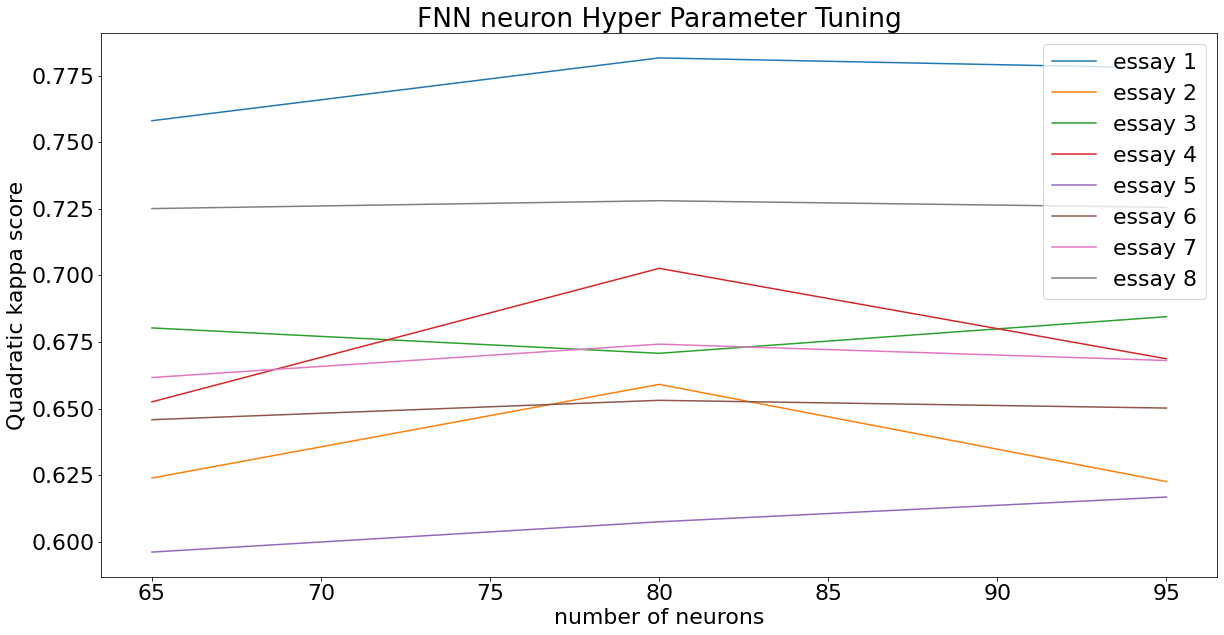

In [79]:
plt.rcParams.update({'font.size': 22})
result_d = {}
result =  []
fig, ax = plt.subplots(figsize = (20,10))
for i in range(1,9):
    result_for_set = []
    for neuron in neurons:
        temp = d_new[str(i)][str(neuron)]
        d_new[str(i)][str(neuron)] = np.mean(temp)
        result_for_set.append(np.mean(temp))
    result.append(result_for_set)
legends = []
for i in range(1,9):
    print("Essay set " + str(i))
    print(max(result[i-1]))
    ax.plot(neurons, result[i-1])
    string = "essay " + str(i)
    legends.append(string)
ax.legend(legends)
ax.set_xlabel("number of neurons")
ax.set_ylabel("Quadratic kappa score")
ax.set_title("FNN neuron Hyper Parameter Tuning")
fig.savefig("fnn_neuron_hyper_parameter_tuning.png")

In [80]:
print("Essay set " + str(1))
print(d_new[str(1)]["80"])
print("Essay set " + str(2))
print(d_new[str(2)]["80"])
print("Essay set " + str(3))
print(d_new[str(3)]["95"])
print("Essay set " + str(4))
print(d_new[str(4)]["80"])
print("Essay set " + str(5))
print(d_new[str(5)]["95"])
print("Essay set " + str(6))
print(d_new[str(6)]["80"])
print("Essay set " + str(7))
print(d_new[str(7)]["80"])
print("Essay set " + str(8))
print(d_new[str(8)]["80"])
print("average score")
print(np.mean([d_new[str(1)]["80"], d_new[str(2)]["80"], d_new[str(3)]["95"], d_new[str(4)]["80"], d_new[str(5)]["95"], d_new[str(6)]["80"],d_new[str(7)]["80"],d_new[str(8)]["80"] ]))

Essay set 1
0.781681244978343
Essay set 2
0.6590628944599061
Essay set 3
0.6844933735788212
Essay set 4
0.702646588510403
Essay set 5
0.6167503518899737
Essay set 6
0.6530726645260456
Essay set 7
0.6741780058036415
Essay set 8
0.7280523350876337
average score
0.687492182354346
